In [1]:
from itertools import chain
import pandas as pd
import time
import matplotlib.pyplot as plt
max_it = 10
from misc import vectorSchRepresentation, feasible_pairs, feasible_recharge, visualizeResult, visualizeSolution, drawBusTrips, apply_custom_shift
from chs import constructiveScheduler
from sa import annealing, get_total_gap
# cs_ids = ["CS1", "CS1a", "CS2c"]
MIN_BUSES = 4
def concat_str(x):
    return ','.join(x)

def countRecharge(x):
    trips = x.to_list()
    return len(list(filter(lambda x: x in cs_ids,trips)))

def countTrips(x):
    print(x.to_list())
    trips = x.to_list()
    return len(set(trips) - set(cs_ids))

In [2]:
# EXAMPLE DATA SET, DEPARTURE AND ARRIVAL TIMES IN MINUTES
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AC1', 'type': 'trip', 'duration': 140,  'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    2: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    3: {'name': 'AC3', 'type': 'trip', 'duration': 140,  'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    4: {'name': 'AC4', 'type': 'trip', 'duration': 140,  'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    5: {'name': 'AC5', 'type': 'trip', 'duration': 140,  'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    6: {'name': 'CA1', 'type': 'trip', 'duration': 140,  'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    7: {'name': 'CA2', 'type': 'trip', 'duration': 140,  'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    8: {'name': 'CA3', 'type': 'trip', 'duration': 140,  'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    9: {'name': 'CA4', 'type': 'trip', 'duration': 140,  'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    10: {'name': 'CA5', 'type': 'trip', 'duration': 140,  'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
}
charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2c', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal C', 'arr_term': 'Terminal C'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 30, 'CS1a': 10, 'CS2c': 75},
    'Terminal C': {'CS1': 30, 'CS1a': 75, 'CS2c': 10},
}

D_MAX = 350
CHARGING_TIME = 50
trips_df = pd.DataFrame.from_dict(trips, orient='index')
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)

######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}

    trip_id   name   type  duration  dep_time  arr_time    dep_term  \
0         0  DEPOT  depot         0         0      1440           -   
1         1    AC1   trip       140       555       695  Terminal A   
2         2    AC2   trip       140       675       815  Terminal A   
3         3    AC3   trip       140       795       935  Terminal A   
4         4    AC4   trip       140      1155      1295  Terminal A   
5         5    AC5   trip       140      1215      1355  Terminal A   
6         6    CA1   trip       140       570       710  Terminal C   
7         7    CA2   trip       140       740       880  Terminal C   
8         8    CA3   trip       140       860      1000  Terminal C   
9         9    CA4   trip       140       920      1060  Terminal C   
10       10    CA5   trip       140      1040      1180  Terminal C   

      arr_term  
0            -  
1   Terminal C  
2   Terminal C  
3   Terminal C  
4   Terminal C  
5   Terminal C  
6   Terminal A  
7   Termina

Fri Aug 15 12:36:06 2025
Fri Aug 15 12:36:06 2025
Time elapse to compute the solution = 0.0 seconds
number of buses = 3
[[(0, 1), (1, 3), (3, 10, 11), (10, 5), (5, 0)], [(0, 6), (6, 7), (7, 9, 11), (9, 4), (4, 0)], [(0, 2), (2, 8), (8, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [6, 7, 11, 9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 100.0
----------------------------------------------------------------------------------------------------
Iteration 2...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [2, 8, 0], [6, 7, 11, 9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 99.0
----------------------------------------------------------------------------------------------------
Iteration 3...
swapping other CS...
proposed solution = [[2, 8, 0], [1, 3, 11, 10, 5, 0], [6, 7, 11, 9, 4, 0]]
diff 

proposed solution = [[6, 7, 11, 10, 0], [1, 9, 11, 4, 0], [3, 5, 0], [2, 8, 0]]
diff neigh vs. current = -0.007485029940119792
current temp = 71.05532272722922
----------------------------------------------------------------------------------------------------
Iteration 36...
swapping other CS...
proposed solution = [[3, 5, 0], [2, 8, 0], [6, 7, 11, 10, 0], [1, 9, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 70.34476949995693
----------------------------------------------------------------------------------------------------
Iteration 37...
swapping other CS...
proposed solution = [[3, 5, 0], [2, 8, 0], [6, 7, 11, 10, 0], [1, 9, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 69.64132180495736
----------------------------------------------------------------------------------------------------
Iteration 38...
insertion...
proposed solution = [[1, 3, 11, 5, 0], [2, 8, 11, 4, 0], [6, 7, 11, 10, 0], [9, 0]]
diff neigh vs. current = 0.003892215568862323
current temp = 68.

diff neigh vs. current = -0.0
current temp = 52.03405226503067
----------------------------------------------------------------------------------------------------
Iteration 67...
swapping recharging task...
proposed solution = [[3, 0], [1, 9, 11, 4, 0], [6, 7, 0], [2, 8, 11, 5, 0], [10, 0]]
diff neigh vs. current = -0.1487524950099801
current temp = 51.51371174238036
----------------------------------------------------------------------------------------------------
Iteration 68...
swapping recharging task...
proposed solution = [[3, 0], [1, 9, 0], [6, 7, 0], [2, 8, 11, 5, 0], [10, 0], [4, 0]]
diff neigh vs. current = -0.1526447105788422
current temp = 50.998574624956554
----------------------------------------------------------------------------------------------------
Iteration 69...
insertion...
proposed solution = [[3, 0], [1, 9, 0], [6, 7, 0], [10, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = 0.14750499001995998
current temp = 50.488588878706985
-----------------------------

diff neigh vs. current = -0.1539920159680639
current temp = 38.104711810454994
----------------------------------------------------------------------------------------------------
Iteration 98...
swapping other CS...
proposed solution = [[6, 7, 0], [1, 3, 0], [9, 4, 0], [2, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 37.72366469235045
----------------------------------------------------------------------------------------------------
Iteration 99...
swapping other CS...
proposed solution = [[6, 7, 0], [1, 3, 0], [9, 4, 0], [2, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 37.34642804542694
----------------------------------------------------------------------------------------------------
Iteration 100...
insertion...
proposed solution = [[6, 7, 0], [1, 9, 11, 4, 0], [2, 8, 11, 10, 5, 0], [3, 0]]
diff neigh vs. current = -0.0
current temp = 36.97296376497267
---------------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 28.186069554046373
----------------------------------------------------------------------------------------------------
Iteration 128...
swapping other CS...
proposed solution = [[9, 4, 0], [2, 8, 0], [6, 3, 0], [1, 7, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 27.90420885850591
----------------------------------------------------------------------------------------------------
Iteration 129...
insertion...
proposed solution = [[1, 7, 11, 9, 4, 0], [2, 8, 0], [6, 3, 11, 10, 5, 0]]
diff neigh vs. current = 0.16117764471057883
current temp = 27.625166769920853
----------------------------------------------------------------------------------------------------
Iteration 130...
swapping other CS...
proposed solution = [[2, 8, 0], [1, 7, 11, 9, 4, 0], [6, 3, 11, 10, 5, 0]]
diff neigh vs. current = -0.0019461077844311614
current temp = 27.348915102221643
-----------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 21.27257032290188
----------------------------------------------------------------------------------------------------
Iteration 156...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [1, 3, 11, 10, 0], [2, 8, 11, 5, 0]]
diff neigh vs. current = -0.0
current temp = 21.059844619672862
----------------------------------------------------------------------------------------------------
Iteration 157...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [2, 8, 11, 5, 0], [1, 3, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 20.849246173476132
----------------------------------------------------------------------------------------------------
Iteration 158...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [1, 3, 11, 10, 0], [2, 8, 11, 5, 0]]
diff neigh vs. current = -0.0
current temp = 20.64075371174137
----------------------------------------------------------------------------------------------------
Iteration 159..

diff neigh vs. current = -0.0
current temp = 15.577974928671171
----------------------------------------------------------------------------------------------------
Iteration 187...
insertion...
proposed solution = [[2, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 0]]
diff neigh vs. current = -0.0
current temp = 15.42219517938446
----------------------------------------------------------------------------------------------------
Iteration 188...
insertion...
proposed solution = [[2, 8, 11, 10, 5, 0], [6, 7, 11, 9, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 15.267973227590614
----------------------------------------------------------------------------------------------------
Iteration 189...
insertion...
proposed solution = [[6, 7, 11, 9, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 15.115293495314708
----------------------------------------------------------------------------------------------------
Iteration 190.

diff neigh vs. current = -0.1338794233289644
current temp = 11.407803532657619
----------------------------------------------------------------------------------------------------
Iteration 218...
insertion...
proposed solution = [[6, 7, 0], [2, 8, 0], [10, 0], [3, 5, 0], [1, 9, 11, 4, 0]]
diff neigh vs. current = 0.11811926605504575
current temp = 11.293725497331042
----------------------------------------------------------------------------------------------------
Iteration 219...
swapping other CS...
proposed solution = [[6, 7, 0], [2, 8, 0], [10, 0], [3, 5, 0], [1, 9, 11, 4, 0]]
diff neigh vs. current = 0.004750982961992056
current temp = 11.180788242357732
----------------------------------------------------------------------------------------------------
Iteration 220...
insertion...
proposed solution = [[6, 7, 0], [2, 8, 0], [3, 10, 11, 5, 0], [1, 9, 11, 4, 0]]
diff neigh vs. current = 0.13810615989515085
current temp = 11.068980359934155
----------------------------------------

diff neigh vs. current = -0.0
current temp = 8.523592457219177
----------------------------------------------------------------------------------------------------
Iteration 247...
insertion...
proposed solution = [[2, 8, 0], [9, 4, 0], [6, 7, 0], [1, 3, 11, 10, 5, 0]]
diff neigh vs. current = 0.12434469200524256
current temp = 8.438356532646985
----------------------------------------------------------------------------------------------------
Iteration 248...
insertion...
proposed solution = [[2, 8, 0], [1, 9, 11, 4, 0], [6, 7, 11, 10, 0], [3, 5, 0]]
diff neigh vs. current = 0.00976408912188731
current temp = 8.353972967320516
----------------------------------------------------------------------------------------------------
Iteration 249...
swapping other CS...
proposed solution = [[2, 8, 0], [3, 5, 0], [1, 9, 11, 4, 0], [6, 7, 11, 10, 0]]
diff neigh vs. current = -0.019495412844036775
current temp = 8.27043323764731
-----------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 6.304904523214554
----------------------------------------------------------------------------------------------------
Iteration 277...
insertion...
proposed solution = [[2, 8, 0], [1, 3, 11, 10, 5, 0], [6, 7, 11, 9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 6.2418554779824085
----------------------------------------------------------------------------------------------------
Iteration 278...
swapping recharging task...
proposed solution = [[2, 9, 11, 4, 0], [1, 3, 11, 10, 5, 0], [6, 7, 0], [8, 0]]
diff neigh vs. current = -0.0
current temp = 6.1794369232025845
----------------------------------------------------------------------------------------------------
Iteration 279...
swapping other CS...
proposed solution = [[6, 7, 0], [8, 0], [2, 9, 11, 4, 0], [1, 3, 11, 10, 5, 0]]
diff neigh vs. current = -0.13663171690694625
current temp = 6.117642553970558
-------------------------------------------------------------------------------

proposed solution = [[6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 4.663740229999263
----------------------------------------------------------------------------------------------------
Iteration 307...
swapping other CS...
proposed solution = [[6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 4.61710282769927
----------------------------------------------------------------------------------------------------
Iteration 308...
swapping recharging task...
proposed solution = [[6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0], [2, 8, 0], [4, 0]]
diff neigh vs. current = -0.1286041939711665
current temp = 4.570931799422278
----------------------------------------------------------------------------------------------------
Iteration 309...
insertion...
proposed solution = [[6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = 0.1305701179554391
current temp = 4.525

diff neigh vs. current = -0.12034731323722159
current temp = 3.449770389516398
----------------------------------------------------------------------------------------------------
Iteration 337...
insertion...
proposed solution = [[6, 8, 11, 10, 0], [1, 7, 0], [2, 9, 11, 4, 0], [3, 5, 0]]
diff neigh vs. current = 0.12709698558322424
current temp = 3.415272685621234
----------------------------------------------------------------------------------------------------
Iteration 338...
insertion...
proposed solution = [[6, 8, 11, 10, 0], [1, 7, 0], [2, 9, 11, 4, 0], [3, 5, 0]]
diff neigh vs. current = -0.004226736566186107
current temp = 3.3811199587650216
----------------------------------------------------------------------------------------------------
Iteration 339...
swapping recharging task...
proposed solution = [[6, 8, 11, 10, 0], [1, 7, 11, 4, 0], [2, 9, 0], [3, 5, 0]]
diff neigh vs. current = -0.0
current temp = 3.347308759177371
---------------------------------------------------

diff neigh vs. current = 0.0025229357798165486
current temp = 2.577572166898093
----------------------------------------------------------------------------------------------------
Iteration 366...
insertion...
proposed solution = [[2, 9, 0], [6, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 2.551796445229112
----------------------------------------------------------------------------------------------------
Iteration 367...
insertion...
proposed solution = [[2, 9, 0], [6, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 2.526278480776821
----------------------------------------------------------------------------------------------------
Iteration 368...
insertion...
proposed solution = [[2, 9, 0], [6, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 2.501015695969053
--------------------------------------------------------------------------------------------------

diff neigh vs. current = -0.14134993446920058
current temp = 1.9066310942897584
----------------------------------------------------------------------------------------------------
Iteration 396...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [6, 3, 11, 5, 0], [1, 7, 11, 9, 4, 0]]
diff neigh vs. current = 0.14134993446920058
current temp = 1.8875647833468607
----------------------------------------------------------------------------------------------------
Iteration 397...
swapping other CS...
proposed solution = [[2, 8, 11, 10, 0], [6, 3, 11, 5, 0], [1, 7, 11, 9, 4, 0]]
diff neigh vs. current = -0.0074705111402358915
current temp = 1.868689135513392
----------------------------------------------------------------------------------------------------
Iteration 398...
swapping other CS...
proposed solution = [[2, 8, 11, 10, 0], [6, 3, 11, 5, 0], [1, 7, 11, 9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 1.8500022441582582
--------------------------------------------------

diff neigh vs. current = 0.005504587155963359
current temp = 1.4103357323598396
----------------------------------------------------------------------------------------------------
Iteration 426...
insertion...
proposed solution = [[2, 8, 11, 10, 5, 0], [1, 7, 11, 9, 4, 0], [6, 3, 0]]
diff neigh vs. current = 0.13011140235910873
current temp = 1.396232375036241
----------------------------------------------------------------------------------------------------
Iteration 427...
insertion...
proposed solution = [[2, 8, 11, 10, 5, 0], [6, 3, 0], [1, 7, 11, 9, 4, 0]]
diff neigh vs. current = 0.0037680209698558453
current temp = 1.3822700512858788
----------------------------------------------------------------------------------------------------
Iteration 428...
insertion...
proposed solution = [[2, 8, 11, 10, 5, 0], [1, 7, 11, 9, 4, 0], [6, 3, 0]]
diff neigh vs. current = -0.0
current temp = 1.36844735077302
---------------------------------------------------------------------------------

diff neigh vs. current = 0.0007863695937090354
current temp = 1.0537635028579868
----------------------------------------------------------------------------------------------------
Iteration 455...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [6, 7, 11, 9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 1.0432258678294068
----------------------------------------------------------------------------------------------------
Iteration 456...
swapping recharging task...
proposed solution = [[1, 3, 11, 10, 5, 0], [6, 7, 0], [2, 9, 11, 4, 0], [8, 0]]
diff neigh vs. current = -0.0
current temp = 1.0327936091511127
----------------------------------------------------------------------------------------------------
Iteration 457...
swapping recharging task...
proposed solution = [[1, 3, 0], [6, 7, 11, 10, 5, 0], [2, 9, 11, 4, 0], [8, 0]]
diff neigh vs. current = -0.13663171690694625
current temp = 1.0224656730596016
-----------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.7794692565269951
----------------------------------------------------------------------------------------------------
Iteration 485...
swapping recharging task...
proposed solution = [[2, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0], [6, 7, 0], [9, 0]]
diff neigh vs. current = -0.13387942332896463
current temp = 0.7716745639617251
----------------------------------------------------------------------------------------------------
Iteration 486...
swapping other CS...
proposed solution = [[6, 7, 0], [9, 0], [2, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.7639578183221079
----------------------------------------------------------------------------------------------------
Iteration 487...
insertion...
proposed solution = [[6, 7, 11, 9, 0], [2, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = 0.13584534731323722
current temp = 0.7563182401388867
----------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.5765737000977033
----------------------------------------------------------------------------------------------------
Iteration 515...
swapping other CS...
proposed solution = [[6, 7, 0], [8, 0], [2, 9, 11, 4, 0], [1, 3, 11, 10, 5, 0]]
diff neigh vs. current = -0.13663171690694625
current temp = 0.5708079630967262
----------------------------------------------------------------------------------------------------
Iteration 516...
insertion...
proposed solution = [[6, 7, 0], [2, 9, 11, 4, 0], [1, 3, 11, 10, 5, 0], [8, 0]]
diff neigh vs. current = -0.0
current temp = 0.5650998834657589
----------------------------------------------------------------------------------------------------
Iteration 517...
insertion...
proposed solution = [[6, 7, 0], [2, 9, 11, 4, 0], [1, 3, 11, 10, 5, 0], [8, 0]]
diff neigh vs. current = -0.0
current temp = 0.5594488846311013
---------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.4307997790385187
----------------------------------------------------------------------------------------------------
Iteration 544...
swapping recharging task...
proposed solution = [[1, 7, 11, 9, 0], [2, 8, 11, 10, 5, 0], [6, 3, 0], [4, 0]]
diff neigh vs. current = -0.1256225425950197
current temp = 0.4264917812481335
----------------------------------------------------------------------------------------------------
Iteration 545...
insertion...
proposed solution = [[2, 8, 11, 4, 0], [6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0]]
diff neigh vs. current = -0.0
current temp = 0.42222686343565213
----------------------------------------------------------------------------------------------------
Iteration 546...
insertion...
proposed solution = [[6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.4180045948012956
----------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.3218815731417988
----------------------------------------------------------------------------------------------------
Iteration 573...
insertion...
proposed solution = [[6, 3, 0], [1, 7, 11, 9, 0], [10, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = 0.12939056356487555
current temp = 0.31866275741038086
----------------------------------------------------------------------------------------------------
Iteration 574...
swapping other CS...
proposed solution = [[6, 3, 0], [10, 5, 0], [1, 7, 11, 9, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = 0.00999344692005244
current temp = 0.31547612983627704
----------------------------------------------------------------------------------------------------
Iteration 575...
swapping other CS...
proposed solution = [[6, 3, 0], [10, 5, 0], [1, 7, 11, 9, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.31232136853791426
--------------------------------------------------------------

diff neigh vs. current = -0.005504587155963359
current temp = 0.24050092913110663
----------------------------------------------------------------------------------------------------
Iteration 602...
swapping recharging task...
proposed solution = [[6, 3, 0], [7, 10, 11, 5, 0], [1, 8, 11, 4, 0], [2, 9, 0]]
diff neigh vs. current = 0.005504587155963359
current temp = 0.23809591983979556
----------------------------------------------------------------------------------------------------
Iteration 603...
swapping recharging task...
proposed solution = [[6, 3, 0], [7, 10, 11, 5, 0], [1, 8, 0], [2, 9, 11, 4, 0]]
diff neigh vs. current = 0.0027522935779816793
current temp = 0.2357149606413976
----------------------------------------------------------------------------------------------------
Iteration 604...
swapping other CS...
proposed solution = [[6, 3, 0], [1, 8, 0], [7, 10, 11, 5, 0], [2, 9, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.23335781103498363
--------------------

diff neigh vs. current = -0.0
current temp = 0.17969558290758378
----------------------------------------------------------------------------------------------------
Iteration 631...
swapping other CS...
proposed solution = [[6, 4, 0], [2, 9, 0], [7, 0], [3, 0], [1, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.14787024901703805
current temp = 0.17789862707850793
----------------------------------------------------------------------------------------------------
Iteration 632...
swapping recharging task...
proposed solution = [[6, 4, 0], [2, 9, 0], [7, 0], [3, 10, 11, 5, 0], [1, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.17611964080772285
----------------------------------------------------------------------------------------------------
Iteration 633...
insertion...
proposed solution = [[6, 7, 11, 4, 0], [2, 9, 0], [3, 10, 11, 5, 0], [1, 8, 0]]
diff neigh vs. current = 0.14338138925294897
current temp = 0.17435844439964562
---------------------------------------------------

diff neigh vs. current = -0.13387942332896463
current temp = 0.1342635250231963
----------------------------------------------------------------------------------------------------
Iteration 660...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 8, 0], [2, 4, 0], [3, 10, 0]]
diff neigh vs. current = 0.14062909567496729
current temp = 0.13292088977296435
----------------------------------------------------------------------------------------------------
Iteration 661...
insertion...
proposed solution = [[1, 8, 0], [2, 9, 11, 4, 0], [6, 3, 11, 10, 5, 0], [7, 0]]
diff neigh vs. current = 0.0015072083879422715
current temp = 0.1315916808752347
----------------------------------------------------------------------------------------------------
Iteration 662...
insertion...
proposed solution = [[1, 8, 0], [2, 9, 11, 4, 0], [6, 3, 11, 10, 5, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 0.13027576406648236
-----------------------------------------------------------------

diff neigh vs. current = -0.1286041939711665
current temp = 0.10031795918392428
----------------------------------------------------------------------------------------------------
Iteration 689...
swapping other CS...
proposed solution = [[6, 8, 0], [1, 3, 0], [2, 9, 0], [4, 0], [7, 10, 11, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.09931477959208504
----------------------------------------------------------------------------------------------------
Iteration 690...
insertion...
proposed solution = [[6, 8, 0], [1, 3, 0], [2, 9, 11, 4, 0], [7, 10, 11, 5, 0]]
diff neigh vs. current = 0.13237221494102236
current temp = 0.09832163179616418
----------------------------------------------------------------------------------------------------
Iteration 691...
insertion...
proposed solution = [[6, 8, 0], [1, 3, 11, 10, 5, 0], [2, 9, 11, 4, 0], [7, 0]]
diff neigh vs. current = 0.0015072083879422715
current temp = 0.09733841547820254
---------------------------------------------------

diff neigh vs. current = -0.13387942332896463
current temp = 0.0749547796625243
----------------------------------------------------------------------------------------------------
Iteration 718...
swapping other CS...
proposed solution = [[2, 4, 0], [3, 0], [1, 7, 11, 9, 5, 0], [6, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.07420523186589906
----------------------------------------------------------------------------------------------------
Iteration 719...
insertion...
proposed solution = [[2, 8, 11, 4, 0], [6, 3, 11, 10, 0], [1, 7, 11, 9, 5, 0]]
diff neigh vs. current = 0.1496068152031455
current temp = 0.07346317954724006
----------------------------------------------------------------------------------------------------
Iteration 720...
insertion...
proposed solution = [[6, 3, 11, 10, 0], [1, 7, 11, 9, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0074705111402358915
current temp = 0.07272854775176767
------------------------------------------------------

diff neigh vs. current = -0.13089777195281788
current temp = 0.05544407850360551
----------------------------------------------------------------------------------------------------
Iteration 748...
swapping other CS...
proposed solution = [[6, 3, 11, 10, 0], [1, 7, 11, 9, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.05488963771856946
----------------------------------------------------------------------------------------------------
Iteration 749...
swapping recharging task...
proposed solution = [[6, 3, 11, 10, 0], [1, 7, 11, 9, 5, 0], [2, 8, 0], [4, 0]]
diff neigh vs. current = -0.12860419397116646
current temp = 0.054340741341383766
----------------------------------------------------------------------------------------------------
Iteration 750...
swapping other CS...
proposed solution = [[6, 3, 11, 10, 0], [1, 7, 11, 9, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.053797333927969926
--------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.04142626825382438
----------------------------------------------------------------------------------------------------
Iteration 777...
swapping other CS...
proposed solution = [[2, 8, 11, 4, 0], [6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0]]
diff neigh vs. current = -0.0
current temp = 0.041012005571286134
----------------------------------------------------------------------------------------------------
Iteration 778...
swapping other CS...
proposed solution = [[2, 8, 11, 4, 0], [6, 3, 11, 10, 5, 0], [1, 7, 11, 9, 0]]
diff neigh vs. current = -0.0
current temp = 0.04060188551557327
----------------------------------------------------------------------------------------------------
Iteration 779...
swapping recharging task...
proposed solution = [[2, 8, 11, 4, 0], [6, 3, 0], [1, 7, 11, 10, 5, 0], [9, 0]]
diff neigh vs. current = -0.0
current temp = 0.04019586666041754
-----------------------------------------------------------------------------

diff neigh vs. current = 0.00298165137614681
current temp = 0.030952551611552477
----------------------------------------------------------------------------------------------------
Iteration 806...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [2, 8, 11, 10, 5, 0], [1, 3, 0]]
diff neigh vs. current = -0.0
current temp = 0.030643026095436954
----------------------------------------------------------------------------------------------------
Iteration 807...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [2, 8, 11, 10, 5, 0], [1, 3, 0]]
diff neigh vs. current = -0.0
current temp = 0.030336595834482585
----------------------------------------------------------------------------------------------------
Iteration 808...
swapping other CS...
proposed solution = [[1, 3, 0], [6, 7, 11, 9, 4, 0], [2, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.030033229876137758
-----------------------------------------------------------------------------------------------

diff neigh vs. current = -0.139384010484928
current temp = 0.0231268828125105
----------------------------------------------------------------------------------------------------
Iteration 835...
swapping other CS...
proposed solution = [[2, 8, 0], [9, 0], [1, 3, 11, 4, 0], [6, 7, 11, 10, 5, 0]]
diff neigh vs. current = -0.139384010484928
current temp = 0.022895613984385395
----------------------------------------------------------------------------------------------------
Iteration 836...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = 0.0019659239842725884
current temp = 0.02266665784454154
----------------------------------------------------------------------------------------------------
Iteration 837...
insertion...
proposed solution = [[1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0074705111402358915
current temp = 0.022439991266096124
-------------------------------------

diff neigh vs. current = -0.12562254259501965
current temp = 0.017279761466384862
----------------------------------------------------------------------------------------------------
Iteration 864...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.017106963851721012
----------------------------------------------------------------------------------------------------
Iteration 865...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.016935894213203802
----------------------------------------------------------------------------------------------------
Iteration 866...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.016766535271071765
------------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.012910955564389192
----------------------------------------------------------------------------------------------------
Iteration 893...
swapping other CS...
proposed solution = [[2, 8, 11, 10, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.012781846008745299
----------------------------------------------------------------------------------------------------
Iteration 894...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.012654027548657847
----------------------------------------------------------------------------------------------------
Iteration 895...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.012527487273171267
--------------------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.009646705708866846
----------------------------------------------------------------------------------------------------
Iteration 922...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.009550238651778177
----------------------------------------------------------------------------------------------------
Iteration 923...
insertion...
proposed solution = [[1, 3, 11, 4, 0], [2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.009454736265260395
----------------------------------------------------------------------------------------------------
Iteration 924...
swapping other CS...
proposed solution = [[1, 3, 11, 4, 0], [2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.00936018890260779
-------------------------------------------------------------------------------------------

diff neigh vs. current = -0.1338794233289647
current temp = 0.007207749307894606
----------------------------------------------------------------------------------------------------
Iteration 951...
swapping recharging task...
proposed solution = [[6, 7, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0], [9, 5, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.00713567181481566
----------------------------------------------------------------------------------------------------
Iteration 952...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 0], [2, 8, 11, 10, 0], [4, 0]]
diff neigh vs. current = -0.12562254259501965
current temp = 0.007064315096667504
----------------------------------------------------------------------------------------------------
Iteration 953...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 0], [10, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.00699367194570082

diff neigh vs. current = -0.1338794233289647
current temp = 0.005385429145796724
----------------------------------------------------------------------------------------------------
Iteration 980...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.005331574854338757
----------------------------------------------------------------------------------------------------
Iteration 981...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.005278259105795369
----------------------------------------------------------------------------------------------------
Iteration 982...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.005225476514737416
---------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.004023842373739358
----------------------------------------------------------------------------------------------------
Iteration 1009...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.003983603950001964
----------------------------------------------------------------------------------------------------
Iteration 1010...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.003943767910501945
----------------------------------------------------------------------------------------------------
Iteration 1011...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.003904330231396925
-------------------------------------------------------------------------------

diff neigh vs. current = -0.1338794233289647
current temp = 0.003006502733647058
----------------------------------------------------------------------------------------------------
Iteration 1038...
swapping recharging task...
proposed solution = [[1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0], [2, 8, 0], [10, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.0029764377063105875
----------------------------------------------------------------------------------------------------
Iteration 1039...
swapping other CS...
proposed solution = [[1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.0029466733292474816
----------------------------------------------------------------------------------------------------
Iteration 1040...
swapping recharging task...
proposed solution = [[1, 3, 11, 4, 0], [6, 7, 0], [2, 8, 11, 10, 0], [9, 5, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.0029172065959550066
---------------

diff neigh vs. current = -0.1338794233289647
current temp = 0.002246374944112741
----------------------------------------------------------------------------------------------------
Iteration 1067...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.0022239111946716133
----------------------------------------------------------------------------------------------------
Iteration 1068...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 0], [2, 8, 11, 10, 0], [4, 0]]
diff neigh vs. current = -0.12562254259501965
current temp = 0.0022016720827248972
----------------------------------------------------------------------------------------------------
Iteration 1069...
swapping recharging task...
proposed solution = [[6, 7, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0], [9, 0], [5, 0]]
diff neigh vs. current = -0.2624836173001312
current temp = 0.002179655361897648
------------------

diff neigh vs. current = -0.0
current temp = 0.001678428671646739
----------------------------------------------------------------------------------------------------
Iteration 1096...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.0016616443849302716
----------------------------------------------------------------------------------------------------
Iteration 1097...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0016450279410809689
----------------------------------------------------------------------------------------------------
Iteration 1098...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0016285776616701592
--------------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.001254075065780493
----------------------------------------------------------------------------------------------------
Iteration 1125...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 0], [1, 3, 11, 4, 0], [10, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.001241534315122688
----------------------------------------------------------------------------------------------------
Iteration 1126...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0012291189719714612
----------------------------------------------------------------------------------------------------
Iteration 1127...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 0], [4, 0]]
diff neigh vs. current = -0.12562254259501965
current temp = 0.0012168277822517466
------------------------------

diff neigh vs. current = -0.0
current temp = 0.0009370098933482455
----------------------------------------------------------------------------------------------------
Iteration 1154...
swapping recharging task...
proposed solution = [[1, 3, 11, 4, 0], [2, 8, 0], [6, 7, 11, 9, 5, 0], [10, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.000927639794414763
----------------------------------------------------------------------------------------------------
Iteration 1155...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0009183633964706154
----------------------------------------------------------------------------------------------------
Iteration 1156...
swapping other CS...
proposed solution = [[2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0009091797625059092
-------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.0007001076444224342
----------------------------------------------------------------------------------------------------
Iteration 1183...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 0], [1, 3, 11, 4, 0], [10, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.0006931065679782098
----------------------------------------------------------------------------------------------------
Iteration 1184...
swapping recharging task...
proposed solution = [[6, 7, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0], [9, 5, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.0006861755022984277
----------------------------------------------------------------------------------------------------
Iteration 1185...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0006793137472754434
-----------------------------

diff neigh vs. current = -0.0
current temp = 0.0005231008949406706
----------------------------------------------------------------------------------------------------
Iteration 1212...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 0], [4, 0]]
diff neigh vs. current = -0.12562254259501965
current temp = 0.0005178698859912639
----------------------------------------------------------------------------------------------------
Iteration 1213...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 0], [1, 3, 11, 4, 0], [10, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.0005126911871313512
----------------------------------------------------------------------------------------------------
Iteration 1214...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 0], [1, 3, 11, 4, 0], [10, 0]]
diff neigh vs. current = -0.1338794233289647
current temp = 0.0005075642752600377
-----

diff neigh vs. current = -0.1338794233289647
current temp = 0.00039084639121955315
----------------------------------------------------------------------------------------------------
Iteration 1241...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0003869379273073576
----------------------------------------------------------------------------------------------------
Iteration 1242...
swapping recharging task...
proposed solution = [[6, 7, 0], [2, 8, 11, 10, 5, 0], [1, 3, 11, 4, 0], [9, 0]]
diff neigh vs. current = -0.12837483617300133
current temp = 0.000383068548034284
----------------------------------------------------------------------------------------------------
Iteration 1243...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00037923786255394113
-------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.00029202951668945985
----------------------------------------------------------------------------------------------------
Iteration 1270...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.0002891092215225652
----------------------------------------------------------------------------------------------------
Iteration 1271...
insertion...
proposed solution = [[1, 3, 11, 4, 0], [2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.00028621812930733955
----------------------------------------------------------------------------------------------------
Iteration 1272...
insertion...
proposed solution = [[1, 3, 11, 4, 0], [2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.00028335594801426616
----------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.00021819630559150762
----------------------------------------------------------------------------------------------------
Iteration 1299...
insertion...
proposed solution = [[1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.00021601434253559255
----------------------------------------------------------------------------------------------------
Iteration 1300...
swapping recharging task...
proposed solution = [[1, 3, 11, 4, 0], [6, 7, 0], [2, 8, 11, 10, 0], [9, 0], [5, 0]]
diff neigh vs. current = -0.2624836173001312
current temp = 0.00021385419911023663
----------------------------------------------------------------------------------------------------
Iteration 1301...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00021171565711913427
-----------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.00016303019062422372
----------------------------------------------------------------------------------------------------
Iteration 1328...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00016139988871798148
----------------------------------------------------------------------------------------------------
Iteration 1329...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00015978588983080167
----------------------------------------------------------------------------------------------------
Iteration 1330...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.00015818803093249365
-----------------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.00012181160896798056
----------------------------------------------------------------------------------------------------
Iteration 1357...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00012059349287830076
----------------------------------------------------------------------------------------------------
Iteration 1358...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00011938755794951775
----------------------------------------------------------------------------------------------------
Iteration 1359...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00011819368237002257
-----------------------------------------------------------------------

diff neigh vs. current = -0.12837483617300133
current temp = 9.101423498650747e-05
----------------------------------------------------------------------------------------------------
Iteration 1386...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 9.010409263664239e-05
----------------------------------------------------------------------------------------------------
Iteration 1387...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 8.920305171027597e-05
----------------------------------------------------------------------------------------------------
Iteration 1388...
swapping other CS...
proposed solution = [[2, 8, 11, 10, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 8.831102119317321e-05
---------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 6.800329656885683e-05
----------------------------------------------------------------------------------------------------
Iteration 1415...
swapping recharging task...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 0], [2, 8, 11, 10, 0], [4, 0]]
diff neigh vs. current = -0.12562254259501965
current temp = 6.732326360316826e-05
----------------------------------------------------------------------------------------------------
Iteration 1416...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 6.665003096713658e-05
----------------------------------------------------------------------------------------------------
Iteration 1417...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 6.598353065746522e-05
-------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 5.08101655188054e-05
----------------------------------------------------------------------------------------------------
Iteration 1444...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 10, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 5.0302063863617344e-05
----------------------------------------------------------------------------------------------------
Iteration 1445...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 4.979904322498117e-05
----------------------------------------------------------------------------------------------------
Iteration 1446...
insertion...
proposed solution = [[2, 8, 11, 10, 0], [6, 7, 11, 9, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 4.930105279273136e-05
---------------------------------------------------------------------------------------------------

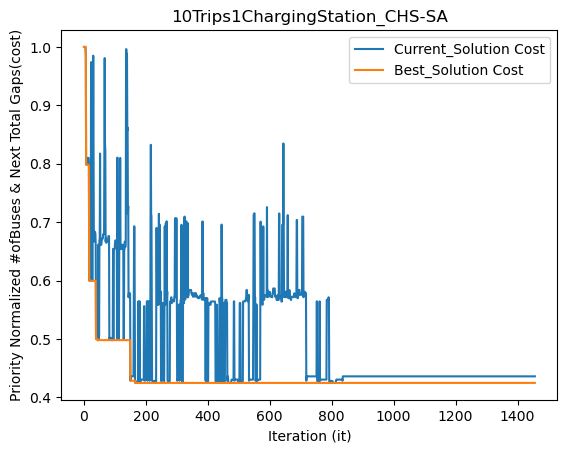

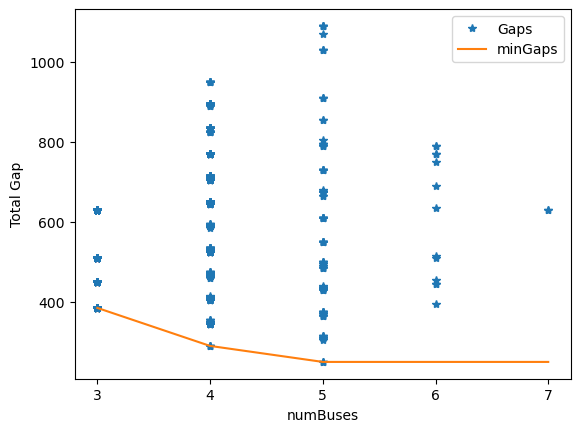

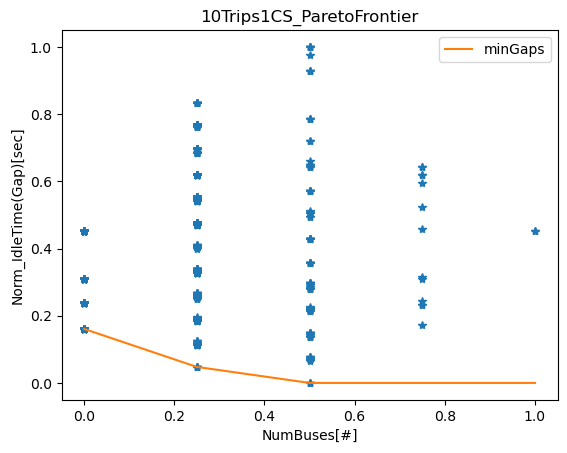

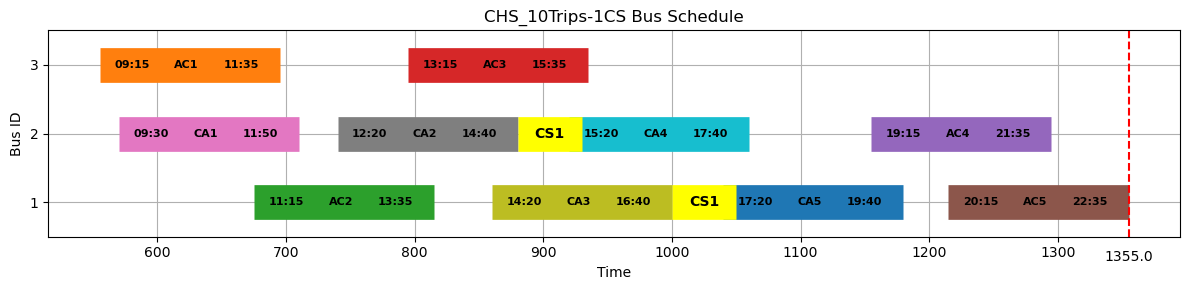

In [3]:
import time
start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_10_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_10_1)
end_time = time.time()
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"number of buses = {len(schedules_10_1)}")
print(schedules_10_1)
g_T10CS1_time = end_time-start_time

####### SA
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
# test_new_schedule, test_cost, test_cost_diffs, test_temp, test_it, test_costs, test_solutionspaces, test_best
new_schedule_10_1, cost_10_1, cost_diffs_10_1, temp_10_1, it_10_1, costs_10_1, solution_spaces_10_1, best_costs_10_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)

end_time = time.time()
T10CS1_time = (end_time-start_time) + g_T10CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_10_1} with number of buses = {len(new_schedule_10_1)}")
print(f"Number of buses previous = {len(schedules_10_1)}... new = {len(new_schedule_10_1)} ")
print(f"Prev: {vectorSchRepresentation(schedules_10_1)}\nNew: {new_schedule_10_1}")
print(f"Total Gap among buses=> prev = {get_total_gap(solution, all_schs_1cs, recharge_1cs_arcs)}... new = {get_total_gap(new_schedule_10_1, all_schs_1cs, recharge_1cs_arcs)}")

# fig1, ax1 = plt.subplots()
plt.plot(range(it_10_1), costs_10_1, label="Current_Solution Cost")
plt.plot(range(it_10_1), best_costs_10_1, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
plt.title("10Trips1ChargingStation_CHS-SA")
plt.legend(loc="upper right")
# plt.savefig("10Trips1CS.png")

TenTrips_1cs_df = visualizeSolution(solution_spaces_10_1[1:], "10Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_10_1cs = visualizeResult(new_schedule_10_1, all_schs_1cs, "CHS_10Trips-1CS", cs_deadheads)

trips10_df_1cs = newdf_10_1cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips10_df_1cs['next_dep'] = trips10_df_1cs['next_dep'].fillna(0)
trips10_df_1cs['difference'] = trips10_df_1cs['next_dep'] - trips10_df_1cs['arr_time']
trips10_df_1cs['difference'] = trips10_df_1cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_10Trips1cs_IDLE_soln = trips10_df_1cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

dict_keys([11, 12, 13])
{11: {'name': 'CS1', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'}, 12: {'name': 'CS1a', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'}, 13: {'name': 'CS2c', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal C', 'arr_term': 'Terminal C'}}
{'Terminal A': {'CS1': 30, 'CS1a': 10, 'CS2c': 75}, 'Terminal C': {'CS1': 30, 'CS1a': 75, 'CS2c': 10}}
{(1, 3, 11): {'duration': 30}, (1, 4, 11): {'duration': 30}, (1, 5, 11): {'duration': 30}, (1, 7, 11): {'duration': 30}, (1, 8, 11): {'duration': 30}, (1, 9, 11): {'duration': 30}, (1, 10, 11): {'duration': 30}, (2, 4, 11): {'duration': 30}, (2, 5, 11): {'duration': 30}, (2, 8, 11): {'duration': 30}, (2, 9, 11): {'duration': 30}, (2, 10, 11): {'duration': 30}, (3, 4, 11): {'duration': 30}, (3, 5, 11): {'duration': 30}, (3, 10, 11): {'duration': 30}, (6, 3, 11): {'duration': 3

diff neigh vs. current = -0.0
current temp = 84.29431933839268
----------------------------------------------------------------------------------------------------
Iteration 19...
insertion...
proposed solution = [[1, 3, 11, 4, 0], [6, 7, 11, 9, 0], [2, 8, 12, 10, 5, 0]]
diff neigh vs. current = 0.0029059829059828735
current temp = 83.45137614500875
----------------------------------------------------------------------------------------------------
Iteration 20...
insertion...
proposed solution = [[6, 7, 11, 9, 0], [2, 8, 12, 10, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = -0.01358974358974363
current temp = 82.61686238355867
----------------------------------------------------------------------------------------------------
Iteration 21...
insertion...
proposed solution = [[2, 8, 12, 10, 5, 0], [1, 3, 11, 4, 0], [6, 7, 11, 9, 0]]
diff neigh vs. current = -0.0
current temp = 81.79069375972308
----------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 62.35253948912001
----------------------------------------------------------------------------------------------------
Iteration 49...
insertion...
proposed solution = [[6, 7, 0], [2, 8, 0], [1, 3, 11, 10, 5, 0], [9, 4, 0]]
diff neigh vs. current = 0.1713675213675213
current temp = 61.72901409422881
----------------------------------------------------------------------------------------------------
Iteration 50...
swapping recharging task...
proposed solution = [[6, 7, 11, 10, 5, 0], [2, 8, 0], [1, 3, 0], [9, 4, 0]]
diff neigh vs. current = 0.004957264957265006
current temp = 61.11172395328652
----------------------------------------------------------------------------------------------------
Iteration 51...
insertion...
proposed solution = [[6, 7, 11, 10, 5, 0], [2, 8, 0], [1, 9, 11, 4, 0], [3, 0]]
diff neigh vs. current = -0.0043640446182819925
current temp = 60.500606713753655
--------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 45.20436502664755
----------------------------------------------------------------------------------------------------
Iteration 81...
insertion...
proposed solution = [[1, 7, 0], [2, 9, 11, 4, 0], [6, 8, 11, 10, 5, 0], [3, 0]]
diff neigh vs. current = -0.0
current temp = 44.752321376381076
----------------------------------------------------------------------------------------------------
Iteration 82...
insertion...
proposed solution = [[2, 9, 11, 4, 0], [6, 8, 11, 10, 5, 0], [1, 3, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 44.30479816261727
----------------------------------------------------------------------------------------------------
Iteration 83...
swapping other CS...
proposed solution = [[1, 3, 0], [7, 0], [2, 9, 13, 4, 0], [6, 8, 12, 10, 5, 0]]
diff neigh vs. current = -0.0034810126582278667
current temp = 43.861750180991095
------------------------------------------------------------------------------------------

diff neigh vs. current = -0.004113924050632933
current temp = 33.10330883210141
----------------------------------------------------------------------------------------------------
Iteration 112...
swapping other CS...
proposed solution = [[6, 7, 0], [8, 0], [1, 3, 13, 10, 5, 0], [2, 9, 13, 4, 0]]
diff neigh vs. current = -0.1912658227848102
current temp = 32.7722757437804
----------------------------------------------------------------------------------------------------
Iteration 113...
swapping other CS...
proposed solution = [[6, 7, 0], [8, 0], [1, 3, 12, 10, 5, 0], [2, 9, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 32.44455298634259
----------------------------------------------------------------------------------------------------
Iteration 114...
insertion...
proposed solution = [[6, 7, 11, 9, 0], [2, 8, 11, 4, 0], [1, 3, 12, 10, 5, 0]]
diff neigh vs. current = 0.18974683544303805
current temp = 32.12010745647917
------------------------------------------------------

diff neigh vs. current = -0.37113924050632907
current temp = 24.24166460445803
----------------------------------------------------------------------------------------------------
Iteration 143...
swapping other CS...
proposed solution = [[1, 3, 0], [2, 8, 0], [10, 0], [5, 0], [6, 7, 11, 9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 23.99924795841345
----------------------------------------------------------------------------------------------------
Iteration 144...
swapping other CS...
proposed solution = [[1, 3, 0], [2, 8, 0], [10, 0], [5, 0], [6, 7, 11, 9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 23.759255478829314
----------------------------------------------------------------------------------------------------
Iteration 145...
swapping recharging task...
proposed solution = [[1, 9, 11, 4, 0], [2, 8, 0], [10, 0], [5, 0], [6, 7, 0], [3, 0]]
diff neigh vs. current = 0.15833333333333333
current temp = 23.52166292404102
--------------------------------------------

diff neigh vs. current = -0.0
current temp = 18.11269531259703
----------------------------------------------------------------------------------------------------
Iteration 172...
swapping other CS...
proposed solution = [[6, 7, 0], [1, 3, 0], [10, 0], [5, 0], [9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 17.931568359471058
----------------------------------------------------------------------------------------------------
Iteration 173...
swapping recharging task...
proposed solution = [[6, 7, 0], [1, 3, 0], [10, 0], [5, 0], [9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 17.752252675876345
----------------------------------------------------------------------------------------------------
Iteration 174...
swapping recharging task...
proposed solution = [[6, 7, 0], [1, 3, 0], [10, 0], [5, 0], [9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 17.57473014911758
---------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 13.5333004907032
----------------------------------------------------------------------------------------------------
Iteration 201...
insertion...
proposed solution = [[1, 7, 12, 10, 0], [6, 3, 13, 5, 0], [9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 13.397967485796167
----------------------------------------------------------------------------------------------------
Iteration 202...
insertion...
proposed solution = [[1, 7, 12, 10, 0], [6, 3, 13, 5, 0], [2, 8, 0], [9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 13.263987810938206
----------------------------------------------------------------------------------------------------
Iteration 203...
insertion...
proposed solution = [[1, 7, 12, 10, 0], [6, 3, 13, 5, 0], [9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 13.131347932828824
----------------------------------------------------------------------------------------------------
Iteration 20

diff neigh vs. current = -0.1713080168776372
current temp = 10.010587426148955
----------------------------------------------------------------------------------------------------
Iteration 231...
swapping recharging task...
proposed solution = [[6, 10, 0], [9, 4, 0], [1, 7, 11, 5, 0], [2, 8, 0], [3, 0]]
diff neigh vs. current = -0.008131049888309705
current temp = 9.910481551887466
----------------------------------------------------------------------------------------------------
Iteration 232...
swapping recharging task...
proposed solution = [[6, 10, 11, 5, 0], [9, 4, 0], [1, 7, 0], [2, 8, 0], [3, 0]]
diff neigh vs. current = 0.010588235294117676
current temp = 9.811376736368592
----------------------------------------------------------------------------------------------------
Iteration 233...
insertion...
proposed solution = [[6, 3, 11, 10, 5, 0], [9, 4, 0], [1, 7, 0], [2, 8, 0]]
diff neigh vs. current = 0.15735294117647058
current temp = 9.713262969004907
-----------------------

diff neigh vs. current = -0.0
current temp = 7.5551834067527865
----------------------------------------------------------------------------------------------------
Iteration 259...
swapping recharging task...
proposed solution = [[6, 9, 11, 4, 0], [1, 7, 11, 10, 5, 0], [3, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 7.479631572685259
----------------------------------------------------------------------------------------------------
Iteration 260...
insertion...
proposed solution = [[6, 9, 11, 4, 0], [1, 7, 11, 10, 5, 0], [2, 8, 0], [3, 0]]
diff neigh vs. current = -0.00659340659340657
current temp = 7.404835256958406
----------------------------------------------------------------------------------------------------
Iteration 261...
swapping recharging task...
proposed solution = [[6, 9, 0], [1, 7, 11, 10, 5, 0], [2, 8, 11, 4, 0], [3, 0]]
diff neigh vs. current = -0.0
current temp = 7.330786904388821
--------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 5.645022209082803
----------------------------------------------------------------------------------------------------
Iteration 288...
insertion...
proposed solution = [[1, 3, 13, 10, 5, 0], [6, 7, 11, 9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 5.588571986991974
----------------------------------------------------------------------------------------------------
Iteration 289...
swapping recharging task...
proposed solution = [[1, 3, 0], [6, 7, 11, 9, 4, 0], [2, 8, 0], [10, 0], [5, 0]]
diff neigh vs. current = -0.308974358974359
current temp = 5.532686267122054
----------------------------------------------------------------------------------------------------
Iteration 290...
insertion...
proposed solution = [[1, 3, 0], [6, 7, 11, 9, 4, 0], [2, 8, 0], [10, 5, 0]]
diff neigh vs. current = 0.14203296703296708
current temp = 5.477359404450834
-------------------------------------------------------------------------------

diff neigh vs. current = -0.16300366300366298
current temp = 4.217803066508771
----------------------------------------------------------------------------------------------------
Iteration 317...
swapping recharging task...
proposed solution = [[6, 7, 11, 10, 5, 0], [2, 8, 0], [1, 9, 11, 4, 0], [3, 0]]
diff neigh vs. current = -0.0
current temp = 4.175625035843683
----------------------------------------------------------------------------------------------------
Iteration 318...
insertion...
proposed solution = [[6, 7, 11, 10, 5, 0], [2, 8, 0], [1, 9, 11, 4, 0], [3, 0]]
diff neigh vs. current = -0.00659340659340657
current temp = 4.133868785485246
----------------------------------------------------------------------------------------------------
Iteration 319...
swapping recharging task...
proposed solution = [[6, 7, 0], [2, 8, 11, 5, 0], [1, 9, 11, 4, 0], [3, 0], [10, 0]]
diff neigh vs. current = -0.0
current temp = 4.0925300976303935
-----------------------------------------------

diff neigh vs. current = -0.0
current temp = 3.1514247506815867
----------------------------------------------------------------------------------------------------
Iteration 346...
swapping other CS...
proposed solution = [[2, 8, 0], [9, 0], [1, 7, 11, 10, 5, 0], [6, 3, 13, 4, 0]]
diff neigh vs. current = -0.0
current temp = 3.1199105031747707
----------------------------------------------------------------------------------------------------
Iteration 347...
swapping other CS...
proposed solution = [[2, 8, 0], [9, 0], [1, 7, 11, 10, 5, 0], [6, 3, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 3.088711398143023
----------------------------------------------------------------------------------------------------
Iteration 348...
swapping other CS...
proposed solution = [[2, 8, 0], [9, 0], [1, 7, 12, 10, 5, 0], [6, 3, 12, 4, 0]]
diff neigh vs. current = -0.0
current temp = 3.0578242841615926
----------------------------------------------------------------------------------------

diff neigh vs. current = 0.0094736842105263
current temp = 2.3311100647842378
----------------------------------------------------------------------------------------------------
Iteration 376...
insertion...
proposed solution = [[6, 9, 11, 4, 0], [1, 7, 0], [3, 0], [2, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 2.307798964136395
----------------------------------------------------------------------------------------------------
Iteration 377...
swapping other CS...
proposed solution = [[1, 7, 0], [3, 0], [6, 9, 12, 4, 0], [2, 8, 12, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 2.2847209744950314
----------------------------------------------------------------------------------------------------
Iteration 378...
insertion...
proposed solution = [[1, 7, 0], [3, 0], [6, 9, 12, 4, 0], [2, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 2.261873764750081
-------------------------------------------------------------------------------------------

diff neigh vs. current = 0.0014912280701754321
current temp = 1.724322985330079
----------------------------------------------------------------------------------------------------
Iteration 406...
swapping other CS...
proposed solution = [[2, 8, 0], [9, 4, 0], [1, 3, 11, 10, 5, 0], [6, 7, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 1.7070797554767783
----------------------------------------------------------------------------------------------------
Iteration 407...
swapping recharging task...
proposed solution = [[2, 8, 0], [9, 4, 0], [1, 3, 0], [6, 7, 11, 10, 5, 0], [10, 0], [5, 0]]
diff neigh vs. current = -0.30929824561403507
current temp = 1.6900089579220106
----------------------------------------------------------------------------------------------------
Iteration 408...
insertion...
proposed solution = [[2, 8, 0], [1, 3, 11, 10, 5, 0], [6, 7, 11, 10, 5, 0], [9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 1.6731088683427904
-----------------------------

diff neigh vs. current = -0.0026315789473684292
current temp = 1.2883660162531856
----------------------------------------------------------------------------------------------------
Iteration 435...
swapping recharging task...
proposed solution = [[1, 3, 13, 10, 5, 0], [6, 7, 0], [2, 8, 11, 10, 5, 0], [9, 0], [4, 0]]
diff neigh vs. current = -0.3095614035087719
current temp = 1.2754823560906536
----------------------------------------------------------------------------------------------------
Iteration 436...
insertion...
proposed solution = [[6, 7, 11, 10, 0], [2, 8, 11, 10, 5, 0], [9, 5, 0], [1, 3, 11, 4, 0]]
diff neigh vs. current = 0.14552631578947373
current temp = 1.2627275325297471
----------------------------------------------------------------------------------------------------
Iteration 437...
swapping recharging task...
proposed solution = [[6, 7, 11, 10, 0], [2, 8, 11, 10, 5, 0], [9, 4, 0], [1, 3, 0]]
diff neigh vs. current = 0.006754385964912291
current temp = 1.2501002

diff neigh vs. current = -0.0
current temp = 0.9723546814439878
----------------------------------------------------------------------------------------------------
Iteration 463...
swapping other CS...
proposed solution = [[2, 9, 0], [3, 4, 0], [6, 8, 0], [1, 7, 13, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.962631134629548
----------------------------------------------------------------------------------------------------
Iteration 464...
swapping recharging task...
proposed solution = [[2, 9, 0], [3, 4, 0], [6, 8, 11, 10, 5, 0], [1, 7, 0]]
diff neigh vs. current = 0.006315789473684275
current temp = 0.9530048232832525
----------------------------------------------------------------------------------------------------
Iteration 465...
swapping recharging task...
proposed solution = [[2, 9, 0], [3, 4, 0], [6, 8, 0], [1, 7, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.94347477505042
------------------------------------------------------------------------

diff neigh vs. current = -0.1562280701754386
current temp = 0.7265162837676364
----------------------------------------------------------------------------------------------------
Iteration 492...
insertion...
proposed solution = [[1, 7, 12, 9, 4, 0], [2, 8, 12, 10, 5, 0], [6, 3, 0]]
diff neigh vs. current = -0.0
current temp = 0.71925112092996
----------------------------------------------------------------------------------------------------
Iteration 493...
swapping recharging task...
proposed solution = [[1, 7, 0], [2, 8, 12, 10, 5, 0], [6, 9, 11, 4, 0], [3, 0]]
diff neigh vs. current = -0.0
current temp = 0.7120586097206604
----------------------------------------------------------------------------------------------------
Iteration 494...
swapping recharging task...
proposed solution = [[1, 7, 0], [2, 8, 12, 10, 5, 0], [6, 9, 0], [3, 4, 0]]
diff neigh vs. current = -0.16280701754385962
current temp = 0.7049380236234538
-------------------------------------------------------------

diff neigh vs. current = 0.012017543859649149
current temp = 0.542832693308673
----------------------------------------------------------------------------------------------------
Iteration 521...
insertion...
proposed solution = [[6, 7, 0], [2, 9, 12, 4, 0], [1, 8, 11, 10, 5, 0], [3, 0]]
diff neigh vs. current = -0.0
current temp = 0.5374043663755863
----------------------------------------------------------------------------------------------------
Iteration 522...
insertion...
proposed solution = [[6, 7, 11, 9, 0], [1, 8, 11, 10, 5, 0], [3, 0], [2, 4, 0]]
diff neigh vs. current = -0.0034210526315789913
current temp = 0.5320303227118305
----------------------------------------------------------------------------------------------------
Iteration 523...
swapping recharging task...
proposed solution = [[6, 7, 0], [1, 8, 11, 10, 5, 0], [3, 0], [2, 9, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.5267100194847122
---------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.4096863033647498
----------------------------------------------------------------------------------------------------
Iteration 549...
insertion...
proposed solution = [[1, 7, 12, 10, 0], [6, 3, 12, 10, 5, 0], [9, 4, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.40558944033110234
----------------------------------------------------------------------------------------------------
Iteration 550...
swapping other CS...
proposed solution = [[9, 4, 0], [2, 8, 0], [1, 7, 12, 10, 0], [6, 3, 13, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.40153354592779134
----------------------------------------------------------------------------------------------------
Iteration 551...
swapping recharging task...
proposed solution = [[9, 4, 0], [2, 8, 0], [1, 7, 0], [6, 3, 13, 10, 5, 0], [10, 0]]
diff neigh vs. current = -0.15109351432880846
current temp = 0.39751821046851343
--------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.3091981548525351
----------------------------------------------------------------------------------------------------
Iteration 577...
swapping other CS...
proposed solution = [[1, 7, 11, 9, 5, 0], [6, 3, 12, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.30610617330400974
----------------------------------------------------------------------------------------------------
Iteration 578...
swapping other CS...
proposed solution = [[1, 7, 12, 9, 5, 0], [6, 3, 12, 4, 0], [2, 8, 12, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.30304511157096964
----------------------------------------------------------------------------------------------------
Iteration 579...
swapping other CS...
proposed solution = [[1, 7, 11, 9, 5, 0], [6, 3, 12, 4, 0], [2, 8, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.30001466045525993
---------------------------------------------------------------------------------------

diff neigh vs. current = -0.15131975867269987
current temp = 0.23102423292463378
----------------------------------------------------------------------------------------------------
Iteration 606...
swapping other CS...
proposed solution = [[1, 7, 12, 9, 5, 0], [6, 3, 11, 10, 0], [2, 8, 12, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.22871399059538744
----------------------------------------------------------------------------------------------------
Iteration 607...
insertion...
proposed solution = [[1, 7, 12, 9, 5, 0], [6, 3, 11, 10, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.22642685068943355
----------------------------------------------------------------------------------------------------
Iteration 608...
swapping recharging task...
proposed solution = [[1, 7, 12, 9, 5, 0], [6, 3, 11, 10, 0], [2, 8, 0], [4, 0]]
diff neigh vs. current = -0.15131975867269987
current temp = 0.2241625821825392
-------------------------------------------------------

diff neigh vs. current = -0.0035067873303167296
current temp = 0.17088871135609265
----------------------------------------------------------------------------------------------------
Iteration 636...
swapping recharging task...
proposed solution = [[1, 7, 11, 9, 4, 0], [6, 3, 11, 5, 0], [2, 8, 0], [10, 0]]
diff neigh vs. current = -0.1565233785822021
current temp = 0.16917982424253172
----------------------------------------------------------------------------------------------------
Iteration 637...
insertion...
proposed solution = [[6, 3, 11, 5, 0], [2, 8, 11, 10, 0], [1, 7, 11, 9, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.1674880260001064
----------------------------------------------------------------------------------------------------
Iteration 638...
swapping recharging task...
proposed solution = [[6, 3, 11, 5, 0], [2, 8, 11, 10, 0], [1, 7, 0], [9, 0], [4, 0]]
diff neigh vs. current = -0.3105580693815988
current temp = 0.16581314574010533
--------------------------

diff neigh vs. current = -0.0
current temp = 0.12768327636155938
----------------------------------------------------------------------------------------------------
Iteration 665...
insertion...
proposed solution = [[2, 8, 12, 10, 5, 0], [1, 7, 0], [6, 9, 11, 4, 0], [3, 0]]
diff neigh vs. current = -0.16217948717948721
current temp = 0.12640644359794379
----------------------------------------------------------------------------------------------------
Iteration 666...
insertion...
proposed solution = [[2, 8, 12, 10, 5, 0], [1, 7, 0], [6, 9, 11, 4, 0], [3, 0]]
diff neigh vs. current = -0.16217948717948721
current temp = 0.12514237916196436
----------------------------------------------------------------------------------------------------
Iteration 667...
swapping other CS...
proposed solution = [[1, 7, 0], [3, 0], [2, 8, 11, 10, 5, 0], [6, 9, 13, 4, 0]]
diff neigh vs. current = -0.16217948717948721
current temp = 0.12389095537034471
---------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.09636503132342052
----------------------------------------------------------------------------------------------------
Iteration 693...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [2, 8, 11, 10, 5, 0], [1, 3, 0]]
diff neigh vs. current = -0.0
current temp = 0.0954013810101863
----------------------------------------------------------------------------------------------------
Iteration 694...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [2, 8, 11, 10, 5, 0], [1, 3, 0]]
diff neigh vs. current = -0.0
current temp = 0.09444736720008444
----------------------------------------------------------------------------------------------------
Iteration 695...
swapping other CS...
proposed solution = [[1, 3, 0], [6, 7, 12, 9, 4, 0], [2, 8, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.0935028935280836
----------------------------------------------------------------------------------------------------
Iteration 696..

diff neigh vs. current = -0.0
current temp = 0.07200126227425
----------------------------------------------------------------------------------------------------
Iteration 722...
swapping other CS...
proposed solution = [[1, 3, 13, 10, 5, 0], [2, 8, 12, 4, 0], [6, 7, 12, 9, 0]]
diff neigh vs. current = -0.0
current temp = 0.07128124965150749
----------------------------------------------------------------------------------------------------
Iteration 723...
insertion...
proposed solution = [[2, 8, 12, 4, 0], [6, 7, 12, 9, 0], [1, 3, 11, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.07056843715499242
----------------------------------------------------------------------------------------------------
Iteration 724...
insertion...
proposed solution = [[6, 7, 12, 9, 0], [1, 3, 11, 10, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.06986275278344249
----------------------------------------------------------------------------------------------------
Iter

diff neigh vs. current = -0.0
current temp = 0.053797333927969926
----------------------------------------------------------------------------------------------------
Iteration 751...
insertion...
proposed solution = [[6, 7, 0], [2, 9, 11, 4, 0], [1, 3, 11, 10, 5, 0], [8, 0]]
diff neigh vs. current = -0.0
current temp = 0.05325936058869023
----------------------------------------------------------------------------------------------------
Iteration 752...
swapping recharging task...
proposed solution = [[6, 7, 0], [2, 9, 11, 4, 0], [1, 3, 0], [8, 0], [10, 0], [5, 0]]
diff neigh vs. current = -0.3103318250377074
current temp = 0.052726766982803326
----------------------------------------------------------------------------------------------------
Iteration 753...
insertion...
proposed solution = [[6, 7, 11, 9, 0], [1, 3, 11, 10, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = 0.1546003016591252
current temp = 0.052199499312975295
-------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.04019586666041754
----------------------------------------------------------------------------------------------------
Iteration 780...
insertion...
proposed solution = [[6, 7, 11, 9, 4, 0], [1, 3, 11, 10, 5, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.03979390799381336
----------------------------------------------------------------------------------------------------
Iteration 781...
swapping other CS...
proposed solution = [[2, 8, 0], [6, 7, 12, 9, 4, 0], [1, 3, 12, 10, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.03939596891387523
----------------------------------------------------------------------------------------------------
Iteration 782...
insertion...
proposed solution = [[6, 7, 12, 9, 4, 0], [1, 3, 12, 10, 5, 0], [2, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.03900200922473648
----------------------------------------------------------------------------------------------------
Iteration 783

diff neigh vs. current = -0.3132730015082956
current temp = 0.030033229876137758
----------------------------------------------------------------------------------------------------
Iteration 809...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [2, 9, 11, 4, 0], [6, 7, 0], [8, 0]]
diff neigh vs. current = -0.15923831070889893
current temp = 0.02973289757737638
----------------------------------------------------------------------------------------------------
Iteration 810...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [2, 9, 11, 4, 0], [6, 8, 0], [7, 0]]
diff neigh vs. current = -0.15923831070889893
current temp = 0.029435568601602617
----------------------------------------------------------------------------------------------------
Iteration 811...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [2, 9, 11, 4, 0], [6, 7, 0], [8, 0]]
diff neigh vs. current = -0.15923831070889893
current temp = 0.029141212915586592
-----------------------------------------

diff neigh vs. current = -0.15923831070889893
current temp = 0.02266665784454154
----------------------------------------------------------------------------------------------------
Iteration 837...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [2, 9, 11, 4, 0], [6, 7, 0], [8, 0]]
diff neigh vs. current = -0.15923831070889893
current temp = 0.022439991266096124
----------------------------------------------------------------------------------------------------
Iteration 838...
swapping recharging task...
proposed solution = [[1, 3, 11, 10, 5, 0], [2, 9, 0], [6, 7, 11, 4, 0], [8, 0]]
diff neigh vs. current = -0.15923831070889893
current temp = 0.022215591353435163
----------------------------------------------------------------------------------------------------
Iteration 839...
swapping other CS...
proposed solution = [[6, 7, 0], [8, 0], [1, 3, 12, 10, 5, 0], [2, 9, 11, 4, 0]]
diff neigh vs. current = -0.15923831070889893
current temp = 0.021993435439900812
-----------------

diff neigh vs. current = -0.1565233785822021
current temp = 0.017106963851721012
----------------------------------------------------------------------------------------------------
Iteration 865...
insertion...
proposed solution = [[1, 3, 13, 10, 5, 0], [2, 8, 11, 4, 0], [6, 7, 11, 9, 0]]
diff neigh vs. current = -0.0
current temp = 0.016935894213203802
----------------------------------------------------------------------------------------------------
Iteration 866...
insertion...
proposed solution = [[1, 3, 13, 10, 5, 0], [6, 7, 11, 9, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.016766535271071765
----------------------------------------------------------------------------------------------------
Iteration 867...
insertion...
proposed solution = [[1, 3, 13, 10, 5, 0], [2, 8, 11, 4, 0], [6, 7, 11, 9, 0]]
diff neigh vs. current = -0.0
current temp = 0.016598869918361046
-------------------------------------------------------------------------------------------

diff neigh vs. current = -0.15901206636500753
current temp = 0.012910955564389192
----------------------------------------------------------------------------------------------------
Iteration 893...
insertion...
proposed solution = [[2, 8, 12, 4, 0], [6, 7, 11, 10, 5, 0], [1, 9, 0], [3, 0]]
diff neigh vs. current = -0.15901206636500753
current temp = 0.012781846008745299
----------------------------------------------------------------------------------------------------
Iteration 894...
insertion...
proposed solution = [[1, 3, 0], [2, 8, 12, 4, 0], [6, 7, 11, 10, 5, 0], [9, 0]]
diff neigh vs. current = -0.15901206636500753
current temp = 0.012654027548657847
----------------------------------------------------------------------------------------------------
Iteration 895...
insertion...
proposed solution = [[1, 3, 0], [2, 8, 12, 4, 0], [6, 7, 11, 10, 5, 0], [9, 0]]
diff neigh vs. current = -0.15901206636500753
current temp = 0.012527487273171267
---------------------------------------

diff neigh vs. current = -0.1565233785822021
current temp = 0.009646705708866846
----------------------------------------------------------------------------------------------------
Iteration 922...
insertion...
proposed solution = [[6, 7, 12, 9, 5, 0], [2, 8, 12, 4, 0], [1, 3, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.009550238651778177
----------------------------------------------------------------------------------------------------
Iteration 923...
swapping recharging task...
proposed solution = [[6, 7, 12, 9, 5, 0], [2, 8, 12, 4, 0], [1, 3, 0], [10, 0]]
diff neigh vs. current = -0.15358220211161389
current temp = 0.009454736265260395
----------------------------------------------------------------------------------------------------
Iteration 924...
swapping other CS...
proposed solution = [[6, 7, 12, 9, 5, 0], [2, 8, 11, 4, 0], [1, 3, 12, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.00936018890260779
----------------------------------------------------

diff neigh vs. current = -0.15358220211161389
current temp = 0.007207749307894606
----------------------------------------------------------------------------------------------------
Iteration 951...
insertion...
proposed solution = [[1, 3, 13, 10, 0], [6, 7, 11, 9, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.00713567181481566
----------------------------------------------------------------------------------------------------
Iteration 952...
insertion...
proposed solution = [[1, 3, 13, 10, 0], [6, 7, 11, 9, 5, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.007064315096667504
----------------------------------------------------------------------------------------------------
Iteration 953...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 11, 4, 0], [1, 3, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.006993671945700828
-------------------------------------------------------------------------------------------

diff neigh vs. current = -0.307843137254902
current temp = 0.005385429145796724
----------------------------------------------------------------------------------------------------
Iteration 980...
swapping recharging task...
proposed solution = [[2, 8, 12, 4, 0], [6, 7, 0], [1, 3, 11, 10, 5, 0], [9, 0]]
diff neigh vs. current = -0.15109351432880846
current temp = 0.005331574854338757
----------------------------------------------------------------------------------------------------
Iteration 981...
swapping recharging task...
proposed solution = [[2, 8, 12, 4, 0], [6, 7, 0], [1, 3, 13, 10, 0], [9, 5, 0]]
diff neigh vs. current = -0.1565233785822021
current temp = 0.005278259105795369
----------------------------------------------------------------------------------------------------
Iteration 982...
insertion...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 13, 10, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.005225476514737416
-----------------------------

diff neigh vs. current = -0.0
current temp = 0.004023842373739358
----------------------------------------------------------------------------------------------------
Iteration 1009...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [2, 8, 13, 4, 0], [1, 3, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.003983603950001964
----------------------------------------------------------------------------------------------------
Iteration 1010...
insertion...
proposed solution = [[2, 8, 13, 4, 0], [1, 3, 11, 10, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.003943767910501945
----------------------------------------------------------------------------------------------------
Iteration 1011...
swapping recharging task...
proposed solution = [[2, 8, 0], [1, 3, 11, 10, 0], [6, 7, 11, 9, 5, 0], [4, 0]]
diff neigh vs. current = -0.15131975867269987
current temp = 0.003904330231396925
---------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.003006502733647058
----------------------------------------------------------------------------------------------------
Iteration 1038...
insertion...
proposed solution = [[6, 7, 12, 9, 5, 0], [1, 3, 13, 10, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0029764377063105875
----------------------------------------------------------------------------------------------------
Iteration 1039...
swapping recharging task...
proposed solution = [[6, 7, 12, 9, 5, 0], [1, 3, 0], [2, 8, 11, 4, 0], [10, 0]]
diff neigh vs. current = -0.15358220211161389
current temp = 0.0029466733292474816
----------------------------------------------------------------------------------------------------
Iteration 1040...
swapping recharging task...
proposed solution = [[6, 7, 0], [1, 3, 13, 10, 0], [2, 8, 11, 4, 0], [9, 5, 0]]
diff neigh vs. current = -0.1565233785822021
current temp = 0.0029172065959550066
-------------------------------------

diff neigh vs. current = -0.0
current temp = 0.002246374944112741
----------------------------------------------------------------------------------------------------
Iteration 1067...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 12, 10, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0022239111946716133
----------------------------------------------------------------------------------------------------
Iteration 1068...
insertion...
proposed solution = [[1, 3, 12, 10, 0], [2, 8, 11, 4, 0], [6, 7, 11, 9, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.0022016720827248972
----------------------------------------------------------------------------------------------------
Iteration 1069...
insertion...
proposed solution = [[2, 8, 11, 4, 0], [6, 7, 11, 9, 5, 0], [1, 3, 11, 10, 0]]
diff neigh vs. current = -0.0
current temp = 0.002179655361897648
---------------------------------------------------------------------------------------------

diff neigh vs. current = -0.0
current temp = 0.001678428671646739
----------------------------------------------------------------------------------------------------
Iteration 1096...
swapping other CS...
proposed solution = [[6, 7, 11, 9, 5, 0], [1, 3, 11, 10, 0], [2, 8, 12, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0016616443849302716
----------------------------------------------------------------------------------------------------
Iteration 1097...
swapping other CS...
proposed solution = [[6, 7, 12, 9, 5, 0], [1, 3, 12, 10, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0016450279410809689
----------------------------------------------------------------------------------------------------
Iteration 1098...
insertion...
proposed solution = [[6, 7, 12, 9, 5, 0], [1, 3, 12, 10, 0], [2, 8, 11, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.0016285776616701592
------------------------------------------------------------------------------------

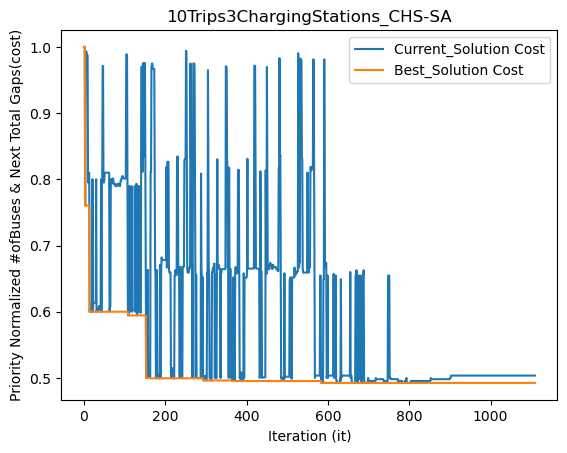

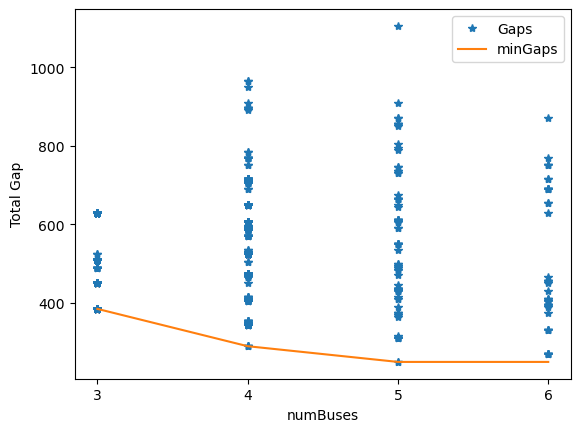

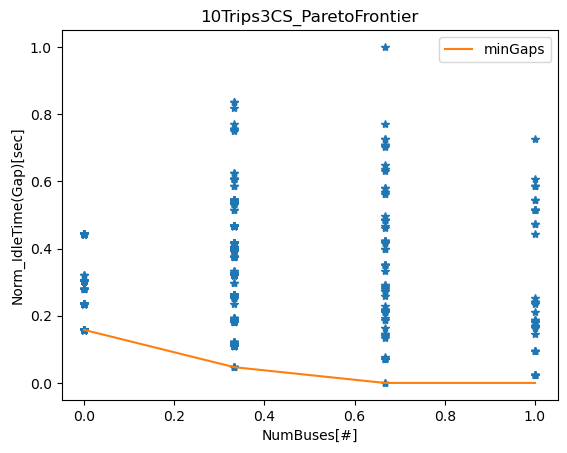

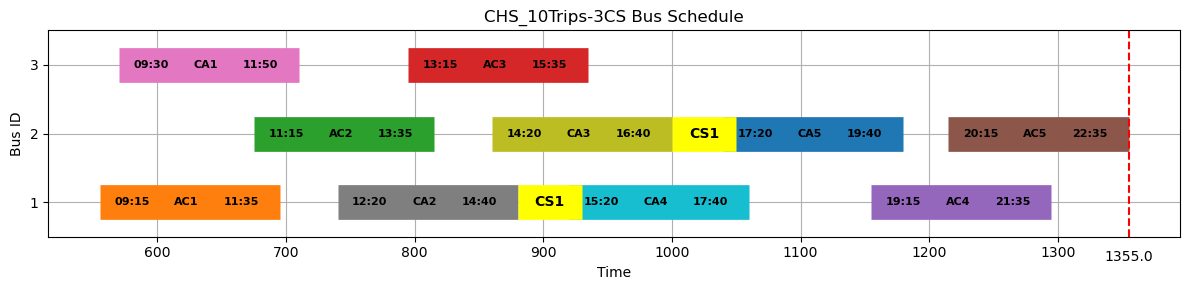

In [4]:
################################################################### 3CS #############################################################################################
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
print(recharge_3cs_arcs)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

# for i in range(3, 6):
####### CHS
import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_10_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_10_3)
end_time = time.time()
g_T10CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T10CS3_time)} seconds")
print(f"number of buses = {len(schedules_10_3)}")
print(schedules_10_3)
####### SA
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_10_3, cost_10_3, cost_diffs_10_3, temp_10_3, it_10_3, costs_10_3, solutionspaces_10_3, best_10_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T10CS3_time = (end_time-start_time)+g_T10CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T10CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_10_3} with number of buses = {len(new_schedule_10_3)}")

fig1, ax1 = plt.subplots()
ax1.plot(range(it_10_3), costs_10_3, label="Current_Solution Cost")
ax1.plot(range(it_10_3), best_10_3, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("10Trips3ChargingStations_CHS-SA")
ax1.legend(loc="upper right")
# plt.savefig("10Trips3CSs.png")

TenTrips_3cs_df = visualizeSolution(solutionspaces_10_3[1:], "10Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_10_3cs = visualizeResult(new_schedule_10_3, all_schs_3cs, "CHS_10Trips-3CS", cs_deadheads)

trips10_df_3cs = newdf_10_3cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips10_df_3cs['next_dep'] = trips10_df_3cs['next_dep'].fillna(0)
trips10_df_3cs['difference'] = trips10_df_3cs['next_dep'] - trips10_df_3cs['arr_time']
trips10_df_3cs['difference'] = trips10_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_10Trips3cs_IDLE_soln = trips10_df_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [ ]:
# ################################################################################# 20 TRIPS ##################################################################################
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AB1', 'type': 'trip', 'duration': 135, 'dep_time': 560, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    2: {'name': 'AB2', 'type': 'trip', 'duration': 135, 'dep_time': 740, 'arr_time': 875, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    3: {'name': 'AB3', 'type': 'trip', 'duration': 135, 'dep_time': 830, 'arr_time': 965, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    4: {'name': 'AB4', 'type': 'trip', 'duration': 135, 'dep_time': 920, 'arr_time': 1055, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    5: {'name': 'AB5', 'type': 'trip', 'duration': 135, 'dep_time': 980, 'arr_time': 1115, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    6: {'name': 'AC1', 'type': 'trip', 'duration': 140, 'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    7: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    8: {'name': 'AC3', 'type': 'trip', 'duration': 140, 'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    9: {'name': 'AC4', 'type': 'trip', 'duration': 140, 'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    10: {'name': 'AC5', 'type': 'trip', 'duration': 140, 'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    11: {'name': 'BA1', 'type': 'trip', 'duration': 135, 'dep_time': 540, 'arr_time': 675, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    12: {'name': 'BA2', 'type': 'trip', 'duration': 135, 'dep_time': 630, 'arr_time': 765, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    13: {'name': 'BA3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    14: {'name': 'BA4', 'type': 'trip', 'duration': 135, 'dep_time': 810, 'arr_time': 945, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    15: {'name': 'BA5', 'type': 'trip', 'duration': 135, 'dep_time': 900, 'arr_time': 1035, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    16: {'name': 'CA1', 'type': 'trip', 'duration': 140, 'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    17: {'name': 'CA2', 'type': 'trip', 'duration': 140, 'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    18: {'name': 'CA3', 'type': 'trip', 'duration': 140, 'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    19: {'name': 'CA4', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    20: {'name': 'CA5', 'type': 'trip', 'duration': 140, 'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
}

charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips) + 1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2b', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal C', 'arr_term': 'Terminal C'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal B': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
    'Terminal D': {'max_interval': 15}
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 30, 'CS1a': 10, 'CS2b': 30, 'CS3c': 30, 'CS4d': 30},
    'Terminal B': {'CS1': 30, 'CS1a': 30, 'CS2b': 10, 'CS3c': 30, 'CS4d': 30},
    'Terminal C': {'CS1': 30, 'CS1a': 30, 'CS2b': 30, 'CS3c': 10, 'CS4d': 30},
    'Terminal D': {'CS1': 30, 'CS1a': 30, 'CS2b': 30, 'CS3c': 10, 'CS4d': 10},
}

D_MAX = 350
CHARGING_TIME = 50
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)

######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}

In [ ]:
import time
start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_20_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_20_1)
end_time = time.time()
g_T20CS1_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T20CS1_time)} seconds")
print(f"number of buses = {len(schedules_20_1)}")
print(schedules_20_1)

####### SA
print('-'*100)
start_time = time.time()
print("starting simulated annealing....")
new_schedule_20_1, cost_20_1, cost_diffs_20_1, temp_20_1, it_20_1, costs_20_1, solution_spaces_20_1, best_costs_20_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T20CS1_time = (end_time-start_time) + g_T20CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T20CS1_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_20_1} with number of buses = {len(new_schedule_20_1)}")

print(f"Number of buses previous = {len(schedules_20_1)}... new = {len(new_schedule_20_1)} ")
print(f"Prev: {vectorSchRepresentation(schedules_20_1)}\nNew: {new_schedule_20_1}")
print(f"Total Gap among buses=> prev = {get_total_gap(solution, all_schs_1cs, recharge_1cs_arcs)}... new = {get_total_gap(new_schedule_20_1, all_schs_1cs, recharge_1cs_arcs)}")

#### PLOTTING
fig1, ax1 = plt.subplots()
ax1.plot(range(it_20_1), costs_20_1, label="Current_Solution Cost")
ax1.plot(range(it_20_1), best_costs_20_1, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("20Trips1ChargingStation_CHS-SA")
ax1.legend(loc="upper right")
# plt.savefig("20Trips1CS.png")

TwentyTrips_1cs_df = visualizeSolution(solution_spaces_20_1[1:], "20Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_20_1cs = visualizeResult(new_schedule_20_1, all_schs_1cs, "CHS_20Trips-1CS", cs_deadheads)

trips20_df_1cs = newdf_20_1cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips20_df_1cs['next_dep'] = trips20_df_1cs['next_dep'].fillna(0)
trips20_df_1cs['difference'] = trips20_df_1cs['next_dep'] - trips20_df_1cs['arr_time']
trips20_df_1cs['difference'] = trips20_df_1cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_20Trips1cs_IDLE_soln = trips20_df_1cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [ ]:
################################################################### 3CS #############################################################################################
## Creating Phi and Delta
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

####### CHS
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_20_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_20_3)
end_time = time.time()
g_T20CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"number of buses = {len(schedules_20_3)}")
print(schedules_20_3)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_20_3, cost_20_3, cost_diffs_20_3, temp_20_3, it_20_3, costs_20_3, solutionspaces_20_3, best_20_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T20CS3_time = (end_time-start_time) + g_T20CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T20CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_20_3} with number of buses = {len(new_schedule_20_3)}")

#### PLOTTING
fig1, ax1 = plt.subplots()
ax1.plot(range(it_20_3), costs_20_3, label="Current_Solution Cost")
ax1.plot(range(it_20_3), best_20_3, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("20Trips3ChargingStations_CHS-SA")
ax1.legend(loc="upper right")
#plt.savefig("20Trips3CSs.png")
TwentyTrips_3cs_df = visualizeSolution(solutionspaces_20_3[1:], "20Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_20_3cs = visualizeResult(new_schedule_20_3, all_schs_3cs, "CHS_20Trips-3CS", cs_deadheads)

trips20_df_3cs = newdf_20_3cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips20_df_3cs['next_dep'] = trips20_df_3cs['next_dep'].fillna(0)
trips20_df_3cs['difference'] = trips20_df_3cs['next_dep'] - trips20_df_3cs['arr_time']
trips20_df_3cs['difference'] = trips20_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_20Trips3cs_IDLE_soln = trips20_df_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [ ]:
cs_ids = ["CS1", "CS1a", "CS2b"]
# ################################################################################# 30 TRIPS ##################################################################################
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AB1', 'type': 'trip', 'duration': 135, 'dep_time': 560, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    2: {'name': 'AB2', 'type': 'trip', 'duration': 135, 'dep_time': 740, 'arr_time': 875, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    3: {'name': 'AB3', 'type': 'trip', 'duration': 135, 'dep_time': 830, 'arr_time': 965, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    4: {'name': 'AB4', 'type': 'trip', 'duration': 135, 'dep_time': 920, 'arr_time': 1055, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    5: {'name': 'AB5', 'type': 'trip', 'duration': 135, 'dep_time': 980, 'arr_time': 1115, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    6: {'name': 'AB6', 'type': 'trip', 'duration': 135, 'dep_time': 1040, 'arr_time': 1175, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    7: {'name': 'AB7', 'type': 'trip', 'duration': 135, 'dep_time': 1100, 'arr_time': 1235, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    8: {'name': 'AB8', 'type': 'trip', 'duration': 135, 'dep_time': 1190, 'arr_time': 1325, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    9: {'name': 'AC1', 'type': 'trip', 'duration': 140, 'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    10: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    11: {'name': 'AC3', 'type': 'trip', 'duration': 140, 'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    12: {'name': 'AC4', 'type': 'trip', 'duration': 140, 'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    13: {'name': 'AC5', 'type': 'trip', 'duration': 140, 'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    14: {'name': 'AD1', 'type': 'trip', 'duration': 210, 'dep_time': 560, 'arr_time': 770, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    15: {'name': 'BA1', 'type': 'trip', 'duration': 135, 'dep_time': 540, 'arr_time': 675, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    16: {'name': 'BA2', 'type': 'trip', 'duration': 135, 'dep_time': 630, 'arr_time': 765, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    17: {'name': 'BA3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    18: {'name': 'BA4', 'type': 'trip', 'duration': 135, 'dep_time': 810, 'arr_time': 945, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    19: {'name': 'BA5', 'type': 'trip', 'duration': 135, 'dep_time': 900, 'arr_time': 1035, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    20: {'name': 'BA6', 'type': 'trip', 'duration': 135, 'dep_time': 990, 'arr_time': 1125, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    21: {'name': 'BA7', 'type': 'trip', 'duration': 135, 'dep_time': 1080, 'arr_time': 1215, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    22: {'name': 'BA8', 'type': 'trip', 'duration': 135, 'dep_time': 1140, 'arr_time': 1275, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    23: {'name': 'CA1', 'type': 'trip', 'duration': 140, 'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    24: {'name': 'CA2', 'type': 'trip', 'duration': 140, 'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    25: {'name': 'CA3', 'type': 'trip', 'duration': 140, 'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    26: {'name': 'CA4', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    27: {'name': 'CA5', 'type': 'trip', 'duration': 140, 'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    28: {'name': 'CD1', 'type': 'trip', 'duration': 270, 'dep_time': 450, 'arr_time': 720, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    29: {'name': 'DA1', 'type': 'trip', 'duration': 210, 'dep_time': 860, 'arr_time': 1070, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    30: {'name': 'DC1', 'type': 'trip', 'duration': 270, 'dep_time': 810, 'arr_time': 1080, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'}
}

charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips) + 1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2b', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal C', 'arr_term': 'Terminal C'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal B': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
    'Terminal D': {'max_interval': 15}
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 30, 'CS1a': 10, 'CS2b': 30, 'CS3c': 30, 'CS4d': 30},
    'Terminal B': {'CS1': 30, 'CS1a': 30, 'CS2b': 10, 'CS3c': 30, 'CS4d': 30},
    'Terminal C': {'CS1': 30, 'CS1a': 30, 'CS2b': 30, 'CS3c': 10, 'CS4d': 30},
    'Terminal D': {'CS1': 30, 'CS1a': 30, 'CS2b': 30, 'CS3c': 10, 'CS4d': 10},
}

D_MAX = 350
CHARGING_TIME = 50
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)

######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}

In [ ]:
import time
start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_30_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_30_1)
end_time = time.time()
g_T30CS1_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T30CS1_time)} seconds")
print(f"number of buses = {len(schedules_30_1)}")
print(schedules_30_1)

####### SA
print('-'*100)
start_time = time.time()
print("starting simulated annealing....")
new_schedule_30_1, cost_30_1, cost_diffs_30_1, temp_30_1, it_30_1, costs_30_1, solution_spaces_30_1, best_costs_30_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T30CS1_time = (end_time-start_time) + g_T30CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T30CS1_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_30_1} with number of buses = {len(new_schedule_30_1)}")

print(f"Number of buses previous = {len(schedules_30_1)}... new = {len(new_schedule_30_1)} ")
print(f"Prev: {vectorSchRepresentation(schedules_30_1)}\nNew: {new_schedule_30_1}")
print(f"Total Gap among buses=> prev = {get_total_gap(solution, all_schs_1cs, recharge_1cs_arcs)}... new = {get_total_gap(new_schedule_30_1, all_schs_1cs, recharge_1cs_arcs)}")

#### PLOTTING
fig1, ax1 = plt.subplots()
ax1.plot(range(it_30_1), costs_30_1, label="Current_Solution Cost")
ax1.plot(range(it_30_1), best_costs_30_1, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("30Trips1ChargingStation_CHS-SA")
ax1.legend(loc="upper right")
# plt.savefig("30Trips1CS.png")

ThirtyTrips_1cs_df = visualizeSolution(solution_spaces_30_1[1:], "30Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_30_1cs = visualizeResult(new_schedule_30_1, all_schs_1cs, "CHS_30Trips-1CS", cs_deadheads)

trips30_df_1cs = newdf_30_1cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips30_df_1cs['next_dep'] = trips30_df_1cs['next_dep'].fillna(0)
trips30_df_1cs['difference'] = trips30_df_1cs['next_dep'] - trips30_df_1cs['arr_time']
trips30_df_1cs['difference'] = trips30_df_1cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_30Trips1cs_IDLE_soln = trips30_df_1cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [ ]:
################################################################### 3CS #############################################################################################
## Creating Phi and Delta
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

####### CHS
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_30_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_30_3)
end_time = time.time()
g_T30CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"number of buses = {len(schedules_30_3)}")
print(schedules_30_3)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_30_3, cost_30_3, cost_diffs_30_3, temp_30_3, it_30_3, costs_30_3, solutionspaces_30_3, best_30_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T30CS3_time = (end_time-start_time) + g_T30CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T30CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_30_3} with number of buses = {len(new_schedule_30_3)}")

#### PLOTTING
fig1, ax1 = plt.subplots()
ax1.plot(range(it_30_3), costs_30_3, label="Current_Solution Cost")
ax1.plot(range(it_30_3), best_30_3, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("30Trips3ChargingStations_CHS-SA")
ax1.legend(loc="upper right")
#plt.savefig("30Trips3CSs.png")
ThirtyTrips_3cs_df = visualizeSolution(solutionspaces_30_3[1:], "30Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_30_3cs = visualizeResult(new_schedule_30_3, all_schs_3cs, "CHS_30Trips-3CS", cs_deadheads)

trips30_df_3cs = newdf_30_3cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips30_df_3cs['next_dep'] = trips30_df_3cs['next_dep'].fillna(0)
trips30_df_3cs['difference'] = trips30_df_3cs['next_dep'] - trips30_df_3cs['arr_time']
trips30_df_3cs['difference'] = trips30_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_30Trips3cs_IDLE_soln = trips30_df_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [22]:
################################################################################### 40 TRIPS ###############################################################################################
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AB1', 'type': 'trip', 'duration': 135, 'dep_time': 560, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    2: {'name': 'AB2', 'type': 'trip', 'duration': 135, 'dep_time': 740, 'arr_time': 875, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    3: {'name': 'AB3', 'type': 'trip', 'duration': 135, 'dep_time': 830, 'arr_time': 965, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    4: {'name': 'AB4', 'type': 'trip', 'duration': 135, 'dep_time': 920, 'arr_time': 1055, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    5: {'name': 'AC1', 'type': 'trip', 'duration': 140, 'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    6: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    7: {'name': 'AC3', 'type': 'trip', 'duration': 140, 'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    8: {'name': 'AC4', 'type': 'trip', 'duration': 140, 'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    9: {'name': 'AD1', 'type': 'trip', 'duration': 140, 'dep_time': 560, 'arr_time': 700, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    10: {'name': 'AD2', 'type': 'trip', 'duration': 140, 'dep_time': 630, 'arr_time': 770, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    11: {'name': 'AD3', 'type': 'trip', 'duration': 135, 'dep_time': 790, 'arr_time': 925, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    12: {'name': 'BA1', 'type': 'trip', 'duration': 135, 'dep_time': 540, 'arr_time': 675, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    13: {'name': 'BA2', 'type': 'trip', 'duration': 135, 'dep_time': 630, 'arr_time': 765, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    14: {'name': 'BA3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    15: {'name': 'BA4', 'type': 'trip', 'duration': 135, 'dep_time': 810, 'arr_time': 945, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    16: {'name': 'BA5', 'type': 'trip', 'duration': 135, 'dep_time': 900, 'arr_time': 1035, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    17: {'name': 'BC1', 'type': 'trip', 'duration': 140, 'dep_time': 435, 'arr_time': 570, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    18: {'name': 'BC2', 'type': 'trip', 'duration': 140, 'dep_time': 595, 'arr_time': 735, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    19: {'name': 'BC3', 'type': 'trip', 'duration': 120, 'dep_time': 800, 'arr_time': 920, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    20: {'name': 'BC4', 'type': 'trip', 'duration': 130, 'dep_time': 950, 'arr_time': 1130, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    21: {'name': 'CA1', 'type': 'trip', 'duration': 140, 'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    22: {'name': 'CA2', 'type': 'trip', 'duration': 140, 'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    23: {'name': 'CA3', 'type': 'trip', 'duration': 140, 'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    24: {'name': 'CA4', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    25: {'name': 'CB1', 'type': 'trip', 'duration': 120, 'dep_time': 300, 'arr_time': 420, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    26: {'name': 'CB2', 'type': 'trip', 'duration': 140, 'dep_time': 400, 'arr_time': 680, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    27: {'name': 'CB3', 'type': 'trip', 'duration': 140, 'dep_time': 645, 'arr_time': 785, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    28: {'name': 'CB4', 'type': 'trip', 'duration': 120, 'dep_time': 900, 'arr_time': 1020, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    29: {'name': 'CD1', 'type': 'trip', 'duration': 140, 'dep_time': 450, 'arr_time': 585, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    30: {'name': 'CD2', 'type': 'trip', 'duration': 135, 'dep_time': 550, 'arr_time': 685, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    31: {'name': 'CD3', 'type': 'trip', 'duration': 135, 'dep_time': 600, 'arr_time': 735, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    32: {'name': 'CD4', 'type': 'trip', 'duration': 135, 'dep_time': 765, 'arr_time': 900, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    33: {'name': 'DA1', 'type': 'trip', 'duration': 140, 'dep_time': 720, 'arr_time': 860, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    34: {'name': 'DA2', 'type': 'trip', 'duration': 135, 'dep_time': 750, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    35: {'name': 'DA3', 'type': 'trip', 'duration': 140, 'dep_time': 800, 'arr_time': 940, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    36: {'name': 'DA4', 'type': 'trip', 'duration': 140, 'dep_time': 1000, 'arr_time': 1140, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    37: {'name': 'DC1', 'type': 'trip', 'duration': 140, 'dep_time': 600, 'arr_time': 740, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    38: {'name': 'DC2', 'type': 'trip', 'duration': 120, 'dep_time': 765, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    39: {'name': 'DC3', 'type': 'trip', 'duration': 120, 'dep_time': 780, 'arr_time': 900, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    40: {'name': 'DC4', 'type': 'trip', 'duration': 135, 'dep_time': 965, 'arr_time': 1100, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
}

charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2b', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal B', 'arr_term': 'Terminal B'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal B': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
    'Terminal D': {'max_interval': 15}
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 40, 'CS1a': 10, 'CS2b': 75, 'CS3c': 75, 'CS4d': 75},
    'Terminal B': {'CS1': 40, 'CS1a': 75, 'CS2b': 10, 'CS3c': 75, 'CS4d': 75},
    'Terminal C': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 10, 'CS4d': 75},
    'Terminal D': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 75, 'CS4d': 10},
}

D_MAX = 350
CHARGING_TIME = 50
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)

######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}

     name   type  duration  dep_time  arr_time    dep_term    arr_term
0   DEPOT  depot         0         0      1440           -           -
1     AB1   trip       135       560       695  Terminal A  Terminal B
2     AB2   trip       135       740       875  Terminal A  Terminal B
3     AB3   trip       135       830       965  Terminal A  Terminal B
4     AB4   trip       135       920      1055  Terminal A  Terminal B
5     AC1   trip       140       555       695  Terminal A  Terminal C
6     AC2   trip       140       675       815  Terminal A  Terminal C
7     AC3   trip       140       795       935  Terminal A  Terminal C
8     AC4   trip       140      1155      1295  Terminal A  Terminal C
9     AD1   trip       140       560       700  Terminal A  Terminal D
10    AD2   trip       140       630       770  Terminal A  Terminal D
11    AD3   trip       135       790       925  Terminal A  Terminal D
12    BA1   trip       135       540       675  Terminal B  Terminal A
13    

Fri Aug 15 23:58:16 2025
Fri Aug 15 23:58:16 2025
Time elapse to compute the solution = 0.31252360343933105 seconds
number of buses = 18
[[(0, 25), (25, 29), (29, 13, 41), (13, 11), (11, 40), (40, 8), (8, 0)], [(0, 26), (26, 2), (2, 4, 41), (4, 0)], [(0, 17), (17, 10), (10, 3, 41), (3, 36), (36, 0)], [(0, 12), (12, 14), (14, 16, 41), (16, 0)], [(0, 30), (30, 22), (22, 20, 41), (20, 0)], [(0, 5), (5, 33), (33, 24, 41), (24, 0)], [(0, 1), (1, 7), (7, 0)], [(0, 9), (9, 15), (15, 0)], [(0, 21), (21, 19), (19, 0)], [(0, 18), (18, 23), (23, 0)], [(0, 37), (37, 28), (28, 0)], [(0, 31), (31, 32), (32, 0)], [(0, 27), (27, 0)], [(0, 6), (6, 0)], [(0, 34), (34, 0)], [(0, 38), (38, 0)], [(0, 39), (39, 0)], [(0, 35), (35, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
swapping other CS...
proposed solution = [[1, 7, 0], [9, 15, 0], [21, 19, 0], [18, 23, 0], [37, 28, 0], [31, 32, 0], [27, 0], [

proposed solution = [[1, 7, 0], [21, 19, 0], [18, 23, 0], [37, 28, 0], [31, 32, 0], [38, 0], [39, 0], [35, 0], [27, 0], [26, 2, 0], [17, 10, 0], [30, 22, 0], [33, 20, 0], [5, 3, 0], [6, 4, 0], [34, 24, 0], [9, 15, 41, 36, 0], [25, 29, 41, 13, 11, 40, 8, 0], [12, 14, 41, 16, 0]]
diff neigh vs. current = 0.04726277372262766
current temp = 85.14577710948755
----------------------------------------------------------------------------------------------------
Iteration 18...
swapping recharging task...
proposed solution = [[1, 7, 0], [21, 19, 0], [18, 23, 0], [37, 28, 0], [31, 32, 0], [38, 0], [39, 0], [35, 0], [27, 0], [26, 2, 0], [17, 10, 0], [30, 22, 0], [33, 20, 0], [5, 3, 0], [6, 4, 0], [34, 24, 0], [9, 15, 41, 36, 0], [25, 29, 41, 16, 8, 0], [12, 11, 41, 40, 8, 0], [13, 0], [14, 0]]
diff neigh vs. current = 0.003526645768025083
current temp = 84.29431933839268
----------------------------------------------------------------------------------------------------
Iteration 19...
swapping r

proposed solution = [[1, 7, 0], [21, 19, 0], [18, 23, 0], [37, 28, 0], [26, 2, 0], [17, 10, 0], [30, 22, 0], [33, 20, 0], [6, 4, 0], [34, 24, 0], [13, 35, 0], [27, 16, 0], [31, 32, 0], [9, 15, 0], [14, 0], [39, 0], [25, 29, 41, 38, 36, 0], [12, 11, 41, 40, 8, 0], [5, 3, 41, 8, 0]]
diff neigh vs. current = 0.04999999999999993
current temp = 71.7730532598275
----------------------------------------------------------------------------------------------------
Iteration 35...
swapping recharging task...
proposed solution = [[1, 7, 0], [21, 19, 0], [18, 23, 0], [37, 28, 0], [26, 2, 0], [17, 10, 0], [30, 22, 0], [33, 20, 0], [6, 4, 0], [34, 24, 0], [13, 35, 0], [27, 16, 0], [31, 32, 0], [9, 15, 0], [14, 0], [39, 0], [25, 29, 41, 38, 36, 0], [12, 11, 0], [5, 3, 41, 8, 0], [40, 0], [8, 0]]
diff neigh vs. current = -0.08630434782608687
current temp = 71.05532272722922
----------------------------------------------------------------------------------------------------
Iteration 36...
insertion...

diff neigh vs. current = -0.008695652173913104
current temp = 60.500606713753655
----------------------------------------------------------------------------------------------------
Iteration 52...
swapping recharging task...
proposed solution = [[1, 7, 0], [21, 19, 0], [18, 23, 0], [37, 28, 0], [17, 10, 0], [30, 22, 0], [33, 20, 0], [6, 4, 0], [34, 24, 0], [27, 16, 0], [31, 32, 0], [9, 15, 0], [12, 11, 0], [14, 40, 0], [5, 3, 0], [26, 39, 0], [25, 29, 41, 2, 36, 0], [38, 8, 0], [13, 35, 0]]
diff neigh vs. current = 0.005301455301455316
current temp = 59.89560064661612
----------------------------------------------------------------------------------------------------
Iteration 53...
swapping recharging task...
proposed solution = [[1, 7, 0], [21, 19, 0], [18, 23, 0], [37, 28, 0], [17, 10, 0], [30, 22, 0], [33, 20, 0], [6, 4, 0], [34, 24, 0], [27, 16, 0], [31, 32, 0], [9, 15, 0], [12, 11, 0], [14, 40, 0], [5, 3, 0], [26, 39, 41, 36, 0], [25, 29, 0], [38, 8, 0], [13, 35, 0], [2, 0]]
dif

diff neigh vs. current = -0.0
current temp = 50.998574624956554
----------------------------------------------------------------------------------------------------
Iteration 69...
insertion...
proposed solution = [[18, 23, 0], [37, 28, 0], [17, 10, 0], [30, 22, 41, 4, 0], [33, 20, 0], [34, 24, 0], [9, 15, 41, 36, 0], [14, 40, 0], [5, 3, 0], [13, 35, 0], [26, 39, 0], [1, 38, 0], [25, 7, 0], [12, 11, 0], [21, 19, 0], [31, 32, 41, 8, 0], [29, 2, 0], [6, 16, 0], [27, 0]]
diff neigh vs. current = 0.0006085192697768971
current temp = 50.488588878706985
----------------------------------------------------------------------------------------------------
Iteration 70...
insertion...
proposed solution = [[18, 23, 0], [37, 28, 0], [17, 10, 0], [30, 22, 41, 4, 0], [33, 20, 0], [34, 24, 0], [9, 15, 41, 36, 0], [14, 40, 0], [5, 3, 0], [13, 35, 0], [26, 39, 0], [1, 38, 0], [25, 7, 0], [12, 11, 0], [21, 19, 0], [31, 32, 41, 8, 0], [29, 2, 0], [6, 16, 0], [27, 0]]
diff neigh vs. current = -0.0
current

diff neigh vs. current = -0.0
current temp = 42.559012338865486
----------------------------------------------------------------------------------------------------
Iteration 87...
insertion...
proposed solution = [[14, 40, 0], [1, 38, 0], [12, 11, 0], [21, 19, 0], [6, 16, 0], [27, 15, 0], [5, 3, 0], [37, 28, 0], [13, 35, 0], [29, 2, 41, 24, 0], [17, 10, 41, 23, 0], [25, 18, 41, 7, 0], [9, 33, 41, 20, 0], [26, 39, 41, 36, 0], [30, 22, 41, 4, 0], [31, 32, 41, 8, 0], [34, 0]]
diff neigh vs. current = -0.0
current temp = 42.133422215476834
----------------------------------------------------------------------------------------------------
Iteration 88...
swapping recharging task...
proposed solution = [[14, 40, 0], [1, 38, 0], [12, 11, 0], [21, 19, 0], [6, 16, 0], [27, 15, 0], [5, 3, 0], [37, 28, 0], [13, 35, 0], [29, 2, 41, 24, 0], [17, 10, 41, 23, 0], [25, 18, 0], [9, 33, 41, 20, 0], [26, 39, 41, 36, 0], [30, 22, 41, 4, 0], [31, 32, 41, 8, 0], [34, 0], [7, 0]]
diff neigh vs. current = -

diff neigh vs. current = -0.0
current temp = 35.874829768189215
----------------------------------------------------------------------------------------------------
Iteration 104...
insertion...
proposed solution = [[12, 11, 0], [21, 19, 0], [6, 16, 0], [27, 15, 0], [5, 3, 0], [37, 28, 0], [13, 35, 0], [1, 38, 41, 36, 0], [29, 2, 41, 24, 0], [17, 10, 41, 23, 8, 0], [30, 22, 41, 4, 0], [31, 32, 0], [9, 33, 0], [26, 34, 41, 40, 0], [18, 39, 41, 20, 0], [25, 14, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 35.516081470507324
----------------------------------------------------------------------------------------------------
Iteration 105...
swapping recharging task...
proposed solution = [[12, 11, 0], [21, 19, 0], [6, 16, 0], [27, 15, 0], [5, 3, 0], [37, 28, 0], [13, 35, 0], [1, 38, 41, 36, 0], [29, 2, 41, 24, 0], [17, 10, 41, 23, 8, 0], [30, 22, 41, 4, 0], [31, 32, 0], [9, 33, 0], [26, 34, 0], [18, 39, 41, 20, 0], [25, 14, 0], [7, 0], [40, 0]]
diff neigh vs. current = -0.0419

diff neigh vs. current = -0.0
current temp = 30.240443566902183
----------------------------------------------------------------------------------------------------
Iteration 121...
swapping other CS...
proposed solution = [[5, 3, 0], [37, 28, 0], [26, 34, 0], [18, 39, 0], [7, 40, 0], [12, 11, 0], [21, 19, 0], [29, 2, 0], [17, 10, 0], [31, 32, 0], [33, 20, 0], [27, 15, 0], [24, 0], [13, 35, 0], [1, 38, 41, 36, 0], [30, 22, 41, 4, 0], [25, 9, 14, 41, 16, 0], [6, 23, 41, 8, 0]]
diff neigh vs. current = -0.0
current temp = 29.93803913123316
----------------------------------------------------------------------------------------------------
Iteration 122...
insertion...
proposed solution = [[5, 3, 0], [37, 28, 0], [26, 34, 0], [18, 39, 0], [7, 40, 0], [12, 11, 0], [21, 19, 0], [29, 2, 0], [17, 10, 41, 24, 0], [31, 32, 0], [33, 20, 0], [27, 15, 0], [13, 35, 0], [1, 38, 41, 36, 0], [30, 22, 41, 4, 0], [25, 9, 14, 41, 16, 0], [6, 23, 41, 8, 0]]
diff neigh vs. current = 0.03933768409912708
cur

diff neigh vs. current = 0.0004012699532586206
current temp = 24.983705645845284
----------------------------------------------------------------------------------------------------
Iteration 140...
swapping recharging task...
proposed solution = [[26, 34, 0], [12, 11, 0], [21, 19, 0], [17, 10, 41, 3, 0], [5, 33, 41, 20, 0], [27, 15, 0], [13, 35, 0], [1, 38, 41, 40, 8, 0], [30, 22, 41, 4, 0], [6, 23, 0], [2, 16, 0], [29, 7, 0], [25, 9, 14, 41, 24, 0], [18, 39, 0], [31, 32, 41, 36, 0], [37, 28, 0]]
diff neigh vs. current = -0.0
current temp = 24.73386858938683
----------------------------------------------------------------------------------------------------
Iteration 141...
insertion...
proposed solution = [[12, 11, 0], [21, 19, 0], [17, 10, 41, 3, 0], [5, 33, 41, 20, 0], [27, 15, 0], [13, 35, 0], [1, 38, 41, 40, 8, 0], [30, 22, 41, 4, 0], [6, 23, 0], [2, 16, 0], [29, 7, 0], [25, 9, 14, 41, 24, 0], [18, 39, 0], [31, 32, 41, 36, 0], [37, 28, 0], [26, 34, 0]]
diff neigh vs. current = -0

diff neigh vs. current = -0.0
current temp = 20.849246173476132
----------------------------------------------------------------------------------------------------
Iteration 158...
insertion...
proposed solution = [[29, 7, 0], [18, 39, 0], [26, 34, 0], [12, 11, 0], [21, 19, 0], [1, 38, 0], [37, 28, 0], [6, 23, 0], [17, 10, 41, 3, 0], [5, 33, 41, 20, 0], [30, 22, 41, 4, 0], [25, 9, 14, 41, 24, 0], [13, 35, 41, 36, 0], [31, 32, 41, 40, 8, 0], [2, 16, 0], [27, 15, 0]]
diff neigh vs. current = -0.0
current temp = 20.64075371174137
----------------------------------------------------------------------------------------------------
Iteration 159...
insertion...
proposed solution = [[18, 39, 0], [26, 34, 0], [12, 11, 0], [21, 19, 0], [1, 38, 0], [37, 28, 0], [6, 23, 0], [17, 10, 41, 3, 0], [5, 33, 41, 20, 0], [30, 22, 41, 4, 0], [25, 9, 14, 41, 24, 0], [29, 13, 35, 41, 36, 0], [31, 32, 41, 40, 8, 0], [2, 16, 0], [27, 15, 0], [7, 0]]
diff neigh vs. current = 0.003346855983772823
current temp 

diff neigh vs. current = -0.0
current temp = 17.398982847626407
----------------------------------------------------------------------------------------------------
Iteration 176...
insertion...
proposed solution = [[2, 16, 0], [27, 15, 0], [6, 23, 0], [26, 7, 0], [34, 4, 0], [29, 13, 35, 0], [37, 3, 0], [18, 39, 0], [21, 19, 0], [12, 11, 0], [1, 38, 41, 36, 0], [30, 22, 41, 40, 0], [17, 10, 41, 28, 0], [5, 33, 41, 20, 0], [25, 9, 14, 41, 24, 8, 0], [31, 32, 0]]
diff neigh vs. current = -0.0
current temp = 17.22499301915014
----------------------------------------------------------------------------------------------------
Iteration 177...
insertion...
proposed solution = [[27, 15, 0], [6, 23, 0], [26, 7, 0], [34, 4, 0], [29, 13, 35, 0], [37, 3, 0], [18, 39, 0], [21, 19, 0], [12, 11, 0], [1, 38, 41, 36, 0], [30, 22, 41, 40, 0], [17, 10, 41, 28, 0], [5, 33, 41, 20, 0], [25, 9, 14, 41, 24, 8, 0], [31, 32, 0], [2, 16, 0]]
diff neigh vs. current = -0.0
current temp = 17.05274308895864
----

diff neigh vs. current = -0.0017285474909604082
current temp = 14.519690621578262
----------------------------------------------------------------------------------------------------
Iteration 194...
insertion...
proposed solution = [[29, 13, 35, 0], [37, 3, 0], [18, 39, 0], [21, 19, 0], [12, 11, 0], [31, 32, 0], [2, 16, 0], [27, 15, 0], [1, 38, 41, 36, 0], [30, 22, 41, 40, 0], [17, 10, 41, 28, 0], [5, 33, 41, 24, 8, 0], [26, 7, 0], [6, 23, 41, 8, 0], [34, 4, 0], [25, 9, 14, 41, 20, 0]]
diff neigh vs. current = -0.0
current temp = 14.374493715362478
----------------------------------------------------------------------------------------------------
Iteration 195...
swapping recharging task...
proposed solution = [[29, 13, 35, 0], [37, 3, 0], [18, 39, 0], [21, 19, 0], [12, 11, 0], [31, 32, 0], [2, 16, 0], [27, 15, 0], [1, 38, 41, 36, 0], [30, 22, 41, 40, 0], [17, 10, 0], [5, 33, 41, 24, 8, 0], [26, 7, 0], [6, 23, 41, 8, 0], [34, 4, 0], [25, 9, 14, 41, 20, 0], [28, 0]]
diff neigh vs. cur

diff neigh vs. current = 0.0030822823882176165
current temp = 12.116881635704834
----------------------------------------------------------------------------------------------------
Iteration 212...
swapping recharging task...
proposed solution = [[18, 39, 0], [21, 19, 0], [12, 11, 0], [31, 32, 0], [2, 16, 0], [27, 15, 0], [1, 38, 0], [30, 22, 0], [26, 7, 0], [6, 23, 0], [34, 36, 0], [25, 9, 14, 41, 24, 0], [28, 8, 0], [29, 13, 35, 0], [17, 10, 41, 20, 0], [5, 33, 41, 4, 0], [37, 3, 0], [40, 0]]
diff neigh vs. current = -0.03958020989505251
current temp = 11.995712819347785
----------------------------------------------------------------------------------------------------
Iteration 213...
insertion...
proposed solution = [[18, 39, 0], [21, 19, 0], [12, 11, 0], [31, 32, 0], [2, 16, 0], [27, 15, 0], [1, 38, 0], [30, 22, 0], [6, 23, 0], [34, 36, 0], [25, 9, 14, 41, 24, 0], [28, 8, 0], [29, 13, 35, 0], [17, 10, 41, 20, 0], [5, 33, 41, 4, 0], [37, 3, 0], [26, 40, 0], [7, 0]]
diff neigh vs.

diff neigh vs. current = 0.0030425963488843744
current temp = 10.11170447085753
----------------------------------------------------------------------------------------------------
Iteration 230...
insertion...
proposed solution = [[21, 19, 0], [12, 11, 0], [27, 15, 0], [1, 38, 0], [30, 22, 0], [6, 23, 0], [26, 34, 41, 36, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [2, 16, 0], [5, 33, 41, 40, 8, 0], [17, 31, 41, 7, 0], [25, 9, 14, 41, 24, 0], [18, 39, 0], [29, 28, 0], [13, 35, 0]]
diff neigh vs. current = -0.0
current temp = 10.010587426148955
----------------------------------------------------------------------------------------------------
Iteration 231...
insertion...
proposed solution = [[12, 11, 0], [27, 15, 0], [1, 38, 0], [30, 22, 0], [6, 23, 0], [26, 34, 41, 36, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [2, 16, 0], [5, 33, 41, 40, 8, 0], [17, 31, 41, 7, 0], [25, 9, 14, 41, 24, 0], [18, 39, 0], [29, 28, 0], [13, 35, 0], [21, 19, 0]]
diff neigh vs. current = -0.005476673427991852
c

diff neigh vs. current = -0.0
current temp = 8.523592457219177
----------------------------------------------------------------------------------------------------
Iteration 247...
swapping recharging task...
proposed solution = [[6, 23, 0], [26, 34, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [2, 16, 0], [21, 19, 0], [5, 33, 0], [18, 39, 0], [30, 22, 41, 24, 0], [12, 11, 0], [9, 15, 41, 36, 0], [1, 38, 0], [29, 27, 41, 28, 0], [13, 35, 40, 41, 8, 0], [17, 31, 41, 7, 0], [25, 14, 0]]
diff neigh vs. current = -0.003346855983772823
current temp = 8.438356532646985
----------------------------------------------------------------------------------------------------
Iteration 248...
insertion...
proposed solution = [[26, 34, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [2, 16, 0], [21, 19, 0], [5, 33, 0], [18, 39, 0], [30, 22, 41, 24, 0], [12, 11, 0], [9, 15, 41, 36, 0], [1, 38, 0], [29, 27, 41, 28, 0], [13, 35, 40, 41, 8, 0], [17, 31, 41, 7, 0], [25, 14, 0], [6, 23, 0]]
diff neigh vs. current = -

diff neigh vs. current = -0.0
current temp = 7.1130552025415685
----------------------------------------------------------------------------------------------------
Iteration 265...
swapping other CS...
proposed solution = [[10, 20, 0], [2, 16, 0], [21, 19, 0], [5, 33, 0], [18, 39, 0], [12, 11, 0], [25, 14, 0], [6, 23, 0], [26, 34, 0], [13, 35, 0], [37, 3, 0], [17, 31, 0], [32, 4, 0], [7, 0], [30, 22, 41, 24, 0], [9, 15, 41, 36, 0], [1, 38, 41, 40, 8, 0], [29, 27, 41, 28, 0]]
diff neigh vs. current = -0.0
current temp = 7.041924650516153
----------------------------------------------------------------------------------------------------
Iteration 266...
swapping other CS...
proposed solution = [[10, 20, 0], [2, 16, 0], [21, 19, 0], [5, 33, 0], [18, 39, 0], [12, 11, 0], [25, 14, 0], [6, 23, 0], [26, 34, 0], [13, 35, 0], [37, 3, 0], [17, 31, 0], [32, 4, 0], [7, 0], [30, 22, 41, 24, 0], [9, 15, 41, 36, 0], [1, 38, 41, 40, 8, 0], [29, 27, 41, 28, 0]]
diff neigh vs. current = -0.0
current t

diff neigh vs. current = -0.0
current temp = 5.9959014671465445
----------------------------------------------------------------------------------------------------
Iteration 282...
insertion...
proposed solution = [[21, 19, 0], [5, 33, 41, 16, 0], [18, 39, 0], [6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [12, 7, 0], [1, 38, 41, 36, 0], [30, 22, 0], [25, 14, 41, 24, 0], [26, 34, 41, 8, 0], [17, 31, 41, 11, 0], [9, 15, 0], [29, 27, 41, 28, 0], [10, 20, 0], [2, 0]]
diff neigh vs. current = -0.0
current temp = 5.935942452475079
----------------------------------------------------------------------------------------------------
Iteration 283...
insertion...
proposed solution = [[21, 19, 0], [5, 33, 41, 16, 0], [18, 39, 0], [6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [1, 38, 41, 36, 0], [30, 22, 0], [25, 14, 41, 24, 0], [26, 34, 41, 8, 0], [17, 31, 41, 11, 0], [9, 15, 0], [29, 27, 41, 28, 0], [10, 20, 0], [12, 2, 0], [7, 0]]
diff neigh vs. current = 0.0011156186612576446
cu

diff neigh vs. current = -0.03897169062527561
current temp = 5.003662286632561
----------------------------------------------------------------------------------------------------
Iteration 300...
insertion...
proposed solution = [[21, 19, 0], [18, 39, 0], [6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [30, 22, 0], [10, 20, 0], [7, 8, 0], [12, 2, 0], [9, 38, 0], [25, 1, 14, 0], [26, 24, 0], [5, 33, 41, 16, 0], [17, 31, 41, 11, 36, 0], [29, 27, 0], [34, 0], [28, 0], [15, 0]]
diff neigh vs. current = -0.0
current temp = 4.953625663766235
----------------------------------------------------------------------------------------------------
Iteration 301...
swapping recharging task...
proposed solution = [[21, 19, 0], [18, 39, 0], [6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [30, 22, 0], [10, 20, 0], [7, 8, 0], [12, 2, 0], [9, 38, 0], [25, 1, 14, 0], [26, 24, 0], [5, 33, 0], [17, 31, 41, 11, 36, 0], [29, 27, 0], [34, 0], [28, 0], [15, 0], [16, 0]]
diff neigh vs. current = -0.04

diff neigh vs. current = 0.00440074080606756
current temp = 4.175625035843683
----------------------------------------------------------------------------------------------------
Iteration 318...
insertion...
proposed solution = [[6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [7, 8, 0], [12, 2, 0], [9, 38, 0], [25, 1, 14, 0], [26, 22, 41, 24, 0], [21, 19, 0], [5, 33, 41, 16, 0], [29, 27, 41, 28, 0], [31, 11, 41, 36, 0], [17, 18, 41, 39, 0], [30, 34, 0], [15, 0]]
diff neigh vs. current = -0.0
current temp = 4.133868785485246
----------------------------------------------------------------------------------------------------
Iteration 319...
swapping recharging task...
proposed solution = [[6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [7, 8, 0], [12, 2, 0], [9, 38, 0], [25, 1, 14, 0], [26, 22, 41, 24, 0], [21, 19, 0], [5, 33, 41, 16, 0], [29, 27, 41, 28, 0], [31, 11, 41, 36, 0], [17, 18, 0], [30, 34, 0], [15, 0], [39, 0]]
diff neigh vs. current = -0

diff neigh vs. current = 0.005820619102213542
current temp = 3.449770389516398
----------------------------------------------------------------------------------------------------
Iteration 337...
swapping other CS...
proposed solution = [[6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [12, 2, 0], [9, 38, 0], [25, 1, 14, 0], [21, 19, 0], [30, 34, 0], [39, 0], [15, 0], [5, 33, 41, 16, 0], [17, 18, 41, 7, 0], [26, 22, 41, 24, 0], [29, 27, 41, 28, 8, 0], [31, 11, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 3.415272685621234
----------------------------------------------------------------------------------------------------
Iteration 338...
insertion...
proposed solution = [[6, 23, 0], [13, 35, 40, 0], [37, 3, 0], [32, 4, 0], [10, 20, 0], [12, 2, 0], [9, 38, 0], [25, 1, 14, 0], [21, 19, 0], [30, 34, 0], [15, 0], [5, 33, 41, 16, 0], [17, 18, 41, 7, 0], [26, 22, 41, 24, 0], [29, 27, 41, 28, 8, 0], [31, 11, 41, 36, 0], [39, 0]]
diff neigh vs. current = -0.0
curr

diff neigh vs. current = -0.0
current temp = 2.8788808638944623
----------------------------------------------------------------------------------------------------
Iteration 355...
insertion...
proposed solution = [[13, 35, 40, 0], [21, 19, 0], [29, 39, 0], [6, 23, 0], [30, 34, 0], [37, 3, 0], [32, 4, 0], [25, 1, 14, 41, 28, 0], [5, 33, 41, 16, 0], [17, 18, 41, 7, 0], [26, 22, 41, 24, 0], [31, 11, 41, 36, 0], [27, 15, 41, 8, 0], [12, 2, 0], [10, 20, 0], [9, 38, 0]]
diff neigh vs. current = -0.0
current temp = 2.8500920552555176
----------------------------------------------------------------------------------------------------
Iteration 356...
insertion...
proposed solution = [[13, 35, 40, 0], [29, 39, 0], [6, 23, 0], [30, 34, 0], [37, 3, 0], [32, 4, 0], [25, 1, 14, 41, 28, 0], [5, 33, 41, 16, 0], [17, 18, 41, 7, 0], [26, 22, 41, 24, 0], [31, 11, 41, 36, 0], [27, 15, 41, 8, 0], [12, 2, 0], [10, 20, 0], [9, 38, 0], [21, 19, 0]]
diff neigh vs. current = -0.0
current temp = 2.82159113470

diff neigh vs. current = 0.0020680836052562324
current temp = 2.426733028783076
----------------------------------------------------------------------------------------------------
Iteration 372...
insertion...
proposed solution = [[13, 35, 40, 0], [29, 39, 0], [6, 23, 0], [30, 34, 0], [37, 3, 0], [32, 4, 0], [25, 1, 14, 0], [12, 2, 41, 24, 0], [21, 19, 0], [22, 28, 0], [26, 7, 0], [5, 33, 41, 16, 0], [17, 31, 41, 11, 0], [27, 15, 41, 8, 0], [10, 20, 0], [9, 38, 41, 36, 0], [18, 0]]
diff neigh vs. current = -0.0
current temp = 2.402465698495245
----------------------------------------------------------------------------------------------------
Iteration 373...
swapping other CS...
proposed solution = [[13, 35, 40, 0], [29, 39, 0], [6, 23, 0], [30, 34, 0], [37, 3, 0], [32, 4, 0], [25, 1, 14, 0], [21, 19, 0], [22, 28, 0], [26, 7, 0], [10, 20, 0], [18, 0], [12, 2, 41, 24, 0], [5, 33, 41, 16, 0], [17, 31, 41, 11, 0], [27, 15, 41, 8, 0], [9, 38, 41, 36, 0]]
diff neigh vs. current = -0.0
cur

diff neigh vs. current = -0.0
current temp = 2.045598088772655
----------------------------------------------------------------------------------------------------
Iteration 389...
insertion...
proposed solution = [[25, 1, 14, 0], [21, 19, 0], [22, 28, 0], [26, 7, 0], [12, 2, 0], [9, 38, 0], [32, 24, 0], [18, 11, 0], [27, 15, 0], [29, 10, 41, 20, 0], [13, 35, 40, 41, 8, 0], [17, 31, 41, 39, 4, 0], [5, 33, 41, 16, 0], [37, 3, 0], [30, 34, 41, 36, 0], [6, 23, 0]]
diff neigh vs. current = -0.0
current temp = 2.0251421078849283
----------------------------------------------------------------------------------------------------
Iteration 390...
swapping other CS...
proposed solution = [[25, 1, 14, 0], [21, 19, 0], [22, 28, 0], [26, 7, 0], [12, 2, 0], [9, 38, 0], [32, 24, 0], [18, 11, 0], [27, 15, 0], [37, 3, 0], [6, 23, 0], [29, 10, 41, 20, 0], [13, 35, 40, 41, 8, 0], [17, 31, 41, 39, 4, 0], [5, 33, 41, 16, 0], [30, 34, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 2.004890686806

diff neigh vs. current = -0.0
current temp = 1.724322985330079
----------------------------------------------------------------------------------------------------
Iteration 406...
insertion...
proposed solution = [[21, 19, 0], [22, 28, 0], [26, 7, 0], [12, 2, 0], [9, 38, 0], [32, 24, 0], [37, 3, 0], [6, 23, 0], [13, 35, 40, 0], [14, 16, 41, 8, 0], [5, 33, 0], [29, 10, 41, 20, 0], [30, 34, 41, 36, 0], [25, 1, 41, 11, 0], [17, 31, 41, 39, 4, 0], [18, 0], [27, 15, 0]]
diff neigh vs. current = -0.00010141987829614951
current temp = 1.7070797554767783
----------------------------------------------------------------------------------------------------
Iteration 407...
insertion...
proposed solution = [[21, 19, 0], [22, 28, 0], [26, 7, 0], [12, 2, 0], [9, 38, 0], [32, 24, 0], [37, 3, 0], [13, 35, 40, 0], [14, 16, 41, 8, 0], [5, 33, 0], [29, 10, 41, 20, 0], [30, 34, 41, 36, 0], [25, 1, 41, 11, 0], [17, 31, 41, 39, 4, 0], [18, 0], [27, 15, 0], [6, 23, 0]]
diff neigh vs. current = -0.0
current 

diff neigh vs. current = -0.007403651115618692
current temp = 1.4535063236794428
----------------------------------------------------------------------------------------------------
Iteration 423...
swapping other CS...
proposed solution = [[22, 28, 0], [26, 7, 0], [12, 2, 0], [9, 38, 0], [32, 24, 0], [37, 3, 0], [13, 35, 40, 0], [27, 15, 0], [6, 23, 0], [29, 10, 0], [30, 34, 0], [18, 20, 0], [5, 33, 0], [14, 16, 0], [25, 1, 0], [21, 19, 0], [11, 36, 0], [39, 0], [4, 0], [17, 31, 41, 8, 0]]
diff neigh vs. current = -0.0
current temp = 1.4389712604426483
----------------------------------------------------------------------------------------------------
Iteration 424...
swapping recharging task...
proposed solution = [[22, 28, 0], [26, 7, 0], [12, 2, 0], [9, 38, 0], [32, 24, 0], [37, 3, 0], [13, 35, 40, 0], [27, 15, 0], [6, 23, 0], [29, 10, 0], [30, 34, 0], [18, 20, 0], [5, 33, 0], [14, 16, 41, 8, 0], [25, 1, 0], [21, 19, 0], [11, 36, 0], [39, 0], [4, 0], [17, 31, 0]]
diff neigh vs. cur

diff neigh vs. current = 0.00030425963488844854
current temp = 1.2252232620860812
----------------------------------------------------------------------------------------------------
Iteration 440...
swapping other CS...
proposed solution = [[37, 3, 0], [13, 35, 40, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [21, 19, 0], [31, 7, 0], [9, 14, 0], [22, 36, 0], [26, 28, 0], [12, 2, 0], [39, 24, 0], [38, 0], [5, 33, 41, 16, 8, 0], [17, 18, 32, 41, 20, 0], [25, 1, 41, 11, 0], [29, 10, 41, 4, 0]]
diff neigh vs. current = -0.0
current temp = 1.2129710294652205
----------------------------------------------------------------------------------------------------
Iteration 441...
insertion...
proposed solution = [[37, 3, 0], [13, 35, 40, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [21, 19, 0], [31, 7, 0], [9, 14, 41, 28, 0], [22, 36, 0], [12, 2, 0], [39, 24, 0], [26, 38, 0], [5, 33, 41, 16, 8, 0], [17, 18, 32, 41, 20, 0], [25, 1, 41, 11, 0], [29, 10, 41, 4, 0]]
diff neigh vs. current = 0.038976100185

diff neigh vs. current = -0.0
current temp = 1.0327936091511127
----------------------------------------------------------------------------------------------------
Iteration 457...
swapping recharging task...
proposed solution = [[13, 35, 40, 0], [6, 23, 0], [30, 34, 0], [21, 19, 0], [31, 7, 0], [12, 22, 0], [26, 38, 41, 36, 0], [9, 14, 0], [25, 1, 41, 39, 24, 0], [29, 10, 41, 4, 0], [37, 3, 0], [5, 33, 41, 8, 0], [2, 28, 0], [18, 11, 0], [17, 32, 41, 20, 0], [27, 15, 0], [16, 0]]
diff neigh vs. current = -0.0020283975659228792
current temp = 1.0224656730596016
----------------------------------------------------------------------------------------------------
Iteration 458...
swapping other CS...
proposed solution = [[13, 35, 40, 0], [6, 23, 0], [30, 34, 0], [21, 19, 0], [31, 7, 0], [12, 22, 0], [9, 14, 0], [37, 3, 0], [2, 28, 0], [18, 11, 0], [27, 15, 0], [16, 0], [26, 38, 41, 36, 0], [25, 1, 41, 39, 24, 0], [29, 10, 41, 4, 0], [5, 33, 41, 8, 0], [17, 32, 41, 20, 0]]
diff neigh vs. 

diff neigh vs. current = -0.03998588940823722
current temp = 0.8705863430043503
----------------------------------------------------------------------------------------------------
Iteration 474...
insertion...
proposed solution = [[13, 35, 41, 36, 0], [31, 7, 0], [12, 22, 0], [9, 14, 0], [37, 3, 0], [2, 28, 0], [18, 11, 0], [27, 15, 0], [25, 1, 41, 19, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [29, 10, 41, 16, 0], [26, 38, 0], [17, 32, 41, 20, 0], [5, 33, 41, 4, 8, 0], [21, 40, 0]]
diff neigh vs. current = 0.03477378957580046
current temp = 0.8618804795743068
----------------------------------------------------------------------------------------------------
Iteration 475...
insertion...
proposed solution = [[13, 35, 41, 36, 0], [12, 22, 0], [9, 14, 0], [37, 3, 0], [2, 28, 0], [18, 11, 0], [27, 15, 0], [25, 1, 41, 19, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [29, 10, 41, 16, 0], [26, 38, 0], [17, 31, 32, 41, 20, 0], [5, 33, 41, 4, 8, 0], [21, 40, 0], [7, 0]]
diff neigh vs. current = 

diff neigh vs. current = -0.07496251874062976
current temp = 0.7265162837676364
----------------------------------------------------------------------------------------------------
Iteration 492...
insertion...
proposed solution = [[9, 14, 0], [37, 3, 0], [2, 28, 0], [18, 11, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [29, 10, 0], [5, 33, 41, 36, 0], [21, 7, 0], [26, 38, 0], [13, 16, 41, 8, 0], [25, 1, 41, 19, 40, 0], [17, 31, 32, 41, 20, 0], [12, 22, 41, 4, 8, 0], [35, 0]]
diff neigh vs. current = 0.004806420319252158
current temp = 0.71925112092996
----------------------------------------------------------------------------------------------------
Iteration 493...
swapping recharging task...
proposed solution = [[9, 14, 0], [37, 3, 0], [2, 28, 0], [18, 11, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [29, 10, 0], [5, 33, 41, 36, 0], [21, 7, 0], [26, 38, 0], [13, 16, 41, 8, 0], [25, 1, 41, 19, 40, 0], [17, 31, 32, 41, 20, 0], [12, 22, 0], [35, 0], [4, 0], [8, 0]]

diff neigh vs. current = -0.0
current temp = 0.6124119562845145
----------------------------------------------------------------------------------------------------
Iteration 509...
insertion...
proposed solution = [[2, 28, 0], [18, 11, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [12, 22, 0], [21, 7, 0], [29, 10, 41, 3, 0], [26, 16, 0], [9, 14, 0], [38, 4, 41, 8, 0], [5, 33, 41, 36, 0], [25, 1, 41, 19, 40, 0], [17, 31, 32, 41, 20, 0], [13, 35, 41, 8, 0], [37, 0]]
diff neigh vs. current = 0.0006085192697768971
current temp = 0.6062878367216693
----------------------------------------------------------------------------------------------------
Iteration 510...
swapping other CS...
proposed solution = [[2, 28, 0], [18, 11, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [12, 22, 0], [21, 7, 0], [26, 16, 0], [9, 14, 0], [37, 0], [29, 10, 41, 3, 0], [38, 4, 41, 8, 0], [5, 33, 41, 36, 0], [25, 1, 41, 19, 40, 0], [17, 31, 32, 41, 20, 0], [13, 35, 41, 8, 0]]
diff neigh vs. cu

diff neigh vs. current = -0.03917453038186791
current temp = 0.5162284900969665
----------------------------------------------------------------------------------------------------
Iteration 526...
insertion...
proposed solution = [[2, 28, 0], [18, 11, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [21, 7, 0], [26, 16, 0], [37, 4, 0], [38, 40, 0], [29, 10, 0], [5, 33, 0], [12, 3, 0], [9, 14, 41, 36, 0], [25, 1, 41, 19, 0], [17, 31, 32, 41, 20, 8, 0], [13, 35, 41, 8, 0], [22, 0]]
diff neigh vs. current = 0.03696093129905642
current temp = 0.5110662051959968
----------------------------------------------------------------------------------------------------
Iteration 527...
swapping other CS...
proposed solution = [[2, 28, 0], [18, 11, 0], [27, 15, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [21, 7, 0], [26, 16, 0], [37, 4, 0], [38, 40, 0], [29, 10, 0], [5, 33, 0], [12, 3, 0], [22, 0], [9, 14, 41, 36, 0], [25, 1, 41, 19, 0], [17, 31, 32, 41, 20, 8, 0], [13, 35, 41, 8, 0]]
diff neig

diff neigh vs. current = -0.08108739747773153
current temp = 0.4351512919580997
----------------------------------------------------------------------------------------------------
Iteration 543...
insertion...
proposed solution = [[2, 28, 0], [18, 11, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [37, 4, 0], [38, 40, 0], [12, 3, 0], [27, 15, 0], [9, 7, 0], [29, 10, 0], [21, 16, 0], [22, 0], [5, 33, 41, 36, 0], [25, 1, 41, 19, 0], [13, 35, 41, 8, 0], [17, 31, 32, 0], [20, 0], [26, 14, 41, 8, 0]]
diff neigh vs. current = 0.0352941176470587
current temp = 0.4307997790385187
----------------------------------------------------------------------------------------------------
Iteration 544...
insertion...
proposed solution = [[2, 28, 0], [18, 11, 0], [6, 23, 0], [30, 34, 0], [39, 24, 0], [37, 4, 0], [38, 40, 0], [12, 3, 0], [27, 15, 0], [9, 7, 0], [29, 10, 0], [21, 16, 0], [5, 33, 41, 36, 0], [25, 1, 41, 19, 0], [13, 35, 41, 8, 0], [17, 31, 32, 0], [22, 20, 0], [26, 14, 41, 8, 0]]
diff neigh vs

diff neigh vs. current = -0.0
current temp = 0.366807819648302
----------------------------------------------------------------------------------------------------
Iteration 560...
swapping other CS...
proposed solution = [[6, 23, 0], [30, 34, 0], [37, 4, 0], [38, 40, 0], [12, 3, 0], [27, 15, 0], [9, 7, 0], [21, 16, 0], [13, 35, 0], [22, 20, 0], [29, 10, 0], [5, 33, 0], [1, 11, 0], [2, 28, 0], [17, 31, 32, 41, 36, 0], [25, 18, 41, 19, 0], [26, 14, 41, 8, 0], [39, 24, 41, 8, 0]]
diff neigh vs. current = -0.0010141987829614951
current temp = 0.363139741451819
----------------------------------------------------------------------------------------------------
Iteration 561...
insertion...
proposed solution = [[6, 23, 0], [30, 34, 0], [37, 38, 41, 40, 0], [12, 3, 0], [27, 15, 0], [9, 7, 0], [21, 16, 0], [13, 35, 0], [22, 20, 0], [29, 10, 0], [5, 33, 0], [1, 11, 0], [2, 28, 0], [17, 31, 32, 41, 36, 0], [25, 18, 41, 19, 0], [26, 14, 41, 4, 8, 0], [39, 24, 41, 8, 0]]
diff neigh vs. current = 

diff neigh vs. current = -0.04055472263868076
current temp = 0.30610617330400974
----------------------------------------------------------------------------------------------------
Iteration 578...
insertion...
proposed solution = [[12, 3, 0], [9, 7, 0], [21, 16, 0], [13, 35, 0], [22, 20, 0], [5, 33, 0], [1, 11, 0], [30, 34, 0], [37, 38, 0], [17, 31, 32, 41, 36, 0], [25, 18, 0], [26, 14, 41, 40, 0], [39, 24, 0], [27, 4, 41, 8, 0], [29, 10, 41, 15, 0], [2, 28, 41, 8, 0], [19, 0], [6, 23, 0]]
diff neigh vs. current = -0.0
current temp = 0.30304511157096964
----------------------------------------------------------------------------------------------------
Iteration 579...
swapping other CS...
proposed solution = [[12, 3, 0], [9, 7, 0], [21, 16, 0], [13, 35, 0], [22, 20, 0], [5, 33, 0], [1, 11, 0], [30, 34, 0], [37, 38, 0], [25, 18, 0], [39, 24, 0], [19, 0], [6, 23, 0], [17, 31, 32, 41, 36, 0], [26, 14, 41, 40, 0], [27, 4, 41, 8, 0], [29, 10, 41, 15, 0], [2, 28, 41, 8, 0]]
diff neigh vs.

diff neigh vs. current = -0.0
current temp = 0.2580301152394156
----------------------------------------------------------------------------------------------------
Iteration 595...
swapping recharging task...
proposed solution = [[21, 16, 0], [5, 33, 0], [1, 11, 0], [30, 34, 0], [37, 38, 41, 20, 0], [18, 19, 0], [6, 23, 0], [17, 31, 32, 41, 36, 0], [26, 14, 0], [27, 4, 0], [29, 10, 0], [25, 9, 41, 2, 28, 8, 0], [12, 3, 0], [22, 24, 0], [7, 40, 0], [13, 35, 0], [15, 0], [39, 0], [8, 0]]
diff neigh vs. current = -0.03927595026016406
current temp = 0.25544981408702144
----------------------------------------------------------------------------------------------------
Iteration 596...
insertion...
proposed solution = [[21, 16, 0], [5, 33, 0], [1, 11, 0], [30, 34, 0], [37, 38, 41, 20, 0], [18, 19, 0], [6, 23, 0], [17, 31, 32, 41, 36, 0], [26, 14, 0], [27, 4, 0], [29, 10, 0], [25, 9, 41, 2, 28, 8, 0], [12, 3, 0], [22, 24, 0], [7, 40, 0], [13, 35, 0], [39, 0], [15, 8, 0]]
diff neigh vs. curr

diff neigh vs. current = -0.006001411059176287
current temp = 0.21532968203584427
----------------------------------------------------------------------------------------------------
Iteration 613...
swapping recharging task...
proposed solution = [[5, 33, 0], [30, 34, 0], [18, 19, 0], [6, 23, 0], [26, 14, 0], [22, 24, 0], [7, 40, 0], [13, 35, 0], [2, 28, 0], [37, 38, 0], [27, 4, 0], [17, 32, 41, 36, 0], [31, 8, 0], [29, 10, 41, 16, 0], [21, 15, 41, 8, 0], [1, 11, 0], [25, 9, 41, 3, 0], [12, 39, 41, 20, 0]]
diff neigh vs. current = -0.0
current temp = 0.21317638521548582
----------------------------------------------------------------------------------------------------
Iteration 614...
swapping other CS...
proposed solution = [[5, 33, 0], [30, 34, 0], [18, 19, 0], [6, 23, 0], [26, 14, 0], [22, 24, 0], [7, 40, 0], [13, 35, 0], [2, 28, 0], [37, 38, 0], [27, 4, 0], [31, 8, 0], [1, 11, 0], [17, 32, 41, 36, 0], [29, 10, 41, 16, 0], [21, 15, 41, 8, 0], [25, 9, 41, 3, 0], [12, 39, 41, 20, 0]

diff neigh vs. current = -0.006085192697768749
current temp = 0.18151068980564017
----------------------------------------------------------------------------------------------------
Iteration 630...
swapping other CS...
proposed solution = [[26, 14, 0], [7, 40, 0], [13, 35, 0], [2, 28, 0], [37, 38, 0], [27, 4, 0], [17, 32, 0], [5, 33, 0], [18, 19, 0], [31, 15, 0], [12, 39, 0], [30, 34, 0], [9, 23, 0], [25, 3, 0], [21, 22, 41, 20, 8, 0], [1, 11, 41, 36, 0], [29, 10, 41, 16, 0], [6, 24, 41, 8, 0]]
diff neigh vs. current = -0.006085192697768749
current temp = 0.17969558290758378
----------------------------------------------------------------------------------------------------
Iteration 631...
insertion...
proposed solution = [[7, 40, 0], [13, 35, 0], [2, 28, 0], [37, 38, 0], [27, 4, 0], [17, 32, 0], [5, 33, 0], [18, 19, 0], [31, 15, 0], [12, 39, 0], [30, 34, 0], [9, 23, 0], [25, 3, 0], [21, 22, 41, 20, 8, 0], [1, 11, 41, 36, 0], [29, 10, 41, 16, 0], [6, 24, 41, 8, 0], [26, 14, 0]]
diff

diff neigh vs. current = -0.0
current temp = 0.15300320049808563
----------------------------------------------------------------------------------------------------
Iteration 647...
swapping recharging task...
proposed solution = [[2, 28, 0], [37, 38, 0], [27, 4, 0], [17, 32, 0], [5, 33, 0], [31, 15, 0], [12, 39, 0], [30, 34, 0], [9, 23, 0], [25, 3, 0], [1, 11, 0], [13, 35, 0], [18, 19, 41, 36, 0], [26, 14, 41, 40, 0], [29, 10, 41, 16, 0], [6, 24, 41, 8, 0], [21, 7, 41, 8, 0], [22, 0], [20, 0]]
diff neigh vs. current = -0.04495546344474821
current temp = 0.15147316849310477
----------------------------------------------------------------------------------------------------
Iteration 648...
insertion...
proposed solution = [[2, 28, 0], [37, 38, 0], [27, 4, 0], [5, 33, 0], [31, 15, 0], [12, 39, 0], [30, 34, 41, 20, 0], [9, 23, 0], [25, 3, 0], [1, 11, 0], [13, 35, 0], [18, 19, 41, 36, 0], [26, 14, 41, 40, 0], [29, 10, 41, 16, 0], [6, 24, 41, 8, 0], [21, 7, 41, 8, 0], [22, 0], [17, 32, 0]

diff neigh vs. current = -0.0
current temp = 0.12897300642581755
----------------------------------------------------------------------------------------------------
Iteration 664...
swapping recharging task...
proposed solution = [[2, 28, 0], [37, 38, 0], [27, 4, 0], [31, 15, 0], [12, 39, 0], [9, 23, 0], [25, 3, 0], [1, 11, 0], [17, 32, 0], [21, 7, 0], [13, 35, 0], [29, 10, 41, 20, 0], [5, 33, 41, 16, 0], [18, 19, 41, 36, 0], [26, 14, 0], [6, 24, 41, 8, 0], [30, 34, 41, 8, 0], [22, 0], [40, 0]]
diff neigh vs. current = -0.03909551248472154
current temp = 0.12768327636155938
----------------------------------------------------------------------------------------------------
Iteration 665...
swapping other CS...
proposed solution = [[2, 28, 0], [37, 38, 0], [27, 4, 0], [31, 15, 0], [12, 39, 0], [9, 23, 0], [25, 3, 0], [1, 11, 0], [17, 32, 0], [21, 7, 0], [13, 35, 0], [26, 14, 0], [22, 0], [40, 0], [29, 10, 41, 20, 0], [5, 33, 41, 16, 0], [18, 19, 41, 36, 0], [6, 24, 41, 8, 0], [30, 34, 

diff neigh vs. current = -0.0
current temp = 0.10871691789690435
----------------------------------------------------------------------------------------------------
Iteration 681...
swapping other CS...
proposed solution = [[31, 15, 0], [12, 39, 0], [9, 23, 0], [1, 11, 0], [17, 32, 0], [21, 7, 0], [13, 35, 0], [26, 14, 0], [22, 40, 0], [5, 33, 0], [2, 28, 0], [30, 34, 0], [27, 16, 0], [38, 4, 41, 8, 0], [25, 37, 41, 3, 0], [29, 10, 41, 20, 0], [18, 19, 41, 36, 0], [6, 24, 41, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.1076297487179353
----------------------------------------------------------------------------------------------------
Iteration 682...
swapping other CS...
proposed solution = [[31, 15, 0], [12, 39, 0], [9, 23, 0], [1, 11, 0], [17, 32, 0], [21, 7, 0], [13, 35, 0], [26, 14, 0], [22, 40, 0], [5, 33, 0], [2, 28, 0], [30, 34, 0], [27, 16, 0], [38, 4, 41, 8, 0], [25, 37, 41, 3, 0], [29, 10, 41, 20, 0], [18, 19, 41, 36, 0], [6, 24, 41, 8, 0]]
diff neigh vs. current 

diff neigh vs. current = -0.0
current temp = 0.09164218594687472
----------------------------------------------------------------------------------------------------
Iteration 698...
insertion...
proposed solution = [[9, 23, 0], [17, 32, 0], [21, 7, 0], [26, 14, 0], [5, 33, 0], [2, 28, 0], [30, 34, 0], [27, 16, 0], [38, 4, 0], [29, 10, 0], [6, 24, 0], [31, 15, 0], [20, 8, 0], [1, 39, 0], [13, 35, 0], [12, 22, 41, 40, 0], [25, 37, 41, 3, 0], [18, 19, 41, 36, 0], [11, 0]]
diff neigh vs. current = -0.0
current temp = 0.09072576408740597
----------------------------------------------------------------------------------------------------
Iteration 699...
swapping recharging task...
proposed solution = [[9, 23, 0], [17, 32, 0], [21, 7, 0], [26, 14, 0], [5, 33, 0], [2, 28, 0], [30, 34, 0], [27, 16, 0], [38, 4, 0], [29, 10, 0], [6, 24, 0], [31, 15, 0], [20, 8, 0], [1, 39, 0], [13, 35, 0], [12, 22, 0], [25, 37, 41, 3, 0], [18, 19, 41, 36, 0], [11, 0], [40, 0]]
diff neigh vs. current = -0.039597

diff neigh vs. current = -0.03959752051684995
current temp = 0.07724915687074221
----------------------------------------------------------------------------------------------------
Iteration 715...
insertion...
proposed solution = [[26, 14, 0], [5, 33, 0], [2, 28, 0], [27, 16, 0], [38, 4, 0], [31, 15, 0], [20, 8, 0], [1, 39, 0], [13, 35, 0], [21, 11, 0], [10, 7, 0], [9, 23, 0], [17, 32, 0], [29, 6, 41, 24, 0], [12, 22, 0], [25, 37, 41, 3, 0], [18, 19, 41, 36, 0], [30, 34, 41, 40, 0]]
diff neigh vs. current = 0.035507246376811574
current temp = 0.07647666530203479
----------------------------------------------------------------------------------------------------
Iteration 716...
swapping other CS...
proposed solution = [[26, 14, 0], [5, 33, 0], [2, 28, 0], [27, 16, 0], [38, 4, 0], [31, 15, 0], [20, 8, 0], [1, 39, 0], [13, 35, 0], [21, 11, 0], [10, 7, 0], [9, 23, 0], [17, 32, 0], [12, 22, 0], [29, 6, 41, 24, 0], [25, 37, 41, 3, 0], [18, 19, 41, 36, 0], [30, 34, 41, 40, 0]]
diff neigh v

diff neigh vs. current = -0.010341365461847385
current temp = 0.06511665097883937
----------------------------------------------------------------------------------------------------
Iteration 732...
insertion...
proposed solution = [[2, 28, 0], [27, 16, 0], [38, 4, 0], [1, 39, 0], [13, 35, 0], [21, 11, 0], [10, 7, 0], [17, 32, 0], [12, 22, 0], [9, 23, 0], [14, 20, 0], [29, 6, 0], [37, 40, 0], [31, 15, 0], [25, 5, 33, 41, 24, 0], [30, 34, 0], [18, 19, 41, 36, 0], [26, 3, 41, 8, 0]]
diff neigh vs. current = 0.04996507770211278
current temp = 0.06446548446905097
----------------------------------------------------------------------------------------------------
Iteration 733...
swapping other CS...
proposed solution = [[2, 28, 0], [27, 16, 0], [38, 4, 0], [1, 39, 0], [13, 35, 0], [21, 11, 0], [10, 7, 0], [17, 32, 0], [12, 22, 0], [9, 23, 0], [14, 20, 0], [29, 6, 0], [37, 40, 0], [31, 15, 0], [30, 34, 0], [25, 5, 33, 41, 24, 0], [18, 19, 41, 36, 0], [26, 3, 41, 8, 0]]
diff neigh vs. curre

diff neigh vs. current = -0.0
current temp = 0.05488963771856946
----------------------------------------------------------------------------------------------------
Iteration 749...
swapping other CS...
proposed solution = [[38, 4, 0], [1, 39, 0], [13, 35, 0], [17, 32, 0], [12, 22, 0], [9, 23, 0], [14, 20, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [2, 28, 0], [21, 0], [27, 0], [30, 34, 0], [37, 11, 41, 40, 8, 0], [29, 6, 41, 16, 0], [31, 15, 41, 36, 0], [25, 5, 33, 41, 24, 0]]
diff neigh vs. current = -0.0
current temp = 0.054340741341383766
----------------------------------------------------------------------------------------------------
Iteration 750...
swapping recharging task...
proposed solution = [[38, 4, 0], [1, 39, 0], [13, 35, 0], [17, 32, 0], [12, 22, 0], [9, 23, 0], [14, 20, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [2, 28, 0], [21, 0], [27, 0], [30, 34, 0], [37, 11, 41, 40, 8, 0], [29, 6, 41, 16, 0], [31, 15, 41, 36, 0], [25, 5, 33, 0], [24, 0]]
diff neigh vs. current = -0

diff neigh vs. current = -0.00040160642570286065
current temp = 0.04626884650217779
----------------------------------------------------------------------------------------------------
Iteration 766...
insertion...
proposed solution = [[38, 4, 0], [13, 35, 0], [17, 32, 0], [12, 22, 41, 36, 0], [9, 23, 0], [5, 14, 41, 20, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [30, 34, 0], [37, 11, 0], [1, 33, 41, 24, 0], [31, 15, 0], [21, 39, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [2, 28, 0], [27, 0]]
diff neigh vs. current = 0.002309236947791171
current temp = 0.04580615803715601
----------------------------------------------------------------------------------------------------
Iteration 767...
insertion...
proposed solution = [[38, 4, 0], [13, 35, 0], [17, 32, 0], [12, 22, 41, 36, 0], [9, 23, 0], [5, 14, 41, 20, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [30, 34, 0], [37, 11, 0], [1, 33, 41, 24, 0], [31, 15, 0], [21, 39, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [2, 28, 0], [27, 0]]
diff neigh vs. curr

diff neigh vs. current = 0.0008119434258774261
current temp = 0.03861198913248911
----------------------------------------------------------------------------------------------------
Iteration 784...
swapping recharging task...
proposed solution = [[38, 4, 0], [13, 35, 0], [17, 32, 0], [9, 23, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [30, 34, 0], [37, 11, 0], [31, 15, 0], [2, 28, 0], [5, 14, 0], [27, 20, 0], [12, 22, 41, 36, 0], [1, 33, 41, 24, 0], [21, 39, 0], [25, 29, 41, 6, 16, 8, 0], [40, 0]]
diff neigh vs. current = -0.03999912694255292
current temp = 0.038225869241164216
----------------------------------------------------------------------------------------------------
Iteration 785...
insertion...
proposed solution = [[38, 4, 0], [13, 35, 0], [17, 32, 0], [9, 23, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [30, 34, 0], [37, 11, 0], [31, 15, 0], [2, 28, 0], [5, 14, 41, 24, 0], [27, 20, 0], [12, 22, 41, 36, 0], [21, 39, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [1, 33, 0]]
diff neigh v

diff neigh vs. current = -0.04009952854897858
current temp = 0.03254771342224585
----------------------------------------------------------------------------------------------------
Iteration 801...
insertion...
proposed solution = [[17, 32, 0], [9, 23, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [30, 34, 0], [37, 11, 0], [2, 28, 0], [12, 22, 0], [27, 20, 0], [31, 38, 0], [1, 33, 41, 4, 0], [5, 14, 41, 24, 0], [21, 39, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 41, 36, 0], [15, 0]]
diff neigh vs. current = 0.000903614457831381
current temp = 0.03222223628802339
----------------------------------------------------------------------------------------------------
Iteration 802...
swapping other CS...
proposed solution = [[17, 32, 0], [9, 23, 0], [18, 19, 0], [26, 3, 0], [10, 7, 0], [30, 34, 0], [37, 11, 0], [2, 28, 0], [12, 22, 0], [27, 20, 0], [31, 38, 0], [15, 0], [1, 33, 41, 4, 0], [5, 14, 41, 24, 0], [21, 39, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 41, 36, 0]]
diff neigh vs.

diff neigh vs. current = -0.04019993015540435
current temp = 0.027435873489492814
----------------------------------------------------------------------------------------------------
Iteration 818...
insertion...
proposed solution = [[18, 19, 0], [26, 3, 0], [30, 34, 0], [37, 11, 0], [2, 28, 0], [27, 20, 0], [1, 33, 41, 4, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [15, 40, 0], [21, 39, 0], [17, 32, 0], [13, 35, 41, 36, 0], [31, 38, 0], [9, 23, 0], [12, 22, 0], [10, 7, 0]]
diff neigh vs. current = -0.0
current temp = 0.027161514754597885
----------------------------------------------------------------------------------------------------
Iteration 819...
insertion...
proposed solution = [[18, 19, 0], [26, 3, 0], [30, 34, 0], [37, 11, 0], [2, 28, 0], [27, 20, 0], [1, 33, 41, 4, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [21, 39, 0], [17, 32, 0], [13, 35, 41, 36, 0], [31, 38, 0], [9, 23, 0], [12, 22, 41, 40, 0], [10, 7, 0], [15, 0]]
diff neigh vs. current = -0.0
current te

diff neigh vs. current = -0.0
current temp = 0.0231268828125105
----------------------------------------------------------------------------------------------------
Iteration 835...
insertion...
proposed solution = [[30, 34, 0], [37, 11, 0], [27, 20, 0], [17, 32, 0], [13, 35, 0], [31, 38, 0], [10, 7, 0], [26, 15, 0], [1, 33, 41, 4, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [21, 39, 41, 36, 0], [12, 22, 41, 40, 0], [9, 19, 0], [18, 23, 0], [3, 0], [2, 28, 0]]
diff neigh vs. current = -0.000602409638554291
current temp = 0.022895613984385395
----------------------------------------------------------------------------------------------------
Iteration 836...
swapping other CS...
proposed solution = [[30, 34, 0], [37, 11, 0], [27, 20, 0], [17, 32, 0], [13, 35, 0], [31, 38, 0], [10, 7, 0], [26, 15, 0], [9, 19, 0], [18, 23, 0], [3, 0], [2, 28, 0], [1, 33, 41, 4, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [21, 39, 41, 36, 0], [12, 22, 41, 40, 0]]
diff neigh vs. current = -0.0

diff neigh vs. current = -0.03959752051685006
current temp = 0.019494648450993447
----------------------------------------------------------------------------------------------------
Iteration 852...
insertion...
proposed solution = [[26, 15, 0], [9, 19, 0], [18, 23, 0], [2, 28, 0], [21, 39, 0], [13, 35, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [12, 22, 41, 40, 0], [1, 3, 0], [33, 4, 0], [17, 32, 41, 36, 0], [30, 34, 0], [37, 11, 0], [27, 20, 0], [31, 38, 0], [10, 7, 0]]
diff neigh vs. current = -0.0
current temp = 0.019299701966483514
----------------------------------------------------------------------------------------------------
Iteration 853...
insertion...
proposed solution = [[26, 15, 0], [9, 19, 0], [18, 23, 0], [2, 28, 0], [21, 39, 0], [13, 35, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [12, 22, 41, 40, 0], [1, 3, 0], [33, 4, 0], [17, 32, 41, 36, 0], [30, 34, 0], [37, 11, 0], [27, 20, 0], [10, 7, 0], [31, 38, 0]]
diff neigh vs. current = -0.0
current temp =

diff neigh vs. current = -0.0
current temp = 0.016268552406985663
----------------------------------------------------------------------------------------------------
Iteration 870...
insertion...
proposed solution = [[26, 15, 0], [21, 39, 0], [13, 35, 0], [1, 3, 0], [33, 4, 0], [30, 34, 0], [37, 11, 0], [27, 20, 0], [10, 7, 0], [12, 23, 0], [2, 28, 0], [17, 18, 32, 0], [9, 19, 41, 36, 0], [31, 38, 41, 40, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [22, 0]]
diff neigh vs. current = -0.0
current temp = 0.016105866882915806
----------------------------------------------------------------------------------------------------
Iteration 871...
insertion...
proposed solution = [[26, 15, 0], [21, 39, 0], [13, 35, 0], [1, 3, 0], [33, 4, 0], [37, 11, 0], [27, 20, 0], [10, 7, 0], [12, 23, 0], [2, 28, 0], [17, 18, 32, 0], [9, 19, 41, 36, 0], [31, 38, 41, 40, 0], [5, 14, 41, 24, 0], [25, 29, 41, 6, 16, 8, 0], [22, 0], [30, 34, 0]]
diff neigh vs. current = -0.0
current temp = 0.0159448082140

diff neigh vs. current = -0.002309236947791282
current temp = 0.013713465517678262
----------------------------------------------------------------------------------------------------
Iteration 887...
insertion...
proposed solution = [[26, 15, 0], [21, 39, 0], [37, 11, 0], [27, 20, 0], [10, 7, 0], [2, 28, 0], [17, 18, 32, 41, 36, 0], [30, 34, 0], [12, 33, 41, 4, 0], [9, 19, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 0], [22, 24, 0], [5, 23, 0], [1, 14, 0], [3, 0]]
diff neigh vs. current = 0.0022088353413655115
current temp = 0.01357633086250148
----------------------------------------------------------------------------------------------------
Iteration 888...
swapping recharging task...
proposed solution = [[26, 15, 0], [21, 39, 0], [37, 11, 0], [27, 20, 0], [10, 7, 0], [2, 28, 0], [17, 18, 32, 0], [30, 34, 0], [12, 33, 41, 4, 0], [9, 19, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 0], [22, 24, 0], [5, 23, 0], [1, 14, 41, 36, 0], [3, 0]]
diff neigh v

diff neigh vs. current = -0.0
current temp = 0.011559672415832079
----------------------------------------------------------------------------------------------------
Iteration 904...
insertion...
proposed solution = [[26, 15, 0], [37, 11, 0], [27, 20, 0], [10, 7, 0], [2, 28, 0], [17, 18, 32, 0], [9, 19, 0], [22, 24, 0], [5, 23, 0], [1, 14, 0], [21, 3, 0], [30, 34, 41, 36, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [39, 0], [13, 35, 0]]
diff neigh vs. current = -0.0
current temp = 0.011444075691673758
----------------------------------------------------------------------------------------------------
Iteration 905...
insertion...
proposed solution = [[26, 15, 0], [37, 11, 0], [27, 20, 0], [10, 7, 0], [2, 28, 0], [17, 18, 32, 0], [9, 19, 0], [22, 24, 0], [5, 23, 0], [1, 14, 0], [21, 3, 0], [30, 34, 41, 36, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 0], [39, 0]]
diff neigh vs. current = -0.0
current temp = 0.0113296349347

diff neigh vs. current = -0.0
current temp = 0.009646705708866846
----------------------------------------------------------------------------------------------------
Iteration 922...
swapping recharging task...
proposed solution = [[26, 15, 0], [37, 11, 0], [10, 7, 0], [2, 28, 0], [17, 18, 32, 0], [9, 19, 0], [22, 24, 0], [1, 14, 0], [21, 3, 0], [13, 35, 41, 36, 0], [5, 23, 0], [30, 34, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [27, 20, 0], [39, 0]]
diff neigh vs. current = 0.0011044176706827002
current temp = 0.009550238651778177
----------------------------------------------------------------------------------------------------
Iteration 923...
insertion...
proposed solution = [[26, 15, 0], [37, 11, 0], [10, 7, 0], [2, 28, 0], [17, 18, 32, 0], [22, 24, 0], [1, 14, 0], [21, 3, 0], [13, 35, 41, 36, 0], [5, 23, 0], [30, 34, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [27, 20, 0], [9, 39, 0], [19, 0]]
diff neigh vs. current = 0.0

diff neigh vs. current = -0.0
current temp = 0.008050308666708503
----------------------------------------------------------------------------------------------------
Iteration 940...
swapping other CS...
proposed solution = [[26, 15, 0], [37, 11, 0], [2, 28, 0], [17, 18, 32, 0], [22, 24, 0], [1, 14, 0], [21, 3, 0], [5, 23, 0], [30, 34, 0], [27, 20, 0], [9, 39, 0], [7, 0], [10, 19, 0], [13, 35, 41, 36, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.007969805580041418
----------------------------------------------------------------------------------------------------
Iteration 941...
swapping recharging task...
proposed solution = [[26, 15, 0], [37, 11, 0], [2, 28, 0], [17, 18, 32, 0], [22, 24, 0], [1, 14, 0], [21, 3, 0], [5, 23, 0], [30, 34, 0], [27, 20, 0], [9, 39, 0], [7, 0], [10, 19, 0], [13, 35, 41, 36, 0], [12, 33, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [4, 0]]
diff neigh vs. current = -0.04009952

diff neigh vs. current = -0.0
current temp = 0.006718093366289151
----------------------------------------------------------------------------------------------------
Iteration 958...
insertion...
proposed solution = [[26, 15, 0], [2, 28, 0], [1, 14, 41, 24, 0], [5, 23, 0], [27, 20, 0], [9, 39, 0], [10, 7, 0], [30, 34, 0], [21, 3, 0], [17, 18, 32, 41, 36, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [19, 0], [13, 35, 0], [25, 29, 41, 6, 16, 8, 0], [37, 11, 0], [22, 0]]
diff neigh vs. current = -0.0
current temp = 0.00665091243262626
----------------------------------------------------------------------------------------------------
Iteration 959...
insertion...
proposed solution = [[26, 15, 0], [2, 28, 0], [1, 14, 41, 24, 0], [5, 23, 0], [27, 20, 0], [9, 39, 0], [10, 7, 0], [30, 34, 0], [21, 3, 0], [17, 18, 32, 41, 36, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [13, 35, 0], [25, 29, 41, 6, 16, 8, 0], [37, 11, 0], [22, 0], [19, 0]]
diff neigh vs. current = -0.0005020080321285203
curre

diff neigh vs. current = -0.0
current temp = 0.005662971075631151
----------------------------------------------------------------------------------------------------
Iteration 975...
insertion...
proposed solution = [[26, 15, 0], [5, 23, 0], [27, 20, 0], [9, 39, 0], [10, 7, 0], [30, 34, 0], [21, 3, 0], [37, 11, 0], [2, 28, 0], [1, 14, 41, 24, 0], [17, 18, 32, 41, 36, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [19, 0], [22, 0], [13, 35, 0]]
diff neigh vs. current = -0.0
current temp = 0.0056063413648748395
----------------------------------------------------------------------------------------------------
Iteration 976...
insertion...
proposed solution = [[26, 15, 0], [5, 23, 0], [27, 20, 0], [9, 39, 0], [10, 7, 0], [30, 34, 0], [21, 3, 0], [37, 11, 0], [1, 14, 41, 24, 0], [17, 18, 32, 41, 36, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [19, 0], [22, 0], [13, 35, 0], [2, 28, 0]]
diff neigh vs. current = -0.0
current temp = 0.0055

diff neigh vs. current = -0.0
current temp = 0.004773562922533333
----------------------------------------------------------------------------------------------------
Iteration 992...
insertion...
proposed solution = [[26, 15, 0], [5, 23, 0], [27, 20, 0], [9, 39, 0], [10, 7, 0], [21, 3, 0], [37, 11, 0], [13, 35, 0], [2, 28, 0], [22, 0], [17, 18, 32, 0], [19, 0], [30, 34, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.004725827293308
----------------------------------------------------------------------------------------------------
Iteration 993...
insertion...
proposed solution = [[26, 15, 0], [27, 20, 0], [9, 39, 0], [10, 7, 0], [21, 3, 0], [37, 11, 0], [13, 35, 0], [2, 28, 0], [22, 0], [17, 18, 32, 0], [5, 19, 0], [30, 34, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [23, 0]]
diff neigh vs. current = 0.00120481927710836
current te

diff neigh vs. current = -0.03999912694255292
current temp = 0.004023842373739358
----------------------------------------------------------------------------------------------------
Iteration 1009...
swapping recharging task...
proposed solution = [[26, 15, 0], [9, 39, 0], [10, 7, 0], [21, 3, 0], [37, 11, 0], [13, 35, 0], [5, 19, 0], [1, 14, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [22, 0], [30, 34, 41, 36, 0], [18, 23, 0], [17, 32, 0], [2, 28, 0], [27, 20, 0], [24, 0]]
diff neigh vs. current = -0.03999912694255292
current temp = 0.003983603950001964
----------------------------------------------------------------------------------------------------
Iteration 1010...
insertion...
proposed solution = [[26, 15, 0], [9, 39, 0], [10, 7, 0], [21, 3, 0], [37, 11, 0], [13, 35, 0], [5, 19, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [22, 0], [18, 23, 0], [17, 32, 0], [2, 28, 0], [27, 20, 0], [30, 34, 41, 36, 0]]
di

diff neigh vs. current = -0.0
current temp = 0.0033918705401934147
----------------------------------------------------------------------------------------------------
Iteration 1026...
swapping other CS...
proposed solution = [[10, 7, 0], [21, 3, 0], [37, 11, 0], [5, 19, 0], [9, 22, 0], [18, 23, 0], [17, 32, 0], [2, 28, 0], [27, 20, 0], [30, 34, 0], [26, 39, 0], [15, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 0.0033579518347914804
----------------------------------------------------------------------------------------------------
Iteration 1027...
swapping other CS...
proposed solution = [[10, 7, 0], [21, 3, 0], [37, 11, 0], [5, 19, 0], [9, 22, 0], [18, 23, 0], [17, 32, 0], [2, 28, 0], [27, 20, 0], [30, 34, 0], [26, 39, 0], [15, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [31, 38, 41, 40, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 41, 36, 0]]
diff neigh vs. current = -0.0
cu

diff neigh vs. current = -0.0
current temp = 0.002830562642848547
----------------------------------------------------------------------------------------------------
Iteration 1044...
swapping other CS...
proposed solution = [[18, 23, 0], [17, 32, 0], [2, 28, 0], [27, 20, 0], [30, 34, 0], [26, 39, 0], [15, 40, 0], [31, 38, 0], [10, 7, 0], [21, 3, 0], [37, 11, 0], [5, 19, 0], [9, 22, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 0.0028022570164200613
----------------------------------------------------------------------------------------------------
Iteration 1045...
insertion...
proposed solution = [[17, 32, 0], [2, 28, 0], [27, 20, 0], [30, 34, 0], [26, 39, 0], [15, 40, 0], [31, 38, 0], [10, 7, 0], [21, 3, 0], [37, 11, 0], [5, 19, 0], [9, 22, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [25, 29, 41, 6, 16, 8, 0], [13, 35, 41, 36, 0], [18, 23, 0]]
diff neigh vs. current = -0.0
current temp = 0.00

diff neigh vs. current = -0.04050113497468144
current temp = 0.0023621434781036415
----------------------------------------------------------------------------------------------------
Iteration 1062...
swapping other CS...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [21, 3, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [2, 28, 0], [26, 39, 0], [27, 20, 0], [15, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [25, 29, 41, 6, 16, 8, 0]]
diff neigh vs. current = -0.00040160642570286065
current temp = 0.002338522043322605
----------------------------------------------------------------------------------------------------
Iteration 1063...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [21, 3, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [2, 28, 0], [26, 39, 0], [27, 20, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 4, 0], [25, 29, 41, 6, 16, 8, 0], [15, 0]]
diff n

diff neigh vs. current = -0.04612362493452071
current temp = 0.001991152766663698
----------------------------------------------------------------------------------------------------
Iteration 1079...
swapping other CS...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [21, 3, 0], [2, 28, 0], [15, 0], [6, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 4, 8, 0]]
diff neigh vs. current = -0.04612362493452071
current temp = 0.001971241238997061
----------------------------------------------------------------------------------------------------
Iteration 1080...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 4, 8, 0], [21, 3, 0], [2, 28, 0], [6, 0], [15

diff neigh vs. current = -0.08662475990920204
current temp = 0.001678428671646739
----------------------------------------------------------------------------------------------------
Iteration 1096...
insertion...
proposed solution = [[31, 38, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 34, 4, 8, 0], [21, 3, 0], [2, 28, 0], [30, 15, 0], [6, 0]]
diff neigh vs. current = -0.002016762702985786
current temp = 0.0016616443849302716
----------------------------------------------------------------------------------------------------
Iteration 1097...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 4, 8, 0], [21, 3, 0], [2, 28, 0], [6, 0], [15, 0]]
diff 

diff neigh vs. current = -0.04612362493452071
current temp = 0.0014148200243450442
----------------------------------------------------------------------------------------------------
Iteration 1113...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 4, 8, 0], [21, 3, 0], [2, 28, 0], [6, 0], [15, 0]]
diff neigh vs. current = -0.04612362493452071
current temp = 0.0014006718241015939
----------------------------------------------------------------------------------------------------
Iteration 1114...
insertion...
proposed solution = [[30, 34, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 38, 4, 8, 0], [21, 3, 0], [2, 28, 0], [31, 15, 0], [6, 0]]
diff 

diff neigh vs. current = -0.04612362493452071
current temp = 0.001192612909384937
----------------------------------------------------------------------------------------------------
Iteration 1130...
swapping recharging task...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [37, 11, 41, 40, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 0], [21, 3, 0], [2, 28, 0], [15, 0], [6, 0], [4, 0], [8, 0]]
diff neigh vs. current = -0.11999738082765832
current temp = 0.0011806867802910876
----------------------------------------------------------------------------------------------------
Iteration 1131...
swapping recharging task...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [5, 19, 0], [9, 22, 0], [13, 35, 0], [18, 23, 0], [26, 39, 0], [27, 20, 0], [37, 11, 0], [17, 32, 41, 36, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 4, 8, 0], [21, 3, 0], [2

diff neigh vs. current = -0.0
current temp = 0.0010053049343078345
----------------------------------------------------------------------------------------------------
Iteration 1147...
swapping other CS...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [2, 28, 0], [26, 15, 0], [17, 32, 0], [5, 19, 0], [6, 0], [37, 11, 41, 40, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [13, 35, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 0.0009952518849647562
----------------------------------------------------------------------------------------------------
Iteration 1148...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [2, 28, 0], [26, 15, 0], [17, 32, 0], [5, 19, 0], [37, 11, 41, 40, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [13, 35, 41, 36, 0], [6, 0]]
diff neigh vs. current = -0.0
curr

diff neigh vs. current = -0.0
current temp = 0.0008474149516500649
----------------------------------------------------------------------------------------------------
Iteration 1164...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [17, 32, 0], [26, 15, 0], [2, 28, 0], [5, 19, 0], [37, 11, 41, 40, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [13, 35, 41, 36, 0], [6, 0]]
diff neigh vs. current = -0.0
current temp = 0.0008389408021335641
----------------------------------------------------------------------------------------------------
Iteration 1165...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [17, 32, 0], [2, 28, 0], [5, 19, 0], [37, 11, 41, 40, 0], [1, 14, 41, 24, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [13, 35, 41, 36, 0], [6, 0], [26, 15, 0]]
diff neigh vs. current = -0.0
current temp

diff neigh vs. current = -0.0008032128514056103
current temp = 0.0007143226654651915
----------------------------------------------------------------------------------------------------
Iteration 1181...
swapping recharging task...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [17, 32, 0], [2, 28, 0], [5, 19, 0], [26, 15, 0], [6, 24, 0], [1, 14, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 0], [13, 35, 41, 36, 0], [39, 0], [4, 0], [8, 0]]
diff neigh vs. current = -0.1175877422734416
current temp = 0.0007071794388105396
----------------------------------------------------------------------------------------------------
Iteration 1182...
insertion...
proposed solution = [[30, 34, 0], [31, 38, 0], [10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [17, 32, 0], [5, 19, 0], [26, 15, 0], [6, 24, 0], [1, 14, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [13, 35, 41, 36, 0], [2,

diff neigh vs. current = -0.000301204819277201
current temp = 0.0006021334287337469
----------------------------------------------------------------------------------------------------
Iteration 1198...
swapping other CS...
proposed solution = [[10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [5, 19, 0], [26, 15, 0], [6, 24, 0], [1, 14, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [17, 32, 0], [31, 38, 41, 36, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0]]
diff neigh vs. current = -0.000301204819277201
current temp = 0.0005961120944464094
----------------------------------------------------------------------------------------------------
Iteration 1199...
swapping other CS...
proposed solution = [[10, 7, 0], [9, 22, 0], [18, 23, 0], [27, 20, 0], [21, 3, 0], [5, 19, 0], [26, 15, 0], [6, 24, 0], [1, 14, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [17, 32, 0], [31, 38, 41, 36, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0]]


diff neigh vs. current = -0.11758774227344149
current temp = 0.0005075642752600377
----------------------------------------------------------------------------------------------------
Iteration 1215...
insertion...
proposed solution = [[18, 23, 0], [21, 3, 0], [5, 19, 0], [26, 15, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [31, 38, 0], [17, 32, 0], [6, 24, 0], [10, 7, 0], [27, 20, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [1, 14, 41, 36, 0], [9, 22, 0]]
diff neigh vs. current = -0.0
current temp = 0.0005024886325074373
----------------------------------------------------------------------------------------------------
Iteration 1216...
swapping recharging task...
proposed solution = [[18, 23, 0], [21, 3, 0], [5, 19, 0], [26, 15, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [31, 38, 0], [17, 32, 0], [6, 24, 0], [10, 7, 0], [27, 20, 0], [37, 11, 41, 40, 0], [12, 33, 0], [25, 29, 41, 39, 4, 8, 0], [1, 14, 41, 36, 0], [9, 22, 0], [16, 0], [8, 0]]
diff neigh vs

diff neigh vs. current = -0.0013052208835341306
current temp = 0.0004278478510352946
----------------------------------------------------------------------------------------------------
Iteration 1232...
swapping recharging task...
proposed solution = [[18, 23, 0], [21, 3, 0], [5, 19, 0], [26, 15, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [31, 38, 0], [17, 32, 0], [10, 7, 0], [27, 20, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 0], [1, 14, 41, 36, 0], [6, 24, 0], [9, 22, 0], [39, 0], [4, 0], [8, 0]]
diff neigh vs. current = -0.11889296315697562
current temp = 0.00042356937252494166
----------------------------------------------------------------------------------------------------
Iteration 1233...
insertion...
proposed solution = [[21, 3, 0], [5, 19, 0], [26, 15, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [31, 38, 0], [17, 32, 0], [10, 7, 0], [27, 20, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [1, 14, 41, 36, 0], [6, 24, 0], [9, 22, 0], [1

diff neigh vs. current = -0.0013052208835341306
current temp = 0.00036065143383414176
----------------------------------------------------------------------------------------------------
Iteration 1249...
insertion...
proposed solution = [[18, 23, 0], [21, 3, 0], [5, 19, 0], [26, 15, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [31, 38, 0], [17, 32, 0], [10, 7, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [1, 14, 41, 36, 0], [6, 24, 0], [9, 22, 0], [27, 20, 0]]
diff neigh vs. current = -0.0013052208835341306
current temp = 0.00035704491949580035
----------------------------------------------------------------------------------------------------
Iteration 1250...
insertion...
proposed solution = [[21, 3, 0], [5, 19, 0], [26, 15, 0], [13, 35, 0], [2, 28, 0], [30, 34, 0], [31, 38, 0], [17, 32, 0], [10, 7, 0], [27, 20, 0], [37, 11, 41, 40, 0], [12, 33, 41, 16, 8, 0], [25, 29, 41, 39, 4, 8, 0], [1, 14, 41, 36, 0], [6, 24, 0], [9, 22, 0], [18, 23, 0]]
diff neigh v

AttributeError: 'Series' object has no attribute 'split'

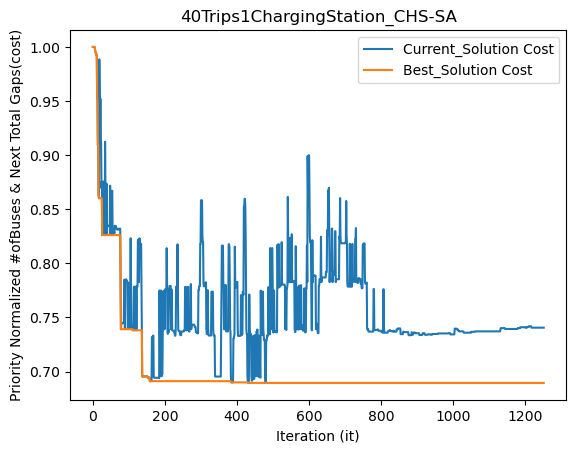

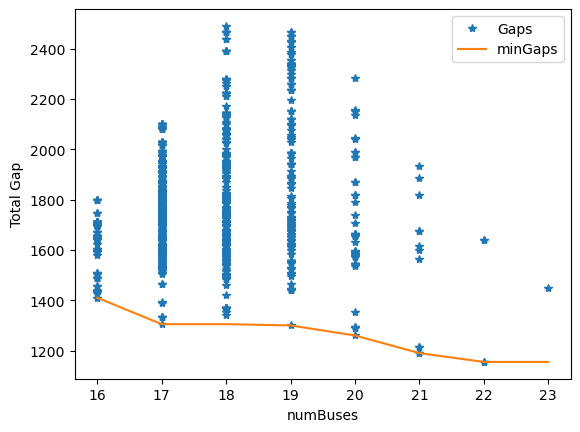

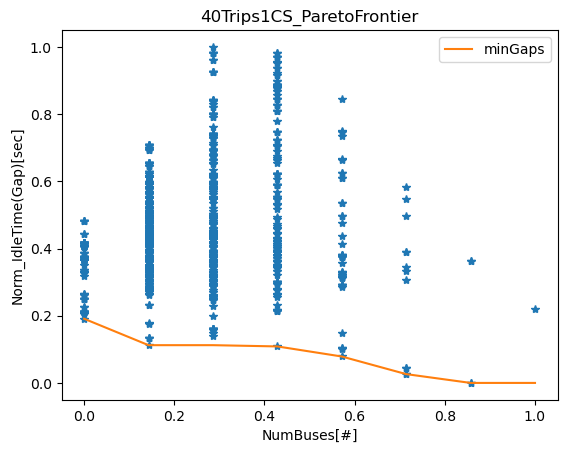

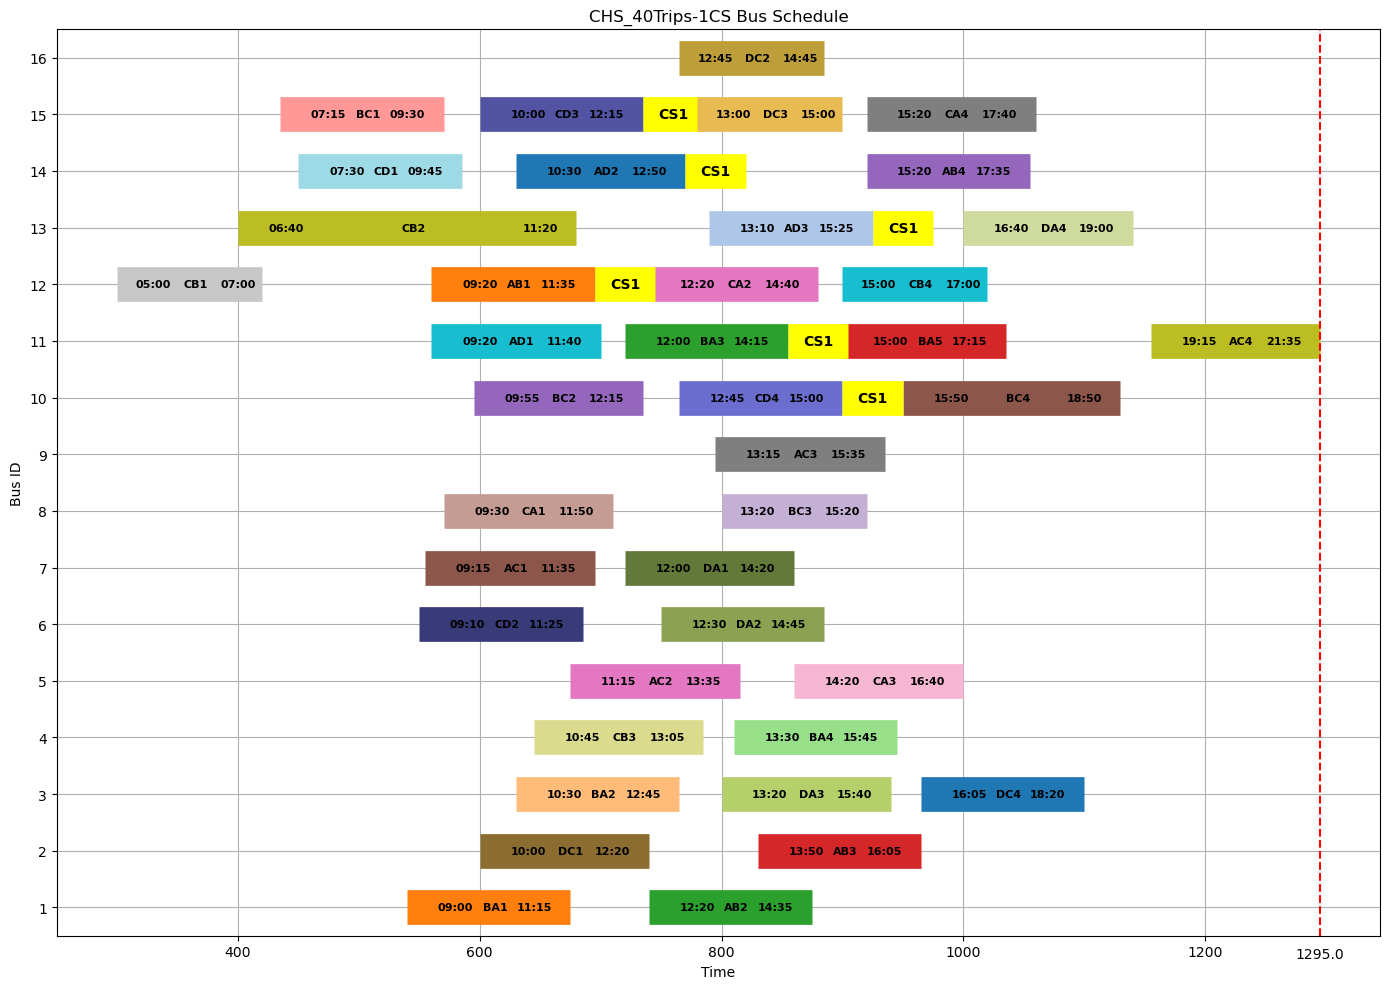

In [23]:
start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_40_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_40_1)
end_time = time.time()
g_T40CS1_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T40CS1_time)} seconds")
print(f"number of buses = {len(schedules_40_1)}")
print(schedules_40_1)
print('-'*100)
start_time = time.time()
print("starting simulated annealing....")
new_schedule_40_1, cost_40_1, cost_diffs_40_1, temp_40_1, it_40_1, costs_40_1, solution_spaces_40_1, best_costs_40_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T40CS1_time = (end_time-start_time)+g_T40CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T40CS1_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_40_1} with number of buses = {len(new_schedule_40_1)}")

fig1, ax1 = plt.subplots()
ax1.plot(range(it_40_1), costs_40_1, label="Current_Solution Cost")
ax1.plot(range(it_40_1), best_costs_40_1, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("40Trips1ChargingStation_CHS-SA")
ax1.legend(loc="upper right")
#plt.savefig("40Trips1CS.png")

FortyTrips_1cs_df = visualizeSolution(solution_spaces_40_1[1:], "40Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_40_1cs = visualizeResult(new_schedule_40_1, all_schs_1cs, "CHS_40Trips-1CS", cs_deadheads)

trips40_1_df = newdf_40_1cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips40_1_df['next_dep'] = trips40_1_df['next_dep'].fillna(0)
trips40_1_df['difference'] = trips40_1_df['next_dep'] - trips40_1_df['arr_time']
trips40_1_df['difference'] = trips40_1_df['difference'].apply(lambda x: 0 if x < 0 else x)
chs_40Trips1cs_IDLE_soln = trips40_1_df.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

chs_40Trips1cs_IDLE_soln.sort_values(['gapTime'], ascending=False)
print("Ending the process for 40Trips and 1 CS......")

dict_keys([41, 42, 43])
{41: {'name': 'CS1', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'}, 42: {'name': 'CS1a', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'}, 43: {'name': 'CS2b', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal B', 'arr_term': 'Terminal B'}}
{'Terminal A': {'CS1': 40, 'CS1a': 10, 'CS2b': 75, 'CS3c': 75, 'CS4d': 75}, 'Terminal B': {'CS1': 40, 'CS1a': 75, 'CS2b': 10, 'CS3c': 75, 'CS4d': 75}, 'Terminal C': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 10, 'CS4d': 75}, 'Terminal D': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 75, 'CS4d': 10}}
{(1, 2, 41): {'duration': 40}, (1, 3, 41): {'duration': 40}, (1, 4, 41): {'duration': 40}, (1, 7, 41): {'duration': 40}, (1, 8, 41): {'duration': 40}, (1, 11, 41): {'duration': 40}, (1, 15, 41): {'duration': 40}, (1, 16, 41): {'duration': 40}, (1, 19, 41): {'duration': 40}, (1, 20,

Sat Aug 16 01:16:43 2025
Time elapse to compute the solution = 0.5997276306152344 seconds
number of buses = 18
[[(0, 25), (25, 29), (29, 13, 41), (13, 11), (11, 40), (40, 8), (8, 0)], [(0, 26), (26, 2), (2, 4, 41), (4, 0)], [(0, 17), (17, 10), (10, 3, 41), (3, 36), (36, 0)], [(0, 12), (12, 14), (14, 16, 41), (16, 0)], [(0, 30), (30, 22), (22, 20, 41), (20, 0)], [(0, 5), (5, 33), (33, 24, 41), (24, 0)], [(0, 1), (1, 7), (7, 0)], [(0, 9), (9, 15), (15, 0)], [(0, 21), (21, 19), (19, 0)], [(0, 18), (18, 23), (23, 0)], [(0, 37), (37, 28), (28, 0)], [(0, 31), (31, 32), (32, 0)], [(0, 27), (27, 0)], [(0, 6), (6, 0)], [(0, 34), (34, 0)], [(0, 38), (38, 0)], [(0, 39), (39, 0)], [(0, 35), (35, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
insertion...
proposed solution = [[25, 29, 41, 13, 11, 40, 8, 0], [26, 2, 41, 4, 0], [17, 10, 41, 3, 36, 0], [12, 14, 41, 16, 0], [30, 22, 41, 20, 0], [5

diff neigh vs. current = -0.0
current temp = 86.00583546412885
----------------------------------------------------------------------------------------------------
Iteration 17...
swapping other CS...
proposed solution = [[12, 14, 0], [30, 22, 0], [5, 33, 0], [1, 7, 0], [9, 15, 0], [21, 19, 0], [31, 32, 0], [35, 0], [27, 28, 0], [34, 24, 0], [18, 16, 0], [13, 11, 0], [3, 36, 0], [39, 0], [25, 29, 41, 10, 40, 8, 0], [26, 2, 41, 4, 0], [37, 38, 41, 20, 0], [17, 6, 41, 23, 0]]
diff neigh vs. current = -0.0
current temp = 85.14577710948755
----------------------------------------------------------------------------------------------------
Iteration 18...
insertion...
proposed solution = [[12, 14, 0], [30, 22, 0], [5, 33, 0], [1, 7, 0], [9, 15, 0], [21, 19, 0], [31, 32, 0], [27, 28, 0], [34, 24, 0], [18, 16, 0], [13, 11, 0], [3, 36, 0], [39, 0], [25, 29, 41, 10, 35, 40, 8, 0], [26, 2, 41, 4, 0], [37, 38, 41, 20, 0], [17, 6, 41, 23, 0]]
diff neigh vs. current = 0.049906015037593954
current t

diff neigh vs. current = 0.001981516290726848
current temp = 71.05532272722922
----------------------------------------------------------------------------------------------------
Iteration 36...
insertion...
proposed solution = [[30, 22, 0], [5, 33, 0], [1, 7, 0], [9, 15, 0], [21, 19, 0], [27, 28, 0], [34, 24, 0], [18, 16, 0], [13, 11, 0], [12, 3, 43, 36, 0], [25, 29, 41, 39, 0], [26, 2, 0], [37, 35, 42, 40, 8, 0], [32, 4, 0], [14, 0], [17, 31, 38, 41, 20, 0], [6, 23, 0], [10, 0]]
diff neigh vs. current = -0.0
current temp = 70.34476949995693
----------------------------------------------------------------------------------------------------
Iteration 37...
insertion...
proposed solution = [[30, 22, 0], [5, 33, 0], [1, 7, 0], [9, 15, 0], [21, 19, 0], [27, 28, 0], [34, 24, 0], [18, 16, 0], [13, 11, 0], [12, 3, 43, 36, 0], [25, 29, 41, 39, 0], [26, 2, 0], [37, 35, 42, 40, 8, 0], [32, 4, 0], [17, 31, 38, 41, 20, 0], [6, 23, 0], [10, 0], [14, 0]]
diff neigh vs. current = -0.0
current temp

diff neigh vs. current = -0.0
current temp = 59.89560064661612
----------------------------------------------------------------------------------------------------
Iteration 53...
insertion...
proposed solution = [[5, 33, 0], [21, 19, 0], [27, 28, 0], [34, 24, 0], [18, 16, 0], [13, 11, 0], [26, 2, 0], [17, 31, 38, 0], [6, 23, 0], [37, 35, 0], [30, 14, 0], [9, 22, 0], [12, 3, 43, 36, 0], [25, 29, 41, 39, 4, 0], [10, 7, 40, 41, 8, 0], [1, 32, 41, 20, 8, 0], [15, 0]]
diff neigh vs. current = 0.0017543859649122862
current temp = 59.29664464014996
----------------------------------------------------------------------------------------------------
Iteration 54...
insertion...
proposed solution = [[5, 33, 0], [21, 19, 0], [27, 28, 0], [34, 24, 0], [18, 16, 0], [13, 11, 0], [26, 2, 0], [17, 31, 38, 0], [6, 23, 0], [37, 35, 0], [30, 14, 0], [9, 22, 0], [12, 3, 43, 36, 0], [25, 29, 41, 39, 4, 0], [10, 7, 40, 41, 8, 0], [1, 32, 41, 20, 8, 0], [15, 0]]
diff neigh vs. current = -0.0
current temp = 

proposed solution = [[5, 34, 0], [18, 16, 0], [13, 11, 0], [26, 2, 0], [17, 31, 38, 0], [6, 23, 0], [37, 35, 0], [30, 14, 41, 24, 0], [10, 7, 40, 0], [12, 3, 0], [39, 4, 0], [21, 19, 0], [9, 22, 43, 36, 0], [25, 29, 42, 33, 28, 0], [1, 32, 41, 20, 8, 0], [27, 15, 42, 8, 0]]
diff neigh vs. current = 0.04724310776942364
current temp = 49.98370298991991
----------------------------------------------------------------------------------------------------
Iteration 71...
swapping other CS...
proposed solution = [[5, 34, 0], [18, 16, 0], [13, 11, 0], [26, 2, 0], [17, 31, 38, 0], [6, 23, 0], [37, 35, 0], [10, 7, 40, 0], [12, 3, 0], [39, 4, 0], [21, 19, 0], [30, 14, 42, 24, 0], [9, 22, 43, 36, 0], [25, 29, 42, 33, 28, 0], [1, 32, 41, 20, 8, 0], [27, 15, 42, 8, 0]]
diff neigh vs. current = 0.0011278195488721998
current temp = 49.483865960020715
----------------------------------------------------------------------------------------------------
Iteration 72...
swapping other CS...
proposed soluti

diff neigh vs. current = -0.0
current temp = 42.133422215476834
----------------------------------------------------------------------------------------------------
Iteration 88...
swapping recharging task...
proposed solution = [[6, 23, 0], [37, 35, 0], [10, 7, 40, 0], [12, 3, 0], [39, 4, 0], [21, 19, 0], [5, 34, 0], [9, 22, 0], [18, 11, 0], [13, 0], [30, 14, 41, 24, 0], [25, 29, 0], [17, 27, 43, 15, 8, 0], [1, 32, 41, 20, 8, 0], [31, 38, 41, 36, 0], [26, 2, 43, 16, 0], [33, 0], [28, 0]]
diff neigh vs. current = -0.09561403508771926
current temp = 41.712087993322065
----------------------------------------------------------------------------------------------------
Iteration 89...
swapping recharging task...
proposed solution = [[6, 23, 0], [37, 35, 0], [10, 7, 40, 0], [12, 3, 0], [39, 4, 0], [21, 19, 0], [5, 34, 0], [9, 22, 0], [18, 11, 0], [13, 0], [30, 14, 0], [25, 29, 0], [17, 27, 43, 15, 8, 0], [1, 32, 41, 20, 8, 0], [31, 38, 41, 36, 0], [26, 2, 43, 16, 0], [33, 0], [28, 0], [24,

diff neigh vs. current = -0.0017543859649122862
current temp = 35.16092065580225
----------------------------------------------------------------------------------------------------
Iteration 106...
insertion...
proposed solution = [[10, 7, 40, 0], [21, 19, 0], [9, 22, 0], [18, 11, 0], [30, 14, 41, 4, 0], [13, 24, 0], [31, 38, 0], [12, 3, 0], [37, 35, 0], [25, 29, 41, 32, 20, 0], [1, 34, 42, 36, 0], [17, 27, 43, 15, 8, 0], [26, 2, 43, 16, 8, 0], [5, 33, 41, 28, 0], [6, 23, 0], [39, 0]]
diff neigh vs. current = -0.0
current temp = 34.80931144924423
----------------------------------------------------------------------------------------------------
Iteration 107...
insertion...
proposed solution = [[10, 7, 40, 0], [21, 19, 0], [9, 22, 0], [18, 11, 0], [30, 14, 41, 4, 0], [13, 24, 0], [31, 38, 0], [12, 3, 0], [37, 35, 0], [25, 29, 41, 32, 20, 0], [1, 34, 42, 36, 0], [17, 27, 43, 15, 8, 0], [26, 2, 43, 16, 8, 0], [6, 23, 0], [39, 0], [5, 33, 41, 28, 0]]
diff neigh vs. current = -0.00112781

diff neigh vs. current = -0.094235588972431
current temp = 29.638658739920828
----------------------------------------------------------------------------------------------------
Iteration 123...
swapping recharging task...
proposed solution = [[10, 7, 40, 0], [21, 19, 0], [9, 22, 0], [31, 38, 0], [12, 3, 0], [37, 35, 0], [6, 23, 0], [30, 14, 0], [25, 29, 0], [1, 34, 43, 36, 0], [17, 27, 43, 15, 8, 0], [26, 2, 43, 16, 8, 0], [5, 33, 0], [39, 24, 0], [13, 28, 0], [18, 11, 0], [32, 0], [20, 0], [4, 0]]
diff neigh vs. current = -0.04837092731829573
current temp = 29.34227215252162
----------------------------------------------------------------------------------------------------
Iteration 124...
swapping recharging task...
proposed solution = [[10, 7, 40, 0], [21, 19, 0], [9, 22, 0], [31, 38, 0], [12, 3, 0], [37, 35, 0], [6, 23, 0], [30, 14, 0], [25, 29, 0], [1, 34, 43, 36, 0], [17, 27, 43, 15, 8, 0], [26, 2, 0], [5, 33, 0], [39, 24, 0], [13, 28, 0], [18, 11, 0], [32, 0], [20, 0], [4, 0]

diff neigh vs. current = -0.04584489135460024
current temp = 24.983705645845284
----------------------------------------------------------------------------------------------------
Iteration 140...
insertion...
proposed solution = [[9, 22, 0], [12, 3, 0], [37, 35, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [39, 24, 0], [13, 28, 0], [18, 11, 0], [30, 14, 0], [10, 16, 0], [29, 34, 42, 4, 8, 0], [31, 38, 0], [25, 1, 41, 32, 20, 0], [17, 27, 43, 15, 40, 8, 0], [7, 0], [23, 0], [21, 19, 0]]
diff neigh vs. current = 0.04825473878871944
current temp = 24.73386858938683
----------------------------------------------------------------------------------------------------
Iteration 141...
swapping other CS...
proposed solution = [[9, 22, 0], [12, 3, 0], [37, 35, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [39, 24, 0], [13, 28, 0], [18, 11, 0], [30, 14, 0], [10, 16, 0], [31, 38, 0], [7, 0], [23, 0], [21, 19, 0], [29, 34, 42, 4, 8, 0], [25, 1, 41, 32, 20, 0], [17, 27, 43, 15, 40, 8, 0]]
diff neigh vs. cur

diff neigh vs. current = -0.0011962552011095529
current temp = 21.059844619672862
----------------------------------------------------------------------------------------------------
Iteration 157...
insertion...
proposed solution = [[12, 3, 0], [37, 35, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [13, 28, 0], [18, 11, 0], [30, 14, 0], [10, 16, 0], [31, 38, 0], [21, 19, 0], [29, 34, 0], [39, 4, 0], [23, 8, 0], [9, 22, 42, 24, 0], [25, 1, 41, 32, 20, 0], [17, 27, 43, 15, 40, 8, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 20.849246173476132
----------------------------------------------------------------------------------------------------
Iteration 158...
swapping other CS...
proposed solution = [[12, 3, 0], [37, 35, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [13, 28, 0], [18, 11, 0], [30, 14, 0], [10, 16, 0], [31, 38, 0], [21, 19, 0], [29, 34, 0], [39, 4, 0], [23, 8, 0], [7, 0], [9, 22, 42, 24, 0], [25, 1, 41, 32, 20, 0], [17, 27, 43, 15, 40, 8, 0]]
diff neigh vs. current = -0.0


diff neigh vs. current = -0.03727750809061481
current temp = 17.752252675876345
----------------------------------------------------------------------------------------------------
Iteration 174...
swapping recharging task...
proposed solution = [[12, 3, 0], [37, 35, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [13, 28, 0], [30, 14, 0], [10, 16, 0], [31, 38, 0], [21, 19, 0], [29, 34, 0], [39, 4, 0], [23, 8, 0], [9, 22, 0], [17, 27, 0], [32, 0], [24, 0], [18, 15, 0], [7, 40, 0], [20, 8, 0], [25, 1, 0], [11, 0]]
diff neigh vs. current = -0.0
current temp = 17.57473014911758
----------------------------------------------------------------------------------------------------
Iteration 175...
swapping other CS...
proposed solution = [[12, 3, 0], [37, 35, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [13, 28, 0], [30, 14, 0], [10, 16, 0], [31, 38, 0], [21, 19, 0], [29, 34, 0], [39, 4, 0], [23, 8, 0], [9, 22, 0], [17, 27, 0], [32, 0], [24, 0], [18, 15, 0], [7, 40, 0], [20, 8, 0], [25, 1, 0], [11, 0]]
di

diff neigh vs. current = 0.0018810679611650505
current temp = 14.96414056036156
----------------------------------------------------------------------------------------------------
Iteration 191...
insertion...
proposed solution = [[12, 3, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [13, 28, 0], [30, 14, 0], [10, 16, 0], [31, 38, 0], [21, 19, 0], [29, 34, 0], [39, 4, 0], [23, 8, 0], [9, 22, 0], [17, 27, 0], [18, 15, 0], [7, 40, 0], [20, 8, 0], [37, 11, 0], [32, 24, 0], [25, 1, 41, 35, 0]]
diff neigh vs. current = 0.03978559870550158
current temp = 14.814499154757945
----------------------------------------------------------------------------------------------------
Iteration 192...
insertion...
proposed solution = [[12, 3, 0], [6, 36, 0], [26, 2, 0], [5, 33, 0], [13, 28, 0], [30, 14, 0], [10, 16, 0], [31, 38, 0], [21, 19, 0], [29, 34, 0], [23, 8, 0], [9, 22, 0], [17, 27, 41, 4, 0], [18, 15, 0], [7, 40, 0], [20, 8, 0], [37, 11, 0], [32, 24, 0], [25, 1, 41, 35, 0], [39, 0]]
diff neigh vs. cu

diff neigh vs. current = -0.0
current temp = 12.613920430197117
----------------------------------------------------------------------------------------------------
Iteration 208...
swapping other CS...
proposed solution = [[12, 3, 0], [6, 36, 0], [26, 2, 0], [13, 28, 0], [10, 16, 0], [31, 38, 0], [29, 34, 0], [23, 8, 0], [18, 15, 0], [7, 40, 0], [20, 8, 0], [37, 11, 0], [32, 24, 0], [17, 27, 0], [9, 39, 0], [30, 14, 0], [21, 19, 0], [22, 0], [25, 1, 42, 35, 0], [5, 33, 41, 4, 0]]
diff neigh vs. current = -0.0
current temp = 12.487781225895146
----------------------------------------------------------------------------------------------------
Iteration 209...
insertion...
proposed solution = [[12, 3, 0], [6, 36, 0], [26, 2, 0], [13, 28, 0], [10, 16, 0], [31, 38, 0], [29, 34, 0], [23, 8, 0], [18, 15, 0], [7, 40, 0], [20, 8, 0], [37, 11, 0], [32, 24, 0], [17, 27, 0], [9, 39, 0], [30, 14, 0], [21, 19, 0], [25, 1, 42, 35, 0], [5, 33, 41, 4, 0], [22, 0]]
diff neigh vs. current = -0.0
curren

diff neigh vs. current = -0.0
current temp = 10.632818368521113
----------------------------------------------------------------------------------------------------
Iteration 225...
insertion...
proposed solution = [[6, 36, 0], [26, 2, 0], [13, 28, 0], [10, 16, 0], [31, 38, 0], [23, 8, 0], [18, 15, 0], [20, 8, 0], [32, 24, 0], [17, 27, 0], [9, 39, 0], [21, 19, 0], [5, 33, 0], [35, 0], [12, 22, 0], [25, 1, 41, 3, 0], [37, 11, 41, 40, 0], [29, 34, 42, 4, 0], [30, 7, 0], [14, 0]]
diff neigh vs. current = -0.0
current temp = 10.526490184835902
----------------------------------------------------------------------------------------------------
Iteration 226...
swapping recharging task...
proposed solution = [[6, 36, 0], [26, 2, 0], [13, 28, 0], [10, 16, 0], [31, 38, 0], [23, 8, 0], [18, 15, 0], [20, 8, 0], [32, 24, 0], [17, 27, 0], [9, 39, 0], [21, 19, 0], [5, 33, 0], [35, 0], [12, 22, 0], [25, 1, 0], [37, 11, 41, 40, 0], [29, 34, 42, 4, 0], [30, 7, 0], [14, 0], [3, 0]]
diff neigh vs. curre

diff neigh vs. current = -0.0
current temp = 8.962861870232462
----------------------------------------------------------------------------------------------------
Iteration 242...
swapping recharging task...
proposed solution = [[6, 36, 0], [13, 28, 0], [10, 16, 0], [31, 38, 0], [23, 8, 0], [18, 15, 0], [20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [5, 33, 0], [12, 22, 0], [30, 7, 0], [14, 0], [26, 2, 0], [1, 35, 0], [17, 27, 0], [25, 37, 41, 11, 40, 0], [3, 0], [29, 34, 0], [4, 0]]
diff neigh vs. current = -0.03849110032362457
current temp = 8.873233251530138
----------------------------------------------------------------------------------------------------
Iteration 243...
swapping other CS...
proposed solution = [[6, 36, 0], [13, 28, 0], [10, 16, 0], [31, 38, 0], [23, 8, 0], [18, 15, 0], [20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [5, 33, 0], [12, 22, 0], [30, 7, 0], [14, 0], [26, 2, 0], [1, 35, 0], [17, 27, 0], [3, 0], [29, 34, 0], [4, 0], [25, 37, 41, 11, 40, 0]]
diff 

diff neigh vs. current = -0.006654530744336529
current temp = 7.5551834067527865
----------------------------------------------------------------------------------------------------
Iteration 259...
insertion...
proposed solution = [[6, 36, 0], [10, 16, 0], [18, 15, 0], [20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [17, 27, 41, 3, 0], [29, 34, 0], [22, 4, 0], [11, 0], [12, 14, 41, 40, 8, 0], [13, 23, 0], [25, 37, 41, 28, 0], [5, 33, 0], [31, 38, 0]]
diff neigh vs. current = -0.0
current temp = 7.479631572685259
----------------------------------------------------------------------------------------------------
Iteration 260...
swapping other CS...
proposed solution = [[6, 36, 0], [10, 16, 0], [18, 15, 0], [20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [29, 34, 0], [22, 4, 0], [11, 0], [13, 23, 0], [5, 33, 0], [31, 38, 0], [17, 27, 41, 3, 0], [12, 14, 41, 40, 8, 0], [25, 37, 41, 28, 0]]
diff neigh vs. current

diff neigh vs. current = -0.004975728155339754
current temp = 6.304904523214554
----------------------------------------------------------------------------------------------------
Iteration 277...
swapping recharging task...
proposed solution = [[10, 16, 0], [20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [29, 34, 0], [22, 4, 0], [13, 23, 0], [31, 38, 0], [5, 33, 0], [6, 28, 0], [25, 37, 41, 11, 0], [17, 27, 0], [12, 14, 43, 40, 8, 0], [18, 15, 41, 36, 0], [3, 0]]
diff neigh vs. current = -0.03849110032362457
current temp = 6.2418554779824085
----------------------------------------------------------------------------------------------------
Iteration 278...
insertion...
proposed solution = [[10, 16, 0], [20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [29, 34, 0], [22, 4, 0], [13, 23, 0], [31, 38, 0], [5, 33, 0], [6, 28, 0], [25, 37, 41, 11, 0], [17, 27, 41, 40, 0], [18, 15, 41, 36, 0], [12, 3, 41, 8, 0], [14,

diff neigh vs. current = -0.0
current temp = 5.314676352779239
----------------------------------------------------------------------------------------------------
Iteration 294...
insertion...
proposed solution = [[20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [29, 34, 0], [22, 4, 0], [13, 23, 0], [5, 33, 0], [12, 3, 0], [18, 15, 0], [6, 28, 0], [14, 40, 0], [17, 27, 41, 16, 0], [31, 38, 42, 36, 0], [25, 37, 41, 11, 0], [10, 0]]
diff neigh vs. current = 0.0003640776699028736
current temp = 5.261529589251447
----------------------------------------------------------------------------------------------------
Iteration 295...
insertion...
proposed solution = [[20, 8, 0], [32, 24, 0], [9, 39, 0], [21, 19, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [29, 34, 0], [22, 4, 0], [13, 23, 0], [5, 33, 0], [12, 3, 0], [18, 15, 0], [6, 28, 0], [14, 40, 0], [17, 27, 41, 16, 0], [31, 38, 42, 36, 0], [25, 37, 41, 11, 0], [10, 0]]
diff neigh vs. current = -0.0
current

diff neigh vs. current = -0.0006067961165048263
current temp = 4.4799702566137745
----------------------------------------------------------------------------------------------------
Iteration 311...
swapping other CS...
proposed solution = [[9, 39, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [29, 34, 0], [22, 4, 0], [13, 23, 0], [18, 15, 0], [14, 40, 0], [10, 28, 0], [21, 19, 0], [12, 3, 0], [6, 16, 0], [32, 24, 0], [25, 37, 0], [11, 0], [31, 38, 0], [5, 33, 42, 36, 0], [17, 27, 42, 20, 8, 0]]
diff neigh vs. current = -0.0
current temp = 4.4351705540476365
----------------------------------------------------------------------------------------------------
Iteration 312...
swapping other CS...
proposed solution = [[9, 39, 0], [30, 7, 0], [26, 2, 0], [1, 35, 0], [29, 34, 0], [22, 4, 0], [13, 23, 0], [18, 15, 0], [14, 40, 0], [10, 28, 0], [21, 19, 0], [12, 3, 0], [6, 16, 0], [32, 24, 0], [25, 37, 0], [11, 0], [31, 38, 0], [5, 33, 43, 36, 0], [17, 27, 43, 20, 8, 0]]
diff neigh vs. current = -

diff neigh vs. current = 0.006735436893203883
current temp = 3.7763604343750234
----------------------------------------------------------------------------------------------------
Iteration 328...
insertion...
proposed solution = [[26, 2, 0], [1, 35, 0], [13, 23, 0], [9, 14, 0], [10, 28, 0], [21, 19, 0], [12, 3, 0], [6, 16, 0], [32, 24, 0], [25, 37, 0], [18, 11, 0], [31, 38, 0], [5, 33, 41, 36, 0], [17, 27, 0], [29, 34, 0], [30, 22, 0], [7, 0], [39, 20, 0], [40, 0], [4, 8, 0], [15, 0]]
diff neigh vs. current = -0.006735436893203883
current temp = 3.7385968300312733
----------------------------------------------------------------------------------------------------
Iteration 329...
swapping recharging task...
proposed solution = [[26, 2, 0], [1, 35, 0], [13, 23, 0], [9, 14, 0], [10, 28, 0], [21, 19, 0], [12, 3, 0], [6, 16, 0], [32, 24, 0], [25, 37, 0], [18, 11, 0], [31, 38, 0], [5, 33, 0], [17, 27, 0], [29, 34, 41, 36, 0], [30, 22, 0], [7, 0], [39, 20, 0], [40, 0], [4, 8, 0], [15, 0]]


diff neigh vs. current = -0.0032766990291261955
current temp = 3.183257323920795
----------------------------------------------------------------------------------------------------
Iteration 345...
insertion...
proposed solution = [[1, 35, 0], [13, 23, 0], [9, 14, 0], [10, 28, 0], [21, 19, 0], [12, 3, 0], [6, 16, 0], [32, 24, 0], [18, 11, 0], [5, 33, 0], [26, 2, 0], [31, 38, 0], [17, 39, 41, 20, 0], [25, 37, 41, 7, 0], [29, 34, 42, 4, 8, 0], [30, 22, 43, 40, 0], [27, 15, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 3.1514247506815867
----------------------------------------------------------------------------------------------------
Iteration 346...
insertion...
proposed solution = [[1, 35, 0], [9, 14, 0], [10, 28, 0], [21, 19, 0], [12, 3, 0], [6, 16, 0], [32, 24, 0], [18, 11, 0], [5, 33, 0], [26, 2, 0], [31, 38, 0], [17, 13, 42, 39, 20, 0], [25, 37, 41, 7, 0], [29, 34, 42, 4, 8, 0], [30, 22, 43, 40, 0], [27, 15, 41, 36, 0], [23, 0]]
diff neigh vs. current = 0.005582524271

diff neigh vs. current = -0.07346278317152088
current temp = 2.6833050939885674
----------------------------------------------------------------------------------------------------
Iteration 362...
insertion...
proposed solution = [[10, 28, 0], [21, 19, 0], [12, 3, 0], [32, 24, 0], [18, 11, 0], [5, 33, 0], [27, 15, 0], [6, 23, 0], [26, 2, 43, 16, 0], [31, 38, 43, 36, 0], [17, 13, 42, 39, 4, 8, 0], [25, 37, 0], [29, 34, 0], [30, 22, 42, 40, 0], [9, 14, 0], [1, 7, 0], [20, 0], [35, 8, 0]]
diff neigh vs. current = 0.04031148867313905
current temp = 2.656472043048682
----------------------------------------------------------------------------------------------------
Iteration 363...
insertion...
proposed solution = [[10, 28, 0], [21, 19, 0], [12, 3, 0], [32, 24, 0], [18, 11, 0], [5, 33, 0], [27, 15, 0], [6, 23, 0], [26, 2, 43, 16, 0], [31, 38, 43, 36, 0], [25, 37, 0], [29, 34, 0], [30, 22, 42, 40, 0], [9, 14, 41, 4, 0], [1, 7, 41, 8, 0], [39, 20, 0], [17, 13, 42, 35, 8, 0]]
diff neigh vs. 

diff neigh vs. current = -0.005380258899676416
current temp = 2.2168624768315546
----------------------------------------------------------------------------------------------------
Iteration 381...
swapping recharging task...
proposed solution = [[10, 28, 0], [21, 19, 0], [12, 3, 0], [32, 24, 0], [18, 11, 0], [5, 33, 41, 36, 0], [27, 15, 0], [6, 23, 0], [29, 34, 0], [26, 2, 0], [9, 14, 41, 4, 8, 0], [17, 13, 42, 35, 0], [31, 38, 0], [30, 22, 41, 40, 0], [1, 7, 0], [25, 37, 41, 39, 20, 8, 0], [16, 0]]
diff neigh vs. current = -0.04164644012944996
current temp = 2.194693852063239
----------------------------------------------------------------------------------------------------
Iteration 382...
swapping other CS...
proposed solution = [[10, 28, 0], [21, 19, 0], [12, 3, 0], [32, 24, 0], [18, 11, 0], [27, 15, 0], [6, 23, 0], [29, 34, 0], [26, 2, 0], [31, 38, 0], [1, 7, 0], [16, 0], [5, 33, 41, 36, 0], [9, 14, 42, 4, 8, 0], [17, 13, 42, 35, 0], [30, 22, 41, 40, 0], [25, 37, 41, 39, 20, 8,

diff neigh vs. current = -0.0
current temp = 1.868689135513392
----------------------------------------------------------------------------------------------------
Iteration 398...
insertion...
proposed solution = [[18, 11, 0], [6, 23, 0], [31, 38, 0], [1, 7, 0], [10, 4, 0], [21, 19, 0], [29, 34, 0], [9, 14, 41, 28, 0], [26, 2, 43, 16, 0], [5, 33, 41, 36, 0], [17, 13, 42, 35, 0], [30, 22, 43, 40, 0], [25, 37, 41, 39, 20, 8, 0], [32, 24, 41, 8, 0], [12, 3, 0], [27, 15, 0]]
diff neigh vs. current = -0.0
current temp = 1.8500022441582582
----------------------------------------------------------------------------------------------------
Iteration 399...
swapping recharging task...
proposed solution = [[18, 11, 0], [6, 23, 0], [31, 38, 0], [1, 7, 0], [10, 4, 0], [21, 19, 0], [29, 34, 0], [9, 14, 0], [26, 2, 43, 16, 0], [5, 33, 41, 36, 0], [17, 13, 42, 35, 0], [30, 22, 43, 40, 0], [25, 37, 41, 39, 20, 8, 0], [32, 24, 41, 8, 0], [12, 3, 0], [27, 15, 0], [28, 0]]
diff neigh vs. current = -0.0

diff neigh vs. current = -0.12593042071197402
current temp = 1.5751987873315083
----------------------------------------------------------------------------------------------------
Iteration 415...
insertion...
proposed solution = [[18, 11, 0], [6, 23, 0], [1, 7, 0], [10, 4, 0], [21, 19, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [22, 16, 0], [30, 39, 0], [25, 37, 41, 28, 0], [31, 38, 41, 20, 0], [27, 15, 0], [5, 33, 43, 36, 0], [17, 13, 0], [32, 24, 43, 8, 0], [40, 0], [35, 8, 0]]
diff neigh vs. current = 0.04259708737864076
current temp = 1.5594467994581933
----------------------------------------------------------------------------------------------------
Iteration 416...
swapping other CS...
proposed solution = [[18, 11, 0], [6, 23, 0], [1, 7, 0], [10, 4, 0], [21, 19, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [22, 16, 0], [30, 39, 0], [27, 15, 0], [17, 13, 0], [40, 0], [35, 8, 0], [25, 37, 41, 28, 0], [31, 38, 41, 20, 0], [5, 33, 41, 36, 0], [32, 24, 43, 8, 0]]

diff neigh vs. current = 0.0015776699029126373
current temp = 1.3278030960077105
----------------------------------------------------------------------------------------------------
Iteration 432...
swapping other CS...
proposed solution = [[1, 7, 0], [10, 4, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [22, 16, 0], [30, 39, 0], [27, 15, 0], [32, 24, 0], [5, 33, 0], [18, 11, 0], [6, 23, 0], [21, 35, 42, 40, 8, 0], [25, 37, 43, 28, 0], [17, 31, 38, 41, 20, 0], [13, 19, 42, 36, 0]]
diff neigh vs. current = -0.0
current temp = 1.3145250650476334
----------------------------------------------------------------------------------------------------
Iteration 433...
swapping other CS...
proposed solution = [[1, 7, 0], [10, 4, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [22, 16, 0], [30, 39, 0], [27, 15, 0], [32, 24, 0], [5, 33, 0], [18, 11, 0], [6, 23, 0], [21, 35, 42, 40, 8, 0], [25, 37, 42, 28, 0], [17, 31, 38, 41, 20, 0], [13, 19, 42, 36, 0]]
diff neigh vs. current = -0.0
c

diff neigh vs. current = -0.0
current temp = 1.1192625819338042
----------------------------------------------------------------------------------------------------
Iteration 449...
insertion...
proposed solution = [[10, 4, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [30, 39, 0], [27, 15, 0], [32, 24, 0], [18, 11, 0], [6, 23, 0], [5, 33, 0], [25, 37, 41, 7, 0], [16, 0], [1, 22, 42, 28, 0], [21, 35, 42, 40, 8, 0], [17, 31, 38, 41, 20, 0], [13, 19, 42, 36, 0]]
diff neigh vs. current = 0.03984627831715204
current temp = 1.1080699561144662
----------------------------------------------------------------------------------------------------
Iteration 450...
insertion...
proposed solution = [[10, 4, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [30, 39, 0], [27, 15, 0], [32, 24, 0], [18, 11, 0], [6, 23, 0], [5, 33, 41, 16, 0], [25, 37, 41, 7, 0], [1, 22, 42, 28, 0], [21, 35, 42, 40, 8, 0], [17, 31, 38, 41, 20, 0], [13, 19, 42, 36, 0]]
diff neigh vs. current = 0.041666666666666

diff neigh vs. current = -0.04388888888888898
current temp = 0.9340400272999158
----------------------------------------------------------------------------------------------------
Iteration 467...
insertion...
proposed solution = [[10, 4, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [27, 15, 0], [32, 24, 0], [18, 11, 0], [6, 23, 0], [13, 19, 0], [30, 28, 0], [17, 16, 0], [21, 35, 0], [20, 0], [1, 22, 0], [5, 33, 42, 36, 0], [25, 37, 41, 7, 0], [31, 38, 42, 40, 8, 0], [39, 8, 0]]
diff neigh vs. current = 0.04388888888888898
current temp = 0.9246996270269165
----------------------------------------------------------------------------------------------------
Iteration 468...
swapping recharging task...
proposed solution = [[10, 4, 0], [29, 34, 0], [9, 14, 0], [26, 2, 0], [12, 3, 0], [27, 15, 0], [32, 24, 0], [18, 11, 0], [6, 23, 0], [13, 19, 0], [30, 28, 0], [17, 16, 0], [21, 35, 41, 36, 0], [20, 0], [1, 22, 0], [5, 33, 0], [25, 37, 41, 7, 0], [31, 38, 42, 40, 8, 0], [39, 8, 0]]


diff neigh vs. current = -0.0
current temp = 0.7873426833606011
----------------------------------------------------------------------------------------------------
Iteration 484...
swapping recharging task...
proposed solution = [[9, 14, 0], [26, 2, 0], [12, 3, 0], [27, 15, 0], [18, 11, 0], [6, 23, 0], [13, 19, 0], [30, 28, 0], [38, 20, 0], [1, 22, 0], [32, 40, 0], [31, 7, 0], [25, 37, 0], [29, 34, 0], [5, 33, 0], [24, 0], [8, 0], [17, 10, 0], [21, 35, 42, 36, 0], [39, 4, 43, 8, 0], [16, 0]]
diff neigh vs. current = -0.03669444444444436
current temp = 0.7794692565269951
----------------------------------------------------------------------------------------------------
Iteration 485...
swapping other CS...
proposed solution = [[9, 14, 0], [26, 2, 0], [12, 3, 0], [27, 15, 0], [18, 11, 0], [6, 23, 0], [13, 19, 0], [30, 28, 0], [38, 20, 0], [1, 22, 0], [32, 40, 0], [31, 7, 0], [25, 37, 0], [29, 34, 0], [5, 33, 0], [24, 0], [8, 0], [17, 10, 0], [16, 0], [21, 35, 42, 36, 0], [39, 4, 41, 8,

diff neigh vs. current = -0.0
current temp = 0.6636851557994549
----------------------------------------------------------------------------------------------------
Iteration 501...
swapping recharging task...
proposed solution = [[12, 3, 0], [18, 11, 0], [13, 19, 0], [38, 20, 0], [1, 22, 0], [31, 7, 0], [25, 37, 0], [29, 34, 0], [39, 4, 0], [5, 33, 0], [9, 23, 0], [2, 16, 0], [26, 32, 41, 40, 8, 0], [30, 14, 41, 28, 0], [21, 35, 42, 36, 0], [6, 0], [17, 27, 0], [10, 24, 0], [15, 0]]
diff neigh vs. current = -0.03847222222222224
current temp = 0.6570483042414603
----------------------------------------------------------------------------------------------------
Iteration 502...
swapping other CS...
proposed solution = [[12, 3, 0], [18, 11, 0], [13, 19, 0], [38, 20, 0], [1, 22, 0], [31, 7, 0], [25, 37, 0], [29, 34, 0], [39, 4, 0], [5, 33, 0], [9, 23, 0], [2, 16, 0], [6, 0], [17, 27, 0], [10, 24, 0], [15, 0], [26, 32, 41, 40, 8, 0], [30, 14, 42, 28, 0], [21, 35, 41, 36, 0]]
diff neigh vs

diff neigh vs. current = 5.5555555555586444e-05
current temp = 0.5538543957847903
----------------------------------------------------------------------------------------------------
Iteration 519...
swapping recharging task...
proposed solution = [[12, 3, 0], [18, 11, 0], [13, 19, 0], [38, 20, 0], [1, 22, 0], [31, 7, 0], [25, 37, 0], [29, 34, 0], [39, 4, 0], [17, 27, 41, 23, 0], [10, 24, 0], [30, 14, 0], [21, 35, 0], [5, 33, 41, 28, 0], [9, 15, 42, 40, 8, 0], [26, 32, 41, 36, 0], [6, 16, 0], [2, 0]]
diff neigh vs. current = -0.0
current temp = 0.5483158518269424
----------------------------------------------------------------------------------------------------
Iteration 520...
insertion...
proposed solution = [[12, 3, 0], [18, 11, 0], [13, 19, 0], [37, 38, 41, 20, 0], [1, 22, 0], [31, 7, 0], [29, 34, 0], [39, 4, 0], [17, 27, 41, 23, 0], [10, 24, 0], [30, 14, 0], [21, 35, 0], [5, 33, 41, 28, 0], [9, 15, 42, 40, 8, 0], [26, 32, 41, 36, 0], [6, 16, 0], [25, 2, 0]]
diff neigh vs. current

diff neigh vs. current = -0.0
current temp = 0.46686779305255655
----------------------------------------------------------------------------------------------------
Iteration 536...
swapping other CS...
proposed solution = [[18, 11, 0], [13, 19, 0], [1, 22, 0], [31, 7, 0], [29, 34, 0], [39, 4, 0], [10, 24, 0], [30, 14, 0], [6, 16, 0], [37, 38, 0], [9, 15, 0], [26, 32, 0], [20, 0], [25, 2, 0], [28, 0], [12, 3, 0], [17, 27, 43, 23, 0], [21, 35, 42, 40, 8, 0], [5, 33, 42, 36, 0]]
diff neigh vs. current = -0.0
current temp = 0.462199115122031
----------------------------------------------------------------------------------------------------
Iteration 537...
insertion...
proposed solution = [[18, 11, 0], [13, 19, 0], [1, 22, 0], [31, 7, 0], [29, 34, 0], [39, 4, 0], [10, 24, 0], [30, 14, 0], [6, 16, 0], [37, 38, 0], [9, 15, 0], [32, 20, 0], [25, 2, 0], [26, 28, 0], [12, 3, 0], [17, 27, 43, 23, 0], [21, 35, 42, 40, 8, 0], [5, 33, 42, 36, 0]]
diff neigh vs. current = 0.042749999999999955
cur

diff neigh vs. current = -0.000888888888888939
current temp = 0.3935430283638283
----------------------------------------------------------------------------------------------------
Iteration 553...
insertion...
proposed solution = [[13, 19, 0], [1, 22, 0], [31, 7, 0], [29, 34, 0], [10, 24, 0], [6, 36, 0], [37, 38, 0], [12, 3, 0], [5, 15, 0], [21, 35, 0], [2, 16, 0], [11, 0], [30, 14, 42, 28, 0], [18, 32, 41, 20, 0], [25, 9, 41, 39, 40, 8, 0], [17, 27, 41, 23, 0], [26, 33, 41, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.38960759808019
----------------------------------------------------------------------------------------------------
Iteration 554...
swapping recharging task...
proposed solution = [[13, 19, 0], [1, 22, 0], [31, 7, 0], [29, 34, 0], [10, 24, 0], [6, 36, 0], [37, 38, 0], [12, 3, 0], [5, 15, 0], [21, 35, 0], [2, 16, 0], [11, 0], [30, 14, 42, 28, 0], [18, 32, 0], [25, 9, 41, 39, 40, 8, 0], [17, 27, 41, 23, 0], [26, 33, 41, 4, 0], [20, 0]]
diff neigh vs. current = 

diff neigh vs. current = -0.003472222222222321
current temp = 0.3284170728923567
----------------------------------------------------------------------------------------------------
Iteration 571...
insertion...
proposed solution = [[31, 7, 0], [6, 36, 0], [37, 38, 0], [12, 3, 0], [5, 15, 0], [21, 35, 0], [1, 2, 43, 16, 0], [18, 32, 0], [29, 34, 0], [30, 14, 0], [25, 9, 42, 39, 40, 8, 0], [17, 27, 42, 23, 0], [26, 33, 41, 4, 0], [10, 28, 0], [22, 24, 0], [13, 19, 0], [11, 20, 0]]
diff neigh vs. current = -0.0
current temp = 0.32513290216343316
----------------------------------------------------------------------------------------------------
Iteration 572...
insertion...
proposed solution = [[31, 7, 0], [6, 36, 0], [37, 38, 0], [12, 3, 0], [5, 15, 0], [21, 35, 0], [1, 2, 43, 16, 0], [18, 32, 0], [29, 34, 0], [30, 14, 0], [25, 9, 42, 39, 40, 8, 0], [17, 27, 42, 23, 0], [10, 28, 0], [22, 24, 0], [13, 19, 0], [11, 20, 0], [26, 33, 41, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0

diff neigh vs. current = -0.0
current temp = 0.276836936185685
----------------------------------------------------------------------------------------------------
Iteration 588...
swapping recharging task...
proposed solution = [[31, 7, 0], [6, 36, 0], [37, 38, 0], [12, 3, 0], [21, 35, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [30, 22, 0], [13, 19, 0], [11, 20, 0], [5, 14, 41, 24, 0], [1, 2, 43, 16, 0], [25, 9, 43, 39, 40, 8, 0], [17, 27, 43, 23, 0], [26, 33, 0], [15, 0], [4, 0]]
diff neigh vs. current = -0.038249999999999784
current temp = 0.27406856682382813
----------------------------------------------------------------------------------------------------
Iteration 589...
swapping other CS...
proposed solution = [[31, 7, 0], [6, 36, 0], [37, 38, 0], [12, 3, 0], [21, 35, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [30, 22, 0], [13, 19, 0], [11, 20, 0], [26, 33, 0], [15, 0], [4, 0], [5, 14, 41, 24, 0], [1, 2, 43, 16, 0], [25, 9, 42, 39, 40, 8, 0], [17, 27, 43, 23, 0]]
diff neigh vs.

diff neigh vs. current = -0.0017499999999999183
current temp = 0.23335781103498363
----------------------------------------------------------------------------------------------------
Iteration 605...
swapping recharging task...
proposed solution = [[6, 36, 0], [12, 3, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [30, 22, 0], [13, 19, 0], [11, 20, 0], [26, 33, 0], [31, 4, 0], [21, 35, 0], [1, 23, 0], [7, 0], [37, 15, 0], [38, 0], [17, 27, 0], [2, 16, 0], [5, 14, 0], [25, 9, 43, 39, 40, 8, 0], [24, 0]]
diff neigh vs. current = -0.038138888888889055
current temp = 0.23102423292463378
----------------------------------------------------------------------------------------------------
Iteration 606...
insertion...
proposed solution = [[6, 36, 0], [12, 3, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [30, 22, 0], [13, 19, 0], [11, 20, 0], [26, 33, 0], [31, 4, 0], [21, 35, 0], [1, 23, 0], [37, 15, 0], [38, 0], [17, 27, 0], [2, 16, 0], [5, 14, 0], [25, 9, 43, 39, 40, 8, 0], [24, 0], [7, 0]]
diff n

diff neigh vs. current = -0.0
current temp = 0.19670737843491204
----------------------------------------------------------------------------------------------------
Iteration 622...
swapping recharging task...
proposed solution = [[6, 36, 0], [12, 3, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [26, 33, 0], [31, 4, 0], [21, 35, 0], [1, 23, 0], [2, 16, 0], [39, 24, 0], [37, 7, 0], [5, 38, 0], [13, 11, 0], [22, 0], [17, 27, 43, 15, 40, 8, 0], [25, 9, 42, 19, 0], [30, 14, 0], [20, 0]]
diff neigh vs. current = -0.03747222222222213
current temp = 0.1947403046505629
----------------------------------------------------------------------------------------------------
Iteration 623...
swapping recharging task...
proposed solution = [[6, 36, 0], [12, 3, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [26, 33, 0], [31, 4, 0], [21, 35, 0], [1, 23, 0], [2, 16, 0], [39, 24, 0], [37, 7, 0], [5, 38, 0], [13, 11, 0], [22, 0], [17, 27, 0], [25, 9, 42, 19, 0], [30, 15, 42, 40, 8, 0], [20, 0], [14, 0]]
diff nei

diff neigh vs. current = -0.0
current temp = 0.16581314574010533
----------------------------------------------------------------------------------------------------
Iteration 639...
insertion...
proposed solution = [[6, 36, 0], [12, 3, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [26, 33, 0], [31, 4, 0], [21, 35, 0], [1, 23, 0], [2, 16, 0], [39, 24, 0], [37, 7, 0], [17, 27, 0], [11, 20, 0], [13, 19, 0], [30, 15, 0], [25, 9, 41, 22, 0], [5, 38, 43, 40, 8, 0], [14, 0]]
diff neigh vs. current = -0.0
current temp = 0.16415501428270426
----------------------------------------------------------------------------------------------------
Iteration 640...
insertion...
proposed solution = [[6, 36, 0], [12, 3, 0], [18, 32, 0], [29, 34, 0], [10, 28, 0], [26, 33, 0], [31, 4, 0], [21, 35, 0], [1, 23, 0], [2, 16, 0], [39, 24, 0], [37, 7, 0], [11, 20, 0], [13, 19, 0], [30, 15, 0], [25, 9, 41, 22, 0], [5, 38, 43, 40, 8, 0], [17, 14, 0], [27, 0]]
diff neigh vs. current = -0.0
current temp = 0.16251346413

diff neigh vs. current = -0.0033888888888888857
current temp = 0.13837335194944683
----------------------------------------------------------------------------------------------------
Iteration 657...
swapping other CS...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [1, 23, 0], [39, 24, 0], [37, 7, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [5, 38, 0], [27, 3, 0], [12, 22, 0], [6, 0], [29, 34, 0], [25, 9, 43, 35, 0], [21, 2, 43, 16, 0], [13, 19, 41, 40, 8, 0], [26, 33, 43, 36, 0]]
diff neigh vs. current = -0.0
current temp = 0.13698961842995236
----------------------------------------------------------------------------------------------------
Iteration 658...
insertion...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [1, 23, 0], [39, 24, 0], [37, 7, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [12, 22, 0], [6, 0], [29, 34, 0], [25, 9, 43, 35, 0], [21, 2, 43, 16, 0], [13, 19, 41, 40, 8, 0], [26, 33, 43, 36, 0], [5, 38, 0]]
diff neigh vs. current = -

diff neigh vs. current = -0.0
current temp = 0.11664087517150475
----------------------------------------------------------------------------------------------------
Iteration 674...
swapping recharging task...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [1, 23, 0], [39, 24, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [6, 0], [13, 19, 0], [29, 34, 0], [26, 33, 0], [5, 38, 41, 36, 0], [12, 35, 0], [25, 9, 41, 22, 40, 0], [21, 2, 43, 16, 8, 0], [37, 7, 0]]
diff neigh vs. current = -0.0
current temp = 0.1154744664197897
----------------------------------------------------------------------------------------------------
Iteration 675...
swapping other CS...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [1, 23, 0], [39, 24, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [6, 0], [13, 19, 0], [29, 34, 0], [26, 33, 0], [12, 35, 0], [37, 7, 0], [5, 38, 43, 36, 0], [25, 9, 41, 22, 40, 0], [21, 2, 43, 16, 8, 0]]
diff neigh vs. current = -0.0012222222

diff neigh vs. current = -0.0
current temp = 0.09832163179616418
----------------------------------------------------------------------------------------------------
Iteration 691...
swapping other CS...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [13, 19, 0], [29, 34, 0], [26, 33, 0], [37, 7, 0], [1, 22, 0], [39, 0], [6, 16, 41, 8, 0], [5, 38, 42, 40, 8, 0], [25, 9, 42, 23, 0], [21, 2, 41, 24, 0], [12, 35, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 0.09733841547820254
----------------------------------------------------------------------------------------------------
Iteration 692...
insertion...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [13, 19, 0], [29, 34, 0], [26, 33, 0], [37, 7, 0], [1, 22, 0], [6, 16, 41, 8, 0], [5, 38, 42, 40, 8, 0], [25, 9, 42, 23, 0], [21, 2, 41, 24, 0], [12, 35, 41, 36, 0], [39, 0]]
diff neigh vs. current = -0.0


diff neigh vs. current = -0.0
current temp = 0.08287955028497727
----------------------------------------------------------------------------------------------------
Iteration 708...
insertion...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [13, 19, 0], [29, 34, 0], [37, 7, 0], [1, 39, 0], [5, 38, 42, 40, 8, 0], [25, 9, 42, 23, 0], [21, 2, 43, 24, 0], [12, 35, 41, 36, 0], [22, 16, 41, 8, 0], [26, 33, 0], [6, 0]]
diff neigh vs. current = -0.0
current temp = 0.0820507547821275
----------------------------------------------------------------------------------------------------
Iteration 709...
swapping other CS...
proposed solution = [[18, 32, 0], [10, 28, 0], [31, 4, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [13, 19, 0], [29, 34, 0], [37, 7, 0], [1, 39, 0], [26, 33, 0], [6, 0], [5, 38, 41, 40, 8, 0], [25, 9, 42, 23, 0], [21, 2, 41, 24, 0], [12, 35, 42, 36, 0], [22, 16, 43, 8, 0]]
diff neigh vs. current = -0.0
c

diff neigh vs. current = -0.0
current temp = 0.06986275278344249
----------------------------------------------------------------------------------------------------
Iteration 725...
insertion...
proposed solution = [[10, 28, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [13, 19, 0], [29, 34, 0], [1, 39, 0], [37, 7, 0], [18, 32, 0], [26, 33, 0], [6, 4, 0], [5, 38, 43, 40, 8, 0], [25, 9, 41, 23, 0], [21, 2, 43, 24, 0], [12, 35, 41, 36, 0], [22, 16, 41, 8, 0], [31, 0]]
diff neigh vs. current = 0.001777777777777878
current temp = 0.06916412525560807
----------------------------------------------------------------------------------------------------
Iteration 726...
insertion...
proposed solution = [[10, 28, 0], [11, 20, 0], [30, 15, 0], [17, 14, 0], [27, 3, 0], [13, 19, 0], [29, 34, 0], [1, 39, 0], [37, 7, 0], [18, 32, 0], [26, 33, 0], [6, 4, 0], [5, 38, 43, 40, 8, 0], [25, 9, 41, 23, 0], [21, 2, 43, 24, 0], [12, 35, 41, 36, 0], [22, 16, 41, 8, 0], [31, 0]]
diff neigh vs. current

diff neigh vs. current = -0.011805555555555625
current temp = 0.057718414324462494
----------------------------------------------------------------------------------------------------
Iteration 744...
insertion...
proposed solution = [[30, 15, 0], [17, 14, 0], [27, 3, 0], [13, 19, 0], [1, 39, 0], [37, 7, 0], [18, 32, 0], [22, 16, 0], [10, 28, 0], [5, 38, 0], [25, 9, 42, 23, 0], [6, 40, 41, 8, 0], [29, 34, 42, 4, 0], [31, 11, 42, 8, 0], [21, 2, 41, 24, 0], [12, 35, 42, 36, 0], [26, 33, 41, 20, 0]]
diff neigh vs. current = -0.0
current temp = 0.05714123018121787
----------------------------------------------------------------------------------------------------
Iteration 745...
insertion...
proposed solution = [[17, 14, 0], [27, 3, 0], [13, 19, 0], [1, 39, 0], [37, 7, 0], [18, 32, 0], [30, 22, 42, 16, 0], [10, 28, 0], [5, 38, 0], [25, 9, 42, 23, 0], [6, 40, 41, 8, 0], [29, 34, 42, 4, 0], [31, 11, 42, 8, 0], [21, 2, 41, 24, 0], [12, 35, 42, 36, 0], [26, 33, 41, 20, 0], [15, 0]]
diff neigh

diff neigh vs. current = -0.0
current temp = 0.048653344487719005
----------------------------------------------------------------------------------------------------
Iteration 761...
insertion...
proposed solution = [[27, 3, 0], [13, 19, 0], [1, 39, 0], [37, 7, 0], [18, 32, 0], [5, 38, 0], [21, 2, 41, 24, 0], [14, 28, 0], [17, 10, 41, 15, 0], [30, 22, 42, 16, 0], [25, 9, 41, 23, 0], [6, 40, 41, 8, 0], [31, 11, 43, 8, 0], [12, 35, 41, 36, 0], [26, 33, 43, 20, 0], [29, 34, 42, 4, 0]]
diff neigh vs. current = 0.04791666666666683
current temp = 0.04816681104284182
----------------------------------------------------------------------------------------------------
Iteration 762...
insertion...
proposed solution = [[13, 19, 0], [1, 39, 0], [37, 7, 0], [18, 32, 0], [5, 38, 0], [21, 2, 41, 24, 0], [14, 28, 0], [17, 10, 41, 15, 0], [30, 22, 42, 16, 0], [25, 9, 41, 23, 0], [6, 40, 41, 8, 0], [31, 11, 43, 8, 0], [12, 35, 41, 36, 0], [26, 33, 43, 20, 0], [29, 34, 42, 4, 0], [27, 3, 0]]
diff neigh

diff neigh vs. current = -0.0
current temp = 0.041012005571286134
----------------------------------------------------------------------------------------------------
Iteration 778...
swapping other CS...
proposed solution = [[1, 39, 0], [37, 7, 0], [18, 32, 0], [27, 3, 0], [13, 19, 0], [38, 8, 0], [31, 11, 0], [17, 10, 41, 15, 0], [30, 22, 42, 28, 0], [25, 9, 42, 23, 0], [6, 40, 41, 8, 0], [12, 35, 41, 36, 0], [29, 34, 42, 4, 0], [21, 2, 41, 24, 0], [5, 14, 42, 16, 0], [26, 33, 42, 20, 0]]
diff neigh vs. current = -0.0
current temp = 0.04060188551557327
----------------------------------------------------------------------------------------------------
Iteration 779...
insertion...
proposed solution = [[37, 7, 0], [18, 32, 0], [27, 3, 0], [13, 19, 0], [1, 38, 41, 8, 0], [31, 11, 0], [17, 10, 41, 15, 0], [30, 22, 42, 28, 0], [25, 9, 42, 23, 0], [6, 40, 41, 8, 0], [12, 35, 41, 36, 0], [29, 34, 42, 4, 0], [21, 2, 41, 24, 0], [5, 14, 42, 16, 0], [26, 33, 42, 20, 0], [39, 0]]
diff neigh vs

diff neigh vs. current = -0.0
current temp = 0.03457079094333933
----------------------------------------------------------------------------------------------------
Iteration 795...
insertion...
proposed solution = [[18, 32, 0], [13, 19, 0], [31, 11, 0], [12, 35, 0], [27, 15, 0], [30, 22, 42, 28, 0], [6, 40, 41, 8, 0], [29, 34, 42, 4, 0], [21, 2, 43, 24, 0], [26, 33, 42, 20, 0], [37, 39, 42, 36, 0], [1, 38, 43, 8, 0], [25, 9, 42, 7, 0], [17, 10, 42, 23, 0], [5, 14, 41, 16, 0], [3, 0]]
diff neigh vs. current = -0.0
current temp = 0.03422508303390594
----------------------------------------------------------------------------------------------------
Iteration 796...
insertion...
proposed solution = [[18, 32, 0], [13, 19, 0], [31, 11, 0], [12, 35, 0], [27, 15, 0], [30, 22, 42, 28, 0], [6, 40, 41, 8, 0], [29, 34, 42, 4, 0], [21, 2, 43, 24, 0], [26, 33, 42, 20, 0], [37, 39, 42, 36, 0], [25, 9, 42, 7, 0], [17, 10, 42, 23, 0], [5, 14, 41, 16, 0], [1, 3, 41, 8, 0], [38, 0]]
diff neigh vs. cur

diff neigh vs. current = -0.0
current temp = 0.029141212915586592
----------------------------------------------------------------------------------------------------
Iteration 812...
insertion...
proposed solution = [[12, 35, 0], [27, 15, 0], [18, 32, 0], [6, 0], [9, 38, 0], [30, 22, 42, 28, 0], [29, 34, 42, 4, 0], [21, 2, 41, 24, 0], [26, 33, 42, 20, 0], [37, 39, 42, 36, 0], [17, 10, 43, 23, 0], [5, 14, 42, 16, 8, 0], [1, 3, 43, 8, 0], [25, 13, 42, 19, 40, 0], [7, 0], [31, 11, 0]]
diff neigh vs. current = -0.0012222222222222356
current temp = 0.028849800786430724
----------------------------------------------------------------------------------------------------
Iteration 813...
insertion...
proposed solution = [[27, 15, 0], [18, 32, 0], [6, 0], [9, 38, 0], [30, 22, 42, 28, 0], [29, 34, 42, 4, 0], [21, 2, 41, 24, 0], [26, 33, 42, 20, 0], [37, 39, 42, 36, 0], [17, 10, 43, 23, 0], [5, 14, 42, 16, 8, 0], [1, 3, 43, 8, 0], [25, 13, 42, 19, 40, 0], [7, 0], [31, 11, 0], [12, 35, 0]]
diff n

diff neigh vs. current = -0.0007777777777777661
current temp = 0.024564387074145502
----------------------------------------------------------------------------------------------------
Iteration 829...
insertion...
proposed solution = [[18, 32, 0], [6, 24, 0], [9, 38, 0], [30, 22, 42, 28, 0], [29, 34, 42, 4, 0], [26, 33, 42, 20, 0], [37, 39, 42, 36, 0], [17, 10, 43, 23, 0], [5, 14, 42, 16, 8, 0], [31, 11, 0], [12, 35, 0], [21, 2, 0], [1, 7, 40, 41, 8, 0], [25, 27, 41, 3, 0], [13, 19, 0], [15, 0]]
diff neigh vs. current = -0.0
current temp = 0.024318743203404047
----------------------------------------------------------------------------------------------------
Iteration 830...
insertion...
proposed solution = [[18, 32, 0], [6, 24, 0], [9, 38, 0], [30, 22, 42, 28, 0], [26, 33, 42, 20, 0], [37, 39, 42, 36, 0], [17, 10, 43, 23, 0], [5, 14, 42, 16, 8, 0], [31, 11, 0], [12, 35, 0], [21, 2, 0], [1, 7, 40, 41, 8, 0], [25, 27, 41, 3, 0], [13, 19, 0], [15, 0], [29, 34, 42, 4, 0]]
diff neigh vs.

diff neigh vs. current = -0.0
current temp = 0.02070638288379906
----------------------------------------------------------------------------------------------------
Iteration 846...
swapping other CS...
proposed solution = [[6, 24, 0], [9, 38, 0], [31, 11, 0], [12, 35, 0], [13, 19, 0], [5, 15, 0], [18, 32, 0], [14, 0], [21, 2, 43, 16, 0], [30, 22, 42, 28, 0], [26, 33, 42, 20, 0], [37, 39, 42, 36, 0], [17, 10, 43, 23, 0], [1, 7, 40, 41, 8, 0], [25, 27, 43, 3, 0], [29, 34, 42, 4, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.02049931905496107
----------------------------------------------------------------------------------------------------
Iteration 847...
swapping other CS...
proposed solution = [[6, 24, 0], [9, 38, 0], [31, 11, 0], [12, 35, 0], [13, 19, 0], [5, 15, 0], [18, 32, 0], [14, 0], [21, 2, 43, 16, 0], [30, 22, 42, 28, 0], [26, 33, 41, 20, 0], [37, 39, 41, 36, 0], [17, 10, 43, 23, 0], [1, 7, 40, 41, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 8, 0]]
diff neigh vs. cur

diff neigh vs. current = -0.002666666666666595
current temp = 0.01745430451149986
----------------------------------------------------------------------------------------------------
Iteration 863...
swapping other CS...
proposed solution = [[6, 24, 0], [9, 38, 0], [31, 11, 0], [13, 19, 0], [5, 15, 0], [18, 32, 0], [12, 35, 0], [10, 23, 0], [21, 2, 43, 16, 0], [30, 22, 42, 28, 0], [26, 33, 43, 20, 0], [37, 39, 41, 36, 0], [25, 27, 43, 3, 0], [1, 14, 43, 40, 8, 0], [17, 7, 42, 8, 0], [29, 34, 42, 4, 0]]
diff neigh vs. current = -0.003666666666666707
current temp = 0.017279761466384862
----------------------------------------------------------------------------------------------------
Iteration 864...
swapping other CS...
proposed solution = [[6, 24, 0], [9, 38, 0], [31, 11, 0], [13, 19, 0], [5, 15, 0], [18, 32, 0], [12, 35, 0], [10, 23, 0], [21, 2, 43, 16, 0], [30, 22, 42, 28, 0], [26, 33, 42, 20, 0], [37, 39, 43, 36, 0], [25, 27, 41, 3, 0], [1, 14, 43, 40, 8, 0], [17, 7, 42, 8, 0], [29

diff neigh vs. current = -0.03880555555555565
current temp = 0.014712987183219174
----------------------------------------------------------------------------------------------------
Iteration 880...
swapping other CS...
proposed solution = [[9, 38, 0], [31, 11, 0], [13, 19, 0], [18, 32, 0], [12, 35, 0], [37, 7, 0], [6, 24, 0], [5, 39, 0], [15, 0], [21, 2, 43, 16, 0], [30, 22, 42, 28, 0], [26, 33, 41, 20, 0], [25, 27, 43, 3, 36, 0], [1, 14, 41, 40, 8, 0], [29, 34, 42, 4, 0], [17, 10, 42, 23, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.014565857311386982
----------------------------------------------------------------------------------------------------
Iteration 881...
insertion...
proposed solution = [[9, 38, 0], [31, 11, 0], [13, 19, 0], [18, 32, 0], [12, 35, 0], [37, 7, 0], [5, 39, 0], [15, 0], [21, 2, 43, 16, 0], [30, 22, 42, 28, 0], [26, 33, 41, 20, 0], [25, 27, 43, 3, 36, 0], [1, 14, 41, 40, 8, 0], [29, 34, 42, 4, 0], [17, 10, 42, 23, 8, 0], [6, 24, 0]]
diff neigh vs. c

diff neigh vs. current = -0.03902777777777788
current temp = 0.012402212400439554
----------------------------------------------------------------------------------------------------
Iteration 897...
insertion...
proposed solution = [[12, 35, 0], [37, 7, 0], [5, 39, 0], [6, 24, 0], [17, 14, 0], [18, 32, 0], [21, 2, 43, 16, 0], [30, 22, 42, 28, 0], [26, 33, 41, 20, 0], [29, 34, 42, 4, 8, 0], [1, 15, 42, 40, 8, 0], [25, 27, 41, 3, 36, 0], [10, 23, 0], [31, 11, 0], [9, 38, 0], [13, 19, 0]]
diff neigh vs. current = -0.0
current temp = 0.012278190276435159
----------------------------------------------------------------------------------------------------
Iteration 898...
insertion...
proposed solution = [[12, 35, 0], [37, 7, 0], [5, 39, 0], [6, 24, 0], [17, 14, 41, 28, 0], [18, 32, 0], [21, 2, 43, 16, 0], [26, 33, 41, 20, 0], [29, 34, 42, 4, 8, 0], [1, 15, 42, 40, 8, 0], [25, 27, 41, 3, 36, 0], [10, 23, 0], [31, 11, 0], [9, 38, 0], [13, 19, 0], [30, 22, 0]]
diff neigh vs. current = -0.0
cu

diff neigh vs. current = -0.0
current temp = 0.010454360525852253
----------------------------------------------------------------------------------------------------
Iteration 914...
insertion...
proposed solution = [[12, 35, 0], [5, 39, 0], [6, 24, 0], [18, 32, 0], [10, 23, 0], [31, 11, 0], [9, 38, 0], [13, 19, 0], [21, 2, 43, 16, 0], [29, 34, 42, 4, 8, 0], [25, 27, 43, 3, 36, 0], [1, 14, 42, 28, 0], [30, 22, 43, 40, 8, 0], [17, 37, 41, 15, 0], [26, 33, 42, 20, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 0.010349816920593731
----------------------------------------------------------------------------------------------------
Iteration 915...
insertion...
proposed solution = [[12, 35, 0], [5, 39, 0], [6, 24, 0], [18, 32, 0], [10, 23, 0], [31, 11, 0], [9, 38, 0], [13, 19, 0], [21, 2, 43, 16, 0], [29, 34, 42, 4, 8, 0], [25, 27, 43, 3, 36, 0], [30, 22, 43, 40, 8, 0], [17, 37, 41, 15, 0], [26, 33, 42, 20, 0], [1, 7, 0], [14, 28, 0]]
diff neigh vs. current = -0.0
current temp =

diff neigh vs. current = -0.0
current temp = 0.008812432046448765
----------------------------------------------------------------------------------------------------
Iteration 931...
insertion...
proposed solution = [[6, 24, 0], [18, 32, 0], [10, 23, 0], [9, 38, 0], [1, 7, 0], [12, 35, 0], [39, 0], [13, 19, 0], [31, 11, 0], [25, 27, 41, 3, 36, 0], [30, 22, 42, 40, 8, 0], [17, 37, 41, 15, 0], [26, 33, 42, 20, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 41, 28, 0]]
diff neigh vs. current = -0.0
current temp = 0.008724307725984277
----------------------------------------------------------------------------------------------------
Iteration 932...
insertion...
proposed solution = [[6, 24, 0], [18, 32, 0], [10, 23, 0], [9, 38, 0], [1, 7, 0], [12, 35, 0], [13, 19, 0], [31, 11, 0], [25, 27, 41, 3, 36, 0], [30, 22, 42, 40, 8, 0], [17, 37, 41, 15, 0], [26, 33, 42, 20, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 41, 28, 0], [39, 0]]
diff neigh vs. current = -0.0
current te

diff neigh vs. current = -0.0
current temp = 0.007428379610712374
----------------------------------------------------------------------------------------------------
Iteration 948...
insertion...
proposed solution = [[18, 32, 0], [10, 23, 0], [1, 7, 0], [31, 11, 0], [13, 19, 0], [39, 24, 0], [12, 35, 0], [9, 38, 0], [25, 27, 41, 3, 36, 0], [30, 22, 42, 40, 8, 0], [17, 37, 41, 15, 0], [26, 33, 43, 20, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 41, 28, 0], [6, 0]]
diff neigh vs. current = -0.0
current temp = 0.00735409581460525
----------------------------------------------------------------------------------------------------
Iteration 949...
swapping recharging task...
proposed solution = [[18, 32, 0], [10, 23, 0], [1, 7, 0], [31, 11, 0], [13, 19, 0], [39, 24, 0], [12, 35, 0], [9, 38, 0], [25, 27, 41, 3, 36, 0], [30, 22, 0], [17, 37, 41, 15, 0], [26, 33, 43, 20, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 41, 28, 0], [6, 0], [40, 0], [8, 0]]
diff neigh vs. curre

diff neigh vs. current = -0.040027777777777884
current temp = 0.006261702030721939
----------------------------------------------------------------------------------------------------
Iteration 965...
swapping other CS...
proposed solution = [[10, 23, 0], [1, 7, 0], [31, 11, 0], [13, 19, 0], [39, 24, 0], [12, 35, 0], [25, 27, 0], [6, 0], [30, 22, 0], [3, 0], [18, 32, 41, 36, 0], [17, 37, 41, 15, 0], [26, 33, 41, 20, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 42, 28, 0], [9, 38, 42, 40, 8, 0]]
diff neigh vs. current = -0.040027777777777884
current temp = 0.0061990850104147194
----------------------------------------------------------------------------------------------------
Iteration 966...
swapping other CS...
proposed solution = [[10, 23, 0], [1, 7, 0], [31, 11, 0], [13, 19, 0], [39, 24, 0], [12, 35, 0], [25, 27, 0], [6, 0], [30, 22, 0], [3, 0], [18, 32, 43, 36, 0], [17, 37, 41, 15, 0], [26, 33, 42, 20, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 42, 28, 0], [9

diff neigh vs. current = -0.03880555555555565
current temp = 0.005278259105795369
----------------------------------------------------------------------------------------------------
Iteration 982...
insertion...
proposed solution = [[31, 11, 0], [13, 19, 0], [39, 24, 0], [12, 35, 0], [1, 7, 0], [18, 32, 42, 36, 0], [25, 27, 41, 3, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 41, 28, 0], [9, 38, 43, 40, 8, 0], [17, 6, 0], [37, 15, 0], [30, 22, 0], [10, 23, 0], [26, 33, 41, 20, 0]]
diff neigh vs. current = -0.0
current temp = 0.005225476514737416
----------------------------------------------------------------------------------------------------
Iteration 983...
insertion...
proposed solution = [[31, 11, 0], [13, 19, 0], [39, 24, 0], [1, 7, 0], [18, 32, 42, 36, 0], [25, 27, 41, 3, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 41, 28, 0], [9, 38, 43, 40, 8, 0], [17, 6, 0], [37, 15, 0], [30, 22, 0], [10, 23, 0], [26, 33, 41, 20, 0], [12, 35, 0]]
diff neigh vs. current =

diff neigh vs. current = -0.0
current temp = 0.004449272586146938
----------------------------------------------------------------------------------------------------
Iteration 999...
insertion...
proposed solution = [[17, 6, 0], [30, 22, 41, 24, 0], [18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [12, 35, 42, 36, 0], [25, 27, 41, 3, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 41, 28, 0], [9, 38, 43, 40, 8, 0], [26, 33, 41, 20, 0], [13, 19, 0], [39, 0]]
diff neigh vs. current = -0.0
current temp = 0.004404779860285469
----------------------------------------------------------------------------------------------------
Iteration 1000...
swapping other CS...
proposed solution = [[17, 6, 0], [18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [13, 19, 0], [39, 0], [30, 22, 42, 24, 0], [12, 35, 42, 36, 0], [25, 27, 43, 3, 0], [21, 2, 43, 16, 8, 0], [29, 34, 42, 4, 0], [5, 14, 42, 28, 0], [9, 38, 42, 40, 8, 0], [26, 33, 41, 20, 0]]
diff neigh vs. current 

diff neigh vs. current = -0.0
current temp = 0.003750484042002263
----------------------------------------------------------------------------------------------------
Iteration 1016...
swapping other CS...
proposed solution = [[17, 6, 0], [18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [13, 19, 0], [39, 0], [30, 22, 41, 24, 0], [25, 27, 41, 3, 0], [21, 2, 43, 16, 8, 0], [5, 14, 41, 28, 0], [9, 38, 43, 40, 8, 0], [26, 33, 43, 20, 0], [29, 34, 42, 4, 0], [12, 35, 41, 36, 0]]
diff neigh vs. current = -0.0
current temp = 0.0037129792015822404
----------------------------------------------------------------------------------------------------
Iteration 1017...
insertion...
proposed solution = [[17, 6, 0], [18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [39, 0], [30, 22, 41, 24, 0], [25, 27, 41, 3, 0], [21, 2, 43, 16, 8, 0], [5, 14, 41, 28, 0], [9, 38, 43, 40, 8, 0], [26, 33, 43, 20, 0], [29, 34, 42, 4, 0], [12, 35, 41, 36, 0], [13, 19, 0]]
diff neigh vs. curren

diff neigh vs. current = -0.0
current temp = 0.0031614449951008453
----------------------------------------------------------------------------------------------------
Iteration 1033...
swapping recharging task...
proposed solution = [[18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [13, 19, 0], [17, 6, 0], [39, 0], [30, 22, 42, 24, 0], [21, 2, 43, 16, 8, 0], [5, 14, 41, 28, 0], [9, 38, 41, 40, 8, 0], [26, 33, 41, 20, 0], [29, 34, 0], [12, 35, 41, 36, 0], [25, 27, 41, 3, 0], [4, 0]]
diff neigh vs. current = -0.03880555555555565
current temp = 0.003129830545149837
----------------------------------------------------------------------------------------------------
Iteration 1034...
swapping other CS...
proposed solution = [[18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [13, 19, 0], [17, 6, 0], [39, 0], [30, 22, 41, 24, 0], [21, 2, 43, 16, 8, 0], [5, 14, 42, 28, 0], [9, 38, 41, 40, 8, 0], [26, 33, 41, 20, 0], [29, 34, 42, 4, 0], [12, 35, 41, 36, 0], [25, 27, 

diff neigh vs. current = -0.0
current temp = 0.0026649185398779393
----------------------------------------------------------------------------------------------------
Iteration 1050...
swapping recharging task...
proposed solution = [[18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [13, 19, 0], [17, 6, 0], [30, 22, 42, 24, 0], [21, 2, 0], [5, 14, 41, 28, 0], [9, 38, 41, 40, 8, 0], [26, 33, 41, 20, 0], [29, 34, 42, 4, 0], [12, 35, 41, 36, 0], [25, 27, 43, 3, 0], [39, 0], [16, 0], [8, 0]]
diff neigh vs. current = -0.07594444444444437
current temp = 0.00263826935447916
----------------------------------------------------------------------------------------------------
Iteration 1051...
swapping other CS...
proposed solution = [[18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [31, 11, 0], [13, 19, 0], [17, 6, 0], [39, 0], [30, 22, 41, 24, 0], [21, 2, 43, 16, 8, 0], [5, 14, 42, 28, 0], [9, 38, 43, 40, 8, 0], [26, 33, 43, 20, 0], [29, 34, 42, 4, 0], [12, 35, 41, 36, 0], [25, 

diff neigh vs. current = -0.000888888888888828
current temp = 0.002246374944112741
----------------------------------------------------------------------------------------------------
Iteration 1067...
swapping recharging task...
proposed solution = [[18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [13, 19, 41, 36, 0], [17, 6, 0], [31, 11, 0], [30, 22, 41, 24, 0], [21, 2, 43, 16, 8, 0], [5, 14, 42, 28, 0], [9, 38, 43, 40, 8, 0], [26, 33, 41, 20, 0], [29, 34, 42, 4, 0], [25, 27, 41, 3, 0], [12, 35, 0], [39, 0]]
diff neigh vs. current = 0.0004444444444443585
current temp = 0.0022239111946716133
----------------------------------------------------------------------------------------------------
Iteration 1068...
swapping recharging task...
proposed solution = [[18, 32, 0], [1, 7, 0], [10, 23, 0], [37, 15, 0], [13, 19, 41, 36, 0], [17, 6, 0], [31, 11, 0], [30, 22, 41, 24, 0], [21, 2, 43, 16, 8, 0], [5, 14, 42, 28, 0], [9, 38, 0], [26, 33, 41, 20, 0], [29, 34, 42, 4, 0], [25, 27, 41, 3, 0]

diff neigh vs. current = -0.0
current temp = 0.0018935664689280335
----------------------------------------------------------------------------------------------------
Iteration 1084...
insertion...
proposed solution = [[10, 23, 0], [37, 15, 0], [17, 6, 0], [31, 11, 0], [12, 35, 0], [18, 32, 0], [13, 19, 43, 36, 0], [30, 22, 42, 24, 0], [21, 2, 43, 16, 8, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 43, 3, 0], [9, 39, 41, 40, 0], [1, 38, 43, 8, 0], [26, 33, 42, 20, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 0.0018746308042387532
----------------------------------------------------------------------------------------------------
Iteration 1085...
insertion...
proposed solution = [[10, 23, 0], [17, 6, 0], [31, 11, 0], [12, 35, 0], [18, 32, 0], [13, 19, 43, 36, 0], [30, 22, 42, 24, 0], [21, 2, 43, 16, 8, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 43, 3, 0], [9, 39, 41, 40, 0], [1, 38, 43, 8, 0], [26, 33, 42, 20, 0], [37, 7, 0], [15, 0]]
diff neigh vs. curre

diff neigh vs. current = -0.004333333333333411
current temp = 0.001596168966202923
----------------------------------------------------------------------------------------------------
Iteration 1101...
insertion...
proposed solution = [[10, 23, 0], [17, 6, 41, 16, 0], [12, 35, 0], [18, 32, 0], [13, 19, 43, 36, 0], [30, 22, 42, 24, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 43, 3, 0], [1, 38, 43, 8, 0], [26, 33, 42, 20, 0], [37, 7, 0], [9, 15, 42, 40, 0], [39, 8, 0], [21, 2, 0], [31, 11, 0]]
diff neigh vs. current = -0.004333333333333411
current temp = 0.0015802072765408938
----------------------------------------------------------------------------------------------------
Iteration 1102...
swapping recharging task...
proposed solution = [[10, 23, 0], [17, 6, 41, 16, 0], [12, 35, 0], [18, 32, 0], [13, 19, 43, 36, 0], [30, 22, 42, 24, 0], [5, 14, 42, 28, 0], [29, 34, 0], [25, 27, 43, 3, 0], [1, 38, 43, 8, 0], [26, 33, 42, 20, 0], [37, 7, 0], [31, 11, 0], [9, 15, 42, 40, 0], [39

diff neigh vs. current = 0.0003333333333332966
current temp = 0.0013590704702539523
----------------------------------------------------------------------------------------------------
Iteration 1117...
insertion...
proposed solution = [[12, 35, 0], [18, 32, 0], [37, 7, 0], [31, 11, 0], [21, 2, 43, 16, 0], [1, 39, 41, 8, 0], [13, 19, 42, 36, 0], [30, 22, 42, 24, 0], [5, 14, 41, 28, 0], [29, 34, 42, 4, 0], [25, 27, 43, 3, 0], [26, 33, 41, 20, 0], [10, 23, 43, 8, 0], [9, 15, 42, 40, 0], [17, 38, 0], [6, 0]]
diff neigh vs. current = -0.0
current temp = 0.0013454797655514127
----------------------------------------------------------------------------------------------------
Iteration 1118...
swapping other CS...
proposed solution = [[12, 35, 0], [18, 32, 0], [37, 7, 0], [31, 11, 0], [17, 38, 0], [6, 0], [21, 2, 43, 16, 0], [1, 39, 42, 8, 0], [13, 19, 41, 36, 0], [30, 22, 41, 24, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 41, 3, 0], [26, 33, 42, 20, 0], [10, 23, 43, 8, 0], [9, 15,

diff neigh vs. current = -0.0
current temp = 0.001145619202229662
----------------------------------------------------------------------------------------------------
Iteration 1134...
insertion...
proposed solution = [[6, 16, 0], [21, 2, 0], [12, 35, 0], [18, 32, 0], [37, 7, 0], [31, 11, 0], [1, 39, 42, 8, 0], [13, 19, 43, 36, 0], [30, 22, 41, 24, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 41, 3, 0], [26, 33, 43, 20, 0], [17, 10, 41, 23, 8, 0], [9, 15, 42, 40, 0], [38, 0]]
diff neigh vs. current = 0.0030000000000000027
current temp = 0.0011341630102073652
----------------------------------------------------------------------------------------------------
Iteration 1135...
swapping other CS...
proposed solution = [[6, 16, 0], [21, 2, 0], [12, 35, 0], [18, 32, 0], [37, 7, 0], [31, 11, 0], [38, 0], [1, 39, 43, 8, 0], [13, 19, 43, 36, 0], [30, 22, 41, 24, 0], [5, 14, 41, 28, 0], [29, 34, 42, 4, 0], [25, 27, 41, 3, 0], [26, 33, 42, 20, 0], [17, 10, 43, 23, 8, 0], [9, 15, 42, 40, 

diff neigh vs. current = -0.0
current temp = 0.0009656919087294179
----------------------------------------------------------------------------------------------------
Iteration 1151...
swapping recharging task...
proposed solution = [[6, 16, 0], [21, 2, 0], [12, 35, 0], [37, 7, 0], [31, 11, 0], [18, 32, 0], [38, 0], [1, 39, 42, 8, 0], [13, 19, 42, 36, 0], [30, 22, 42, 24, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 0], [26, 33, 41, 20, 0], [17, 10, 43, 23, 8, 0], [9, 15, 42, 40, 0], [3, 0]]
diff neigh vs. current = -0.038583333333333414
current temp = 0.0009560349896421237
----------------------------------------------------------------------------------------------------
Iteration 1152...
swapping recharging task...
proposed solution = [[6, 16, 0], [21, 2, 0], [12, 35, 0], [37, 7, 0], [31, 11, 0], [18, 32, 0], [38, 0], [1, 39, 42, 8, 0], [13, 19, 42, 36, 0], [30, 22, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 43, 3, 0], [26, 33, 41, 20, 0], [17, 10, 43, 23, 8, 0], 

diff neigh vs. current = -0.038583333333333414
current temp = 0.0008140234213693952
----------------------------------------------------------------------------------------------------
Iteration 1168...
insertion...
proposed solution = [[6, 16, 0], [21, 2, 0], [37, 7, 0], [31, 11, 0], [18, 32, 0], [12, 35, 0], [1, 39, 41, 40, 8, 0], [13, 19, 41, 36, 0], [30, 22, 42, 24, 0], [5, 14, 42, 28, 0], [29, 34, 42, 4, 0], [25, 27, 41, 3, 0], [26, 33, 42, 20, 0], [17, 10, 42, 23, 8, 0], [9, 15, 0], [38, 0]]
diff neigh vs. current = -0.0
current temp = 0.0008058831871557013
----------------------------------------------------------------------------------------------------
Iteration 1169...
swapping other CS...
proposed solution = [[6, 16, 0], [21, 2, 0], [37, 7, 0], [31, 11, 0], [18, 32, 0], [12, 35, 0], [9, 15, 0], [38, 0], [1, 39, 41, 40, 8, 0], [13, 19, 43, 36, 0], [30, 22, 42, 24, 0], [5, 14, 41, 28, 0], [29, 34, 42, 4, 0], [25, 27, 43, 3, 0], [26, 33, 43, 20, 0], [17, 10, 41, 23, 8, 0]]
dif

diff neigh vs. current = -0.0
current temp = 0.0006861755022984277
----------------------------------------------------------------------------------------------------
Iteration 1185...
insertion...
proposed solution = [[6, 16, 0], [21, 2, 43, 28, 0], [31, 11, 0], [18, 32, 0], [12, 35, 0], [9, 15, 0], [1, 39, 41, 40, 8, 0], [13, 19, 42, 36, 0], [30, 22, 42, 24, 0], [29, 34, 42, 4, 0], [26, 33, 41, 20, 0], [17, 10, 43, 23, 8, 0], [5, 38, 0], [37, 7, 0], [25, 27, 41, 3, 0], [14, 0]]
diff neigh vs. current = -0.0
current temp = 0.0006793137472754434
----------------------------------------------------------------------------------------------------
Iteration 1186...
insertion...
proposed solution = [[6, 16, 0], [21, 2, 43, 28, 0], [31, 11, 0], [18, 32, 0], [12, 35, 0], [9, 15, 0], [1, 39, 41, 40, 8, 0], [13, 19, 42, 36, 0], [30, 22, 42, 24, 0], [29, 34, 42, 4, 0], [26, 33, 41, 20, 0], [17, 10, 43, 23, 8, 0], [5, 38, 0], [37, 7, 0], [25, 27, 41, 3, 0], [14, 0]]
diff neigh vs. current = -0.

diff neigh vs. current = -0.0
current temp = 0.0005784069691292565
----------------------------------------------------------------------------------------------------
Iteration 1202...
insertion...
proposed solution = [[6, 16, 0], [31, 11, 0], [18, 32, 0], [5, 38, 0], [9, 14, 0], [1, 39, 41, 40, 8, 0], [13, 19, 41, 36, 0], [30, 22, 41, 24, 0], [17, 10, 42, 23, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 0], [37, 15, 0], [7, 0], [26, 33, 41, 20, 0], [21, 2, 43, 28, 0], [12, 35, 0]]
diff neigh vs. current = -0.0
current temp = 0.000572622899437964
----------------------------------------------------------------------------------------------------
Iteration 1203...
swapping other CS...
proposed solution = [[6, 16, 0], [31, 11, 0], [18, 32, 0], [5, 38, 0], [9, 14, 0], [37, 15, 0], [7, 0], [12, 35, 0], [1, 39, 41, 40, 8, 0], [13, 19, 41, 36, 0], [30, 22, 42, 24, 0], [17, 10, 41, 23, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 0], [26, 33, 42, 20, 0], [21, 2, 43, 28, 0]]
diff neigh vs. curren

diff neigh vs. current = 0.0016666666666667052
current temp = 0.00048756421763333394
----------------------------------------------------------------------------------------------------
Iteration 1219...
insertion...
proposed solution = [[6, 16, 0], [31, 11, 0], [18, 32, 0], [5, 38, 0], [13, 19, 0], [37, 15, 0], [9, 14, 0], [12, 35, 41, 36, 0], [1, 39, 41, 40, 8, 0], [30, 22, 42, 24, 0], [17, 10, 43, 23, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 0], [26, 33, 42, 20, 0], [21, 2, 43, 28, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 0.0004826885754570006
----------------------------------------------------------------------------------------------------
Iteration 1220...
swapping other CS...
proposed solution = [[6, 16, 0], [31, 11, 0], [18, 32, 0], [5, 38, 0], [13, 19, 0], [37, 15, 0], [9, 14, 0], [7, 0], [12, 35, 42, 36, 0], [1, 39, 41, 40, 8, 0], [30, 22, 42, 24, 0], [17, 10, 42, 23, 8, 0], [25, 27, 43, 3, 0], [29, 34, 42, 4, 0], [26, 33, 41, 20, 0], [21, 2, 43, 28, 0]]
di

diff neigh vs. current = -0.0005555555555555314
current temp = 0.00041098893859157836
----------------------------------------------------------------------------------------------------
Iteration 1236...
swapping recharging task...
proposed solution = [[6, 16, 0], [31, 11, 0], [5, 38, 0], [37, 15, 0], [9, 14, 41, 24, 0], [12, 35, 41, 36, 0], [1, 39, 41, 40, 8, 0], [17, 10, 42, 23, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 0], [26, 33, 43, 20, 0], [21, 2, 43, 28, 0], [13, 19, 0], [18, 32, 0], [7, 0], [30, 22, 0]]
diff neigh vs. current = -0.00011111111111106187
current temp = 0.00040687904920566257
----------------------------------------------------------------------------------------------------
Iteration 1237...
insertion...
proposed solution = [[6, 16, 0], [31, 11, 0], [5, 38, 0], [37, 15, 0], [9, 14, 41, 24, 0], [12, 35, 41, 36, 0], [1, 39, 41, 40, 8, 0], [17, 10, 42, 23, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 0], [26, 33, 43, 20, 0], [21, 2, 43, 28, 0], [13, 19, 0], [18, 32,

diff neigh vs. current = -0.03880555555555565
current temp = 0.00034644032834185555
----------------------------------------------------------------------------------------------------
Iteration 1253...
swapping recharging task...
proposed solution = [[6, 16, 0], [31, 11, 0], [5, 38, 0], [37, 15, 0], [13, 19, 0], [18, 32, 0], [30, 7, 0], [9, 14, 41, 24, 0], [12, 35, 42, 36, 0], [17, 10, 41, 23, 8, 0], [25, 27, 43, 3, 0], [29, 34, 42, 4, 0], [26, 33, 42, 20, 0], [21, 2, 0], [1, 22, 41, 40, 8, 0], [39, 0], [28, 0]]
diff neigh vs. current = -0.03902777777777788
current temp = 0.000342975925058437
----------------------------------------------------------------------------------------------------
Iteration 1254...
insertion...
proposed solution = [[6, 16, 0], [31, 11, 0], [5, 38, 0], [37, 15, 0], [13, 19, 0], [18, 32, 0], [30, 7, 0], [9, 14, 41, 24, 0], [12, 35, 42, 36, 0], [17, 10, 41, 23, 8, 0], [25, 27, 43, 3, 0], [29, 34, 42, 4, 0], [21, 2, 43, 28, 0], [1, 22, 41, 40, 8, 0], [39, 0], [

diff neigh vs. current = -0.038583333333333414
current temp = 0.00029202951668945985
----------------------------------------------------------------------------------------------------
Iteration 1270...
insertion...
proposed solution = [[6, 16, 0], [31, 11, 0], [5, 38, 0], [37, 15, 0], [13, 19, 0], [18, 32, 0], [9, 14, 41, 24, 0], [12, 35, 42, 36, 0], [17, 10, 41, 23, 8, 0], [25, 27, 43, 3, 0], [29, 34, 42, 4, 0], [21, 2, 43, 28, 0], [1, 22, 43, 40, 8, 0], [26, 33, 42, 20, 0], [30, 39, 0], [7, 0]]
diff neigh vs. current = -0.0
current temp = 0.0002891092215225652
----------------------------------------------------------------------------------------------------
Iteration 1271...
insertion...
proposed solution = [[6, 16, 0], [31, 11, 0], [5, 38, 0], [37, 15, 0], [13, 19, 0], [18, 32, 0], [9, 14, 41, 24, 0], [12, 35, 42, 36, 0], [17, 10, 41, 23, 8, 0], [25, 27, 43, 3, 0], [29, 34, 42, 4, 0], [21, 2, 43, 28, 0], [1, 22, 43, 40, 8, 0], [26, 33, 42, 20, 0], [30, 39, 0], [7, 0]]
diff neigh

diff neigh vs. current = -0.0010000000000000009
current temp = 0.00024616429336057807
----------------------------------------------------------------------------------------------------
Iteration 1287...
insertion...
proposed solution = [[18, 32, 0], [30, 39, 0], [37, 7, 0], [12, 35, 0], [5, 15, 41, 36, 0], [6, 16, 0], [9, 14, 42, 24, 0], [17, 10, 41, 23, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 0], [1, 22, 41, 40, 8, 0], [26, 33, 41, 20, 0], [13, 19, 0], [31, 11, 0], [21, 2, 43, 28, 0], [38, 0]]
diff neigh vs. current = -0.0010000000000000009
current temp = 0.00024370265042697228
----------------------------------------------------------------------------------------------------
Iteration 1288...
swapping recharging task...
proposed solution = [[18, 32, 0], [30, 39, 0], [37, 7, 0], [12, 35, 0], [5, 15, 41, 36, 0], [6, 16, 0], [9, 14, 42, 24, 0], [17, 10, 41, 23, 8, 0], [25, 27, 41, 3, 0], [29, 34, 42, 4, 0], [1, 22, 41, 40, 8, 0], [26, 33, 0], [13, 19, 0], [31, 11, 0], [21, 2, 43, 

diff neigh vs. current = -0.03980555555555565
current temp = 0.0002075025155424635
----------------------------------------------------------------------------------------------------
Iteration 1304...
insertion...
proposed solution = [[30, 39, 0], [37, 7, 0], [12, 35, 0], [6, 16, 0], [13, 19, 0], [17, 31, 41, 11, 0], [5, 15, 0], [25, 27, 43, 3, 0], [29, 34, 42, 4, 0], [1, 22, 41, 36, 0], [26, 33, 41, 20, 0], [21, 2, 43, 28, 0], [38, 24, 0], [9, 14, 41, 40, 8, 0], [10, 23, 0], [18, 32, 0]]
diff neigh vs. current = -0.0014444444444444704
current temp = 0.00020542749038703886
----------------------------------------------------------------------------------------------------
Iteration 1305...
swapping recharging task...
proposed solution = [[18, 32, 0], [30, 39, 0], [37, 7, 0], [12, 35, 0], [6, 16, 0], [13, 19, 0], [17, 31, 41, 11, 0], [5, 15, 0], [25, 27, 43, 3, 0], [29, 34, 0], [1, 22, 41, 36, 0], [26, 33, 41, 20, 0], [21, 2, 43, 28, 0], [38, 24, 0], [9, 14, 41, 40, 8, 0], [10, 23, 0],

AttributeError: 'Series' object has no attribute 'split'

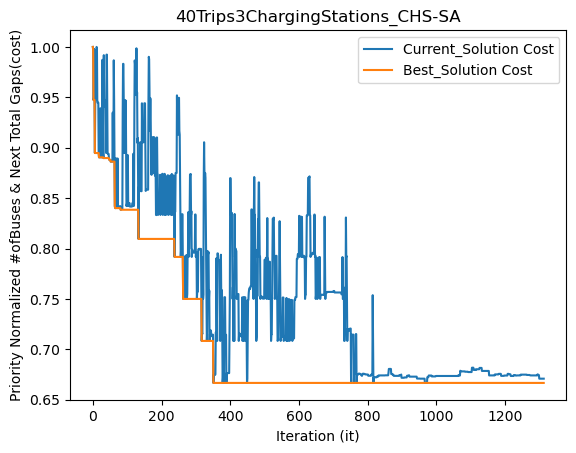

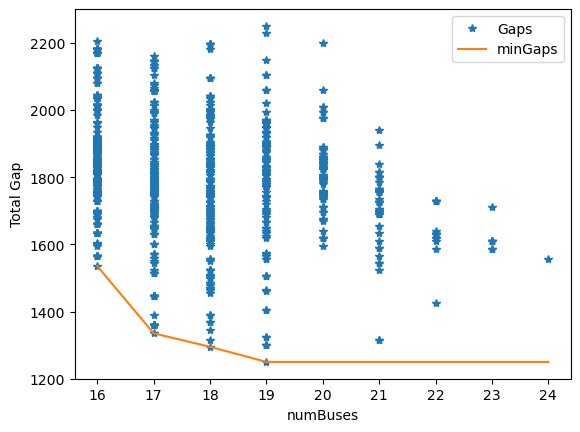

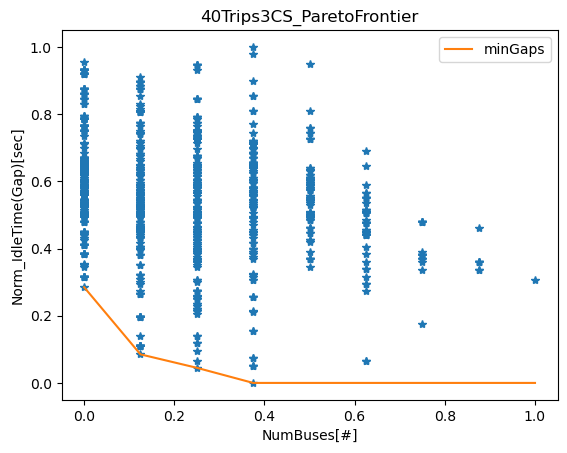

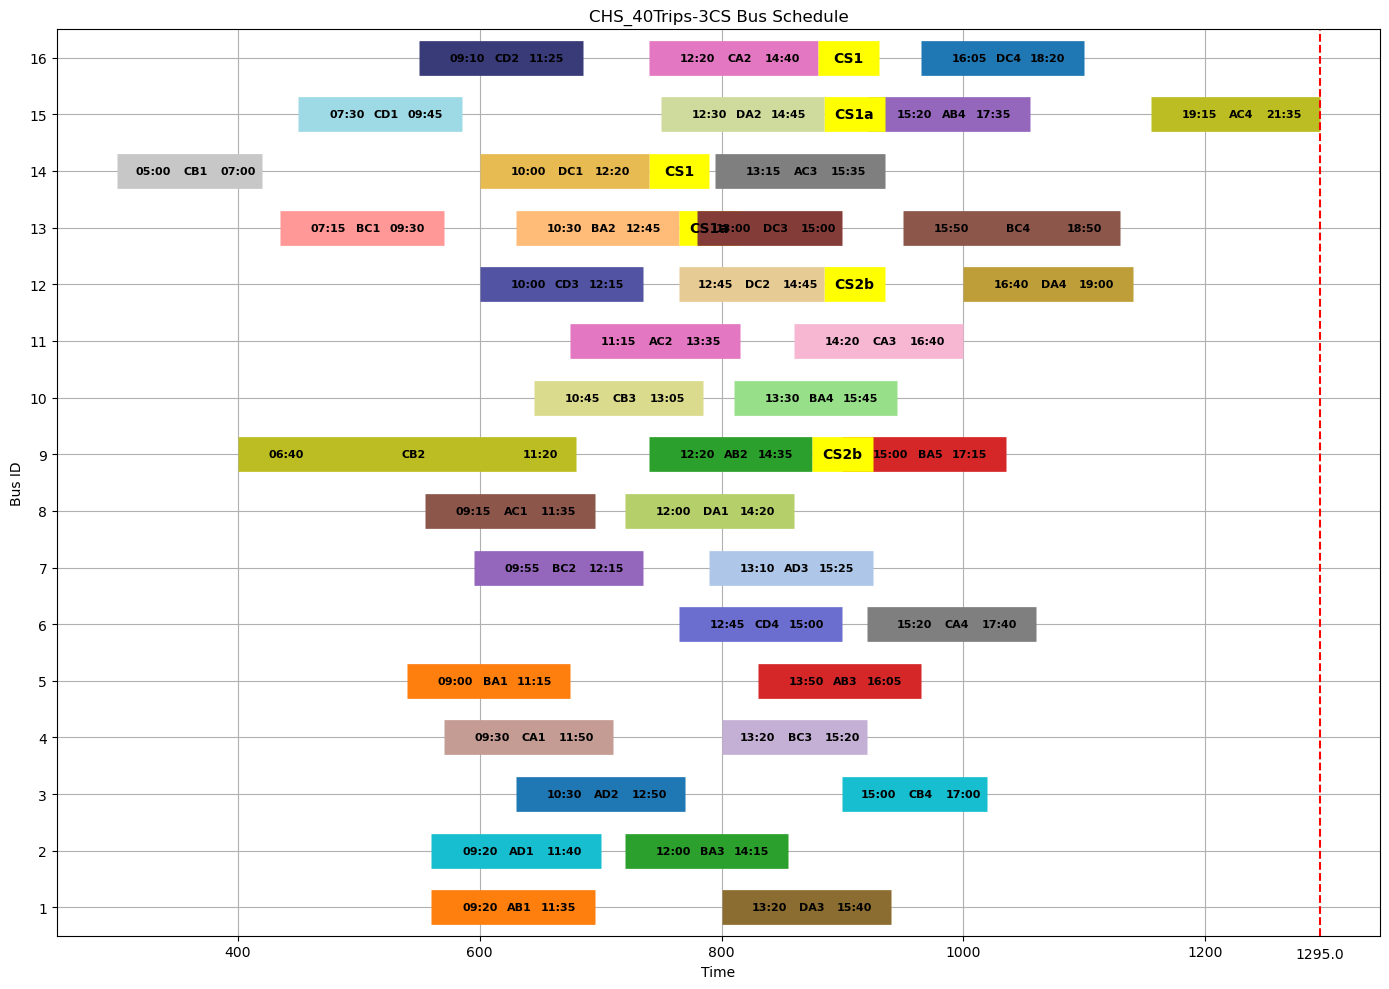

In [24]:
################################################################### 3CS #############################################################################################
## Creating Phi and Delta
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
print(recharge_3cs_arcs)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

###### import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_40_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_40_3)
end_time = time.time()
g_T40CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {g_T40CS3_time} seconds")
print(f"number of buses = {len(schedules_40_3)}")
print(schedules_40_3)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_40_3, cost_40_3, cost_diffs_40_3, temp_40_3, it_40_3, costs_40_3, solutionspaces_40_3, best_40_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T40CS3_time = (end_time - start_time) + g_T40CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T40CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_40_3} with number of buses = {len(new_schedule_40_3)}")

fig1, ax1 = plt.subplots()
ax1.plot(range(it_40_3), costs_40_3, label="Current_Solution Cost")
ax1.plot(range(it_40_3), best_40_3, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("40Trips3ChargingStations_CHS-SA")
ax1.legend(loc="upper right")
FortyTrips_3cs_df = visualizeSolution(solutionspaces_40_3[1:], "40Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_40_3cs = visualizeResult(new_schedule_40_3, all_schs_3cs, "CHS_40Trips-3CS", cs_deadheads)

trips40_df_3cs = newdf_40_3cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips40_df_3cs['next_dep'] = trips40_df_3cs['next_dep'].fillna(0)
trips40_df_3cs['difference'] = trips40_df_3cs['next_dep'] - trips40_df_3cs['arr_time']
trips40_df_3cs['difference'] = trips40_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_40Trips3cs_IDLE_soln = trips40_df_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

chs_40Trips3cs_IDLE_soln.sort_values(['gapTime'], ascending=False)

In [20]:
################################################################################### 54 TRIPS ###############################################################################################
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AB1', 'type': 'trip', 'duration': 135, 'dep_time': 560, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    2: {'name': 'AB2', 'type': 'trip', 'duration': 135, 'dep_time': 740, 'arr_time': 875, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    3: {'name': 'AB3', 'type': 'trip', 'duration': 135, 'dep_time': 830, 'arr_time': 965, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    4: {'name': 'AB4', 'type': 'trip', 'duration': 135, 'dep_time': 920, 'arr_time': 1055, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    5: {'name': 'AB5', 'type': 'trip', 'duration': 135, 'dep_time': 980, 'arr_time': 1115, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    6: {'name': 'AB6', 'type': 'trip', 'duration': 135, 'dep_time': 1040, 'arr_time': 1175, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    7: {'name': 'AB7', 'type': 'trip', 'duration': 135, 'dep_time': 1100, 'arr_time': 1235, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    8: {'name': 'AB8', 'type': 'trip', 'duration': 135, 'dep_time': 1190, 'arr_time': 1325, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    9: {'name': 'AC1', 'type': 'trip', 'duration': 140, 'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    10: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    11: {'name': 'AC3', 'type': 'trip', 'duration': 140, 'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    12: {'name': 'AC4', 'type': 'trip', 'duration': 140, 'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    13: {'name': 'AC5', 'type': 'trip', 'duration': 140, 'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    14: {'name': 'AD1', 'type': 'trip', 'duration': 140, 'dep_time': 560, 'arr_time': 700, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    15: {'name': 'AD2', 'type': 'trip', 'duration': 140, 'dep_time': 630, 'arr_time': 770, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    16: {'name': 'AD3', 'type': 'trip', 'duration': 135, 'dep_time': 790, 'arr_time': 925, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    17: {'name': 'AD4', 'type': 'trip', 'duration': 140, 'dep_time': 970, 'arr_time': 1110, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    18: {'name': 'AD5', 'type': 'trip', 'duration': 140, 'dep_time': 1120, 'arr_time': 1240, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    19: {'name': 'BA1', 'type': 'trip', 'duration': 135, 'dep_time': 540, 'arr_time': 675, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    20: {'name': 'BA2', 'type': 'trip', 'duration': 135, 'dep_time': 630, 'arr_time': 765, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    21: {'name': 'BA3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    22: {'name': 'BA4', 'type': 'trip', 'duration': 135, 'dep_time': 810, 'arr_time': 945, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    23: {'name': 'BA5', 'type': 'trip', 'duration': 135, 'dep_time': 900, 'arr_time': 1035, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    24: {'name': 'BA6', 'type': 'trip', 'duration': 135, 'dep_time': 990, 'arr_time': 1125, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    25: {'name': 'BA7', 'type': 'trip', 'duration': 135, 'dep_time': 1080, 'arr_time': 1215, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    26: {'name': 'BA8', 'type': 'trip', 'duration': 135, 'dep_time': 1140, 'arr_time': 1275, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    27: {'name': 'BC1', 'type': 'trip', 'duration': 140, 'dep_time': 435, 'arr_time': 570, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    28: {'name': 'BC2', 'type': 'trip', 'duration': 140, 'dep_time': 595, 'arr_time': 735, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    29: {'name': 'BC3', 'type': 'trip', 'duration': 120, 'dep_time': 800, 'arr_time': 920, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    30: {'name': 'BC4', 'type': 'trip', 'duration': 130, 'dep_time': 950, 'arr_time': 1130, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    31: {'name': 'CA1', 'type': 'trip', 'duration': 140, 'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    32: {'name': 'CA2', 'type': 'trip', 'duration': 140, 'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    33: {'name': 'CA3', 'type': 'trip', 'duration': 140, 'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    34: {'name': 'CA4', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    35: {'name': 'CA5', 'type': 'trip', 'duration': 140, 'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    36: {'name': 'CB1', 'type': 'trip', 'duration': 120, 'dep_time': 300, 'arr_time': 420, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    37: {'name': 'CB2', 'type': 'trip', 'duration': 140, 'dep_time': 540, 'arr_time': 680, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    38: {'name': 'CB3', 'type': 'trip', 'duration': 140, 'dep_time': 645, 'arr_time': 785, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    39: {'name': 'CB4', 'type': 'trip', 'duration': 120, 'dep_time': 900, 'arr_time': 1020, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    40: {'name': 'CD1', 'type': 'trip', 'duration': 140, 'dep_time': 450, 'arr_time': 585, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    41: {'name': 'CD2', 'type': 'trip', 'duration': 135, 'dep_time': 550, 'arr_time': 685, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    42: {'name': 'CD3', 'type': 'trip', 'duration': 135, 'dep_time': 600, 'arr_time': 735, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    43: {'name': 'CD4', 'type': 'trip', 'duration': 135, 'dep_time': 765, 'arr_time': 900, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    44: {'name': 'CD5', 'type': 'trip', 'duration': 120, 'dep_time': 850, 'arr_time': 970, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    45: {'name': 'DA1', 'type': 'trip', 'duration': 140, 'dep_time': 720, 'arr_time': 860, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    46: {'name': 'DA2', 'type': 'trip', 'duration': 135, 'dep_time': 750, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    47: {'name': 'DA3', 'type': 'trip', 'duration': 140, 'dep_time': 800, 'arr_time': 940, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    48: {'name': 'DA4', 'type': 'trip', 'duration': 140, 'dep_time': 1000, 'arr_time': 1140, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    49: {'name': 'DA5', 'type': 'trip', 'duration': 140, 'dep_time': 1200, 'arr_time': 1340, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    50: {'name': 'DC1', 'type': 'trip', 'duration': 140, 'dep_time': 600, 'arr_time': 740, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    51: {'name': 'DC2', 'type': 'trip', 'duration': 120, 'dep_time': 765, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    52: {'name': 'DC3', 'type': 'trip', 'duration': 120, 'dep_time': 780, 'arr_time': 900, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    53: {'name': 'DC4', 'type': 'trip', 'duration': 135, 'dep_time': 965, 'arr_time': 1100, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    54: {'name': 'DC5', 'type': 'trip', 'duration': 135, 'dep_time': 975, 'arr_time': 1110, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'}
}

charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2b', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal B', 'arr_term': 'Terminal B'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal B': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
    'Terminal D': {'max_interval': 15}
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 40, 'CS1a': 10, 'CS2b': 75, 'CS3c': 75, 'CS4d': 75},
    'Terminal B': {'CS1': 40, 'CS1a': 75, 'CS2b': 10, 'CS3c': 75, 'CS4d': 75},
    'Terminal C': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 10, 'CS4d': 75},
    'Terminal D': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 75, 'CS4d': 10},
}

D_MAX = 350
CHARGING_TIME = 50
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)

######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}

     name   type  duration  dep_time  arr_time    dep_term    arr_term
0   DEPOT  depot         0         0      1440           -           -
1     AB1   trip       135       560       695  Terminal A  Terminal B
2     AB2   trip       135       740       875  Terminal A  Terminal B
3     AB3   trip       135       830       965  Terminal A  Terminal B
4     AB4   trip       135       920      1055  Terminal A  Terminal B
5     AB5   trip       135       980      1115  Terminal A  Terminal B
6     AB6   trip       135      1040      1175  Terminal A  Terminal B
7     AB7   trip       135      1100      1235  Terminal A  Terminal B
8     AB8   trip       135      1190      1325  Terminal A  Terminal B
9     AC1   trip       140       555       695  Terminal A  Terminal C
10    AC2   trip       140       675       815  Terminal A  Terminal C
11    AC3   trip       140       795       935  Terminal A  Terminal C
12    AC4   trip       140      1155      1295  Terminal A  Terminal C
13    

Fri Aug 15 15:14:04 2025
Fri Aug 15 15:14:09 2025
Time elapse to compute the solution = 5.278968095779419 seconds
number of buses = 18
[[(0, 36), (36, 1), (1, 2, 55), (2, 39), (39, 6), (6, 13), (13, 0)], [(0, 27), (27, 10), (10, 33, 55), (33, 35), (35, 49), (49, 0)], [(0, 40), (40, 15), (15, 3, 55), (3, 24), (24, 8), (8, 0)], [(0, 37), (37, 11), (11, 5, 55), (5, 12), (12, 0)], [(0, 19), (19, 16), (16, 53, 55), (53, 18), (18, 0)], [(0, 41), (41, 21), (21, 4, 55), (4, 7), (7, 0)], [(0, 9), (9, 29), (29, 17, 55), (17, 26), (26, 0)], [(0, 14), (14, 32), (32, 34, 55), (34, 25), (25, 0)], [(0, 31), (31, 22), (22, 48, 55), (48, 0)], [(0, 28), (28, 43), (43, 30, 55), (30, 0)], [(0, 50), (50, 51), (51, 54, 55), (54, 0)], [(0, 42), (42, 23), (23, 0)], [(0, 20), (20, 44), (44, 0)], [(0, 38), (38, 0)], [(0, 45), (45, 0)], [(0, 46), (46, 0)], [(0, 52), (52, 0)], [(0, 47), (47, 0)]]
----------------------------------------------------------------------------------------------------
starting simulate

proposed solution = [[42, 23, 0], [20, 44, 0], [38, 0], [45, 0], [46, 0], [52, 0], [47, 54, 0], [40, 15, 0], [3, 0], [50, 51, 55, 24, 8, 0], [36, 1, 55, 2, 39, 6, 13, 0], [27, 10, 55, 33, 35, 49, 0], [37, 11, 55, 5, 12, 0], [41, 21, 55, 4, 7, 0], [9, 29, 55, 17, 26, 0], [14, 32, 55, 34, 25, 0], [31, 22, 55, 48, 0], [28, 43, 55, 30, 0], [19, 16, 55, 53, 18, 0]]
diff neigh vs. current = -0.0
current temp = 86.87458127689783
----------------------------------------------------------------------------------------------------
Iteration 16...
insertion...
proposed solution = [[42, 23, 0], [20, 44, 0], [45, 0], [46, 0], [52, 0], [47, 54, 0], [40, 15, 0], [38, 3, 0], [50, 51, 55, 24, 8, 0], [36, 1, 55, 2, 39, 6, 13, 0], [27, 10, 55, 33, 35, 49, 0], [37, 11, 55, 5, 12, 0], [41, 21, 55, 4, 7, 0], [9, 29, 55, 17, 26, 0], [14, 32, 55, 34, 25, 0], [31, 22, 55, 48, 0], [28, 43, 55, 30, 0], [19, 16, 55, 53, 18, 0]]
diff neigh vs. current = 0.05165865384615387
current temp = 86.00583546412885
--------

diff neigh vs. current = -0.0008281573498964967
current temp = 75.47192872036327
----------------------------------------------------------------------------------------------------
Iteration 30...
swapping recharging task...
proposed solution = [[42, 23, 0], [40, 15, 0], [38, 3, 0], [50, 51, 0], [45, 0], [29, 17, 0], [46, 30, 0], [47, 0], [9, 52, 55, 54, 49, 0], [20, 44, 55, 26, 0], [36, 1, 55, 2, 39, 6, 13, 0], [27, 10, 0], [37, 11, 55, 5, 12, 0], [41, 21, 55, 4, 7, 0], [14, 32, 55, 34, 25, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [19, 16, 55, 53, 18, 0], [33, 0], [35, 0]]
diff neigh vs. current = -0.09468944099378884
current temp = 74.71720943315964
----------------------------------------------------------------------------------------------------
Iteration 31...
swapping other CS...
proposed solution = [[42, 23, 0], [40, 15, 0], [38, 3, 0], [50, 51, 0], [45, 0], [29, 17, 0], [46, 30, 0], [47, 0], [27, 10, 0], [33, 0], [35, 0], [9, 52, 55, 54, 49, 0], [20, 44, 55, 26, 0], [

proposed solution = [[40, 15, 0], [38, 3, 0], [50, 51, 0], [29, 17, 0], [33, 18, 0], [45, 23, 55, 25, 0], [46, 35, 0], [27, 10, 55, 34, 0], [20, 44, 55, 26, 0], [36, 1, 55, 2, 39, 6, 13, 0], [37, 11, 55, 5, 12, 0], [41, 21, 0], [14, 32, 55, 4, 7, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [19, 16, 55, 54, 0], [9, 52, 55, 53, 49, 0], [42, 30, 0], [47, 0]]
diff neigh vs. current = -0.0
current temp = 64.26116020847184
----------------------------------------------------------------------------------------------------
Iteration 46...
swapping other CS...
proposed solution = [[40, 15, 0], [38, 3, 0], [50, 51, 0], [29, 17, 0], [33, 18, 0], [46, 35, 0], [41, 21, 0], [42, 30, 0], [47, 0], [45, 23, 55, 25, 0], [27, 10, 55, 34, 0], [20, 44, 55, 26, 0], [36, 1, 55, 2, 39, 6, 13, 0], [37, 11, 55, 5, 12, 0], [14, 32, 55, 4, 7, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [19, 16, 55, 54, 0], [9, 52, 55, 53, 49, 0]]
diff neigh vs. current = -0.002612612612612697
current temp = 63.61854860

proposed solution = [[50, 51, 0], [15, 33, 0], [41, 21, 0], [47, 17, 0], [46, 34, 0], [38, 3, 0], [42, 18, 0], [45, 23, 55, 25, 0], [27, 2, 55, 6, 13, 0], [36, 1, 55, 29, 30, 0], [37, 11, 55, 5, 12, 0], [14, 32, 55, 4, 7, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [9, 52, 55, 53, 49, 0], [10, 44, 55, 35, 0], [40, 20, 55, 39, 26, 0], [19, 16, 55, 54, 0]]
diff neigh vs. current = -0.008487460815047032
current temp = 55.26834771623852
----------------------------------------------------------------------------------------------------
Iteration 61...
insertion...
proposed solution = [[50, 51, 0], [15, 33, 0], [41, 21, 55, 17, 0], [46, 34, 0], [38, 3, 0], [42, 47, 55, 18, 0], [45, 23, 55, 25, 0], [27, 2, 55, 6, 13, 0], [36, 1, 55, 29, 30, 0], [37, 11, 55, 5, 12, 0], [14, 32, 55, 4, 7, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [9, 52, 55, 53, 49, 0], [10, 44, 55, 35, 0], [40, 20, 55, 39, 26, 0], [19, 16, 55, 54, 0]]
diff neigh vs. current = 0.05394200626959256
current temp = 54.

diff neigh vs. current = -0.00909090909090915
current temp = 48.01414565714214
----------------------------------------------------------------------------------------------------
Iteration 75...
insertion...
proposed solution = [[41, 45, 0], [21, 17, 0], [37, 11, 0], [15, 33, 0], [46, 5, 0], [42, 47, 55, 18, 0], [27, 2, 55, 6, 13, 0], [36, 1, 55, 29, 30, 0], [14, 32, 55, 34, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [9, 52, 55, 53, 49, 0], [10, 44, 55, 35, 0], [40, 20, 55, 39, 26, 0], [19, 16, 55, 54, 12, 0], [50, 23, 55, 25, 0], [51, 4, 55, 7, 0], [38, 3, 0]]
diff neigh vs. current = -0.0
current temp = 47.53400420057071
----------------------------------------------------------------------------------------------------
Iteration 76...
swapping other CS...
proposed solution = [[41, 45, 0], [21, 17, 0], [37, 11, 0], [15, 33, 0], [46, 5, 0], [38, 3, 0], [42, 47, 55, 18, 0], [27, 2, 55, 6, 13, 0], [36, 1, 55, 29, 30, 0], [14, 32, 55, 34, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 

diff neigh vs. current = -0.0
current temp = 41.29496711338884
----------------------------------------------------------------------------------------------------
Iteration 90...
swapping recharging task...
proposed solution = [[21, 17, 0], [37, 11, 0], [38, 3, 0], [15, 33, 0], [45, 0], [41, 46, 0], [27, 2, 55, 6, 13, 0], [36, 1, 55, 29, 30, 0], [14, 32, 55, 34, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [9, 52, 55, 53, 49, 0], [10, 44, 55, 35, 0], [40, 20, 55, 39, 26, 0], [19, 16, 55, 54, 12, 0], [50, 23, 55, 25, 0], [51, 4, 55, 7, 0], [42, 47, 55, 18, 0], [5, 0]]
diff neigh vs. current = -0.041593189419276255
current temp = 40.882017442254956
----------------------------------------------------------------------------------------------------
Iteration 91...
swapping recharging task...
proposed solution = [[21, 17, 0], [37, 11, 0], [38, 3, 0], [15, 33, 55, 49, 0], [45, 0], [41, 46, 0], [27, 2, 55, 6, 13, 0], [36, 1, 55, 29, 30, 0], [14, 32, 55, 34, 0], [31, 22, 55, 48, 0], [28,

diff neigh vs. current = -0.0
current temp = 35.516081470507324
----------------------------------------------------------------------------------------------------
Iteration 105...
swapping recharging task...
proposed solution = [[38, 3, 0], [41, 46, 55, 18, 0], [45, 53, 0], [29, 30, 0], [37, 11, 0], [9, 52, 55, 5, 0], [36, 1, 21, 55, 17, 0], [14, 32, 55, 34, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [10, 44, 55, 35, 0], [40, 20, 55, 39, 26, 0], [19, 16, 55, 54, 12, 0], [50, 23, 55, 25, 0], [51, 4, 55, 7, 0], [42, 47, 0], [15, 33, 55, 49, 0], [27, 2, 55, 6, 13, 0]]
diff neigh vs. current = -0.0
current temp = 35.16092065580225
----------------------------------------------------------------------------------------------------
Iteration 106...
swapping other CS...
proposed solution = [[38, 3, 0], [45, 53, 0], [29, 30, 0], [37, 11, 0], [42, 47, 0], [41, 46, 55, 18, 0], [9, 52, 55, 5, 0], [36, 1, 21, 55, 17, 0], [14, 32, 55, 34, 0], [31, 22, 55, 48, 0], [28, 43, 55, 24, 8, 0], [10

diff neigh vs. current = -0.0
current temp = 30.545902592830487
----------------------------------------------------------------------------------------------------
Iteration 120...
swapping other CS...
proposed solution = [[29, 30, 0], [37, 11, 0], [31, 22, 0], [34, 25, 0], [36, 1, 21, 0], [50, 23, 0], [42, 47, 0], [46, 0], [17, 0], [41, 45, 55, 53, 0], [9, 52, 55, 24, 8, 0], [14, 32, 55, 5, 8, 0], [28, 43, 55, 48, 0], [10, 44, 55, 35, 0], [40, 20, 55, 39, 26, 0], [51, 4, 55, 7, 0], [15, 33, 55, 49, 0], [27, 2, 55, 6, 13, 0], [19, 16, 55, 54, 12, 0], [38, 3, 55, 18, 0]]
diff neigh vs. current = -0.0
current temp = 30.240443566902183
----------------------------------------------------------------------------------------------------
Iteration 121...
insertion...
proposed solution = [[29, 30, 0], [37, 11, 0], [31, 22, 0], [34, 25, 0], [36, 1, 21, 0], [50, 23, 0], [46, 0], [42, 17, 0], [41, 45, 55, 53, 0], [9, 52, 55, 24, 8, 0], [14, 32, 55, 5, 8, 0], [28, 43, 55, 48, 0], [10, 44, 55, 35

diff neigh vs. current = -0.0
current temp = 26.271258725022847
----------------------------------------------------------------------------------------------------
Iteration 135...
swapping recharging task...
proposed solution = [[37, 11, 0], [34, 25, 0], [10, 44, 0], [51, 4, 0], [46, 7, 0], [28, 43, 0], [23, 0], [36, 1, 21, 55, 30, 0], [42, 29, 55, 17, 0], [50, 47, 55, 35, 0], [41, 45, 55, 53, 0], [9, 52, 55, 24, 8, 0], [14, 32, 55, 5, 8, 0], [40, 20, 55, 39, 26, 0], [15, 33, 55, 49, 0], [27, 2, 55, 6, 13, 0], [19, 16, 55, 54, 12, 0], [38, 3, 55, 18, 0], [31, 22, 0], [48, 0]]
diff neigh vs. current = -0.04235100247184831
current temp = 26.00854613777262
----------------------------------------------------------------------------------------------------
Iteration 136...
insertion...
proposed solution = [[37, 11, 0], [34, 25, 0], [10, 44, 0], [51, 4, 0], [46, 7, 0], [28, 43, 0], [36, 1, 21, 55, 30, 0], [42, 29, 55, 17, 0], [50, 47, 55, 35, 0], [41, 45, 55, 53, 0], [9, 52, 55, 24, 8, 0]

diff neigh vs. current = -0.0
current temp = 22.59481555339874
----------------------------------------------------------------------------------------------------
Iteration 150...
swapping recharging task...
proposed solution = [[34, 25, 0], [10, 44, 0], [51, 4, 0], [46, 7, 0], [15, 33, 0], [50, 47, 0], [37, 11, 0], [35, 0], [28, 43, 55, 30, 0], [1, 21, 55, 23, 0], [42, 29, 0], [41, 45, 55, 53, 49, 0], [9, 52, 55, 24, 8, 0], [14, 32, 55, 5, 8, 0], [40, 20, 55, 39, 26, 0], [27, 2, 55, 6, 13, 0], [19, 16, 55, 54, 12, 0], [38, 3, 55, 18, 0], [36, 31, 55, 22, 48, 0], [17, 0]]
diff neigh vs. current = -0.042426531172754633
current temp = 22.36886739786475
----------------------------------------------------------------------------------------------------
Iteration 151...
swapping other CS...
proposed solution = [[34, 25, 0], [10, 44, 0], [51, 4, 0], [46, 7, 0], [15, 33, 0], [50, 47, 0], [37, 11, 0], [35, 0], [42, 29, 0], [17, 0], [28, 43, 55, 30, 0], [1, 21, 55, 23, 0], [41, 45, 55, 53, 49

diff neigh vs. current = -0.0
current temp = 19.43285988827951
----------------------------------------------------------------------------------------------------
Iteration 165...
swapping recharging task...
proposed solution = [[34, 25, 0], [10, 44, 0], [46, 7, 0], [15, 33, 55, 18, 0], [50, 47, 0], [9, 23, 0], [52, 17, 0], [51, 4, 0], [37, 11, 0], [42, 29, 55, 35, 0], [28, 43, 55, 30, 0], [1, 21, 55, 6, 13, 0], [41, 45, 55, 53, 49, 0], [14, 32, 55, 5, 8, 0], [40, 20, 55, 39, 26, 0], [19, 16, 55, 54, 12, 0], [38, 3, 0], [36, 31, 55, 22, 48, 8, 0], [27, 2, 0], [24, 0]]
diff neigh vs. current = -0.04235100247184831
current temp = 19.238531289396715
----------------------------------------------------------------------------------------------------
Iteration 166...
insertion...
proposed solution = [[34, 25, 0], [10, 44, 0], [46, 7, 0], [15, 33, 55, 18, 0], [50, 47, 0], [9, 23, 0], [52, 17, 0], [51, 4, 0], [37, 11, 0], [42, 29, 55, 35, 0], [28, 43, 55, 30, 0], [1, 21, 55, 6, 13, 0], [41, 

diff neigh vs. current = -0.0
current temp = 16.713393501488362
----------------------------------------------------------------------------------------------------
Iteration 180...
insertion...
proposed solution = [[51, 4, 0], [37, 11, 0], [10, 44, 0], [28, 43, 0], [30, 0], [9, 47, 0], [50, 52, 55, 17, 0], [38, 3, 55, 25, 0], [15, 33, 55, 18, 0], [42, 29, 55, 35, 0], [1, 21, 55, 6, 13, 0], [41, 45, 55, 53, 49, 0], [40, 20, 55, 39, 26, 0], [19, 16, 55, 48, 0], [27, 2, 55, 5, 12, 0], [14, 32, 55, 24, 8, 0], [36, 31, 55, 22, 54, 8, 0], [46, 34, 55, 7, 0], [23, 0]]
diff neigh vs. current = 0.002719033232628454
current temp = 16.546259566473477
----------------------------------------------------------------------------------------------------
Iteration 181...
swapping recharging task...
proposed solution = [[51, 18, 0], [37, 11, 0], [10, 44, 0], [28, 43, 0], [30, 0], [9, 47, 0], [50, 52, 55, 17, 0], [38, 3, 55, 25, 0], [15, 33, 0], [42, 29, 55, 35, 0], [1, 21, 55, 6, 13, 0], [41, 45, 55, 

diff neigh vs. current = -0.006818181818181834
current temp = 14.519690621578262
----------------------------------------------------------------------------------------------------
Iteration 194...
insertion...
proposed solution = [[51, 18, 0], [10, 44, 0], [4, 0], [9, 11, 55, 48, 0], [37, 23, 0], [46, 34, 0], [15, 33, 55, 49, 0], [19, 16, 55, 53, 0], [28, 43, 55, 17, 0], [38, 3, 55, 25, 0], [42, 29, 55, 35, 0], [1, 21, 55, 6, 13, 0], [41, 45, 55, 7, 0], [40, 20, 55, 39, 26, 0], [27, 2, 55, 5, 12, 0], [14, 32, 55, 24, 8, 0], [36, 31, 55, 22, 54, 8, 0], [50, 52, 55, 30, 0], [47, 0]]
diff neigh vs. current = 7.374631268441956e-05
current temp = 14.374493715362478
----------------------------------------------------------------------------------------------------
Iteration 195...
insertion...
proposed solution = [[51, 18, 0], [10, 44, 0], [52, 4, 0], [9, 11, 55, 48, 0], [37, 23, 0], [46, 34, 0], [15, 33, 55, 49, 0], [19, 16, 55, 53, 0], [28, 43, 55, 17, 0], [38, 3, 55, 25, 0], [42, 29, 5

diff neigh vs. current = 0.001474926253687281
current temp = 12.487781225895146
----------------------------------------------------------------------------------------------------
Iteration 209...
swapping recharging task...
proposed solution = [[37, 51, 55, 18, 0], [10, 44, 55, 26, 0], [52, 4, 0], [46, 34, 0], [50, 47, 55, 7, 0], [9, 11, 55, 48, 0], [41, 45, 55, 39, 6, 13, 0], [19, 16, 55, 53, 49, 0], [28, 43, 55, 17, 0], [38, 3, 55, 25, 0], [42, 29, 55, 35, 0], [1, 21, 0], [40, 20, 55, 23, 0], [27, 2, 55, 5, 12, 0], [14, 32, 55, 24, 8, 0], [36, 31, 55, 22, 54, 8, 0], [15, 33, 0], [30, 0]]
diff neigh vs. current = -0.04178063824081535
current temp = 12.362903413636195
----------------------------------------------------------------------------------------------------
Iteration 210...
swapping other CS...
proposed solution = [[52, 4, 0], [46, 34, 0], [1, 21, 0], [15, 33, 0], [30, 0], [37, 51, 55, 18, 0], [10, 44, 55, 26, 0], [50, 47, 55, 7, 0], [9, 11, 55, 48, 0], [41, 45, 55, 39, 6, 

diff neigh vs. current = -0.0
current temp = 10.74022057426375
----------------------------------------------------------------------------------------------------
Iteration 224...
swapping recharging task...
proposed solution = [[15, 33, 55, 26, 0], [52, 4, 0], [46, 34, 0], [40, 20, 0], [14, 32, 0], [23, 0], [24, 0], [8, 0], [1, 21, 55, 30, 0], [37, 51, 55, 18, 0], [10, 44, 0], [50, 47, 55, 7, 0], [9, 11, 55, 48, 0], [41, 45, 55, 39, 6, 13, 0], [19, 16, 55, 53, 49, 0], [28, 43, 55, 17, 0], [38, 3, 55, 25, 0], [42, 29, 55, 35, 0], [27, 2, 55, 5, 12, 0], [36, 31, 55, 22, 54, 8, 0]]
diff neigh vs. current = 0.0004424778761061843
current temp = 10.632818368521113
----------------------------------------------------------------------------------------------------
Iteration 225...
insertion...
proposed solution = [[15, 33, 55, 26, 0], [52, 4, 0], [46, 34, 0], [40, 20, 0], [14, 32, 0], [24, 0], [23, 8, 0], [1, 21, 55, 30, 0], [37, 51, 55, 18, 0], [10, 44, 0], [50, 47, 55, 7, 0], [9, 11, 55, 

diff neigh vs. current = -0.0
current temp = 9.330521652106865
----------------------------------------------------------------------------------------------------
Iteration 238...
swapping other CS...
proposed solution = [[10, 44, 0], [52, 4, 0], [47, 7, 0], [46, 0], [40, 20, 55, 24, 0], [50, 23, 55, 8, 0], [14, 32, 55, 34, 0], [15, 33, 55, 26, 0], [1, 21, 55, 30, 0], [9, 11, 55, 48, 0], [41, 45, 55, 39, 6, 13, 0], [19, 16, 55, 53, 49, 0], [28, 43, 55, 17, 0], [38, 3, 55, 25, 0], [42, 29, 55, 35, 0], [27, 2, 55, 5, 12, 0], [36, 31, 55, 22, 54, 8, 0], [37, 51, 55, 18, 0]]
diff neigh vs. current = -0.0
current temp = 9.237216435585797
----------------------------------------------------------------------------------------------------
Iteration 239...
insertion...
proposed solution = [[10, 44, 0], [52, 4, 0], [47, 7, 0], [40, 20, 55, 24, 0], [50, 23, 55, 8, 0], [14, 32, 55, 34, 0], [15, 33, 55, 26, 0], [1, 21, 55, 30, 0], [9, 11, 55, 48, 0], [41, 45, 55, 39, 6, 13, 0], [19, 16, 55, 53, 4

diff neigh vs. current = -0.004401154401154406
current temp = 8.024793100055946
----------------------------------------------------------------------------------------------------
Iteration 253...
swapping other CS...
proposed solution = [[52, 4, 0], [21, 30, 0], [39, 25, 0], [31, 22, 0], [40, 20, 47, 55, 24, 0], [50, 23, 55, 8, 0], [14, 32, 55, 34, 0], [9, 11, 55, 48, 13, 0], [19, 16, 55, 53, 49, 0], [42, 29, 55, 35, 0], [37, 51, 55, 18, 0], [1, 46, 55, 7, 0], [15, 33, 55, 26, 0], [10, 44, 55, 6, 0], [41, 45, 55, 54, 0], [27, 2, 55, 5, 12, 0], [36, 38, 55, 3, 8, 0], [28, 43, 55, 17, 0]]
diff neigh vs. current = -0.0
current temp = 7.944545169055387
----------------------------------------------------------------------------------------------------
Iteration 254...
insertion...
proposed solution = [[52, 4, 0], [21, 30, 0], [1, 39, 55, 25, 0], [31, 22, 0], [40, 20, 47, 55, 24, 0], [50, 23, 55, 8, 0], [14, 32, 55, 34, 0], [9, 11, 55, 48, 13, 0], [19, 16, 55, 53, 49, 0], [42, 29, 55, 35,

diff neigh vs. current = -0.0
current temp = 6.901790349970882
----------------------------------------------------------------------------------------------------
Iteration 268...
swapping other CS...
proposed solution = [[46, 7, 0], [15, 33, 0], [31, 22, 0], [10, 44, 55, 26, 0], [1, 21, 55, 39, 25, 0], [40, 20, 47, 55, 24, 0], [50, 23, 55, 8, 0], [14, 32, 55, 34, 0], [9, 11, 55, 48, 13, 0], [41, 45, 55, 54, 0], [28, 43, 55, 17, 0], [52, 4, 55, 18, 0], [27, 2, 55, 30, 12, 0], [38, 3, 55, 6, 0], [36, 37, 55, 51, 5, 8, 0], [19, 16, 55, 53, 49, 0], [42, 29, 55, 35, 0]]
diff neigh vs. current = -0.0
current temp = 6.832772446471173
----------------------------------------------------------------------------------------------------
Iteration 269...
swapping other CS...
proposed solution = [[46, 7, 0], [15, 33, 0], [31, 22, 0], [10, 44, 55, 26, 0], [1, 21, 55, 39, 25, 0], [40, 20, 47, 55, 24, 0], [50, 23, 55, 8, 0], [14, 32, 55, 34, 0], [9, 11, 55, 48, 13, 0], [41, 45, 55, 54, 0], [28, 43, 

diff neigh vs. current = -0.003074311580535727
current temp = 5.8765830279503275
----------------------------------------------------------------------------------------------------
Iteration 284...
insertion...
proposed solution = [[9, 11, 0], [46, 7, 0], [38, 48, 0], [3, 6, 0], [15, 33, 0], [36, 37, 55, 22, 0], [31, 51, 55, 5, 8, 0], [10, 44, 55, 26, 0], [1, 21, 55, 39, 25, 0], [40, 20, 47, 55, 24, 0], [50, 23, 55, 8, 0], [14, 32, 55, 34, 0], [41, 45, 55, 54, 13, 0], [28, 43, 55, 17, 0], [52, 4, 55, 18, 0], [19, 16, 55, 53, 49, 0], [42, 29, 55, 35, 0], [27, 2, 55, 30, 12, 0]]
diff neigh vs. current = -0.0
current temp = 5.817817197670824
----------------------------------------------------------------------------------------------------
Iteration 285...
swapping other CS...
proposed solution = [[9, 11, 0], [46, 7, 0], [38, 48, 0], [3, 6, 0], [15, 33, 0], [36, 37, 55, 22, 0], [31, 51, 55, 5, 8, 0], [10, 44, 55, 26, 0], [1, 21, 55, 39, 25, 0], [40, 20, 47, 55, 24, 0], [50, 23, 55, 8, 0

diff neigh vs. current = 0.0037627310448886675
current temp = 5.003662286632561
----------------------------------------------------------------------------------------------------
Iteration 300...
insertion...
proposed solution = [[9, 11, 0], [46, 34, 55, 7, 0], [38, 48, 0], [1, 3, 55, 6, 0], [15, 33, 0], [50, 23, 0], [27, 2, 0], [36, 37, 55, 22, 0], [31, 51, 55, 5, 8, 0], [10, 44, 55, 26, 0], [40, 20, 47, 55, 24, 0], [14, 32, 0], [41, 45, 55, 54, 13, 0], [28, 43, 55, 17, 8, 0], [52, 4, 55, 18, 0], [19, 16, 55, 53, 49, 0], [42, 29, 55, 35, 0], [30, 12, 0], [21, 39, 55, 25, 0]]
diff neigh vs. current = -0.0
current temp = 4.953625663766235
----------------------------------------------------------------------------------------------------
Iteration 301...
insertion...
proposed solution = [[46, 34, 55, 7, 0], [38, 48, 0], [1, 3, 55, 6, 0], [15, 33, 0], [50, 23, 0], [27, 2, 0], [36, 37, 55, 22, 0], [31, 51, 55, 5, 8, 0], [10, 44, 55, 26, 0], [40, 20, 47, 55, 24, 0], [14, 32, 0], [41, 45,

diff neigh vs. current = 0.0022821576763485396
current temp = 4.303441553421867
----------------------------------------------------------------------------------------------------
Iteration 315...
swapping recharging task...
proposed solution = [[38, 48, 0], [50, 23, 0], [27, 2, 0], [30, 12, 0], [46, 34, 0], [19, 16, 0], [11, 53, 0], [39, 7, 0], [14, 32, 55, 49, 0], [1, 3, 55, 6, 0], [36, 37, 55, 22, 0], [31, 51, 55, 5, 8, 0], [10, 44, 55, 26, 0], [40, 20, 47, 55, 24, 0], [41, 45, 55, 54, 13, 0], [28, 43, 55, 17, 8, 0], [52, 4, 55, 18, 0], [42, 29, 55, 35, 0], [9, 21, 55, 25, 0], [15, 33, 0]]
diff neigh vs. current = -0.0
current temp = 4.260407137887648
----------------------------------------------------------------------------------------------------
Iteration 316...
swapping recharging task...
proposed solution = [[38, 48, 0], [50, 23, 0], [27, 2, 0], [30, 12, 0], [46, 34, 0], [19, 16, 0], [11, 53, 0], [39, 7, 0], [14, 32, 55, 49, 0], [1, 3, 0], [36, 37, 55, 22, 0], [31, 51, 55, 5

diff neigh vs. current = 0.005007544322897073
current temp = 3.7012108617309605
----------------------------------------------------------------------------------------------------
Iteration 330...
insertion...
proposed solution = [[50, 23, 0], [27, 2, 0], [30, 12, 0], [46, 34, 0], [11, 53, 0], [1, 3, 0], [10, 44, 0], [38, 0], [41, 16, 55, 54, 26, 0], [36, 37, 55, 22, 48, 0], [15, 33, 55, 7, 0], [14, 32, 55, 6, 49, 0], [31, 51, 55, 5, 8, 0], [40, 20, 47, 55, 24, 0], [28, 43, 55, 17, 8, 0], [52, 4, 55, 18, 0], [9, 21, 55, 39, 25, 0], [42, 29, 55, 35, 13, 0], [19, 45, 0]]
diff neigh vs. current = 0.003457814661134151
current temp = 3.664198753113651
----------------------------------------------------------------------------------------------------
Iteration 331...
swapping other CS...
proposed solution = [[50, 23, 0], [27, 2, 0], [30, 12, 0], [46, 34, 0], [11, 53, 0], [1, 3, 0], [10, 44, 0], [38, 0], [19, 45, 0], [41, 16, 55, 54, 26, 0], [36, 37, 55, 22, 48, 0], [15, 33, 55, 7, 0], [14,

diff neigh vs. current = -0.0
current temp = 3.183257323920795
----------------------------------------------------------------------------------------------------
Iteration 345...
insertion...
proposed solution = [[30, 12, 0], [10, 44, 0], [27, 2, 0], [37, 46, 55, 49, 0], [38, 22, 55, 24, 0], [19, 45, 55, 39, 0], [41, 16, 55, 54, 26, 0], [15, 33, 55, 7, 0], [28, 43, 55, 17, 8, 0], [52, 4, 55, 18, 0], [40, 11, 55, 6, 0], [9, 21, 55, 34, 25, 0], [20, 47, 55, 48, 0], [36, 50, 55, 23, 8, 0], [42, 29, 55, 35, 13, 0], [14, 32, 55, 53, 0], [31, 51, 55, 5, 0], [1, 3, 0]]
diff neigh vs. current = -0.0
current temp = 3.1514247506815867
----------------------------------------------------------------------------------------------------
Iteration 346...
swapping recharging task...
proposed solution = [[30, 12, 0], [10, 44, 0], [27, 2, 0], [37, 46, 55, 49, 0], [38, 22, 55, 24, 0], [19, 45, 55, 39, 0], [41, 16, 55, 54, 26, 0], [15, 33, 55, 7, 0], [28, 43, 55, 17, 8, 0], [52, 4, 55, 18, 0], [40, 11,

diff neigh vs. current = -0.08200678989060739
current temp = 2.765441471122373
----------------------------------------------------------------------------------------------------
Iteration 359...
swapping recharging task...
proposed solution = [[30, 12, 0], [10, 44, 0], [27, 2, 0], [38, 22, 0], [20, 47, 0], [1, 3, 0], [34, 0], [48, 0], [37, 46, 55, 49, 0], [41, 16, 55, 54, 26, 0], [15, 33, 55, 25, 0], [28, 43, 55, 17, 8, 0], [52, 4, 55, 18, 0], [40, 11, 55, 6, 0], [9, 21, 55, 39, 7, 0], [36, 50, 0], [42, 29, 55, 35, 13, 0], [14, 32, 0], [31, 51, 55, 5, 0], [19, 45, 55, 24, 0], [23, 0], [8, 0], [53, 0]]
diff neigh vs. current = 0.0013139695712309774
current temp = 2.7377870564111495
----------------------------------------------------------------------------------------------------
Iteration 360...
insertion...
proposed solution = [[30, 12, 0], [10, 44, 0], [27, 2, 0], [38, 22, 0], [20, 47, 0], [1, 3, 0], [48, 0], [37, 46, 55, 49, 0], [41, 16, 55, 54, 26, 0], [15, 33, 55, 25, 0], [28, 

diff neigh vs. current = -0.08212460159961521
current temp = 2.402465698495245
----------------------------------------------------------------------------------------------------
Iteration 373...
insertion...
proposed solution = [[30, 12, 0], [10, 44, 0], [27, 2, 0], [38, 22, 0], [20, 47, 0], [1, 3, 0], [46, 48, 0], [23, 7, 0], [15, 33, 55, 26, 0], [14, 32, 55, 4, 25, 0], [36, 50, 55, 39, 0], [37, 34, 55, 8, 0], [9, 21, 55, 53, 0], [41, 16, 0], [28, 43, 55, 17, 8, 0], [40, 11, 55, 6, 0], [31, 51, 55, 18, 0], [19, 45, 55, 24, 49, 0], [42, 29, 55, 35, 13, 0], [54, 0], [52, 5, 0]]
diff neigh vs. current = 0.038944013470443295
current temp = 2.3784410415102926
----------------------------------------------------------------------------------------------------
Iteration 374...
insertion...
proposed solution = [[30, 12, 0], [10, 44, 0], [38, 22, 0], [20, 47, 0], [1, 3, 0], [46, 48, 0], [23, 7, 0], [15, 33, 55, 26, 0], [14, 32, 55, 4, 25, 0], [36, 50, 55, 39, 0], [37, 34, 55, 8, 0], [9, 21, 

diff neigh vs. current = -0.0
current temp = 2.087132015888843
----------------------------------------------------------------------------------------------------
Iteration 387...
insertion...
proposed solution = [[38, 22, 0], [20, 47, 0], [1, 3, 0], [46, 48, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [27, 52, 0], [34, 25, 0], [30, 8, 0], [4, 0], [5, 0], [10, 54, 0], [15, 33, 55, 26, 0], [14, 32, 55, 12, 0], [36, 50, 55, 39, 0], [9, 21, 55, 53, 0], [28, 43, 55, 17, 8, 0], [40, 11, 55, 6, 0], [31, 51, 55, 18, 0], [19, 45, 55, 24, 49, 0], [42, 29, 55, 35, 13, 0], [44, 0]]
diff neigh vs. current = -0.0
current temp = 2.0662606957299547
----------------------------------------------------------------------------------------------------
Iteration 388...
insertion...
proposed solution = [[38, 22, 0], [20, 47, 0], [1, 3, 0], [46, 48, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [27, 52, 0], [34, 25, 0], [30, 8, 0], [5, 0], [10, 54, 0], [15, 33, 55, 26, 0], [14, 32, 55, 4, 12, 0], [36, 50, 55, 39, 

diff neigh vs. current = -0.00015936015394790726
current temp = 1.8131871994995088
----------------------------------------------------------------------------------------------------
Iteration 401...
swapping recharging task...
proposed solution = [[38, 22, 0], [1, 3, 0], [46, 48, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [34, 25, 0], [10, 54, 0], [27, 52, 55, 5, 0], [15, 33, 0], [14, 32, 55, 49, 0], [36, 50, 55, 39, 0], [28, 43, 55, 17, 8, 0], [40, 11, 55, 6, 0], [31, 51, 55, 30, 12, 0], [19, 45, 55, 35, 13, 0], [42, 47, 55, 18, 0], [44, 26, 0], [20, 29, 55, 53, 8, 0], [9, 21, 0], [24, 0], [4, 0]]
diff neigh vs. current = -0.041442660412532306
current temp = 1.7950553275045138
----------------------------------------------------------------------------------------------------
Iteration 402...
insertion...
proposed solution = [[38, 22, 0], [1, 3, 0], [46, 48, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [34, 25, 0], [10, 54, 0], [27, 52, 55, 5, 0], [15, 33, 0], [14, 32, 55, 49, 0], [36, 50

diff neigh vs. current = 0.0031210535810932694
current temp = 1.5751987873315083
----------------------------------------------------------------------------------------------------
Iteration 415...
swapping recharging task...
proposed solution = [[1, 3, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [10, 54, 0], [15, 33, 0], [44, 26, 0], [14, 32, 0], [28, 43, 0], [4, 25, 0], [27, 52, 0], [22, 48, 0], [46, 5, 0], [38, 17, 55, 8, 0], [36, 50, 55, 39, 0], [40, 11, 0], [31, 51, 55, 30, 12, 0], [19, 45, 55, 34, 18, 0], [42, 47, 55, 35, 13, 0], [20, 29, 55, 53, 8, 0], [9, 21, 55, 24, 49, 0], [6, 0]]
diff neigh vs. current = -0.03985206566841071
current temp = 1.5594467994581933
----------------------------------------------------------------------------------------------------
Iteration 416...
swapping other CS...
proposed solution = [[1, 3, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [10, 54, 0], [15, 33, 0], [44, 26, 0], [14, 32, 0], [28, 43, 0], [4, 25, 0], [27, 52, 0], [22, 48, 0], [46, 5, 0], [

diff neigh vs. current = 0.0007607192254495132
current temp = 1.36844735077302
----------------------------------------------------------------------------------------------------
Iteration 429...
swapping recharging task...
proposed solution = [[1, 3, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [10, 54, 0], [44, 26, 0], [14, 32, 0], [28, 43, 0], [4, 25, 0], [46, 5, 0], [40, 11, 0], [42, 47, 0], [39, 0], [6, 0], [34, 0], [27, 52, 55, 18, 0], [50, 22, 0], [31, 51, 0], [15, 33, 55, 12, 0], [38, 17, 55, 8, 0], [19, 45, 55, 35, 13, 0], [20, 29, 55, 53, 8, 0], [36, 9, 21, 55, 24, 49, 0], [48, 0], [30, 0]]
diff neigh vs. current = 0.0008990318118948792
current temp = 1.3547628772652898
----------------------------------------------------------------------------------------------------
Iteration 430...
insertion...
proposed solution = [[1, 3, 0], [23, 7, 0], [41, 16, 0], [37, 2, 0], [10, 54, 0], [44, 26, 0], [14, 32, 0], [28, 43, 0], [4, 25, 0], [46, 5, 0], [40, 11, 0], [42, 47, 0], [6, 0], [34,

diff neigh vs. current = -0.03543196084689859
current temp = 1.1888329059788625
----------------------------------------------------------------------------------------------------
Iteration 443...
insertion...
proposed solution = [[1, 3, 0], [23, 7, 0], [37, 2, 0], [10, 54, 0], [44, 26, 0], [28, 43, 0], [4, 25, 0], [46, 5, 0], [40, 11, 0], [27, 52, 0], [29, 48, 0], [20, 30, 0], [14, 32, 55, 34, 0], [50, 22, 55, 6, 0], [9, 21, 55, 53, 49, 0], [42, 47, 55, 18, 0], [15, 33, 55, 12, 0], [38, 17, 0], [19, 45, 55, 39, 35, 13, 0], [36, 31, 55, 51, 24, 8, 0], [41, 16, 55, 8, 0]]
diff neigh vs. current = 0.04041387381636341
current temp = 1.1769445769190738
----------------------------------------------------------------------------------------------------
Iteration 444...
swapping recharging task...
proposed solution = [[1, 3, 0], [23, 7, 0], [37, 2, 0], [10, 54, 0], [44, 26, 0], [28, 43, 0], [4, 25, 0], [46, 5, 0], [40, 11, 0], [27, 52, 0], [29, 48, 0], [20, 30, 0], [14, 32, 55, 34, 0], [50,

diff neigh vs. current = -0.11230184062134263
current temp = 1.0327936091511127
----------------------------------------------------------------------------------------------------
Iteration 457...
swapping recharging task...
proposed solution = [[10, 54, 0], [44, 26, 0], [28, 43, 0], [4, 25, 0], [40, 11, 0], [20, 30, 0], [38, 17, 0], [14, 29, 0], [3, 0], [32, 23, 55, 7, 0], [37, 2, 55, 34, 0], [1, 46, 0], [50, 22, 55, 48, 0], [42, 47, 55, 18, 0], [15, 33, 55, 12, 0], [19, 45, 55, 39, 35, 13, 0], [36, 31, 0], [41, 16, 55, 53, 8, 0], [9, 21, 55, 6, 49, 0], [27, 52, 0], [51, 0], [24, 0], [8, 0], [5, 0]]
diff neigh vs. current = -0.0354319608468987
current temp = 1.0224656730596016
----------------------------------------------------------------------------------------------------
Iteration 458...
insertion...
proposed solution = [[10, 54, 0], [44, 26, 0], [28, 43, 0], [4, 25, 0], [40, 11, 0], [20, 30, 0], [38, 17, 0], [14, 29, 0], [32, 23, 55, 7, 0], [37, 2, 55, 34, 0], [1, 46, 0], [50, 

diff neigh vs. current = -0.03832588573252471
current temp = 0.8793801444488387
----------------------------------------------------------------------------------------------------
Iteration 473...
insertion...
proposed solution = [[10, 54, 0], [44, 26, 0], [28, 43, 0], [40, 11, 0], [20, 30, 0], [38, 17, 0], [1, 46, 0], [36, 31, 55, 52, 4, 0], [3, 8, 0], [51, 48, 0], [42, 47, 0], [14, 29, 55, 53, 18, 0], [50, 22, 0], [32, 23, 55, 7, 0], [37, 2, 55, 34, 25, 0], [27, 15, 55, 33, 12, 0], [19, 45, 55, 39, 35, 13, 0], [41, 16, 55, 5, 0], [9, 21, 55, 6, 49, 0], [24, 0]]
diff neigh vs. current = 0.03832588573252471
current temp = 0.8705863430043503
----------------------------------------------------------------------------------------------------
Iteration 474...
insertion...
proposed solution = [[10, 54, 0], [28, 43, 0], [40, 11, 0], [20, 30, 0], [38, 17, 0], [1, 46, 0], [36, 31, 55, 52, 4, 0], [3, 8, 0], [51, 48, 0], [42, 47, 0], [14, 29, 55, 53, 18, 0], [50, 22, 0], [32, 23, 55, 7, 0], [3

diff neigh vs. current = -0.03874082349186081
current temp = 0.7563182401388867
----------------------------------------------------------------------------------------------------
Iteration 488...
insertion...
proposed solution = [[28, 43, 0], [20, 30, 0], [38, 17, 0], [50, 22, 0], [44, 24, 0], [41, 16, 55, 54, 0], [46, 25, 0], [40, 10, 55, 5, 0], [1, 51, 55, 48, 0], [42, 47, 55, 26, 0], [36, 31, 55, 3, 0], [14, 29, 55, 53, 18, 0], [32, 23, 55, 7, 0], [37, 2, 55, 34, 0], [27, 15, 55, 33, 12, 0], [19, 45, 55, 39, 35, 13, 0], [9, 21, 55, 6, 49, 0], [52, 0], [4, 8, 0], [11, 0]]
diff neigh vs. current = -0.002824768592403437
current temp = 0.7487550577374978
----------------------------------------------------------------------------------------------------
Iteration 489...
swapping other CS...
proposed solution = [[28, 43, 0], [20, 30, 0], [38, 17, 0], [50, 22, 0], [44, 24, 0], [46, 25, 0], [52, 0], [4, 8, 0], [11, 0], [41, 16, 55, 54, 0], [40, 10, 55, 5, 0], [1, 51, 55, 48, 0], [42, 47,

diff neigh vs. current = 0.0004149377593360981
current temp = 0.6504778211990457
----------------------------------------------------------------------------------------------------
Iteration 503...
insertion...
proposed solution = [[44, 24, 0], [46, 25, 0], [11, 17, 0], [50, 52, 55, 18, 0], [28, 43, 55, 49, 0], [38, 4, 55, 8, 0], [41, 16, 55, 54, 0], [40, 10, 55, 5, 0], [1, 51, 55, 48, 0], [42, 47, 55, 26, 0], [36, 31, 55, 3, 0], [32, 23, 55, 7, 0], [37, 2, 55, 34, 0], [27, 15, 55, 33, 12, 0], [19, 45, 55, 39, 35, 13, 0], [9, 21, 55, 6, 0], [14, 29, 55, 53, 0], [20, 30, 0], [22, 0]]
diff neigh vs. current = -0.0
current temp = 0.6439730429870553
----------------------------------------------------------------------------------------------------
Iteration 504...
insertion...
proposed solution = [[44, 24, 0], [46, 25, 0], [11, 17, 0], [50, 52, 55, 18, 0], [28, 43, 55, 49, 0], [38, 4, 55, 8, 0], [41, 16, 55, 54, 0], [40, 10, 55, 5, 0], [1, 51, 55, 48, 0], [42, 47, 55, 26, 0], [36, 31, 55

diff neigh vs. current = -6.915629322268302e-05
current temp = 0.5594488846311013
----------------------------------------------------------------------------------------------------
Iteration 518...
swapping recharging task...
proposed solution = [[46, 25, 0], [11, 17, 0], [20, 30, 0], [40, 10, 0], [22, 5, 0], [50, 52, 55, 18, 0], [28, 43, 55, 49, 0], [38, 4, 0], [1, 51, 55, 48, 0], [42, 47, 55, 26, 0], [36, 31, 55, 3, 24, 0], [32, 23, 55, 7, 0], [37, 2, 55, 34, 0], [27, 15, 55, 33, 12, 0], [19, 45, 55, 39, 35, 13, 0], [9, 21, 55, 6, 0], [14, 29, 55, 53, 8, 0], [41, 16, 55, 54, 0], [44, 0]]
diff neigh vs. current = 0.0006224066390041472
current temp = 0.5538543957847903
----------------------------------------------------------------------------------------------------
Iteration 519...
swapping recharging task...
proposed solution = [[46, 25, 0], [11, 17, 55, 49, 0], [20, 30, 0], [40, 10, 0], [22, 5, 0], [50, 52, 55, 18, 0], [28, 43, 0], [38, 4, 0], [1, 51, 55, 48, 0], [42, 47, 55, 26

diff neigh vs. current = -0.0
current temp = 0.4860188759815446
----------------------------------------------------------------------------------------------------
Iteration 532...
swapping other CS...
proposed solution = [[22, 5, 0], [38, 4, 0], [42, 47, 0], [39, 12, 0], [9, 46, 0], [30, 0], [20, 11, 17, 55, 49, 0], [40, 10, 55, 33, 0], [50, 52, 55, 18, 0], [1, 51, 55, 48, 0], [36, 31, 55, 3, 24, 0], [32, 23, 55, 7, 0], [37, 2, 55, 34, 0], [19, 45, 55, 25, 0], [14, 29, 55, 53, 8, 0], [41, 16, 55, 54, 0], [27, 21, 55, 6, 0], [15, 44, 55, 26, 0], [28, 43, 55, 35, 13, 0]]
diff neigh vs. current = -0.0
current temp = 0.4811586872217291
----------------------------------------------------------------------------------------------------
Iteration 533...
swapping recharging task...
proposed solution = [[22, 5, 0], [38, 4, 0], [42, 47, 0], [39, 12, 0], [9, 46, 0], [30, 0], [20, 11, 17, 55, 49, 0], [40, 10, 55, 33, 0], [50, 52, 55, 18, 0], [1, 51, 55, 48, 0], [36, 31, 55, 3, 24, 0], [32, 23, 

diff neigh vs. current = -0.007556654963294052
current temp = 0.4138245488532826
----------------------------------------------------------------------------------------------------
Iteration 548...
insertion...
proposed solution = [[38, 4, 0], [20, 11, 17, 0], [32, 23, 0], [42, 47, 55, 48, 0], [1, 2, 39, 55, 12, 0], [9, 46, 55, 30, 0], [40, 10, 55, 33, 0], [36, 31, 55, 3, 24, 0], [19, 45, 55, 25, 0], [14, 29, 55, 18, 0], [41, 16, 55, 54, 49, 0], [15, 44, 55, 35, 13, 0], [28, 43, 55, 7, 0], [27, 50, 51, 55, 53, 8, 0], [52, 34, 55, 26, 0], [37, 21, 55, 6, 0], [22, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.4096863033647498
----------------------------------------------------------------------------------------------------
Iteration 549...
swapping other CS...
proposed solution = [[38, 4, 0], [20, 11, 17, 0], [32, 23, 0], [22, 5, 0], [42, 47, 55, 48, 0], [1, 2, 39, 55, 12, 0], [9, 46, 55, 30, 0], [40, 10, 55, 33, 0], [36, 31, 55, 3, 24, 0], [19, 45, 55, 25, 0], [14, 29, 55, 18

diff neigh vs. current = -0.0007607192254495132
current temp = 0.3559132605969278
----------------------------------------------------------------------------------------------------
Iteration 563...
insertion...
proposed solution = [[20, 11, 17, 0], [22, 5, 0], [15, 44, 0], [52, 34, 0], [10, 33, 55, 25, 0], [38, 54, 0], [42, 47, 55, 48, 0], [1, 2, 39, 55, 12, 0], [36, 31, 55, 3, 24, 0], [14, 29, 55, 18, 0], [28, 43, 55, 35, 13, 0], [27, 50, 51, 55, 53, 8, 0], [37, 21, 55, 6, 0], [40, 16, 55, 26, 0], [41, 32, 55, 30, 49, 0], [19, 45, 55, 4, 0], [9, 46, 55, 7, 0], [23, 0]]
diff neigh vs. current = 0.0022130013831258566
current temp = 0.3523541279909585
----------------------------------------------------------------------------------------------------
Iteration 564...
insertion...
proposed solution = [[20, 11, 17, 0], [22, 5, 0], [15, 44, 0], [52, 34, 0], [10, 33, 55, 25, 0], [42, 47, 55, 48, 0], [1, 2, 39, 55, 12, 0], [36, 31, 55, 3, 24, 0], [14, 29, 55, 18, 0], [28, 43, 55, 35, 13, 0]

diff neigh vs. current = -0.0
current temp = 0.30610617330400974
----------------------------------------------------------------------------------------------------
Iteration 578...
insertion...
proposed solution = [[20, 11, 17, 0], [15, 44, 0], [52, 34, 0], [38, 23, 0], [22, 5, 0], [10, 33, 55, 25, 0], [1, 2, 39, 55, 12, 0], [36, 31, 55, 3, 24, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [37, 21, 55, 6, 0], [40, 16, 55, 54, 26, 0], [41, 32, 55, 30, 49, 0], [9, 46, 55, 7, 0], [19, 45, 55, 4, 0], [42, 47, 55, 48, 0], [28, 43, 55, 35, 13, 0]]
diff neigh vs. current = -0.0
current temp = 0.30304511157096964
----------------------------------------------------------------------------------------------------
Iteration 579...
insertion...
proposed solution = [[20, 11, 17, 0], [52, 34, 0], [38, 23, 0], [22, 5, 0], [10, 33, 55, 25, 0], [1, 2, 39, 55, 12, 0], [36, 31, 55, 3, 24, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [37, 21, 55, 6, 0], [40, 16, 55, 54, 26, 0], [41, 32, 

diff neigh vs. current = -0.0
current temp = 0.2632691717573876
----------------------------------------------------------------------------------------------------
Iteration 593...
insertion...
proposed solution = [[20, 11, 17, 0], [38, 23, 0], [22, 5, 0], [10, 33, 0], [40, 16, 0], [52, 25, 0], [1, 2, 55, 54, 0], [36, 31, 55, 3, 24, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [41, 32, 55, 30, 49, 0], [9, 46, 55, 7, 0], [19, 45, 55, 4, 12, 0], [42, 47, 55, 48, 0], [28, 43, 55, 35, 13, 0], [15, 44, 55, 26, 0], [37, 21, 55, 39, 6, 0], [34, 0]]
diff neigh vs. current = -0.0
current temp = 0.26063648003981377
----------------------------------------------------------------------------------------------------
Iteration 594...
insertion...
proposed solution = [[20, 11, 17, 0], [38, 23, 0], [22, 5, 0], [10, 33, 0], [40, 16, 0], [52, 25, 0], [1, 2, 55, 54, 0], [36, 31, 55, 3, 24, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [41, 32, 55, 30, 49, 0], [9, 46, 55, 7, 0], [19, 45, 

diff neigh vs. current = -0.0
current temp = 0.22642685068943355
----------------------------------------------------------------------------------------------------
Iteration 608...
swapping other CS...
proposed solution = [[22, 5, 0], [10, 33, 0], [40, 16, 0], [52, 25, 0], [46, 24, 0], [3, 7, 0], [20, 11, 0], [9, 34, 0], [1, 2, 55, 54, 0], [36, 31, 55, 23, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [41, 32, 55, 30, 49, 0], [42, 47, 55, 48, 0], [28, 43, 55, 35, 13, 0], [15, 44, 55, 26, 0], [37, 21, 55, 39, 6, 0], [38, 4, 55, 12, 0], [19, 45, 55, 17, 0]]
diff neigh vs. current = -0.0013139695712309774
current temp = 0.2241625821825392
----------------------------------------------------------------------------------------------------
Iteration 609...
insertion...
proposed solution = [[22, 5, 0], [10, 33, 0], [40, 16, 0], [52, 25, 0], [46, 24, 0], [1, 3, 55, 7, 0], [20, 11, 55, 54, 0], [9, 2, 55, 34, 0], [36, 31, 55, 23, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [41

diff neigh vs. current = -0.008192360889456407
current temp = 0.1947403046505629
----------------------------------------------------------------------------------------------------
Iteration 623...
insertion...
proposed solution = [[46, 24, 0], [37, 21, 55, 39, 0], [22, 6, 0], [10, 33, 0], [40, 16, 55, 5, 0], [1, 3, 55, 7, 0], [9, 2, 55, 34, 0], [36, 31, 55, 23, 25, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [41, 32, 55, 30, 49, 0], [42, 47, 55, 48, 0], [28, 43, 55, 35, 13, 0], [15, 44, 55, 26, 0], [38, 4, 55, 12, 0], [19, 45, 55, 17, 0], [20, 11, 55, 54, 0], [52, 0]]
diff neigh vs. current = -0.0
current temp = 0.1927929016040573
----------------------------------------------------------------------------------------------------
Iteration 624...
insertion...
proposed solution = [[46, 24, 0], [37, 21, 55, 39, 0], [22, 6, 0], [10, 33, 0], [40, 16, 55, 5, 0], [1, 3, 55, 7, 0], [9, 2, 55, 34, 0], [36, 31, 55, 23, 25, 0], [14, 29, 55, 18, 0], [27, 50, 51, 55, 53, 8, 0], [41, 32,

diff neigh vs. current = -0.008676454942015188
current temp = 0.1674880260001064
----------------------------------------------------------------------------------------------------
Iteration 638...
swapping other CS...
proposed solution = [[52, 53, 0], [27, 50, 51, 0], [3, 7, 0], [47, 17, 0], [10, 33, 0], [37, 21, 55, 39, 0], [40, 16, 55, 5, 0], [9, 2, 55, 34, 18, 0], [36, 31, 55, 23, 25, 0], [41, 32, 55, 30, 49, 0], [28, 43, 55, 35, 13, 0], [15, 44, 55, 26, 0], [38, 4, 55, 12, 0], [19, 45, 55, 54, 8, 0], [20, 11, 55, 24, 0], [1, 46, 55, 48, 0], [42, 22, 55, 6, 0], [14, 29, 55, 8, 0]]
diff neigh vs. current = -0.0
current temp = 0.16581314574010533
----------------------------------------------------------------------------------------------------
Iteration 639...
insertion...
proposed solution = [[52, 53, 0], [50, 3, 55, 7, 0], [47, 17, 0], [10, 33, 0], [37, 21, 55, 39, 0], [40, 16, 55, 5, 0], [9, 2, 55, 34, 18, 0], [36, 31, 55, 23, 25, 0], [41, 32, 55, 30, 49, 0], [28, 43, 55, 35, 1

diff neigh vs. current = -0.0
current temp = 0.1440494760637688
----------------------------------------------------------------------------------------------------
Iteration 653...
insertion...
proposed solution = [[47, 17, 0], [19, 45, 0], [51, 4, 55, 26, 0], [15, 44, 0], [50, 3, 55, 7, 0], [37, 21, 55, 39, 12, 0], [40, 16, 55, 5, 0], [9, 2, 55, 34, 18, 0], [36, 31, 55, 23, 25, 0], [41, 32, 55, 30, 49, 0], [20, 11, 55, 24, 0], [1, 46, 55, 48, 0], [27, 42, 55, 22, 6, 0], [14, 29, 55, 54, 8, 0], [28, 43, 55, 35, 13, 0], [52, 53, 0], [38, 33, 0], [10, 0]]
diff neigh vs. current = -0.0
current temp = 0.14260898130313113
----------------------------------------------------------------------------------------------------
Iteration 654...
insertion...
proposed solution = [[47, 17, 0], [19, 45, 0], [51, 4, 55, 26, 0], [15, 44, 0], [50, 3, 55, 7, 0], [37, 21, 55, 39, 12, 0], [40, 16, 55, 5, 0], [9, 2, 55, 34, 18, 0], [36, 31, 55, 23, 25, 0], [41, 32, 55, 30, 49, 0], [20, 11, 55, 24, 0], [1, 4

diff neigh vs. current = -0.034809554207894444
current temp = 0.12389095537034471
----------------------------------------------------------------------------------------------------
Iteration 668...
insertion...
proposed solution = [[19, 45, 55, 17, 0], [51, 4, 55, 26, 0], [15, 44, 0], [50, 3, 0], [37, 21, 55, 39, 12, 0], [40, 16, 55, 5, 0], [9, 2, 55, 34, 18, 0], [36, 31, 55, 23, 25, 0], [41, 32, 0], [27, 42, 55, 11, 7, 0], [14, 29, 55, 54, 8, 0], [28, 43, 55, 35, 13, 0], [52, 53, 0], [20, 22, 55, 24, 49, 0], [10, 33, 55, 6, 0], [1, 47, 55, 48, 0], [46, 0], [38, 30, 0]]
diff neigh vs. current = 0.04210288328545597
current temp = 0.12265204581664126
----------------------------------------------------------------------------------------------------
Iteration 669...
swapping other CS...
proposed solution = [[15, 44, 0], [50, 3, 0], [41, 32, 0], [52, 53, 0], [46, 0], [38, 30, 0], [19, 45, 55, 17, 0], [51, 4, 55, 26, 0], [37, 21, 55, 39, 12, 0], [40, 16, 55, 5, 0], [9, 2, 55, 34, 18, 0],

diff neigh vs. current = -0.03591605489945737
current temp = 0.10655345123075595
----------------------------------------------------------------------------------------------------
Iteration 683...
insertion...
proposed solution = [[50, 3, 0], [52, 53, 0], [38, 26, 0], [51, 4, 0], [27, 42, 55, 29, 0], [11, 0], [15, 44, 55, 7, 0], [41, 32, 55, 30, 0], [19, 45, 55, 17, 0], [37, 21, 55, 39, 35, 13, 0], [40, 16, 55, 5, 0], [9, 2, 0], [36, 31, 55, 23, 25, 0], [28, 43, 55, 12, 0], [20, 22, 55, 24, 49, 0], [10, 33, 55, 6, 0], [1, 47, 55, 48, 0], [46, 54, 55, 8, 0], [14, 34, 55, 18, 0]]
diff neigh vs. current = 0.03997233748271101
current temp = 0.10548791671844839
----------------------------------------------------------------------------------------------------
Iteration 684...
swapping recharging task...
proposed solution = [[50, 3, 0], [52, 53, 0], [38, 26, 0], [51, 4, 0], [27, 42, 55, 29, 0], [11, 0], [15, 44, 55, 7, 0], [41, 32, 55, 30, 0], [19, 45, 55, 17, 0], [37, 21, 55, 39, 35, 13,

diff neigh vs. current = -0.07549739333971694
current temp = 0.09164218594687472
----------------------------------------------------------------------------------------------------
Iteration 698...
swapping recharging task...
proposed solution = [[50, 3, 0], [52, 53, 0], [51, 4, 0], [9, 2, 0], [38, 48, 0], [46, 0], [11, 0], [27, 42, 55, 35, 13, 0], [15, 44, 55, 7, 0], [41, 32, 55, 30, 0], [19, 45, 55, 17, 0], [37, 21, 0], [40, 16, 55, 5, 8, 0], [36, 31, 55, 23, 25, 0], [28, 43, 55, 54, 12, 0], [20, 22, 55, 24, 49, 0], [10, 33, 55, 6, 0], [1, 47, 0], [14, 34, 0], [39, 18, 0], [29, 26, 0]]
diff neigh vs. current = -0.0008298755186721962
current temp = 0.09072576408740597
----------------------------------------------------------------------------------------------------
Iteration 699...
insertion...
proposed solution = [[50, 3, 0], [52, 53, 0], [51, 4, 0], [9, 2, 0], [38, 48, 0], [11, 0], [27, 42, 55, 35, 13, 0], [15, 44, 55, 7, 0], [41, 32, 55, 30, 0], [19, 45, 55, 17, 0], [37, 21, 0],

diff neigh vs. current = -0.0
current temp = 0.07961376531434353
----------------------------------------------------------------------------------------------------
Iteration 712...
swapping recharging task...
proposed solution = [[50, 3, 0], [52, 53, 0], [51, 4, 0], [9, 2, 0], [38, 48, 0], [11, 0], [15, 44, 0], [19, 45, 0], [37, 21, 0], [20, 22, 55, 7, 0], [39, 18, 0], [29, 26, 0], [17, 0], [14, 24, 0], [46, 34, 0], [27, 42, 55, 6, 13, 0], [41, 32, 55, 30, 0], [40, 16, 55, 5, 8, 0], [36, 31, 55, 23, 25, 0], [28, 43, 55, 54, 12, 0], [10, 33, 55, 35, 13, 0], [1, 47, 55, 49, 0]]
diff neigh vs. current = -0.0
current temp = 0.0788176276612001
----------------------------------------------------------------------------------------------------
Iteration 713...
swapping recharging task...
proposed solution = [[50, 3, 0], [52, 53, 0], [51, 4, 0], [9, 2, 0], [38, 48, 0], [11, 0], [15, 44, 0], [19, 45, 0], [37, 21, 0], [20, 22, 55, 7, 0], [39, 18, 0], [29, 26, 0], [17, 0], [14, 24, 0], [46, 34

diff neigh vs. current = -0.004817976141505476
current temp = 0.06778775916302147
----------------------------------------------------------------------------------------------------
Iteration 728...
swapping other CS...
proposed solution = [[50, 3, 0], [52, 53, 0], [51, 4, 0], [38, 48, 0], [15, 44, 0], [37, 21, 0], [39, 18, 0], [29, 26, 0], [14, 24, 0], [46, 34, 0], [33, 35, 0], [11, 13, 0], [20, 22, 0], [28, 43, 0], [9, 2, 0], [10, 54, 0], [19, 45, 55, 17, 12, 0], [1, 47, 55, 7, 0], [27, 42, 55, 6, 13, 0], [41, 32, 55, 30, 49, 0], [40, 16, 55, 5, 8, 0], [36, 31, 55, 23, 25, 0]]
diff neigh vs. current = -0.0
current temp = 0.06710988157139126
----------------------------------------------------------------------------------------------------
Iteration 729...
insertion...
proposed solution = [[52, 53, 0], [51, 4, 0], [38, 48, 0], [15, 44, 0], [37, 21, 0], [39, 18, 0], [29, 26, 0], [14, 24, 0], [46, 34, 0], [33, 35, 0], [50, 11, 55, 13, 0], [20, 22, 0], [28, 43, 0], [9, 2, 0], [10, 54, 

diff neigh vs. current = -0.006725627313862614
current temp = 0.05889033192986684
----------------------------------------------------------------------------------------------------
Iteration 742...
swapping recharging task...
proposed solution = [[51, 4, 0], [38, 48, 0], [15, 44, 0], [39, 18, 0], [29, 26, 0], [33, 35, 0], [20, 22, 0], [28, 43, 0], [10, 7, 0], [37, 21, 55, 34, 0], [14, 52, 55, 24, 0], [50, 11, 55, 13, 0], [9, 2, 55, 53, 12, 0], [19, 45, 0], [27, 42, 55, 3, 6, 13, 0], [41, 32, 55, 30, 49, 0], [40, 16, 55, 5, 8, 0], [36, 31, 55, 23, 25, 0], [47, 54, 0], [1, 46, 55, 17, 0]]
diff neigh vs. current = -0.004653434800493628
current temp = 0.058301428610568175
----------------------------------------------------------------------------------------------------
Iteration 743...
insertion...
proposed solution = [[51, 4, 0], [15, 44, 0], [39, 18, 0], [29, 26, 0], [38, 33, 55, 35, 0], [20, 22, 55, 12, 0], [28, 43, 0], [10, 7, 0], [37, 21, 55, 34, 0], [14, 52, 55, 24, 0], [50, 11, 

diff neigh vs. current = -0.03279514603044009
current temp = 0.05116072927664708
----------------------------------------------------------------------------------------------------
Iteration 756...
insertion...
proposed solution = [[15, 44, 0], [39, 18, 0], [29, 26, 0], [47, 54, 0], [20, 22, 0], [36, 31, 55, 51, 4, 0], [38, 33, 55, 35, 0], [28, 43, 55, 25, 0], [10, 23, 55, 7, 0], [37, 21, 55, 34, 0], [14, 52, 55, 24, 0], [50, 11, 0], [9, 2, 55, 53, 12, 0], [19, 45, 55, 48, 0], [27, 42, 55, 3, 6, 13, 0], [41, 32, 55, 30, 49, 0], [40, 16, 55, 5, 8, 0], [1, 46, 55, 17, 13, 0]]
diff neigh vs. current = 0.03948992184286304
current temp = 0.050649121983880614
----------------------------------------------------------------------------------------------------
Iteration 757...
swapping other CS...
proposed solution = [[15, 44, 0], [39, 18, 0], [29, 26, 0], [47, 54, 0], [20, 22, 0], [50, 11, 0], [36, 31, 55, 51, 4, 0], [38, 33, 55, 35, 0], [28, 43, 55, 25, 0], [10, 23, 55, 7, 0], [37, 21, 55, 

diff neigh vs. current = -0.03600370218017268
current temp = 0.0440012126439215
----------------------------------------------------------------------------------------------------
Iteration 771...
swapping other CS...
proposed solution = [[20, 22, 0], [50, 11, 0], [15, 44, 0], [47, 0], [14, 52, 55, 54, 0], [51, 30, 55, 49, 0], [32, 39, 55, 18, 0], [38, 33, 55, 35, 0], [28, 43, 55, 25, 0], [10, 23, 55, 7, 0], [37, 21, 55, 34, 26, 0], [9, 2, 55, 53, 12, 0], [19, 45, 55, 48, 0], [27, 42, 55, 3, 6, 13, 0], [40, 16, 55, 5, 8, 0], [1, 46, 55, 17, 13, 0], [41, 29, 55, 24, 0], [36, 31, 55, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.04356120051748228
----------------------------------------------------------------------------------------------------
Iteration 772...
insertion...
proposed solution = [[20, 22, 0], [50, 11, 0], [15, 44, 0], [47, 0], [14, 52, 55, 54, 0], [51, 30, 55, 49, 0], [9, 32, 39, 55, 18, 0], [38, 33, 55, 35, 0], [28, 43, 55, 25, 0], [10, 23, 55, 7, 0], [37, 21, 5

diff neigh vs. current = -0.0008689839572192382
current temp = 0.038225869241164216
----------------------------------------------------------------------------------------------------
Iteration 785...
insertion...
proposed solution = [[15, 44, 0], [40, 16, 0], [41, 2, 0], [10, 53, 0], [23, 7, 0], [20, 22, 55, 48, 8, 0], [50, 47, 55, 24, 0], [14, 52, 55, 54, 12, 0], [9, 32, 39, 55, 18, 0], [38, 33, 55, 35, 0], [28, 43, 55, 25, 0], [37, 21, 55, 34, 26, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], [1, 46, 55, 17, 13, 0], [36, 31, 55, 51, 4, 0], [29, 30, 55, 49, 0], [11, 0]]
diff neigh vs. current = -0.0
current temp = 0.03784361054875257
----------------------------------------------------------------------------------------------------
Iteration 786...
swapping other CS...
proposed solution = [[15, 44, 0], [40, 16, 0], [41, 2, 0], [10, 53, 0], [23, 7, 0], [11, 0], [20, 22, 55, 48, 8, 0], [50, 47, 55, 24, 0], [14, 52, 55, 54, 12, 0], [9, 32, 39, 55, 18, 0], [38, 33, 55, 35, 0], 

diff neigh vs. current = -0.035936857260386645
current temp = 0.03287647820428874
----------------------------------------------------------------------------------------------------
Iteration 800...
insertion...
proposed solution = [[28, 43, 0], [20, 22, 0], [10, 53, 0], [14, 11, 0], [15, 44, 55, 25, 0], [41, 2, 0], [21, 23, 55, 7, 0], [9, 32, 39, 55, 18, 0], [38, 33, 55, 35, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], [1, 46, 55, 17, 13, 0], [36, 31, 55, 51, 4, 12, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [52, 48, 55, 8, 0], [47, 24, 0], [50, 34, 0]]
diff neigh vs. current = 0.03848724804607162
current temp = 0.03254771342224585
----------------------------------------------------------------------------------------------------
Iteration 801...
insertion...
proposed solution = [[28, 43, 0], [20, 22, 0], [10, 53, 0], [14, 11, 0], [15, 44, 55, 25, 0], [41, 2, 0], [9, 32, 39, 55, 18, 0], [38, 33, 55, 35, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], [1, 46

diff neigh vs. current = -0.0
current temp = 0.028275689750780753
----------------------------------------------------------------------------------------------------
Iteration 815...
swapping recharging task...
proposed solution = [[10, 53, 0], [14, 11, 0], [41, 2, 0], [50, 34, 0], [28, 43, 0], [20, 47, 55, 24, 0], [15, 44, 55, 25, 0], [9, 32, 39, 55, 18, 0], [38, 33, 55, 35, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], [1, 46, 55, 17, 13, 0], [36, 31, 55, 51, 4, 12, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [52, 48, 0], [21, 23, 55, 7, 0], [22, 0], [8, 0]]
diff neigh vs. current = -0.03587001234060061
current temp = 0.027992932853272947
----------------------------------------------------------------------------------------------------
Iteration 816...
insertion...
proposed solution = [[10, 53, 0], [14, 11, 0], [41, 2, 0], [50, 34, 0], [28, 43, 0], [15, 44, 55, 25, 0], [9, 32, 39, 55, 18, 0], [38, 33, 55, 35, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], 

diff neigh vs. current = -0.0
current temp = 0.024318743203404047
----------------------------------------------------------------------------------------------------
Iteration 830...
swapping recharging task...
proposed solution = [[10, 53, 0], [28, 43, 55, 18, 0], [15, 44, 55, 25, 0], [38, 33, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], [1, 46, 55, 17, 13, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [21, 23, 0], [20, 22, 55, 24, 0], [41, 47, 0], [9, 32, 39, 55, 7, 0], [36, 2, 55, 4, 12, 0], [31, 51, 0], [34, 0], [14, 11, 0], [35, 0]]
diff neigh vs. current = -0.03600370218017268
current temp = 0.024075555771370008
----------------------------------------------------------------------------------------------------
Iteration 831...
swapping recharging task...
proposed solution = [[10, 53, 0], [28, 43, 55, 18, 0], [15, 44, 0], [38, 33, 55, 35, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], [1, 46, 55, 17, 13, 0], [40, 29, 30, 55, 49, 0]

diff neigh vs. current = -0.035936857260386645
current temp = 0.0209155382664637
----------------------------------------------------------------------------------------------------
Iteration 845...
swapping recharging task...
proposed solution = [[10, 34, 0], [14, 11, 0], [15, 44, 0], [21, 23, 0], [47, 0], [28, 43, 55, 53, 18, 0], [38, 33, 0], [19, 45, 55, 5, 8, 0], [27, 42, 55, 3, 6, 13, 0], [1, 46, 55, 17, 13, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [20, 22, 55, 24, 0], [9, 32, 39, 55, 7, 0], [36, 41, 55, 2, 4, 12, 0], [31, 51, 55, 25, 0], [35, 0]]
diff neigh vs. current = -0.03600370218017268
current temp = 0.02070638288379906
----------------------------------------------------------------------------------------------------
Iteration 846...
insertion...
proposed solution = [[10, 34, 0], [14, 11, 0], [15, 44, 0], [21, 23, 0], [47, 0], [28, 43, 55, 53, 18, 0], [38, 33, 55, 35, 0], [19, 45, 55, 5, 8, 0], [1, 46, 55, 17, 13, 0], [40, 29, 30, 55, 

diff neigh vs. current = -0.0
current temp = 0.017988583427891672
----------------------------------------------------------------------------------------------------
Iteration 860...
insertion...
proposed solution = [[10, 34, 0], [14, 11, 0], [15, 44, 0], [21, 23, 0], [19, 47, 55, 18, 0], [38, 33, 55, 35, 0], [1, 46, 55, 17, 13, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [9, 32, 39, 55, 7, 0], [36, 41, 55, 2, 4, 12, 0], [31, 51, 55, 25, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 55, 24, 0], [45, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.017808697593612755
----------------------------------------------------------------------------------------------------
Iteration 861...
insertion...
proposed solution = [[10, 34, 0], [14, 11, 0], [15, 44, 0], [21, 23, 55, 25, 0], [19, 47, 55, 18, 0], [38, 33, 55, 35, 0], [1, 46, 55, 17, 13, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [9, 32, 39, 55, 7

diff neigh vs. current = -0.14528486219662684
current temp = 0.01547123146532006
----------------------------------------------------------------------------------------------------
Iteration 875...
swapping other CS...
proposed solution = [[15, 44, 0], [45, 5, 0], [46, 17, 0], [10, 34, 0], [14, 11, 0], [36, 41, 0], [2, 0], [4, 0], [31, 51, 55, 12, 0], [1, 21, 55, 23, 25, 0], [19, 47, 55, 18, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [9, 32, 39, 55, 7, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 55, 24, 13, 0]]
diff neigh vs. current = -0.07401275195392842
current temp = 0.01531651915066686
----------------------------------------------------------------------------------------------------
Iteration 876...
swapping recharging task...
proposed solution = [[15, 44, 0], [45, 5, 0], [31, 51, 55, 12, 0], [46, 17, 0], [10, 34, 0], [14, 11, 0], [1, 21, 55, 23, 25, 0], [19, 47, 55, 18, 0], [38, 33, 55, 35, 0], [40, 29

proposed solution = [[15, 44, 0], [45, 5, 0], [31, 51, 55, 12, 0], [46, 17, 0], [10, 34, 0], [14, 49, 0], [1, 21, 55, 23, 25, 0], [19, 47, 55, 18, 0], [38, 33, 55, 35, 0], [40, 29, 30, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [9, 32, 39, 55, 7, 0], [36, 41, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 55, 24, 13, 0], [2, 0], [4, 0], [11, 0]]
diff neigh vs. current = -0.07401275195392842
current temp = 0.013173100259554323
----------------------------------------------------------------------------------------------------
Iteration 891...
swapping other CS...
proposed solution = [[15, 44, 0], [45, 5, 0], [46, 17, 0], [10, 34, 0], [14, 11, 0], [36, 41, 0], [2, 0], [4, 0], [31, 51, 55, 12, 0], [1, 21, 55, 23, 25, 0], [19, 47, 55, 18, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [9, 32, 39, 55, 7, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 55, 24, 13, 0]]
diff neigh vs. current = -0.07

diff neigh vs. current = -0.0
current temp = 0.011444075691673758
----------------------------------------------------------------------------------------------------
Iteration 905...
swapping other CS...
proposed solution = [[45, 5, 0], [46, 17, 0], [14, 11, 0], [2, 4, 0], [19, 47, 0], [15, 0], [10, 34, 55, 18, 0], [36, 41, 55, 44, 0], [31, 51, 55, 12, 0], [1, 21, 55, 23, 25, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [37, 16, 55, 54, 26, 0], [50, 52, 55, 48, 8, 0], [9, 32, 39, 55, 7, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 55, 24, 13, 0]]
diff neigh vs. current = -0.0
current temp = 0.01132963493475702
----------------------------------------------------------------------------------------------------
Iteration 906...
insertion...
proposed solution = [[45, 5, 0], [46, 17, 0], [14, 11, 0], [2, 4, 0], [19, 47, 0], [10, 34, 55, 18, 0], [36, 41, 55, 44, 0], [31, 51, 55, 12, 0], [1, 21, 55, 23, 25, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [37, 16, 5

diff neigh vs. current = -0.03600370218017279
current temp = 0.009842572909771296
----------------------------------------------------------------------------------------------------
Iteration 920...
swapping recharging task...
proposed solution = [[46, 17, 0], [14, 11, 0], [2, 4, 0], [19, 47, 55, 7, 0], [37, 16, 0], [45, 5, 0], [15, 24, 0], [10, 34, 55, 18, 0], [36, 41, 55, 44, 26, 0], [31, 51, 55, 12, 0], [1, 21, 55, 23, 25, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [50, 52, 55, 48, 8, 0], [9, 32, 39, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 54, 55, 13, 0]]
diff neigh vs. current = -0.0
current temp = 0.009744147180673582
----------------------------------------------------------------------------------------------------
Iteration 921...
swapping recharging task...
proposed solution = [[46, 17, 0], [14, 11, 0], [2, 4, 0], [19, 47, 55, 7, 0], [37, 16, 0], [45, 5, 0], [15, 24, 0], [10, 34, 55, 18, 0], [36, 41, 55, 44, 26, 0], [31, 51, 55, 12, 0], [1, 21, 

diff neigh vs. current = -0.0
current temp = 0.008465187062214817
----------------------------------------------------------------------------------------------------
Iteration 935...
insertion...
proposed solution = [[45, 5, 0], [9, 32, 39, 0], [19, 47, 0], [37, 16, 0], [15, 11, 55, 24, 0], [10, 34, 55, 18, 0], [36, 41, 55, 44, 26, 0], [31, 51, 55, 17, 12, 0], [1, 21, 55, 23, 25, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [50, 52, 55, 48, 8, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 54, 55, 13, 0], [14, 46, 55, 7, 0], [2, 4, 0]]
diff neigh vs. current = -0.0
current temp = 0.008380535191592669
----------------------------------------------------------------------------------------------------
Iteration 936...
insertion...
proposed solution = [[45, 5, 0], [9, 32, 39, 0], [19, 47, 0], [37, 16, 55, 17, 0], [15, 11, 55, 24, 0], [10, 34, 55, 18, 0], [36, 41, 55, 44, 26, 0], [1, 21, 55, 23, 25, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [50, 52, 55, 48, 8

diff neigh vs. current = -0.0
current temp = 0.007280554856459198
----------------------------------------------------------------------------------------------------
Iteration 950...
swapping other CS...
proposed solution = [[2, 4, 0], [31, 51, 0], [1, 44, 0], [47, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [15, 11, 55, 24, 0], [10, 34, 55, 18, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [50, 52, 55, 48, 8, 0], [27, 42, 55, 3, 6, 13, 0], [28, 43, 55, 53, 8, 0], [20, 22, 54, 55, 13, 0], [36, 14, 55, 46, 7, 0], [41, 21, 55, 23, 25, 0], [19, 45, 55, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.007207749307894606
----------------------------------------------------------------------------------------------------
Iteration 951...
insertion...
proposed solution = [[2, 4, 0], [31, 51, 0], [1, 44, 0], [47, 24, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [10, 34, 55, 18, 0], [38, 33, 55, 35, 0], [40, 29, 30, 55, 49, 0], [50, 52, 55, 48, 8, 0], [27, 42, 55, 3, 

diff neigh vs. current = -0.0
current temp = 0.006261702030721939
----------------------------------------------------------------------------------------------------
Iteration 965...
insertion...
proposed solution = [[41, 22, 0], [29, 30, 0], [1, 2, 55, 4, 0], [31, 51, 0], [20, 47, 55, 24, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [10, 34, 55, 18, 0], [38, 33, 55, 35, 0], [50, 52, 55, 48, 8, 0], [28, 43, 55, 53, 8, 0], [19, 45, 55, 5, 49, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [40, 21, 55, 23, 25, 0], [36, 14, 55, 44, 0], [46, 7, 0]]
diff neigh vs. current = -0.0
current temp = 0.0061990850104147194
----------------------------------------------------------------------------------------------------
Iteration 966...
insertion...
proposed solution = [[29, 30, 0], [1, 2, 55, 4, 0], [31, 51, 0], [20, 47, 55, 24, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [10, 34, 55, 18, 0], [38, 33, 55, 35, 0], [50, 52, 55, 48, 8, 0], [28, 43, 55, 53, 8, 0], [19, 45,

diff neigh vs. current = -0.0
current temp = 0.005385429145796724
----------------------------------------------------------------------------------------------------
Iteration 980...
insertion...
proposed solution = [[19, 22, 0], [45, 5, 0], [10, 34, 0], [31, 51, 0], [1, 2, 55, 4, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [38, 33, 55, 35, 0], [50, 52, 55, 48, 8, 0], [28, 43, 55, 53, 8, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [36, 14, 55, 44, 24, 49, 0], [41, 46, 55, 7, 0], [40, 21, 55, 23, 25, 0], [20, 47, 55, 18, 0], [29, 30, 0]]
diff neigh vs. current = -0.0
current temp = 0.005331574854338757
----------------------------------------------------------------------------------------------------
Iteration 981...
insertion...
proposed solution = [[19, 45, 55, 5, 0], [10, 34, 0], [31, 51, 0], [1, 2, 55, 4, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [38, 33, 55, 35, 0], [50, 52, 55, 48, 8, 0], [28, 43, 55, 53, 8, 0], [15, 11, 55, 54, 13, 0], [27, 42, 5

diff neigh vs. current = -0.07280954339777856
current temp = 0.00463178333017117
----------------------------------------------------------------------------------------------------
Iteration 995...
insertion...
proposed solution = [[31, 51, 0], [29, 30, 0], [20, 22, 55, 7, 0], [19, 45, 55, 5, 0], [1, 2, 55, 4, 8, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [38, 33, 55, 35, 0], [50, 52, 55, 48, 8, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [36, 14, 55, 44, 24, 49, 0], [41, 46, 0], [40, 21, 55, 23, 25, 0], [47, 18, 0], [28, 43, 55, 53, 0], [10, 34, 0]]
diff neigh vs. current = -0.002139037433155022
current temp = 0.004585465496869458
----------------------------------------------------------------------------------------------------
Iteration 996...
insertion...
proposed solution = [[31, 51, 0], [29, 30, 0], [20, 22, 55, 7, 0], [19, 45, 55, 5, 0], [1, 2, 55, 4, 8, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [38, 33, 55, 35, 0], [50, 52, 55, 48, 8, 0], [15,

diff neigh vs. current = -0.0
current temp = 0.003983603950001964
----------------------------------------------------------------------------------------------------
Iteration 1010...
swapping other CS...
proposed solution = [[41, 46, 0], [10, 34, 0], [29, 30, 0], [47, 0], [31, 51, 55, 25, 0], [20, 22, 55, 7, 0], [19, 45, 55, 5, 0], [1, 2, 55, 4, 8, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 55, 48, 8, 0], [27, 42, 55, 3, 6, 13, 0], [36, 14, 55, 44, 24, 49, 0], [28, 43, 55, 53, 0], [21, 23, 55, 18, 0], [15, 11, 55, 54, 13, 0]]
diff neigh vs. current = -0.0
current temp = 0.003943767910501945
----------------------------------------------------------------------------------------------------
Iteration 1011...
insertion...
proposed solution = [[41, 46, 0], [10, 34, 0], [29, 30, 0], [47, 0], [31, 51, 55, 25, 0], [20, 22, 55, 7, 0], [19, 45, 55, 5, 0], [1, 2, 55, 4, 8, 0], [9, 32, 39, 55, 12, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0],

diff neigh vs. current = -0.10680789798436852
current temp = 0.003426131858781227
----------------------------------------------------------------------------------------------------
Iteration 1025...
insertion...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [21, 23, 55, 7, 0], [31, 51, 55, 25, 0], [19, 45, 55, 5, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 55, 48, 8, 0], [27, 42, 55, 3, 6, 13, 0], [36, 14, 55, 44, 24, 49, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [47, 0]]
diff neigh vs. current = -0.0
current temp = 0.0033918705401934147
----------------------------------------------------------------------------------------------------
Iteration 1026...
insertion...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [21, 23, 55, 7, 0], [31, 51, 55, 25, 0], [19, 45, 55, 5, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33

diff neigh vs. current = -0.07321061291649522
current temp = 0.0029466733292474816
----------------------------------------------------------------------------------------------------
Iteration 1040...
swapping other CS...
proposed solution = [[41, 46, 0], [29, 30, 0], [9, 32, 39, 0], [36, 14, 0], [45, 5, 0], [47, 0], [44, 0], [24, 0], [20, 22, 55, 49, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 55, 48, 8, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0]]
diff neigh vs. current = -0.07321061291649522
current temp = 0.0029172065959550066
----------------------------------------------------------------------------------------------------
Iteration 1041...
insertion...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [40, 38, 55, 33, 

proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [50, 52, 55, 48, 8, 0], [36, 14, 55, 33, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [45, 5, 0], [47, 0], [44, 35, 0], [40, 38, 55, 24, 0]]
diff neigh vs. current = -0.03619395310571771
current temp = 0.002508967905065777
----------------------------------------------------------------------------------------------------
Iteration 1056...
swapping other CS...
proposed solution = [[41, 46, 0], [29, 30, 0], [9, 32, 39, 0], [36, 14, 0], [45, 5, 0], [47, 0], [44, 0], [24, 0], [20, 22, 55, 49, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 55, 48, 8, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0]]
diff neigh vs. current = -0.073

diff neigh vs. current = -0.07321061291649522
current temp = 0.002179655361897648
----------------------------------------------------------------------------------------------------
Iteration 1070...
swapping recharging task...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 55, 48, 8, 0], [36, 14, 0], [28, 43, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [45, 5, 0], [47, 0], [44, 0], [24, 0], [53, 18, 0]]
diff neigh vs. current = -0.1088800904977375
current temp = 0.0021578588082786718
----------------------------------------------------------------------------------------------------
Iteration 1071...
insertion...
proposed solution = [[29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0],

diff neigh vs. current = -0.07321061291649522
current temp = 0.0018746308042387532
----------------------------------------------------------------------------------------------------
Iteration 1085...
swapping recharging task...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 0], [50, 52, 55, 48, 8, 0], [36, 14, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [45, 5, 0], [47, 0], [44, 0], [24, 0], [33, 0], [35, 0]]
diff neigh vs. current = -0.144750102838338
current temp = 0.0018558844961963656
----------------------------------------------------------------------------------------------------
Iteration 1086...
insertion...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 1

diff neigh vs. current = -0.14434903331962146
current temp = 0.0016285776616701592
----------------------------------------------------------------------------------------------------
Iteration 1099...
swapping recharging task...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 0], [36, 14, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [45, 5, 0], [47, 0], [44, 0], [24, 0], [48, 0], [8, 0]]
diff neigh vs. current = -0.1442821883998353
current temp = 0.0016122918850534577
----------------------------------------------------------------------------------------------------
Iteration 1100...
insertion...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 

diff neigh vs. current = -0.07321061291649522
current temp = 0.0014148200243450442
----------------------------------------------------------------------------------------------------
Iteration 1113...
insertion...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 55, 48, 8, 0], [36, 14, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [45, 5, 0], [44, 0], [47, 24, 0]]
diff neigh vs. current = -0.03619395310571771
current temp = 0.0014006718241015939
----------------------------------------------------------------------------------------------------
Iteration 1114...
swapping other CS...
proposed solution = [[41, 46, 0], [29, 30, 0], [9, 32, 39, 0], [36, 14, 0], [45, 5, 0], [47, 0], [44, 0], [24, 0], [20, 22, 55, 49, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51, 55,

diff neigh vs. current = -0.07321061291649522
current temp = 0.0012291189719714612
----------------------------------------------------------------------------------------------------
Iteration 1127...
insertion...
proposed solution = [[41, 46, 0], [29, 30, 0], [20, 22, 55, 49, 0], [9, 32, 39, 0], [10, 34, 55, 12, 0], [31, 51, 55, 25, 0], [1, 2, 55, 4, 8, 0], [37, 16, 55, 17, 26, 0], [40, 38, 55, 33, 35, 0], [50, 52, 55, 48, 8, 0], [36, 14, 55, 23, 0], [28, 43, 55, 53, 18, 0], [15, 11, 55, 54, 13, 0], [27, 42, 55, 3, 6, 13, 0], [45, 5, 0], [47, 0], [44, 7, 0], [19, 21, 55, 24, 0]]
diff neigh vs. current = -0.03619395310571771
current temp = 0.0012168277822517466
----------------------------------------------------------------------------------------------------
Iteration 1128...
swapping other CS...
proposed solution = [[41, 46, 0], [29, 30, 0], [9, 32, 39, 0], [36, 14, 0], [45, 5, 0], [47, 0], [44, 0], [24, 0], [20, 22, 55, 49, 0], [10, 34, 55, 12, 0], [19, 21, 55, 23, 7, 0], [31, 51,

diff neigh vs. current = -0.1080779514603043
current temp = 0.0010465429002852451
----------------------------------------------------------------------------------------------------
Fri Aug 15 15:49:22 2025
Time elapse to compute the solution = 2118.6166610717773 seconds
prev_schedule = [[36, 1, 55, 2, 39, 6, 13, 0], [27, 10, 55, 33, 35, 49, 0], [40, 15, 55, 3, 24, 8, 0], [37, 11, 55, 5, 12, 0], [19, 16, 55, 53, 18, 0], [41, 21, 55, 4, 7, 0], [9, 29, 55, 17, 26, 0], [14, 32, 55, 34, 25, 0], [31, 22, 55, 48, 0], [28, 43, 55, 30, 0], [50, 51, 55, 54, 0], [42, 23, 0], [20, 44, 0], [38, 0], [45, 0], [46, 0], [52, 0], [47, 0]] with number of buses = 18... 
next_schedule = [[22, 5, 0], [38, 4, 0], [42, 47, 55, 48, 0], [1, 2, 39, 55, 12, 0], [9, 46, 55, 30, 0], [20, 11, 17, 0], [40, 10, 55, 33, 0], [36, 31, 55, 3, 24, 0], [32, 23, 0], [19, 45, 55, 25, 0], [14, 29, 55, 18, 0], [41, 16, 55, 54, 49, 0], [15, 44, 55, 35, 13, 0], [28, 43, 55, 7, 0], [27, 50, 51, 55, 53, 8, 0], [52, 34, 55, 26, 0]

cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
cs!!! dur = 50
['BA4', 'AB5']
['CB3', 'AB4']
['CD3', 'DA3', 'CS1', 'DA4']
['AB1', 'AB2', 'CB4', 'CS1', 'AC4']
['AC1', 'DA2', 'CS1', 'BC4']
['BA2', 'AC3', 'AD4']
['CD1', 'AC2', 'CS1', 'CA3']
['CB1', 'CA1', 'CS1', 'AB3', 'BA6']
['CA2', 'BA5']
['BA1', 'DA1', 'CS1', 'BA7']
['AD1', 'BC3', 'CS1', 'AD5']
['CD2', 'AD3', 'CS1', 'DC5', 'DA5']
['AD2', 'CD5', 'CS1', 'CA5', 'AC5']
['BC2', 'CD4', 'CS1', 'AB7']
['BC1', 'DC1', 'DC2', 'CS1', 'DC4', 'AB8']
['DC3', 'CA4', 'CS1', 'BA8']
['CB2', 'BA3', 'CS1', 'AB6']


trips  numRecharge  numTrips  gapTime
bus_id                                                         
11              AD1,BC3,CS1,AD5            0         4    300.0
8           CB1,CA1,CS1,AB3,BA6            0         5    295.0
10              BA1,DA1,CS1,BA7            0         4    265.0
12          CD2,AD3,CS1,DC5,DA5            0         5    245.0
14              BC2,CD4,CS1,AB7            0         4    230.0
17              CB2,BA3,CS1,AB6            0         4    225.0
15      BC1,DC1,DC2,CS1,DC4,AB8            0         6    225.0
4           AB1,AB2,CB4,CS1,AC4            0         5    205.0
13          AD2,CD5,CS1,CA5,AC5            0         5    185.0
7               CD1,AC2,CS1,CA3            0         4    140.0
2                       CB3,AB4            0         2    135.0
3               CD3,DA3,CS1,DA4            0         4    125.0
5               AC1,DA2,CS1,BC4            0         4    120.0
16              DC3,CA4,CS1,BA8            0         4    100.0
6                   BA2,AC3,AD4            0         3     65.0
1                       BA4,AB5            0         2     35.0
9                       CA2,BA5            0         2     20.0

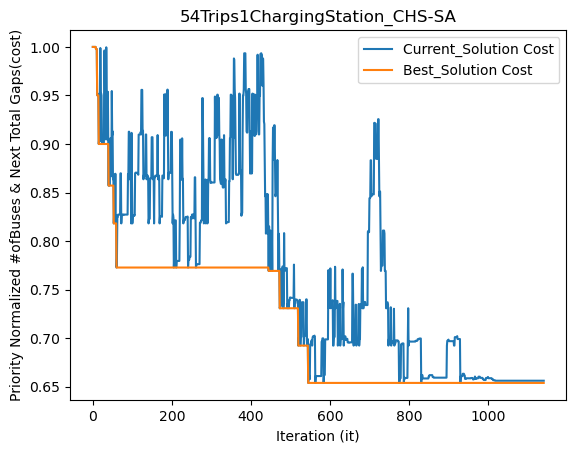

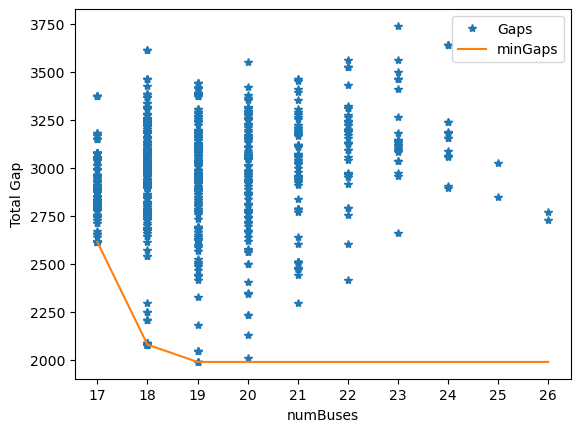

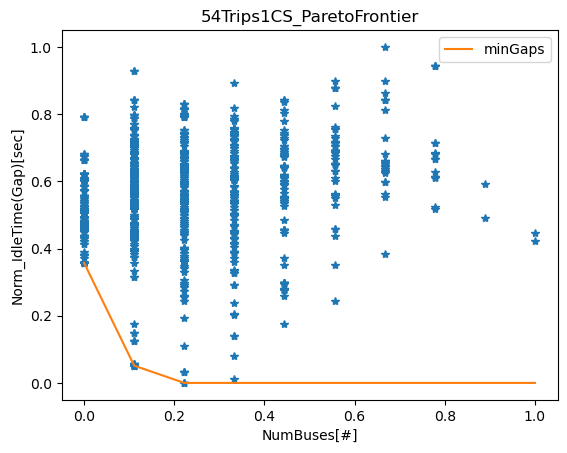

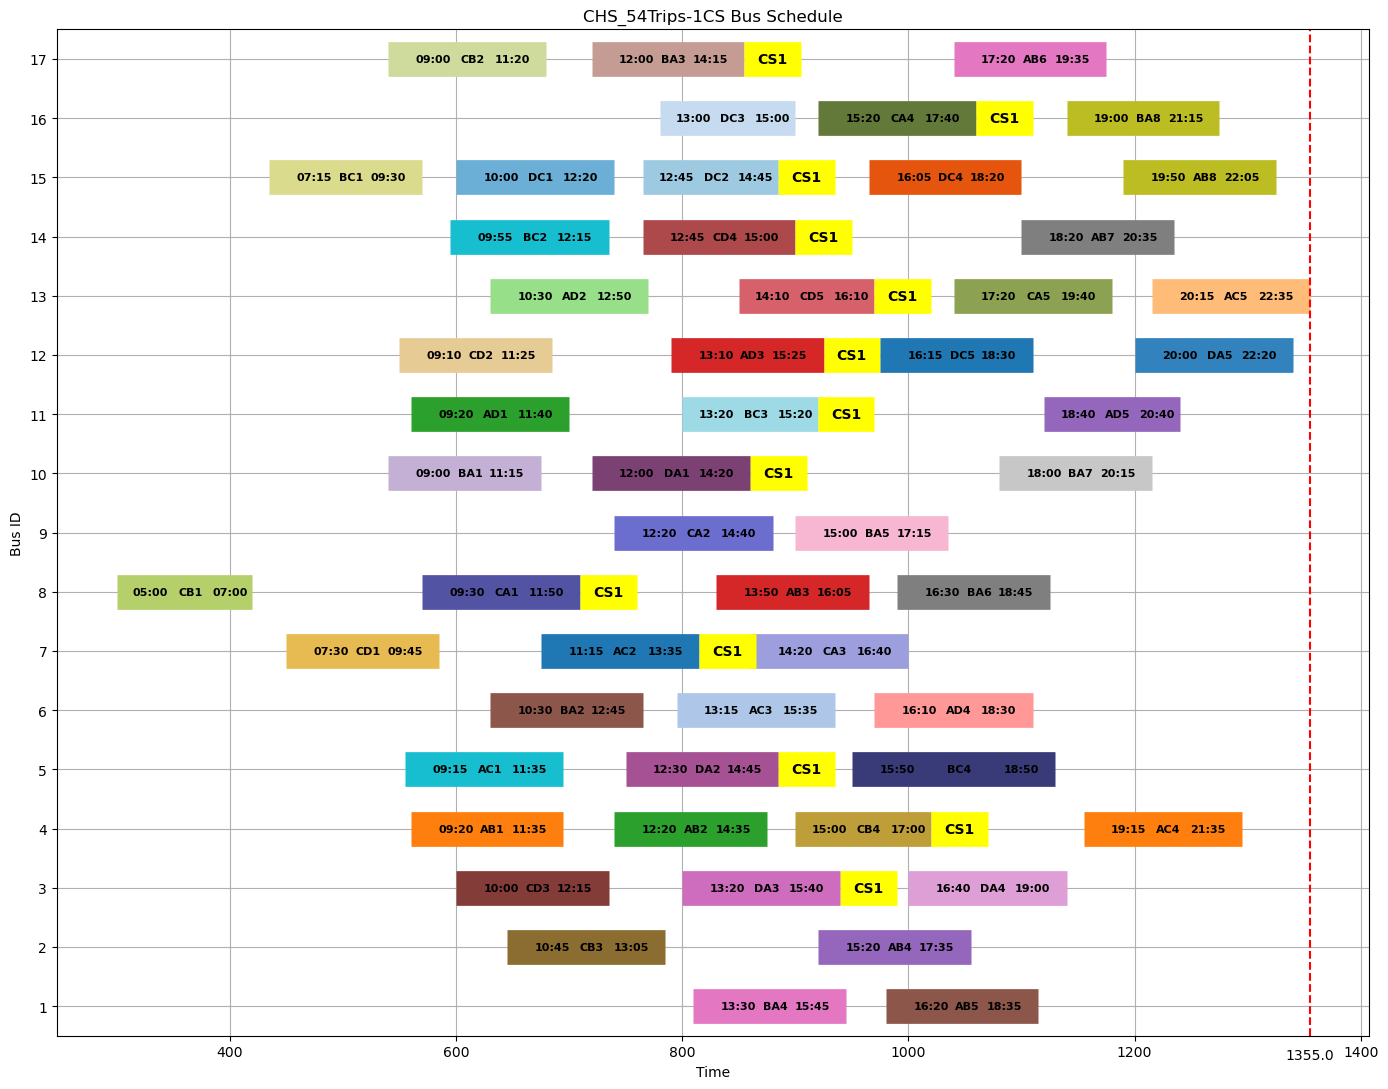

In [15]:
###################################################### CHS-SA ####################################################################

start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_54_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_54_1)
end_time = time.time()
g_T54CS1_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T54CS1_time)} seconds")
print(f"number of buses = {len(schedules_54_1)}")
print(schedules_54_1)
print('-'*100)
start_time = time.time()
print("starting simulated annealing....")
new_schedule_54_1, cost_54_1, cost_diffs_54_1, temp_54_1, it_54_1, costs_54_1, solution_spaces_54_1, best_costs_54_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T54CS1_time = (end_time-start_time)+g_T54CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T54CS1_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_54_1} with number of buses = {len(new_schedule_54_1)}")

fig1, ax1 = plt.subplots()
ax1.plot(range(it_54_1), costs_54_1, label="Current_Solution Cost")
ax1.plot(range(it_54_1), best_costs_54_1, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("54Trips1ChargingStation_CHS-SA")
ax1.legend(loc="upper right")
#plt.savefig("54Trips1CS.png")

FiftyTrips_1cs_df = visualizeSolution(solution_spaces_54_1[1:], "54Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_54_1cs = visualizeResult(new_schedule_54_1, all_schs_1cs, "CHS_54Trips-1CS", cs_deadheads)

trips54_1_df = newdf_54_1cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips54_1_df['next_dep'] = trips54_1_df['next_dep'].fillna(0)
trips54_1_df['difference'] = trips54_1_df['next_dep'] - trips54_1_df['arr_time']
trips54_1_df['difference'] = trips54_1_df['difference'].apply(lambda x: 0 if x < 0 else x)
chs_54Trips1cs_IDLE_soln = trips54_1_df.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

chs_54Trips1cs_IDLE_soln.sort_values(['gapTime'], ascending=False)

dict_keys([55, 56, 57])
{55: {'name': 'CS1', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'}, 56: {'name': 'CS1a', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'}, 57: {'name': 'CS2b', 'type': 'cs', 'duration': 50, 'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal B', 'arr_term': 'Terminal B'}}
{'Terminal A': {'CS1': 40, 'CS1a': 10, 'CS2b': 75, 'CS3c': 75, 'CS4d': 75}, 'Terminal B': {'CS1': 40, 'CS1a': 75, 'CS2b': 10, 'CS3c': 75, 'CS4d': 75}, 'Terminal C': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 10, 'CS4d': 75}, 'Terminal D': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 75, 'CS4d': 10}}
{(1, 2, 55): {'duration': 40}, (1, 3, 55): {'duration': 40}, (1, 4, 55): {'duration': 40}, (1, 5, 55): {'duration': 40}, (1, 6, 55): {'duration': 40}, (1, 7, 55): {'duration': 40}, (1, 8, 55): {'duration': 40}, (1, 11, 55): {'duration': 40}, (1, 12, 55): {'duration': 40}, (1, 13, 5

Fri Aug 15 23:10:21 2025
Time elapse to compute the solution = 10.606199026107788 seconds
number of buses = 18
[[(0, 36), (36, 1), (1, 2, 57), (2, 39), (39, 35), (35, 13), (13, 0)], [(0, 27), (27, 10), (10, 33, 55), (33, 6), (6, 49), (49, 0)], [(0, 40), (40, 15), (15, 3, 55), (3, 24), (24, 8), (8, 0)], [(0, 37), (37, 11), (11, 5, 55), (5, 12), (12, 0)], [(0, 19), (19, 16), (16, 53, 55), (53, 18), (18, 0)], [(0, 41), (41, 21), (21, 4, 55), (4, 7), (7, 0)], [(0, 9), (9, 22), (22, 17, 56), (17, 26), (26, 0)], [(0, 14), (14, 32), (32, 34, 55), (34, 25), (25, 0)], [(0, 31), (31, 29), (29, 48, 55), (48, 0)], [(0, 28), (28, 43), (43, 30, 55), (30, 0)], [(0, 50), (50, 47), (47, 54, 56), (54, 0)], [(0, 42), (42, 23), (23, 0)], [(0, 20), (20, 44), (44, 0)], [(0, 38), (38, 0)], [(0, 45), (45, 0)], [(0, 46), (46, 0)], [(0, 51), (51, 0)], [(0, 52), (52, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteratio

diff neigh vs. current = 0.0009926098594976729
current temp = 87.75210229989679
----------------------------------------------------------------------------------------------------
Iteration 15...
insertion...
proposed solution = [[9, 22, 0], [42, 23, 0], [45, 39, 0], [46, 30, 0], [38, 17, 0], [28, 43, 55, 25, 0], [36, 1, 57, 51, 0], [20, 44, 55, 35, 13, 0], [27, 10, 55, 33, 6, 49, 0], [40, 15, 55, 3, 24, 8, 0], [37, 11, 55, 5, 12, 0], [19, 16, 55, 53, 18, 0], [41, 21, 55, 4, 7, 0], [14, 32, 0], [31, 29, 57, 48, 0], [50, 47, 56, 54, 26, 0], [2, 0], [52, 34, 0]]
diff neigh vs. current = 0.004688869412795782
current temp = 86.87458127689783
----------------------------------------------------------------------------------------------------
Iteration 16...
swapping other CS...
proposed solution = [[9, 22, 0], [42, 23, 0], [45, 39, 0], [46, 30, 0], [38, 17, 0], [14, 32, 0], [2, 0], [52, 34, 0], [28, 43, 55, 25, 0], [36, 1, 55, 51, 0], [20, 44, 55, 35, 13, 0], [27, 10, 55, 33, 6, 49, 0], [4

proposed solution = [[9, 22, 55, 26, 0], [42, 23, 0], [45, 39, 0], [46, 30, 0], [38, 17, 0], [52, 34, 0], [36, 1, 0], [31, 29, 0], [27, 10, 0], [33, 0], [51, 6, 0], [19, 16, 0], [14, 32, 55, 53, 18, 0], [2, 48, 55, 49, 0], [28, 43, 57, 25, 0], [20, 44, 55, 35, 13, 0], [40, 15, 55, 3, 24, 8, 0], [37, 11, 55, 5, 12, 0], [41, 21, 56, 4, 7, 0], [50, 47, 0], [54, 0]]
diff neigh vs. current = -0.002155748663101531
current temp = 73.97003733882804
----------------------------------------------------------------------------------------------------
Iteration 32...
insertion...
proposed solution = [[9, 22, 55, 26, 0], [42, 23, 0], [45, 39, 0], [46, 30, 0], [38, 17, 0], [52, 34, 0], [36, 1, 0], [31, 29, 0], [27, 10, 55, 33, 0], [51, 6, 0], [19, 16, 0], [14, 32, 55, 53, 18, 0], [2, 48, 55, 49, 0], [28, 43, 57, 25, 0], [20, 44, 55, 35, 13, 0], [40, 15, 55, 3, 24, 8, 0], [37, 11, 55, 5, 12, 0], [41, 21, 56, 4, 7, 0], [50, 47, 0], [54, 0]]
diff neigh vs. current = 0.002155748663101531
current temp = 

proposed solution = [[45, 39, 0], [46, 30, 0], [38, 17, 0], [52, 34, 0], [50, 47, 0], [27, 10, 0], [20, 44, 0], [40, 15, 0], [16, 6, 0], [33, 0], [36, 1, 56, 23, 0], [19, 51, 55, 25, 0], [9, 22, 56, 54, 26, 0], [14, 32, 0], [41, 2, 57, 48, 49, 0], [28, 43, 55, 35, 13, 0], [37, 11, 55, 5, 12, 0], [21, 4, 55, 7, 0], [42, 3, 57, 24, 8, 0], [53, 18, 0], [31, 29, 0]]
diff neigh vs. current = -0.0
current temp = 63.618548606387115
----------------------------------------------------------------------------------------------------
Iteration 47...
swapping other CS...
proposed solution = [[45, 39, 0], [46, 30, 0], [38, 17, 0], [52, 34, 0], [50, 47, 0], [27, 10, 0], [20, 44, 0], [40, 15, 0], [16, 6, 0], [33, 0], [14, 32, 0], [53, 18, 0], [31, 29, 0], [36, 1, 57, 23, 0], [19, 51, 57, 25, 0], [9, 22, 56, 54, 26, 0], [41, 2, 55, 48, 49, 0], [28, 43, 57, 35, 13, 0], [37, 11, 55, 5, 12, 0], [21, 4, 57, 7, 0], [42, 3, 57, 24, 8, 0]]
diff neigh vs. current = -0.0
current temp = 62.98236312032324
-----

diff neigh vs. current = -0.0
current temp = 55.26834771623852
----------------------------------------------------------------------------------------------------
Iteration 61...
insertion...
proposed solution = [[52, 34, 0], [50, 47, 0], [27, 10, 0], [20, 44, 0], [40, 15, 55, 17, 0], [16, 6, 0], [38, 33, 55, 7, 0], [45, 39, 0], [46, 30, 0], [14, 32, 56, 23, 0], [1, 21, 56, 4, 0], [31, 29, 55, 53, 18, 0], [19, 51, 56, 25, 0], [9, 22, 56, 54, 26, 0], [41, 2, 56, 48, 49, 0], [28, 43, 55, 35, 13, 0], [37, 11, 55, 5, 12, 0], [36, 42, 55, 3, 24, 8, 0]]
diff neigh vs. current = 0.04618135671435164
current temp = 54.71566423907614
----------------------------------------------------------------------------------------------------
Iteration 62...
insertion...
proposed solution = [[52, 34, 0], [50, 47, 0], [27, 10, 0], [20, 44, 0], [40, 15, 55, 17, 0], [16, 6, 0], [38, 33, 55, 7, 0], [45, 39, 0], [46, 30, 0], [14, 32, 56, 23, 0], [1, 21, 56, 4, 0], [31, 29, 55, 53, 18, 0], [19, 51, 56, 25, 0],

diff neigh vs. current = -0.0014036302107368615
current temp = 47.05866415856501
----------------------------------------------------------------------------------------------------
Iteration 77...
swapping recharging task...
proposed solution = [[20, 44, 0], [15, 16, 0], [45, 39, 0], [46, 30, 0], [36, 42, 0], [47, 0], [3, 24, 0], [4, 8, 0], [50, 52, 55, 17, 0], [27, 10, 55, 34, 18, 0], [40, 38, 55, 33, 7, 0], [31, 29, 0], [19, 51, 56, 25, 0], [9, 22, 56, 54, 26, 0], [41, 2, 55, 48, 49, 0], [37, 11, 55, 5, 12, 0], [28, 43, 55, 35, 13, 0], [14, 32, 56, 23, 0], [1, 21, 56, 6, 0], [53, 0]]
diff neigh vs. current = -0.04309721581295167
current temp = 46.58807751697936
----------------------------------------------------------------------------------------------------
Iteration 78...
swapping other CS...
proposed solution = [[20, 44, 0], [15, 16, 0], [45, 39, 0], [46, 30, 0], [36, 42, 0], [47, 0], [3, 24, 0], [4, 8, 0], [31, 29, 0], [53, 0], [50, 52, 55, 17, 0], [27, 10, 56, 34, 18, 0], [40

diff neigh vs. current = -0.0006768189509306355
current temp = 40.473197267832404
----------------------------------------------------------------------------------------------------
Iteration 92...
swapping recharging task...
proposed solution = [[15, 16, 0], [45, 39, 0], [46, 30, 0], [4, 8, 0], [41, 2, 0], [17, 0], [36, 42, 57, 3, 0], [31, 29, 55, 53, 0], [50, 52, 56, 48, 0], [1, 21, 0], [20, 47, 55, 35, 13, 0], [27, 10, 55, 34, 18, 0], [40, 38, 57, 33, 7, 0], [19, 51, 56, 25, 0], [9, 22, 56, 54, 26, 0], [37, 11, 55, 5, 12, 0], [28, 43, 55, 6, 13, 0], [14, 32, 56, 23, 49, 0], [44, 0], [24, 0]]
diff neigh vs. current = -0.040897554222427246
current temp = 40.06846529515408
----------------------------------------------------------------------------------------------------
Iteration 93...
insertion...
proposed solution = [[15, 16, 0], [45, 39, 0], [46, 30, 0], [4, 8, 0], [41, 2, 0], [36, 42, 57, 3, 0], [31, 29, 55, 53, 0], [50, 52, 56, 48, 0], [1, 21, 55, 17, 0], [20, 47, 55, 35, 13, 0

diff neigh vs. current = -0.041493715287927446
current temp = 35.16092065580225
----------------------------------------------------------------------------------------------------
Iteration 106...
insertion...
proposed solution = [[15, 16, 55, 18, 0], [45, 39, 0], [46, 30, 0], [44, 24, 0], [9, 4, 55, 8, 0], [41, 2, 55, 54, 0], [36, 42, 56, 3, 0], [50, 52, 0], [1, 21, 0], [20, 47, 56, 35, 13, 0], [27, 10, 55, 34, 0], [40, 38, 55, 33, 7, 0], [19, 51, 57, 25, 0], [37, 11, 55, 5, 12, 0], [28, 43, 56, 6, 13, 0], [14, 32, 56, 23, 49, 0], [31, 29, 55, 53, 26, 0], [48, 0], [22, 17, 0]]
diff neigh vs. current = 0.046704180064308654
current temp = 34.80931144924423
----------------------------------------------------------------------------------------------------
Iteration 107...
swapping recharging task...
proposed solution = [[15, 16, 55, 18, 0], [45, 39, 0], [46, 30, 0], [44, 24, 0], [9, 4, 55, 8, 0], [41, 2, 55, 54, 49, 0], [36, 42, 56, 3, 0], [50, 52, 0], [1, 21, 0], [20, 47, 56, 35, 13, 

diff neigh vs. current = -0.010310359289808502
current temp = 30.545902592830487
----------------------------------------------------------------------------------------------------
Iteration 120...
swapping recharging task...
proposed solution = [[46, 30, 0], [44, 24, 0], [1, 21, 56, 4, 0], [14, 32, 56, 39, 0], [42, 22, 56, 17, 0], [15, 16, 55, 18, 0], [41, 2, 56, 54, 49, 0], [20, 47, 56, 35, 13, 0], [27, 10, 55, 23, 0], [40, 38, 55, 33, 7, 0], [37, 11, 55, 5, 12, 0], [28, 43, 56, 6, 0], [31, 29, 55, 53, 26, 0], [45, 34, 56, 25, 0], [19, 51, 56, 48, 13, 0], [36, 50, 0], [9, 52, 55, 8, 0], [3, 0]]
diff neigh vs. current = -0.039857402488466476
current temp = 30.240443566902183
----------------------------------------------------------------------------------------------------
Iteration 121...
swapping recharging task...
proposed solution = [[46, 30, 0], [44, 24, 0], [1, 21, 56, 4, 0], [14, 32, 56, 39, 0], [42, 22, 56, 17, 0], [15, 16, 55, 18, 0], [41, 2, 56, 54, 49, 0], [20, 47, 56, 35

diff neigh vs. current = -0.002345169858800511
current temp = 26.536624974770554
----------------------------------------------------------------------------------------------------
Iteration 134...
insertion...
proposed solution = [[46, 30, 0], [44, 24, 0], [27, 10, 0], [31, 29, 0], [23, 0], [14, 32, 56, 39, 0], [1, 21, 55, 4, 0], [42, 22, 56, 17, 0], [15, 16, 55, 18, 0], [41, 2, 56, 54, 49, 0], [40, 38, 55, 33, 7, 0], [37, 11, 55, 5, 12, 0], [45, 34, 56, 25, 0], [19, 51, 55, 48, 13, 0], [36, 50, 55, 3, 26, 0], [9, 52, 55, 53, 8, 0], [28, 43, 55, 6, 13, 0], [20, 47, 55, 35, 0]]
diff neigh vs. current = 0.0458234307283657
current temp = 26.271258725022847
----------------------------------------------------------------------------------------------------
Iteration 135...
insertion...
proposed solution = [[46, 30, 0], [44, 24, 0], [27, 10, 0], [23, 0], [14, 32, 56, 39, 0], [1, 21, 55, 4, 0], [42, 22, 56, 17, 0], [15, 16, 55, 18, 0], [41, 2, 56, 54, 49, 0], [40, 38, 55, 33, 7, 0], [37, 1

diff neigh vs. current = -0.044376485390745124
current temp = 23.053581831852604
----------------------------------------------------------------------------------------------------
Iteration 148...
swapping recharging task...
proposed solution = [[14, 32, 0], [1, 21, 55, 23, 26, 0], [28, 43, 0], [46, 30, 0], [4, 0], [52, 6, 0], [44, 13, 0], [10, 39, 0], [42, 22, 56, 17, 0], [15, 16, 55, 53, 18, 0], [41, 2, 57, 54, 49, 0], [40, 38, 56, 33, 7, 0], [37, 11, 0], [9, 45, 55, 34, 25, 0], [19, 51, 57, 48, 13, 0], [36, 50, 55, 12, 0], [27, 20, 56, 47, 35, 0], [31, 29, 55, 24, 8, 0], [3, 0], [5, 0]]
diff neigh vs. current = -0.0
current temp = 22.82304601353408
----------------------------------------------------------------------------------------------------
Iteration 149...
insertion...
proposed solution = [[14, 32, 0], [1, 21, 55, 23, 26, 0], [28, 43, 0], [46, 30, 0], [52, 6, 0], [44, 13, 0], [10, 39, 0], [42, 22, 56, 17, 0], [15, 16, 55, 53, 18, 0], [41, 2, 57, 54, 49, 0], [40, 38, 56, 33

diff neigh vs. current = -0.040205446727185956
current temp = 19.82742565889145
----------------------------------------------------------------------------------------------------
Iteration 163...
insertion...
proposed solution = [[52, 6, 0], [10, 39, 0], [31, 29, 0], [37, 11, 0], [46, 30, 0], [14, 32, 56, 4, 0], [1, 21, 55, 23, 26, 0], [28, 43, 0], [41, 2, 56, 54, 49, 0], [40, 38, 56, 33, 7, 0], [9, 45, 56, 34, 25, 0], [19, 51, 56, 53, 18, 0], [27, 20, 56, 47, 35, 0], [50, 3, 57, 24, 8, 0], [36, 42, 55, 22, 5, 12, 0], [15, 16, 55, 48, 0], [17, 0], [44, 13, 0]]
diff neigh vs. current = -0.0
current temp = 19.629151402302536
----------------------------------------------------------------------------------------------------
Iteration 164...
swapping recharging task...
proposed solution = [[52, 6, 0], [10, 39, 55, 25, 0], [31, 29, 0], [37, 11, 0], [46, 30, 0], [14, 32, 56, 4, 0], [1, 21, 55, 23, 26, 0], [28, 43, 0], [41, 2, 56, 54, 49, 0], [40, 38, 56, 33, 7, 0], [9, 45, 0], [19, 51, 56

diff neigh vs. current = -0.0
current temp = 17.05274308895864
----------------------------------------------------------------------------------------------------
Iteration 178...
swapping other CS...
proposed solution = [[10, 39, 0], [31, 29, 0], [46, 34, 0], [52, 30, 0], [47, 0], [37, 11, 57, 35, 0], [14, 32, 56, 4, 0], [1, 21, 56, 23, 26, 0], [28, 43, 55, 17, 0], [41, 2, 57, 54, 49, 0], [40, 38, 57, 33, 7, 0], [9, 45, 56, 6, 0], [19, 51, 55, 53, 18, 0], [50, 3, 57, 24, 8, 0], [36, 42, 57, 22, 5, 12, 0], [15, 16, 57, 25, 0], [27, 20, 56, 44, 48, 13, 0]]
diff neigh vs. current = -0.0
current temp = 16.882215658069054
----------------------------------------------------------------------------------------------------
Iteration 179...
insertion...
proposed solution = [[10, 39, 0], [31, 29, 0], [46, 34, 0], [52, 30, 0], [37, 11, 57, 35, 0], [14, 32, 56, 4, 0], [1, 21, 56, 23, 26, 0], [28, 43, 55, 17, 0], [41, 2, 57, 54, 49, 0], [40, 38, 57, 33, 7, 0], [9, 45, 56, 6, 0], [19, 51, 55, 53,

diff neigh vs. current = -0.005115691761654495
current temp = 14.519690621578262
----------------------------------------------------------------------------------------------------
Iteration 194...
insertion...
proposed solution = [[31, 29, 0], [46, 34, 0], [52, 30, 0], [37, 11, 0], [50, 47, 56, 17, 0], [1, 21, 56, 23, 26, 0], [28, 43, 56, 35, 0], [41, 2, 55, 54, 49, 0], [40, 38, 55, 33, 7, 0], [9, 45, 56, 6, 0], [19, 51, 56, 53, 18, 0], [36, 42, 57, 22, 5, 12, 0], [15, 16, 57, 25, 0], [14, 32, 55, 4, 8, 0], [3, 24, 0], [27, 20, 55, 44, 48, 13, 0], [10, 39, 0]]
diff neigh vs. current = -0.0
current temp = 14.374493715362478
----------------------------------------------------------------------------------------------------
Iteration 195...
insertion...
proposed solution = [[46, 34, 0], [52, 30, 0], [37, 11, 0], [50, 47, 56, 17, 0], [1, 21, 56, 23, 26, 0], [28, 43, 56, 35, 0], [41, 2, 55, 54, 49, 0], [40, 38, 55, 33, 7, 0], [9, 45, 56, 6, 0], [19, 51, 56, 53, 18, 0], [36, 42, 57, 22, 5

diff neigh vs. current = -0.03910654562828464
current temp = 12.487781225895146
----------------------------------------------------------------------------------------------------
Iteration 209...
swapping other CS...
proposed solution = [[3, 24, 0], [10, 39, 0], [31, 29, 0], [19, 51, 0], [11, 17, 0], [28, 43, 0], [40, 38, 0], [52, 30, 0], [33, 0], [25, 0], [35, 0], [37, 46, 56, 34, 18, 0], [1, 21, 56, 23, 26, 0], [9, 45, 55, 54, 0], [36, 42, 55, 22, 5, 12, 0], [15, 16, 56, 7, 0], [14, 32, 55, 4, 8, 0], [27, 20, 57, 44, 48, 13, 0], [50, 47, 56, 53, 0], [41, 2, 56, 6, 49, 0]]
diff neigh vs. current = -0.0
current temp = 12.362903413636195
----------------------------------------------------------------------------------------------------
Iteration 210...
swapping other CS...
proposed solution = [[3, 24, 0], [10, 39, 0], [31, 29, 0], [19, 51, 0], [11, 17, 0], [28, 43, 0], [40, 38, 0], [52, 30, 0], [33, 0], [25, 0], [35, 0], [37, 46, 56, 34, 18, 0], [1, 21, 56, 23, 26, 0], [9, 45, 56, 54

diff neigh vs. current = -0.0056651423111050425
current temp = 10.526490184835902
----------------------------------------------------------------------------------------------------
Iteration 226...
insertion...
proposed solution = [[52, 30, 0], [47, 35, 0], [11, 17, 56, 13, 0], [40, 38, 55, 3, 24, 0], [37, 46, 56, 34, 18, 0], [1, 21, 56, 23, 26, 0], [9, 45, 56, 54, 0], [36, 42, 55, 22, 5, 12, 0], [15, 16, 57, 7, 0], [14, 32, 56, 4, 8, 0], [41, 2, 55, 6, 49, 0], [50, 44, 57, 25, 0], [31, 29, 57, 48, 0], [27, 20, 57, 33, 0], [19, 51, 55, 53, 0], [28, 43, 0], [10, 39, 0]]
diff neigh vs. current = -0.0
current temp = 10.421225282987542
----------------------------------------------------------------------------------------------------
Iteration 227...
insertion...
proposed solution = [[52, 30, 0], [47, 35, 0], [9, 11, 17, 55, 13, 0], [40, 38, 55, 3, 24, 0], [37, 46, 56, 34, 18, 0], [1, 21, 56, 23, 26, 0], [36, 42, 55, 22, 5, 12, 0], [15, 16, 57, 7, 0], [14, 32, 56, 4, 8, 0], [41, 2, 55, 

diff neigh vs. current = 0.0020578800081905158
current temp = 8.962861870232462
----------------------------------------------------------------------------------------------------
Iteration 242...
swapping recharging task...
proposed solution = [[47, 35, 0], [36, 42, 0], [28, 43, 0], [45, 54, 0], [52, 30, 0], [37, 46, 0], [34, 0], [27, 20, 0], [22, 5, 0], [9, 11, 17, 55, 13, 0], [40, 38, 0], [1, 21, 55, 23, 26, 0], [15, 16, 55, 7, 0], [14, 32, 56, 4, 8, 0], [41, 2, 57, 39, 6, 49, 0], [50, 44, 57, 25, 0], [31, 29, 57, 48, 0], [19, 51, 57, 53, 12, 0], [10, 33, 55, 18, 0], [3, 0], [24, 0]]
diff neigh vs. current = -0.08150979455327267
current temp = 8.873233251530138
----------------------------------------------------------------------------------------------------
Iteration 243...
swapping other CS...
proposed solution = [[47, 35, 0], [36, 42, 0], [28, 43, 0], [45, 54, 0], [52, 30, 0], [37, 46, 0], [34, 0], [27, 20, 0], [22, 5, 0], [40, 38, 0], [3, 0], [24, 0], [9, 11, 17, 57, 13, 0], 

proposed solution = [[28, 43, 0], [45, 54, 0], [52, 30, 0], [38, 22, 55, 18, 0], [42, 3, 57, 24, 0], [27, 20, 56, 47, 35, 0], [9, 11, 17, 55, 13, 0], [1, 21, 55, 23, 26, 0], [14, 32, 56, 39, 6, 0], [50, 44, 57, 25, 0], [31, 29, 57, 48, 0], [19, 51, 57, 53, 12, 0], [10, 33, 57, 8, 0], [40, 15, 16, 55, 5, 0], [36, 41, 55, 2, 4, 49, 0], [37, 46, 56, 34, 7, 0]]
diff neigh vs. current = -0.007525083612040184
current temp = 7.63149839065938
----------------------------------------------------------------------------------------------------
Iteration 258...
insertion...
proposed solution = [[28, 43, 0], [45, 54, 0], [38, 22, 55, 18, 0], [42, 3, 57, 24, 0], [27, 20, 56, 47, 35, 0], [9, 11, 17, 55, 13, 0], [1, 21, 55, 23, 26, 0], [14, 32, 56, 39, 6, 0], [50, 44, 57, 25, 0], [31, 29, 57, 48, 0], [19, 51, 57, 53, 12, 0], [10, 33, 57, 8, 0], [40, 15, 16, 55, 5, 0], [36, 41, 55, 2, 4, 49, 0], [37, 46, 56, 34, 7, 0], [52, 30, 0]]
diff neigh vs. current = -0.0
current temp = 7.5551834067527865
------

diff neigh vs. current = -0.00990376083543787
current temp = 6.6298322720385325
----------------------------------------------------------------------------------------------------
Iteration 272...
swapping other CS...
proposed solution = [[52, 12, 0], [16, 53, 0], [14, 32, 0], [28, 43, 57, 18, 0], [42, 3, 57, 24, 0], [27, 20, 56, 47, 35, 0], [9, 11, 17, 57, 13, 0], [1, 21, 56, 23, 26, 0], [50, 44, 57, 25, 0], [31, 29, 55, 48, 0], [19, 51, 56, 5, 0], [10, 33, 55, 8, 0], [36, 41, 55, 2, 4, 49, 0], [37, 46, 56, 34, 7, 0], [38, 22, 56, 54, 0], [45, 39, 57, 6, 0], [40, 15, 55, 30, 0]]
diff neigh vs. current = -0.0
current temp = 6.563533949318147
----------------------------------------------------------------------------------------------------
Iteration 273...
swapping other CS...
proposed solution = [[52, 12, 0], [16, 53, 0], [14, 32, 0], [28, 43, 55, 18, 0], [42, 3, 57, 24, 0], [27, 20, 56, 47, 35, 0], [9, 11, 17, 55, 13, 0], [1, 21, 55, 23, 26, 0], [50, 44, 56, 25, 0], [31, 29, 57, 48

diff neigh vs. current = -0.0
current temp = 5.759639025694116
----------------------------------------------------------------------------------------------------
Iteration 286...
insertion...
proposed solution = [[52, 12, 0], [16, 53, 0], [14, 32, 0], [37, 46, 0], [38, 22, 0], [29, 48, 0], [2, 5, 55, 49, 0], [31, 4, 0], [19, 51, 55, 54, 0], [28, 43, 57, 18, 0], [42, 3, 57, 24, 0], [27, 20, 56, 47, 35, 0], [9, 11, 17, 55, 13, 0], [1, 21, 56, 23, 26, 0], [50, 44, 55, 25, 0], [10, 33, 57, 8, 0], [36, 41, 56, 34, 7, 0], [45, 39, 57, 6, 0], [40, 15, 57, 30, 0]]
diff neigh vs. current = 0.049925484351713845
current temp = 5.7020426354371745
----------------------------------------------------------------------------------------------------
Iteration 287...
insertion...
proposed solution = [[16, 53, 0], [14, 32, 0], [37, 46, 0], [38, 22, 0], [29, 48, 0], [2, 5, 55, 49, 0], [31, 4, 0], [19, 51, 55, 54, 0], [28, 43, 57, 18, 0], [42, 3, 57, 24, 0], [27, 20, 56, 47, 35, 0], [9, 11, 17, 55, 13, 

diff neigh vs. current = -0.0037290222251020744
current temp = 4.9040894071285726
----------------------------------------------------------------------------------------------------
Iteration 302...
insertion...
proposed solution = [[38, 22, 0], [31, 32, 55, 4, 0], [37, 46, 55, 35, 0], [20, 16, 55, 53, 0], [21, 23, 55, 26, 0], [14, 2, 55, 5, 0], [19, 51, 55, 54, 49, 0], [28, 43, 55, 18, 0], [42, 3, 57, 24, 0], [9, 11, 17, 57, 13, 0], [50, 44, 57, 25, 0], [27, 10, 55, 33, 8, 0], [36, 41, 56, 52, 34, 7, 0], [1, 45, 56, 39, 6, 0], [40, 15, 57, 30, 12, 0], [47, 48, 0], [29, 0]]
diff neigh vs. current = -0.001043219076006019
current temp = 4.8550485130572865
----------------------------------------------------------------------------------------------------
Iteration 303...
swapping recharging task...
proposed solution = [[38, 22, 0], [31, 32, 55, 4, 0], [37, 46, 55, 35, 0], [20, 16, 55, 53, 0], [21, 23, 55, 26, 0], [14, 2, 0], [19, 51, 55, 54, 49, 0], [28, 43, 55, 18, 0], [42, 3, 57, 24, 

diff neigh vs. current = -0.003800298062593077
current temp = 4.217803066508771
----------------------------------------------------------------------------------------------------
Iteration 317...
insertion...
proposed solution = [[9, 11, 17, 0], [47, 48, 0], [14, 2, 56, 5, 0], [50, 29, 56, 25, 0], [31, 32, 56, 4, 0], [37, 46, 57, 35, 0], [20, 16, 55, 53, 0], [21, 23, 56, 26, 0], [19, 51, 57, 54, 49, 0], [28, 43, 56, 18, 0], [42, 3, 57, 24, 0], [27, 10, 55, 33, 8, 0], [36, 41, 57, 52, 34, 7, 0], [1, 45, 55, 39, 6, 0], [40, 15, 56, 30, 12, 0], [38, 44, 56, 13, 0], [22, 0]]
diff neigh vs. current = -0.0
current temp = 4.175625035843683
----------------------------------------------------------------------------------------------------
Iteration 318...
insertion...
proposed solution = [[9, 11, 17, 0], [47, 48, 0], [14, 2, 56, 5, 0], [50, 29, 56, 25, 0], [37, 46, 57, 35, 0], [20, 16, 55, 53, 0], [21, 23, 56, 26, 0], [19, 51, 57, 54, 49, 0], [28, 43, 56, 18, 0], [42, 3, 57, 24, 0], [27, 10

diff neigh vs. current = -0.0
current temp = 3.6275567655825145
----------------------------------------------------------------------------------------------------
Iteration 332...
insertion...
proposed solution = [[21, 23, 0], [37, 46, 0], [11, 17, 0], [1, 22, 56, 24, 0], [14, 2, 55, 5, 0], [50, 29, 57, 25, 0], [20, 16, 55, 53, 26, 0], [19, 51, 55, 54, 49, 0], [28, 43, 56, 18, 0], [36, 41, 57, 52, 34, 7, 0], [40, 15, 57, 30, 12, 0], [31, 32, 56, 4, 0], [9, 45, 56, 39, 6, 0], [42, 3, 57, 48, 8, 0], [27, 10, 55, 33, 35, 0], [38, 44, 55, 13, 0], [47, 0]]
diff neigh vs. current = -0.0026825633383009695
current temp = 3.591281197926689
----------------------------------------------------------------------------------------------------
Iteration 333...
insertion...
proposed solution = [[21, 23, 0], [37, 46, 0], [11, 17, 0], [1, 22, 56, 24, 0], [14, 2, 55, 5, 0], [50, 29, 57, 25, 0], [20, 16, 55, 53, 26, 0], [19, 51, 55, 54, 49, 0], [28, 43, 56, 18, 0], [36, 41, 57, 52, 34, 7, 0], [40, 15, 

diff neigh vs. current = -0.0
current temp = 3.1199105031747707
----------------------------------------------------------------------------------------------------
Iteration 347...
insertion...
proposed solution = [[11, 17, 0], [14, 2, 0], [47, 5, 0], [37, 21, 55, 23, 0], [1, 22, 56, 24, 0], [50, 29, 55, 25, 0], [20, 16, 55, 53, 26, 0], [19, 51, 55, 54, 49, 0], [28, 43, 55, 18, 0], [36, 41, 57, 52, 34, 7, 0], [40, 15, 56, 30, 12, 0], [31, 32, 55, 4, 0], [9, 45, 55, 39, 6, 0], [42, 3, 57, 48, 8, 0], [27, 10, 55, 33, 35, 0], [38, 44, 56, 13, 0], [46, 0]]
diff neigh vs. current = -0.0
current temp = 3.088711398143023
----------------------------------------------------------------------------------------------------
Iteration 348...
insertion...
proposed solution = [[11, 17, 0], [14, 2, 0], [47, 5, 0], [37, 21, 55, 23, 0], [1, 22, 56, 24, 0], [50, 29, 55, 25, 0], [20, 16, 55, 53, 26, 0], [19, 51, 55, 54, 49, 0], [28, 43, 55, 18, 0], [36, 41, 57, 52, 34, 7, 0], [40, 15, 56, 30, 12, 0], [3

diff neigh vs. current = -0.08454610250761363
current temp = 2.6833050939885674
----------------------------------------------------------------------------------------------------
Iteration 362...
swapping other CS...
proposed solution = [[14, 2, 0], [47, 5, 0], [50, 29, 0], [22, 25, 0], [52, 0], [11, 24, 0], [9, 45, 0], [4, 0], [37, 21, 0], [20, 16, 0], [34, 7, 0], [53, 0], [23, 0], [36, 41, 57, 44, 6, 13, 0], [19, 51, 55, 54, 49, 0], [28, 43, 56, 18, 0], [40, 15, 57, 30, 12, 0], [31, 32, 55, 17, 0], [42, 3, 57, 48, 8, 0], [27, 10, 55, 33, 35, 0], [38, 39, 57, 6, 13, 0], [1, 46, 57, 26, 0]]
diff neigh vs. current = -0.0
current temp = 2.656472043048682
----------------------------------------------------------------------------------------------------
Iteration 363...
swapping other CS...
proposed solution = [[14, 2, 0], [47, 5, 0], [50, 29, 0], [22, 25, 0], [52, 0], [11, 24, 0], [9, 45, 0], [4, 0], [37, 21, 0], [20, 16, 0], [34, 7, 0], [53, 0], [23, 0], [36, 41, 55, 44, 6, 13, 0], [

proposed solution = [[47, 5, 0], [50, 29, 0], [22, 25, 0], [2, 4, 0], [37, 21, 55, 23, 0], [20, 16, 55, 24, 12, 0], [1, 52, 55, 53, 0], [36, 41, 56, 44, 6, 13, 0], [19, 51, 56, 54, 49, 0], [28, 43, 57, 18, 0], [40, 15, 55, 34, 0], [31, 32, 56, 17, 26, 0], [42, 3, 57, 48, 8, 0], [27, 10, 55, 33, 35, 0], [38, 39, 57, 6, 13, 0], [14, 11, 0], [9, 45, 55, 30, 0], [46, 7, 0]]
diff neigh vs. current = 0.0010529385083910547
current temp = 2.307798964136395
----------------------------------------------------------------------------------------------------
Iteration 377...
insertion...
proposed solution = [[50, 29, 0], [22, 25, 0], [2, 4, 0], [37, 21, 55, 23, 0], [20, 16, 55, 24, 12, 0], [1, 52, 55, 53, 0], [36, 41, 56, 44, 6, 13, 0], [19, 51, 56, 54, 49, 0], [28, 43, 57, 18, 0], [40, 15, 55, 34, 0], [31, 32, 56, 17, 26, 0], [42, 3, 57, 48, 8, 0], [27, 10, 55, 33, 35, 0], [38, 39, 57, 6, 13, 0], [14, 11, 55, 5, 0], [9, 45, 55, 30, 0], [46, 7, 0], [47, 0]]
diff neigh vs. current = -0.00476900149

diff neigh vs. current = -0.08156547657616808
current temp = 2.004890686806079
----------------------------------------------------------------------------------------------------
Iteration 391...
swapping other CS...
proposed solution = [[2, 4, 0], [37, 21, 0], [14, 11, 0], [29, 0], [5, 0], [26, 0], [32, 23, 56, 25, 0], [20, 16, 55, 24, 12, 0], [1, 52, 55, 53, 0], [19, 51, 57, 54, 49, 0], [28, 43, 56, 18, 0], [40, 15, 55, 22, 17, 0], [42, 3, 57, 48, 8, 0], [27, 10, 55, 33, 35, 0], [38, 39, 57, 6, 13, 0], [9, 45, 57, 30, 0], [31, 46, 56, 34, 7, 0], [36, 41, 55, 47, 6, 0], [50, 44, 55, 13, 0]]
diff neigh vs. current = -0.0
current temp = 1.9848417799380185
----------------------------------------------------------------------------------------------------
Iteration 392...
insertion...
proposed solution = [[2, 4, 0], [14, 11, 0], [29, 0], [5, 0], [21, 26, 0], [37, 32, 56, 23, 25, 0], [20, 16, 55, 24, 12, 0], [1, 52, 55, 53, 0], [19, 51, 57, 54, 49, 0], [28, 43, 56, 18, 0], [40, 15, 55, 2

diff neigh vs. current = 0.0061459210782091045
current temp = 1.724322985330079
----------------------------------------------------------------------------------------------------
Iteration 406...
insertion...
proposed solution = [[2, 4, 0], [14, 11, 0], [47, 5, 0], [1, 52, 0], [29, 7, 0], [41, 21, 56, 34, 26, 0], [19, 51, 55, 54, 49, 0], [28, 43, 0], [40, 15, 55, 22, 17, 0], [42, 3, 0], [27, 18, 0], [38, 39, 57, 6, 13, 0], [9, 45, 55, 48, 8, 0], [36, 50, 56, 44, 6, 13, 0], [37, 32, 56, 23, 25, 0], [31, 46, 0], [33, 35, 0], [30, 0], [20, 16, 55, 53, 0], [10, 24, 56, 12, 0]]
diff neigh vs. current = -0.0061459210782091045
current temp = 1.7070797554767783
----------------------------------------------------------------------------------------------------
Iteration 407...
insertion...
proposed solution = [[2, 4, 0], [14, 11, 0], [47, 5, 0], [1, 52, 0], [29, 7, 0], [41, 21, 56, 34, 26, 0], [19, 51, 55, 54, 49, 0], [28, 43, 0], [40, 15, 55, 22, 17, 0], [42, 3, 0], [38, 39, 57, 6, 13, 0], 

diff neigh vs. current = -0.003803537873388274
current temp = 1.4830183896331424
----------------------------------------------------------------------------------------------------
Iteration 421...
insertion...
proposed solution = [[14, 11, 0], [1, 52, 0], [29, 7, 0], [2, 4, 0], [41, 47, 56, 17, 0], [50, 39, 0], [40, 15, 55, 22, 6, 0], [42, 3, 55, 6, 0], [38, 33, 55, 35, 0], [19, 51, 55, 54, 49, 0], [28, 43, 57, 5, 13, 0], [9, 45, 56, 48, 8, 0], [37, 32, 56, 23, 25, 0], [31, 46, 56, 34, 26, 0], [27, 10, 44, 24, 56, 12, 0], [36, 20, 56, 16, 53, 18, 0], [21, 30, 55, 13, 0]]
diff neigh vs. current = -0.0
current temp = 1.468188205736811
----------------------------------------------------------------------------------------------------
Iteration 422...
swapping other CS...
proposed solution = [[14, 11, 0], [1, 52, 0], [29, 7, 0], [2, 4, 0], [50, 39, 0], [41, 47, 56, 17, 0], [40, 15, 55, 22, 6, 0], [42, 3, 57, 6, 0], [38, 33, 55, 35, 0], [19, 51, 56, 54, 49, 0], [28, 43, 56, 5, 13, 0], [9

diff neigh vs. current = -0.001791615369662436
current temp = 1.2754823560906536
----------------------------------------------------------------------------------------------------
Iteration 436...
insertion...
proposed solution = [[14, 11, 0], [1, 52, 55, 48, 8, 0], [42, 3, 0], [10, 39, 57, 6, 0], [51, 7, 0], [50, 29, 0], [2, 4, 57, 25, 0], [41, 47, 56, 17, 0], [40, 15, 55, 22, 6, 0], [38, 33, 55, 35, 0], [28, 43, 55, 5, 13, 0], [9, 45, 55, 54, 0], [37, 32, 56, 23, 49, 0], [31, 46, 56, 34, 26, 0], [36, 19, 55, 21, 30, 13, 0], [27, 20, 56, 16, 53, 18, 0], [44, 24, 56, 12, 0]]
diff neigh vs. current = -0.0
current temp = 1.2627275325297471
----------------------------------------------------------------------------------------------------
Iteration 437...
swapping other CS...
proposed solution = [[14, 11, 0], [42, 3, 0], [51, 7, 0], [50, 29, 0], [1, 52, 56, 48, 8, 0], [10, 39, 57, 6, 0], [2, 4, 57, 25, 0], [41, 47, 56, 17, 0], [40, 15, 55, 22, 6, 0], [38, 33, 56, 35, 0], [28, 43, 55, 5

proposed solution = [[42, 3, 0], [1, 52, 0], [44, 7, 0], [21, 25, 0], [30, 0], [2, 4, 0], [14, 32, 56, 23, 12, 0], [19, 51, 0], [50, 29, 55, 24, 0], [10, 39, 57, 6, 0], [41, 47, 56, 48, 8, 0], [40, 15, 55, 22, 6, 0], [38, 33, 56, 35, 0], [9, 45, 55, 54, 13, 0], [31, 46, 56, 34, 26, 0], [27, 20, 56, 16, 53, 18, 0], [37, 11, 57, 49, 0], [36, 28, 43, 55, 5, 13, 0], [17, 0], [8, 0]]
diff neigh vs. current = -0.08692088382038476
current temp = 1.0969892565533215
----------------------------------------------------------------------------------------------------
Iteration 451...
insertion...
proposed solution = [[42, 3, 0], [1, 52, 0], [44, 7, 0], [21, 25, 0], [2, 4, 0], [14, 32, 56, 23, 12, 0], [19, 51, 0], [50, 29, 55, 24, 0], [10, 39, 57, 6, 0], [41, 47, 56, 48, 8, 0], [40, 15, 55, 22, 6, 0], [38, 33, 56, 35, 0], [9, 45, 55, 54, 13, 0], [31, 46, 56, 34, 26, 0], [27, 20, 56, 16, 53, 18, 0], [37, 11, 57, 49, 0], [36, 28, 43, 55, 5, 13, 0], [17, 0], [30, 8, 0]]
diff neigh vs. current = 0.043

diff neigh vs. current = -0.010286399274282432
current temp = 0.9530048232832525
----------------------------------------------------------------------------------------------------
Iteration 465...
swapping other CS...
proposed solution = [[21, 25, 0], [2, 4, 0], [50, 29, 0], [45, 54, 0], [9, 51, 57, 53, 0], [42, 44, 57, 7, 0], [14, 32, 56, 23, 12, 0], [10, 39, 57, 6, 0], [41, 47, 56, 48, 8, 0], [40, 15, 55, 22, 6, 0], [38, 33, 55, 35, 0], [31, 46, 56, 34, 26, 0], [37, 11, 17, 55, 49, 0], [36, 28, 43, 55, 5, 13, 0], [27, 20, 56, 16, 30, 8, 0], [19, 3, 55, 18, 0], [1, 52, 55, 24, 13, 0]]
diff neigh vs. current = -0.0
current temp = 0.94347477505042
----------------------------------------------------------------------------------------------------
Iteration 466...
insertion...
proposed solution = [[21, 25, 0], [2, 4, 0], [50, 29, 55, 48, 0], [41, 45, 55, 54, 0], [9, 51, 55, 53, 8, 0], [42, 44, 57, 7, 0], [14, 32, 56, 23, 12, 0], [10, 39, 57, 6, 0], [40, 15, 55, 22, 6, 0], [38, 33, 55, 

diff neigh vs. current = -0.040708222639797786
current temp = 0.8279189497759656
----------------------------------------------------------------------------------------------------
Iteration 479...
insertion...
proposed solution = [[21, 25, 0], [20, 16, 55, 5, 0], [28, 43, 55, 30, 0], [50, 29, 0], [41, 45, 55, 54, 8, 0], [9, 51, 57, 53, 8, 0], [42, 44, 55, 7, 0], [10, 39, 57, 6, 0], [40, 15, 55, 22, 6, 0], [27, 38, 55, 33, 35, 13, 0], [31, 46, 56, 34, 26, 0], [37, 11, 17, 56, 49, 0], [19, 3, 56, 18, 0], [36, 1, 55, 52, 24, 13, 0], [47, 0], [2, 4, 55, 12, 0], [14, 32, 55, 48, 0], [23, 0]]
diff neigh vs. current = 0.04636169247715938
current temp = 0.819639760278206
----------------------------------------------------------------------------------------------------
Iteration 480...
swapping other CS...
proposed solution = [[21, 25, 0], [50, 29, 0], [47, 0], [23, 0], [20, 16, 55, 5, 0], [28, 43, 55, 30, 0], [41, 45, 57, 54, 8, 0], [9, 51, 56, 53, 8, 0], [42, 44, 57, 7, 0], [10, 39, 57, 6

diff neigh vs. current = -0.0008196721311475308
current temp = 0.71925112092996
----------------------------------------------------------------------------------------------------
Iteration 493...
insertion...
proposed solution = [[19, 3, 55, 25, 0], [45, 54, 0], [20, 16, 55, 5, 0], [28, 43, 55, 30, 0], [10, 39, 57, 6, 0], [40, 15, 55, 22, 6, 0], [27, 38, 56, 33, 35, 13, 0], [31, 46, 56, 34, 26, 0], [37, 11, 17, 56, 49, 0], [36, 1, 57, 52, 24, 13, 0], [2, 4, 55, 12, 0], [14, 32, 57, 48, 0], [50, 47, 56, 18, 0], [42, 29, 56, 8, 0], [9, 44, 56, 7, 0], [41, 51, 56, 53, 8, 0], [21, 23, 0]]
diff neigh vs. current = -0.0
current temp = 0.7120586097206604
----------------------------------------------------------------------------------------------------
Iteration 494...
swapping recharging task...
proposed solution = [[19, 3, 55, 25, 0], [45, 54, 0], [20, 16, 55, 5, 0], [28, 43, 55, 30, 0], [10, 39, 57, 6, 0], [40, 15, 55, 22, 6, 0], [27, 38, 56, 33, 35, 13, 0], [31, 46, 56, 34, 26, 0], [37

diff neigh vs. current = -0.0016393442622950616
current temp = 0.6248463996372967
----------------------------------------------------------------------------------------------------
Iteration 507...
swapping recharging task...
proposed solution = [[27, 38, 55, 33, 0], [45, 54, 0], [29, 35, 0], [42, 52, 55, 24, 13, 0], [19, 3, 57, 25, 0], [20, 16, 0], [28, 43, 55, 30, 8, 0], [10, 39, 57, 6, 0], [40, 15, 55, 22, 6, 0], [31, 46, 0], [37, 11, 17, 57, 49, 0], [14, 32, 55, 48, 13, 0], [50, 47, 57, 18, 0], [41, 51, 57, 53, 8, 0], [36, 1, 57, 21, 23, 7, 0], [9, 44, 55, 26, 0], [2, 4, 55, 12, 0], [34, 0], [5, 0]]
diff neigh vs. current = -0.0826086956521741
current temp = 0.6185979356409237
----------------------------------------------------------------------------------------------------
Iteration 508...
swapping recharging task...
proposed solution = [[27, 38, 55, 33, 0], [45, 54, 0], [29, 35, 0], [42, 52, 55, 24, 13, 0], [19, 3, 57, 25, 0], [20, 16, 0], [28, 43, 55, 30, 8, 0], [10, 39, 57,

diff neigh vs. current = -0.007963454934231895
current temp = 0.542832693308673
----------------------------------------------------------------------------------------------------
Iteration 521...
insertion...
proposed solution = [[29, 35, 0], [20, 16, 0], [21, 23, 0], [31, 46, 55, 54, 0], [1, 2, 55, 4, 0], [41, 51, 56, 5, 12, 0], [27, 38, 55, 33, 7, 0], [42, 52, 55, 24, 13, 0], [19, 3, 57, 25, 0], [28, 43, 55, 30, 8, 0], [10, 39, 57, 6, 0], [40, 15, 55, 22, 6, 0], [37, 11, 17, 56, 49, 0], [14, 32, 57, 48, 13, 0], [50, 47, 56, 53, 18, 0], [36, 9, 57, 44, 26, 0], [45, 34, 55, 8, 0]]
diff neigh vs. current = 0.051441715803797194
current temp = 0.5374043663755863
----------------------------------------------------------------------------------------------------
Iteration 522...
swapping recharging task...
proposed solution = [[29, 35, 0], [20, 16, 0], [21, 23, 0], [31, 46, 55, 54, 0], [1, 2, 55, 4, 0], [41, 51, 56, 5, 12, 0], [27, 38, 55, 33, 7, 0], [42, 52, 0], [19, 3, 57, 25, 0], [28,

diff neigh vs. current = -0.009243180198276413
current temp = 0.4715836293460167
----------------------------------------------------------------------------------------------------
Iteration 535...
swapping other CS...
proposed solution = [[37, 11, 0], [42, 52, 56, 35, 0], [29, 24, 57, 13, 0], [21, 23, 55, 49, 0], [31, 46, 55, 54, 0], [1, 2, 57, 4, 0], [27, 38, 57, 33, 7, 0], [19, 3, 57, 25, 0], [28, 43, 55, 30, 8, 0], [14, 32, 57, 48, 13, 0], [50, 47, 56, 53, 18, 0], [36, 9, 55, 44, 26, 0], [45, 34, 57, 8, 0], [10, 39, 57, 6, 0], [15, 22, 56, 5, 12, 0], [41, 51, 56, 6, 0], [40, 20, 56, 16, 17, 0]]
diff neigh vs. current = -0.00014903129657228842
current temp = 0.46686779305255655
----------------------------------------------------------------------------------------------------
Iteration 536...
insertion...
proposed solution = [[42, 52, 56, 35, 0], [29, 24, 57, 13, 0], [21, 23, 55, 49, 0], [31, 46, 55, 54, 0], [1, 2, 57, 4, 0], [27, 38, 57, 33, 7, 0], [19, 3, 57, 25, 0], [28, 43, 55

diff neigh vs. current = -0.011702196591719116
current temp = 0.4096863033647498
----------------------------------------------------------------------------------------------------
Iteration 549...
swapping recharging task...
proposed solution = [[45, 34, 0], [15, 22, 56, 53, 0], [37, 11, 56, 18, 0], [47, 54, 57, 8, 0], [32, 48, 55, 13, 0], [42, 52, 55, 35, 0], [50, 29, 0], [14, 21, 56, 23, 49, 0], [1, 2, 55, 4, 12, 0], [27, 38, 57, 33, 7, 0], [19, 3, 55, 25, 0], [28, 43, 55, 30, 8, 0], [36, 9, 55, 44, 26, 0], [10, 39, 57, 6, 0], [41, 51, 55, 6, 0], [40, 20, 56, 16, 17, 0], [31, 46, 55, 5, 0], [24, 0], [13, 0]]
diff neigh vs. current = -0.08022419490701749
current temp = 0.40558944033110234
----------------------------------------------------------------------------------------------------
Iteration 550...
swapping recharging task...
proposed solution = [[45, 34, 0], [15, 22, 56, 53, 0], [37, 11, 56, 18, 0], [47, 54, 57, 8, 0], [32, 48, 55, 13, 0], [42, 52, 55, 35, 0], [50, 29, 0], [1

proposed solution = [[45, 34, 0], [50, 29, 0], [27, 38, 0], [24, 13, 0], [51, 5, 0], [33, 8, 0], [19, 3, 55, 6, 0], [2, 4, 55, 12, 0], [16, 25, 0], [15, 22, 56, 53, 0], [37, 11, 55, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 0], [42, 52, 57, 35, 0], [14, 21, 55, 23, 49, 0], [36, 9, 55, 44, 26, 0], [10, 39, 57, 6, 0], [31, 46, 55, 30, 0], [28, 43, 55, 7, 0], [40, 20, 55, 17, 0], [48, 0], [13, 0]]
diff neigh vs. current = -0.0863407352117933
current temp = 0.3559132605969278
----------------------------------------------------------------------------------------------------
Iteration 563...
insertion...
proposed solution = [[45, 34, 0], [50, 29, 0], [27, 38, 55, 24, 0], [51, 5, 0], [33, 8, 0], [19, 3, 55, 6, 0], [2, 4, 55, 12, 0], [16, 25, 0], [15, 22, 56, 53, 0], [37, 11, 55, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 55, 48, 13, 0], [42, 52, 57, 35, 0], [14, 21, 55, 23, 49, 0], [36, 9, 55, 44, 26, 0], [10, 39, 57, 6, 0], [31, 46, 55, 30, 0], [28, 43, 55, 7, 0], [40, 20, 55, 17, 13, 0]]
diff 

proposed solution = [[10, 33, 55, 8, 0], [50, 16, 57, 25, 0], [27, 38, 55, 44, 24, 0], [19, 3, 55, 6, 0], [2, 4, 56, 12, 0], [15, 22, 56, 53, 0], [37, 11, 56, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 56, 48, 13, 0], [42, 52, 55, 35, 0], [31, 46, 55, 30, 0], [28, 43, 56, 7, 0], [40, 20, 56, 29, 17, 13, 0], [21, 39, 55, 49, 0], [14, 51, 55, 5, 0], [36, 9, 45, 55, 34, 26, 0], [23, 0]]
diff neigh vs. current = -0.006112118906899222
current temp = 0.3091981548525351
----------------------------------------------------------------------------------------------------
Iteration 577...
insertion...
proposed solution = [[10, 33, 55, 8, 0], [50, 16, 57, 25, 0], [27, 38, 55, 44, 24, 0], [19, 3, 55, 6, 0], [2, 4, 56, 12, 0], [15, 22, 56, 53, 0], [37, 11, 56, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 56, 48, 13, 0], [42, 52, 55, 35, 0], [31, 46, 55, 30, 0], [28, 43, 56, 7, 0], [40, 20, 56, 29, 17, 13, 0], [14, 51, 55, 5, 0], [36, 9, 45, 55, 34, 26, 0], [21, 23, 55, 49, 0], [39, 0]]
diff neigh vs. curre

diff neigh vs. current = -0.005842939902861555
current temp = 0.26861460234403395
----------------------------------------------------------------------------------------------------
Iteration 591...
insertion...
proposed solution = [[10, 33, 55, 8, 0], [19, 3, 56, 6, 0], [2, 4, 55, 12, 0], [15, 22, 56, 17, 0], [37, 11, 56, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 55, 48, 13, 0], [42, 52, 55, 53, 0], [31, 46, 56, 30, 0], [28, 43, 57, 7, 0], [36, 9, 45, 56, 34, 26, 0], [21, 23, 56, 49, 0], [27, 38, 57, 44, 35, 0], [40, 20, 55, 39, 25, 0], [50, 16, 55, 24, 13, 0], [14, 51, 0], [29, 5, 0]]
diff neigh vs. current = -0.0
current temp = 0.2659284563205936
----------------------------------------------------------------------------------------------------
Iteration 592...
swapping recharging task...
proposed solution = [[10, 33, 55, 8, 0], [19, 3, 56, 6, 0], [2, 4, 55, 12, 0], [15, 22, 56, 17, 0], [37, 11, 56, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 55, 48, 13, 0], [42, 52, 55, 53, 0], [31, 46

diff neigh vs. current = -0.0
current temp = 0.23335781103498363
----------------------------------------------------------------------------------------------------
Iteration 605...
swapping recharging task...
proposed solution = [[36, 9, 45, 0], [10, 33, 56, 8, 0], [19, 3, 55, 6, 0], [31, 2, 57, 4, 12, 0], [15, 22, 56, 17, 0], [37, 11, 56, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 56, 48, 13, 0], [42, 52, 55, 53, 0], [21, 23, 56, 49, 0], [27, 38, 55, 44, 35, 0], [40, 20, 55, 39, 25, 0], [50, 16, 55, 24, 13, 0], [28, 43, 0], [51, 34, 56, 26, 0], [14, 29, 55, 5, 0], [46, 7, 0], [30, 0]]
diff neigh vs. current = -0.04063140031599277
current temp = 0.23102423292463378
----------------------------------------------------------------------------------------------------
Iteration 606...
insertion...
proposed solution = [[36, 9, 45, 0], [10, 33, 56, 8, 0], [19, 3, 55, 6, 0], [31, 2, 57, 4, 12, 0], [37, 11, 56, 18, 0], [41, 47, 56, 54, 8, 0], [1, 32, 56, 48, 13, 0], [42, 52, 55, 53, 0], [21, 23

diff neigh vs. current = -0.04049681081397394
current temp = 0.2027286212135765
----------------------------------------------------------------------------------------------------
Iteration 619...
swapping other CS...
proposed solution = [[47, 0], [36, 9, 45, 56, 30, 0], [10, 33, 56, 8, 0], [19, 3, 56, 6, 0], [31, 2, 57, 4, 12, 0], [37, 11, 57, 18, 0], [1, 32, 56, 48, 13, 0], [42, 52, 55, 53, 0], [27, 38, 57, 44, 35, 0], [40, 20, 57, 39, 25, 0], [50, 16, 55, 24, 13, 0], [51, 34, 56, 26, 0], [14, 29, 55, 5, 0], [15, 22, 56, 17, 0], [28, 43, 57, 54, 49, 0], [21, 23, 57, 8, 0], [41, 46, 57, 7, 0]]
diff neigh vs. current = -0.0
current temp = 0.20070133500144072
----------------------------------------------------------------------------------------------------
Iteration 620...
swapping recharging task...
proposed solution = [[47, 0], [36, 9, 45, 56, 30, 0], [10, 33, 0], [19, 3, 56, 6, 0], [31, 2, 57, 4, 12, 0], [37, 11, 57, 18, 0], [1, 32, 56, 48, 13, 0], [42, 52, 55, 53, 0], [27, 38, 57

diff neigh vs. current = 0.0011966762244718376
current temp = 0.17611964080772285
----------------------------------------------------------------------------------------------------
Iteration 633...
insertion...
proposed solution = [[10, 33, 0], [47, 0], [42, 52, 0], [50, 16, 0], [53, 0], [36, 9, 45, 57, 30, 0], [19, 3, 57, 6, 0], [31, 2, 57, 4, 12, 0], [37, 11, 56, 18, 0], [1, 32, 55, 48, 13, 0], [27, 38, 57, 44, 35, 0], [40, 20, 57, 39, 25, 0], [51, 34, 56, 26, 0], [15, 22, 56, 17, 8, 0], [28, 43, 56, 54, 49, 0], [41, 46, 56, 23, 7, 0], [21, 5, 57, 8, 0], [14, 29, 55, 24, 13, 0]]
diff neigh vs. current = 0.04228158464509335
current temp = 0.17435844439964562
----------------------------------------------------------------------------------------------------
Iteration 634...
insertion...
proposed solution = [[10, 33, 0], [42, 52, 0], [50, 16, 0], [47, 53, 0], [36, 9, 45, 57, 30, 0], [19, 3, 57, 6, 0], [31, 2, 57, 4, 12, 0], [37, 11, 56, 18, 0], [1, 32, 55, 48, 13, 0], [27, 38, 57, 44

diff neigh vs. current = -0.0
current temp = 0.15147316849310477
----------------------------------------------------------------------------------------------------
Iteration 648...
swapping recharging task...
proposed solution = [[37, 11, 0], [3, 6, 0], [47, 26, 0], [42, 52, 57, 18, 0], [31, 2, 55, 4, 0], [1, 32, 55, 48, 13, 0], [27, 38, 57, 44, 35, 0], [40, 20, 56, 39, 25, 0], [51, 34, 0], [15, 22, 56, 17, 8, 0], [28, 43, 55, 54, 49, 0], [41, 46, 56, 23, 7, 0], [19, 21, 55, 5, 0], [10, 33, 57, 12, 0], [36, 9, 45, 55, 30, 8, 0], [50, 16, 55, 53, 0], [14, 29, 55, 13, 0], [24, 0]]
diff neigh vs. current = -0.002489905787348645
current temp = 0.14995843680817372
----------------------------------------------------------------------------------------------------
Iteration 649...
swapping recharging task...
proposed solution = [[37, 11, 0], [3, 6, 0], [47, 26, 0], [42, 52, 57, 18, 0], [31, 2, 55, 4, 0], [1, 32, 55, 48, 13, 0], [27, 38, 57, 44, 35, 0], [40, 20, 56, 39, 25, 0], [51, 34, 0],

diff neigh vs. current = -0.02880776132794971
current temp = 0.13027576406648236
----------------------------------------------------------------------------------------------------
Iteration 663...
swapping other CS...
proposed solution = [[37, 11, 0], [3, 6, 0], [47, 26, 0], [51, 34, 0], [28, 43, 0], [54, 12, 0], [41, 46, 0], [10, 33, 0], [5, 0], [42, 52, 0], [27, 38, 0], [35, 0], [31, 2, 57, 4, 0], [1, 32, 56, 48, 13, 0], [40, 20, 56, 39, 25, 0], [15, 22, 56, 49, 0], [19, 21, 55, 23, 7, 0], [36, 9, 45, 56, 30, 8, 0], [50, 16, 55, 53, 18, 0], [14, 29, 55, 17, 13, 0], [44, 24, 55, 8, 0]]
diff neigh vs. current = 0.010169919246298842
current temp = 0.12897300642581755
----------------------------------------------------------------------------------------------------
Iteration 664...
insertion...
proposed solution = [[37, 11, 0], [3, 6, 0], [47, 26, 0], [51, 34, 0], [28, 43, 0], [54, 12, 0], [41, 46, 0], [10, 33, 0], [42, 52, 0], [27, 38, 0], [35, 0], [31, 2, 57, 4, 0], [1, 32, 56, 48,

diff neigh vs. current = -0.0
current temp = 0.11204475929265552
----------------------------------------------------------------------------------------------------
Iteration 678...
insertion...
proposed solution = [[41, 46, 56, 34, 0], [10, 33, 0], [42, 52, 0], [45, 30, 0], [9, 47, 56, 17, 26, 0], [28, 43, 57, 6, 0], [19, 11, 55, 54, 12, 0], [27, 38, 55, 3, 35, 0], [31, 2, 55, 4, 8, 0], [40, 20, 57, 39, 25, 0], [15, 22, 56, 5, 49, 0], [44, 24, 56, 8, 0], [36, 50, 55, 16, 53, 18, 0], [14, 29, 56, 13, 0], [1, 32, 56, 48, 13, 0], [51, 0], [37, 21, 55, 23, 7, 0]]
diff neigh vs. current = -0.0
current temp = 0.11092431169972897
----------------------------------------------------------------------------------------------------
Iteration 679...
insertion...
proposed solution = [[41, 46, 56, 34, 0], [10, 33, 0], [42, 52, 0], [45, 30, 0], [9, 47, 56, 17, 26, 0], [28, 43, 57, 6, 0], [19, 11, 55, 54, 12, 0], [27, 38, 55, 3, 35, 0], [31, 2, 55, 4, 8, 0], [40, 20, 57, 39, 25, 0], [15, 22, 56, 5,

diff neigh vs. current = -0.0
current temp = 0.09636503132342052
----------------------------------------------------------------------------------------------------
Iteration 693...
insertion...
proposed solution = [[10, 33, 0], [42, 52, 0], [45, 30, 0], [51, 0], [41, 46, 56, 34, 0], [9, 47, 56, 17, 26, 0], [28, 43, 55, 6, 0], [19, 11, 55, 54, 12, 0], [31, 2, 55, 4, 8, 0], [40, 20, 57, 39, 25, 0], [44, 24, 55, 8, 0], [36, 50, 55, 16, 53, 18, 0], [1, 32, 55, 48, 13, 0], [37, 21, 55, 23, 7, 0], [27, 38, 55, 3, 35, 49, 0], [14, 29, 55, 5, 13, 0], [15, 22, 0]]
diff neigh vs. current = 0.0031628532974428136
current temp = 0.0954013810101863
----------------------------------------------------------------------------------------------------
Iteration 694...
insertion...
proposed solution = [[10, 33, 0], [42, 52, 0], [45, 30, 0], [41, 46, 56, 34, 0], [9, 47, 56, 17, 26, 0], [28, 43, 55, 6, 0], [19, 11, 55, 54, 12, 0], [31, 2, 55, 4, 8, 0], [40, 20, 57, 39, 25, 0], [44, 24, 55, 8, 0], [36, 50

diff neigh vs. current = -0.04166947061462545
current temp = 0.08287955028497727
----------------------------------------------------------------------------------------------------
Iteration 708...
swapping other CS...
proposed solution = [[10, 33, 0], [45, 30, 0], [15, 22, 0], [37, 21, 0], [48, 0], [51, 13, 0], [9, 47, 0], [27, 38, 0], [16, 26, 0], [53, 0], [17, 0], [3, 0], [35, 0], [42, 52, 56, 18, 0], [41, 46, 56, 34, 0], [28, 43, 55, 6, 0], [19, 11, 55, 54, 12, 0], [31, 2, 57, 4, 8, 0], [40, 20, 57, 39, 25, 0], [44, 24, 56, 8, 0], [36, 50, 57, 49, 0], [1, 32, 56, 23, 7, 0], [14, 29, 55, 5, 13, 0]]
diff neigh vs. current = -0.08347353073126962
current temp = 0.0820507547821275
----------------------------------------------------------------------------------------------------
Iteration 709...
insertion...
proposed solution = [[10, 33, 0], [42, 52, 55, 18, 0], [45, 30, 0], [15, 22, 0], [37, 21, 0], [51, 13, 0], [41, 46, 56, 34, 0], [9, 47, 0], [28, 43, 57, 6, 0], [19, 11, 55, 54, 12

diff neigh vs. current = -0.003280619111709182
current temp = 0.07200126227425
----------------------------------------------------------------------------------------------------
Iteration 722...
insertion...
proposed solution = [[37, 21, 0], [51, 13, 0], [28, 43, 55, 30, 0], [10, 53, 0], [42, 52, 56, 18, 0], [41, 46, 56, 34, 0], [19, 11, 55, 54, 12, 0], [31, 2, 57, 4, 8, 0], [40, 20, 55, 33, 0], [44, 24, 56, 8, 0], [36, 50, 55, 29, 17, 49, 0], [1, 32, 56, 23, 7, 0], [16, 5, 57, 26, 0], [14, 3, 57, 48, 0], [15, 47, 56, 35, 0], [9, 45, 55, 39, 25, 0], [27, 38, 57, 22, 6, 13, 0]]
diff neigh vs. current = 0.04494728577837581
current temp = 0.07128124965150749
----------------------------------------------------------------------------------------------------
Iteration 723...
swapping other CS...
proposed solution = [[37, 21, 0], [51, 13, 0], [10, 53, 0], [28, 43, 55, 30, 0], [42, 52, 55, 18, 0], [41, 46, 56, 34, 0], [19, 11, 55, 54, 12, 0], [31, 2, 57, 4, 8, 0], [40, 20, 57, 33, 0], [44,

diff neigh vs. current = -0.038237438313144856
current temp = 0.06255079511483569
----------------------------------------------------------------------------------------------------
Iteration 736...
swapping other CS...
proposed solution = [[10, 53, 0], [29, 0], [50, 51, 57, 13, 0], [28, 43, 55, 30, 0], [42, 52, 56, 18, 0], [41, 46, 56, 34, 0], [19, 11, 55, 54, 12, 0], [31, 2, 57, 4, 8, 0], [40, 20, 55, 33, 0], [44, 24, 55, 8, 0], [1, 32, 56, 23, 7, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [15, 47, 56, 35, 0], [27, 38, 57, 22, 6, 13, 0], [36, 9, 21, 57, 17, 49, 0], [45, 39, 57, 25, 0]]
diff neigh vs. current = -0.0
current temp = 0.06192528716368733
----------------------------------------------------------------------------------------------------
Iteration 737...
insertion...
proposed solution = [[10, 53, 0], [50, 51, 57, 13, 0], [28, 43, 55, 30, 0], [42, 52, 56, 18, 0], [41, 46, 56, 34, 0], [19, 11, 55, 54, 12, 0], [31, 2, 57, 4, 8, 0], [40, 20, 55, 33, 0], [44, 24, 55, 8, 0

diff neigh vs. current = -0.0
current temp = 0.054340741341383766
----------------------------------------------------------------------------------------------------
Iteration 750...
swapping recharging task...
proposed solution = [[10, 53, 0], [44, 24, 0], [29, 8, 0], [41, 46, 0], [34, 0], [50, 51, 55, 13, 0], [28, 43, 55, 30, 0], [42, 52, 56, 18, 0], [19, 11, 55, 54, 12, 0], [31, 2, 0], [40, 20, 56, 33, 0], [1, 32, 56, 23, 7, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [15, 47, 55, 35, 0], [27, 38, 57, 22, 6, 13, 0], [36, 9, 21, 55, 17, 49, 0], [45, 39, 55, 25, 0], [4, 0], [8, 0]]
diff neigh vs. current = -0.07674405563032749
current temp = 0.053797333927969926
----------------------------------------------------------------------------------------------------
Iteration 751...
insertion...
proposed solution = [[10, 53, 0], [44, 24, 0], [29, 8, 0], [41, 46, 56, 34, 0], [50, 51, 55, 13, 0], [28, 43, 55, 30, 0], [42, 52, 56, 18, 0], [19, 11, 55, 54, 12, 0], [31, 2, 55, 4, 8, 0], [4

diff neigh vs. current = -0.0038161731718260317
current temp = 0.047208291503089264
----------------------------------------------------------------------------------------------------
Iteration 764...
insertion...
proposed solution = [[41, 46, 56, 34, 0], [50, 51, 55, 24, 13, 0], [28, 43, 55, 30, 0], [42, 52, 56, 18, 0], [19, 11, 55, 54, 12, 0], [31, 2, 55, 4, 8, 0], [40, 20, 56, 33, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [15, 47, 55, 35, 0], [27, 38, 57, 22, 6, 13, 0], [45, 39, 55, 25, 0], [10, 53, 55, 8, 0], [44, 49, 0], [1, 32, 56, 23, 7, 0], [36, 9, 55, 29, 0], [21, 17, 0]]
diff neigh vs. current = -0.0
current temp = 0.046736208588058374
----------------------------------------------------------------------------------------------------
Iteration 765...
insertion...
proposed solution = [[41, 46, 56, 34, 0], [50, 51, 55, 24, 13, 0], [28, 43, 55, 30, 0], [42, 52, 56, 18, 0], [19, 11, 55, 54, 12, 0], [31, 2, 55, 4, 8, 0], [40, 20, 56, 33, 0], [37, 16, 55, 5, 26, 0], [14, 3,

diff neigh vs. current = -0.0002691790040377784
current temp = 0.041012005571286134
----------------------------------------------------------------------------------------------------
Iteration 778...
swapping other CS...
proposed solution = [[19, 11, 0], [27, 22, 0], [38, 44, 57, 12, 0], [41, 46, 56, 34, 0], [50, 51, 57, 24, 13, 0], [28, 43, 55, 30, 0], [42, 52, 57, 18, 0], [40, 20, 56, 33, 25, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [15, 47, 56, 35, 0], [10, 53, 55, 8, 0], [1, 32, 56, 23, 7, 0], [36, 9, 56, 29, 54, 0], [21, 17, 56, 49, 0], [31, 2, 55, 4, 8, 0], [45, 39, 57, 6, 13, 0]]
diff neigh vs. current = -0.001749663526244949
current temp = 0.04060188551557327
----------------------------------------------------------------------------------------------------
Iteration 779...
swapping other CS...
proposed solution = [[19, 11, 0], [27, 22, 0], [38, 44, 56, 12, 0], [41, 46, 56, 34, 0], [50, 51, 57, 24, 13, 0], [28, 43, 55, 30, 0], [42, 52, 55, 18, 0], [40, 20, 56, 33, 25,

diff neigh vs. current = -0.0064406684611933995
current temp = 0.035272718032179705
----------------------------------------------------------------------------------------------------
Iteration 793...
swapping recharging task...
proposed solution = [[38, 44, 55, 25, 0], [28, 43, 55, 30, 0], [47, 0], [41, 46, 56, 34, 0], [50, 51, 56, 24, 13, 0], [42, 52, 57, 18, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [10, 53, 55, 8, 0], [1, 32, 56, 23, 7, 0], [36, 9, 56, 29, 54, 0], [21, 17, 55, 49, 0], [31, 2, 55, 4, 8, 0], [19, 45, 55, 39, 6, 13, 0], [27, 11, 55, 12, 0], [40, 15, 55, 22, 35, 0], [20, 33, 0]]
diff neigh vs. current = -0.0064406684611933995
current temp = 0.03491999085185791
----------------------------------------------------------------------------------------------------
Iteration 794...
insertion...
proposed solution = [[38, 44, 55, 25, 0], [28, 43, 55, 30, 0], [41, 46, 56, 34, 0], [50, 51, 56, 24, 13, 0], [42, 52, 57, 18, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [1

diff neigh vs. current = -0.0
current temp = 0.030643026095436954
----------------------------------------------------------------------------------------------------
Iteration 807...
swapping other CS...
proposed solution = [[20, 33, 0], [15, 22, 0], [38, 44, 57, 25, 0], [28, 43, 55, 30, 0], [41, 46, 56, 34, 0], [50, 51, 56, 24, 13, 0], [42, 52, 56, 18, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [10, 53, 56, 8, 0], [1, 32, 56, 23, 7, 0], [36, 9, 57, 29, 54, 0], [21, 17, 56, 49, 0], [31, 2, 55, 4, 8, 0], [19, 45, 56, 39, 6, 13, 0], [27, 11, 57, 12, 0], [40, 47, 56, 35, 0]]
diff neigh vs. current = -0.0
current temp = 0.030336595834482585
----------------------------------------------------------------------------------------------------
Iteration 808...
insertion...
proposed solution = [[15, 22, 0], [38, 44, 57, 25, 0], [28, 43, 55, 30, 0], [41, 46, 56, 34, 0], [50, 51, 56, 24, 13, 0], [42, 52, 56, 18, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [10, 53, 56, 8, 0], [1, 32, 56,

diff neigh vs. current = -0.0003364737550470842
current temp = 0.02662100061098139
----------------------------------------------------------------------------------------------------
Iteration 821...
insertion...
proposed solution = [[28, 43, 55, 30, 0], [41, 46, 56, 34, 0], [50, 51, 56, 24, 13, 0], [42, 52, 55, 18, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [10, 53, 55, 8, 0], [1, 32, 55, 4, 7, 0], [36, 9, 57, 29, 54, 0], [21, 17, 56, 49, 0], [19, 45, 55, 39, 6, 13, 0], [27, 11, 57, 12, 0], [40, 47, 57, 35, 0], [15, 23, 0], [22, 25, 0], [38, 44, 0], [20, 33, 0], [31, 2, 0]]
diff neigh vs. current = -0.0
current temp = 0.026354790604871576
----------------------------------------------------------------------------------------------------
Iteration 822...
insertion...
proposed solution = [[28, 43, 55, 30, 0], [41, 46, 56, 34, 0], [50, 51, 56, 24, 13, 0], [42, 52, 55, 18, 0], [37, 16, 55, 5, 26, 0], [14, 3, 57, 48, 0], [10, 53, 55, 8, 0], [1, 32, 55, 4, 7, 0], [36, 9, 57, 29, 54, 

diff neigh vs. current = -0.0
current temp = 0.0231268828125105
----------------------------------------------------------------------------------------------------
Iteration 835...
swapping other CS...
proposed solution = [[38, 44, 0], [22, 48, 0], [14, 3, 0], [28, 43, 55, 30, 0], [41, 46, 56, 34, 0], [50, 51, 57, 24, 13, 0], [42, 52, 57, 18, 0], [37, 16, 55, 5, 26, 0], [10, 53, 56, 8, 0], [1, 32, 56, 4, 7, 0], [36, 9, 56, 29, 54, 0], [21, 17, 57, 49, 0], [40, 47, 57, 35, 0], [27, 20, 55, 33, 6, 0], [31, 2, 57, 23, 25, 0], [15, 11, 57, 12, 0], [19, 45, 56, 39, 13, 0]]
diff neigh vs. current = -0.00026917900403766737
current temp = 0.022895613984385395
----------------------------------------------------------------------------------------------------
Iteration 836...
swapping other CS...
proposed solution = [[38, 44, 0], [22, 48, 0], [14, 3, 0], [28, 43, 55, 30, 0], [41, 46, 56, 34, 0], [50, 51, 57, 24, 13, 0], [42, 52, 57, 18, 0], [37, 16, 55, 5, 26, 0], [10, 53, 57, 8, 0], [1, 32, 5

diff neigh vs. current = -0.003210520412741169
current temp = 0.020091382605767344
----------------------------------------------------------------------------------------------------
Iteration 849...
insertion...
proposed solution = [[1, 32, 55, 48, 0], [10, 44, 0], [46, 4, 55, 7, 0], [50, 51, 56, 24, 13, 0], [42, 52, 55, 18, 0], [37, 16, 55, 5, 26, 0], [36, 9, 55, 29, 54, 0], [41, 21, 55, 17, 49, 0], [40, 47, 57, 35, 0], [27, 20, 57, 33, 6, 0], [31, 2, 57, 23, 25, 0], [15, 11, 53, 55, 12, 0], [19, 45, 56, 39, 13, 0], [38, 34, 55, 7, 0], [28, 43, 55, 30, 8, 0], [22, 0], [14, 3, 0]]
diff neigh vs. current = -0.00087483176312253
current temp = 0.01989046877970967
----------------------------------------------------------------------------------------------------
Iteration 850...
insertion...
proposed solution = [[1, 32, 55, 48, 0], [10, 44, 0], [46, 4, 55, 7, 0], [50, 51, 56, 24, 13, 0], [42, 52, 55, 18, 0], [37, 16, 55, 5, 26, 0], [36, 9, 55, 29, 54, 0], [41, 21, 55, 17, 49, 0], [40, 4

diff neigh vs. current = -0.0
current temp = 0.017279761466384862
----------------------------------------------------------------------------------------------------
Iteration 864...
insertion...
proposed solution = [[41, 21, 0], [14, 3, 0], [10, 44, 57, 18, 0], [46, 4, 57, 7, 0], [50, 51, 55, 24, 13, 0], [37, 16, 55, 5, 26, 0], [36, 9, 57, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 25, 0], [15, 11, 53, 55, 12, 0], [19, 45, 55, 39, 13, 0], [38, 34, 56, 7, 0], [28, 43, 55, 30, 8, 0], [1, 32, 55, 48, 0], [42, 22, 56, 17, 0], [52, 0], [27, 20, 55, 33, 6, 0]]
diff neigh vs. current = -0.0
current temp = 0.017106963851721012
----------------------------------------------------------------------------------------------------
Iteration 865...
insertion...
proposed solution = [[41, 21, 0], [14, 3, 0], [10, 44, 57, 18, 0], [46, 4, 57, 7, 0], [50, 51, 55, 24, 13, 0], [37, 16, 55, 5, 26, 0], [36, 9, 57, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 25, 0], [15, 11, 53, 55, 12, 0

diff neigh vs. current = -0.0
current temp = 0.01501172041956859
----------------------------------------------------------------------------------------------------
Iteration 878...
insertion...
proposed solution = [[52, 0], [14, 3, 0], [10, 44, 0], [46, 18, 0], [41, 21, 55, 4, 0], [50, 51, 55, 24, 13, 0], [36, 9, 55, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 25, 0], [15, 11, 53, 55, 12, 0], [19, 45, 55, 39, 13, 0], [38, 34, 56, 7, 0], [1, 32, 55, 48, 0], [42, 22, 56, 17, 8, 0], [27, 20, 57, 33, 6, 0], [28, 43, 55, 30, 0], [37, 16, 55, 5, 26, 0]]
diff neigh vs. current = -0.0
current temp = 0.014861603215372903
----------------------------------------------------------------------------------------------------
Iteration 879...
insertion...
proposed solution = [[52, 0], [14, 3, 0], [10, 44, 0], [46, 18, 0], [41, 21, 55, 4, 0], [50, 51, 55, 24, 13, 0], [36, 9, 55, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 25, 0], [15, 11, 53, 55, 12, 0], [19, 45, 55, 39, 13, 0], [3

diff neigh vs. current = -0.00751738447734418
current temp = 0.012910955564389192
----------------------------------------------------------------------------------------------------
Iteration 893...
insertion...
proposed solution = [[10, 44, 0], [46, 18, 0], [14, 3, 57, 24, 0], [41, 21, 56, 4, 0], [36, 9, 57, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0], [38, 34, 55, 7, 0], [1, 32, 55, 48, 0], [42, 22, 56, 17, 8, 0], [27, 20, 55, 33, 6, 0], [37, 16, 55, 5, 26, 0], [50, 51, 57, 13, 0], [28, 43, 55, 30, 0], [19, 52, 55, 25, 0], [45, 39, 55, 13, 0]]
diff neigh vs. current = -0.0008075370121130021
current temp = 0.012781846008745299
----------------------------------------------------------------------------------------------------
Iteration 894...
swapping recharging task...
proposed solution = [[10, 44, 0], [46, 18, 0], [14, 3, 57, 24, 0], [41, 21, 56, 4, 0], [36, 9, 57, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0],

diff neigh vs. current = -0.0
current temp = 0.01121633858540945
----------------------------------------------------------------------------------------------------
Iteration 907...
insertion...
proposed solution = [[46, 0], [14, 3, 57, 24, 0], [41, 21, 56, 4, 0], [36, 9, 55, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0], [38, 34, 55, 7, 0], [42, 22, 56, 17, 8, 0], [50, 51, 55, 13, 0], [19, 52, 56, 25, 0], [45, 39, 55, 13, 0], [10, 44, 55, 18, 0], [37, 16, 55, 5, 26, 0], [1, 32, 56, 48, 0], [28, 43, 55, 30, 0], [27, 20, 55, 33, 6, 0]]
diff neigh vs. current = -0.0
current temp = 0.011104175199555354
----------------------------------------------------------------------------------------------------
Iteration 908...
insertion...
proposed solution = [[14, 3, 57, 24, 0], [41, 21, 56, 4, 0], [36, 9, 55, 29, 54, 49, 0], [40, 47, 56, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0], [38, 34, 55, 7, 0], [42, 22, 56, 17, 8, 0], [50, 51, 55, 13, 0], [19, 5

diff neigh vs. current = -0.0
current temp = 0.009744147180673582
----------------------------------------------------------------------------------------------------
Iteration 921...
swapping other CS...
proposed solution = [[46, 0], [14, 3, 57, 24, 0], [41, 21, 55, 4, 0], [36, 9, 55, 29, 54, 49, 0], [40, 47, 57, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0], [38, 34, 55, 7, 0], [42, 22, 56, 17, 8, 0], [50, 51, 56, 13, 0], [19, 52, 57, 25, 0], [37, 16, 55, 5, 26, 0], [1, 32, 56, 48, 0], [28, 43, 55, 30, 0], [27, 20, 56, 33, 6, 0], [10, 44, 56, 18, 0], [45, 39, 55, 13, 0]]
diff neigh vs. current = -0.0
current temp = 0.009646705708866846
----------------------------------------------------------------------------------------------------
Iteration 922...
insertion...
proposed solution = [[14, 3, 57, 24, 0], [41, 21, 55, 4, 0], [36, 9, 55, 29, 54, 49, 0], [40, 47, 57, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0], [38, 34, 55, 7, 0], [42, 22, 56, 17, 8, 0], [50, 51, 56, 13, 0

diff neigh vs. current = -0.0
current temp = 0.008465187062214817
----------------------------------------------------------------------------------------------------
Iteration 935...
insertion...
proposed solution = [[14, 3, 0], [40, 47, 55, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0], [38, 34, 56, 7, 0], [42, 22, 56, 17, 8, 0], [50, 51, 55, 24, 13, 0], [19, 52, 56, 25, 0], [37, 16, 55, 5, 26, 0], [1, 32, 56, 48, 0], [28, 43, 55, 30, 0], [27, 20, 57, 33, 6, 0], [10, 44, 56, 18, 0], [9, 45, 55, 39, 13, 0], [41, 46, 56, 4, 0], [36, 21, 55, 54, 49, 0], [29, 0]]
diff neigh vs. current = -0.0
current temp = 0.008380535191592669
----------------------------------------------------------------------------------------------------
Iteration 936...
insertion...
proposed solution = [[14, 3, 0], [40, 47, 55, 35, 0], [31, 2, 57, 23, 0], [15, 11, 53, 55, 12, 0], [38, 34, 56, 7, 0], [42, 22, 56, 17, 8, 0], [50, 51, 55, 24, 13, 0], [19, 52, 56, 25, 0], [37, 16, 55, 5, 26, 0], [1, 32, 56, 48, 

diff neigh vs. current = -0.0
current temp = 0.007280554856459198
----------------------------------------------------------------------------------------------------
Iteration 950...
insertion...
proposed solution = [[42, 22, 55, 48, 0], [40, 47, 55, 35, 0], [38, 34, 55, 7, 0], [50, 51, 55, 24, 13, 0], [19, 52, 57, 25, 0], [37, 16, 55, 5, 26, 0], [28, 43, 55, 30, 0], [27, 20, 57, 33, 6, 0], [41, 46, 57, 17, 8, 0], [36, 21, 55, 54, 49, 0], [10, 44, 57, 18, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 55, 4, 0], [14, 3, 0], [31, 2, 57, 23, 0], [29, 0]]
diff neigh vs. current = 0.0010767160161507805
current temp = 0.007207749307894606
----------------------------------------------------------------------------------------------------
Iteration 951...
insertion...
proposed solution = [[42, 22, 55, 48, 0], [40, 47, 55, 35, 0], [38, 34, 55, 7, 0], [50, 51, 55, 24, 13, 0], [19, 52, 57, 25, 0], [37, 16, 55, 5, 26, 0], [28, 43, 55, 30, 0], [27, 20, 57, 33, 6, 0], [41, 46, 57, 1

diff neigh vs. current = -0.0
current temp = 0.006261702030721939
----------------------------------------------------------------------------------------------------
Iteration 965...
insertion...
proposed solution = [[21, 54, 0], [50, 51, 0], [46, 17, 0], [42, 22, 56, 48, 0], [40, 47, 56, 35, 0], [38, 34, 56, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 55, 30, 0], [27, 20, 55, 33, 6, 0], [9, 45, 56, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 55, 4, 0], [31, 2, 57, 23, 25, 0], [36, 19, 55, 29, 49, 0], [10, 44, 56, 18, 0], [41, 52, 56, 24, 8, 0], [14, 3, 0]]
diff neigh vs. current = -0.0
current temp = 0.0061990850104147194
----------------------------------------------------------------------------------------------------
Iteration 966...
swapping other CS...
proposed solution = [[21, 54, 0], [50, 51, 0], [46, 17, 0], [14, 3, 0], [42, 22, 56, 48, 0], [40, 47, 57, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 55, 30, 0], [27, 20, 56, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 

diff neigh vs. current = -0.08084903544190203
current temp = 0.005385429145796724
----------------------------------------------------------------------------------------------------
Iteration 980...
swapping recharging task...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 0], [48, 0], [35, 0]]
diff neigh vs. current = -0.119086473755047
current temp = 0.005331574854338757
----------------------------------------------------------------------------------------------------
Iteration 981...
swapping other CS...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [36, 42, 0], [22, 0], [48, 0], [40, 47, 55, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 5

diff neigh vs. current = -0.11881729475100933
current temp = 0.004678569020374919
----------------------------------------------------------------------------------------------------
Iteration 994...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 48, 0]]
diff neigh vs. current = -0.039196388515029046
current temp = 0.00463178333017117
----------------------------------------------------------------------------------------------------
Iteration 995...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 

diff neigh vs. current = -0.08084903544190203
current temp = 0.003983603950001964
----------------------------------------------------------------------------------------------------
Iteration 1010...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 35, 0], [40, 47, 55, 48, 0]]
diff neigh vs. current = -0.039196388515029046
current temp = 0.003943767910501945
----------------------------------------------------------------------------------------------------
Iteration 1011...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 

diff neigh vs. current = -0.08084903544190203
current temp = 0.0034607392512941686
----------------------------------------------------------------------------------------------------
Iteration 1024...
swapping recharging task...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 0], [48, 0], [4, 0]]
diff neigh vs. current = -0.11989401076716
current temp = 0.003426131858781227
----------------------------------------------------------------------------------------------------
Iteration 1025...
swapping recharging task...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20,

proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 7, 0], [48, 0]]
diff neigh vs. current = -0.08084903544190203
current temp = 0.0028880345299954566
----------------------------------------------------------------------------------------------------
Iteration 1042...
swapping other CS...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [36, 42, 0], [22, 0], [48, 0], [40, 47, 57, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 57, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 55, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 56, 54, 0]]
diff neigh vs. current = -0.08084

proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 48, 0]]
diff neigh vs. current = -0.039196388515029046
current temp = 0.002483878226015119
----------------------------------------------------------------------------------------------------
Iteration 1057...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 48, 0]]
diff neigh vs. current = -0.039196388515029046


diff neigh vs. current = -0.08084903544190203
current temp = 0.002136280220195885
----------------------------------------------------------------------------------------------------
Iteration 1072...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [19, 21, 57, 54, 0], [36, 42, 55, 30, 0], [22, 0], [41, 52, 55, 48, 8, 0]]
diff neigh vs. current = -0.039196388515029046
current temp = 0.002114917417993926
----------------------------------------------------------------------------------------------------
Iteration 1073...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 3

diff neigh vs. current = -0.08084903544190203
current temp = 0.001837325651234402
----------------------------------------------------------------------------------------------------
Iteration 1087...
swapping other CS...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [36, 42, 0], [22, 0], [48, 0], [40, 47, 57, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 57, 24, 8, 0], [27, 20, 56, 33, 6, 0], [9, 45, 56, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 55, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 55, 54, 0]]
diff neigh vs. current = -0.08084903544190203
current temp = 0.001818952394722058
----------------------------------------------------------------------------------------------------
Iteration 1088...
swapping recharging task...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [

proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [40, 47, 56, 35, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 48, 0]]
diff neigh vs. current = -0.039196388515029046
current temp = 0.0015332735402203525
----------------------------------------------------------------------------------------------------
Iteration 1105...
insertion...
proposed solution = [[46, 17, 0], [14, 3, 0], [50, 29, 0], [51, 49, 0], [38, 34, 55, 7, 0], [37, 16, 55, 5, 26, 0], [28, 43, 56, 24, 8, 0], [27, 20, 55, 33, 6, 0], [9, 45, 55, 39, 13, 0], [15, 11, 53, 55, 12, 0], [1, 32, 56, 4, 0], [31, 2, 57, 23, 25, 0], [10, 44, 57, 18, 0], [41, 52, 55, 30, 8, 0], [19, 21, 57, 54, 0], [36, 42, 0], [22, 35, 0], [40, 47, 55, 48, 0]]
diff neigh vs. current = -0.039196388515029046

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AB1   trip       135       560       695  Terminal A  Terminal B   1
2     AB2   trip       135       740       875  Terminal A  Terminal B   2
3     AB3   trip       135       830       965  Terminal A  Terminal B   3
4     AB4   trip       135       920      1055  Terminal A  Terminal B   4
5     AB5   trip       135       980      1115  Terminal A  Terminal B   5
6     AB6   trip       135      1040      1175  Terminal A  Terminal B   6
7     AB7   trip       135      1100      1235  Terminal A  Terminal B   7
8     AB8   trip       135      1190      1325  Terminal A  Terminal B   8
9     AC1   trip       140       555       695  Terminal A  Terminal C   9
10    AC2   trip       140       675       815  Terminal A  Terminal C  10
11    AC3   trip       140       795       935  Terminal A  Terminal C  11
12    AC4   trip       14

AttributeError: 'Series' object has no attribute 'split'

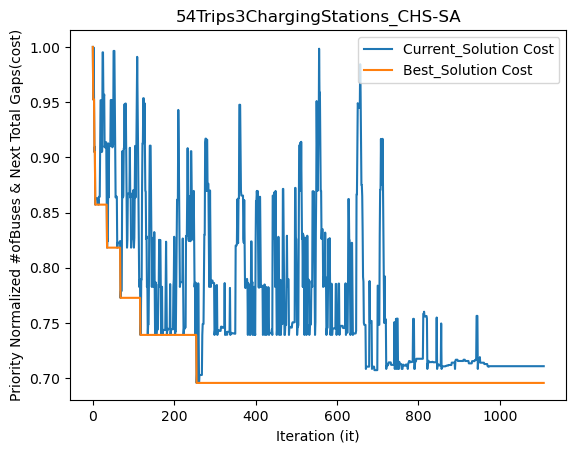

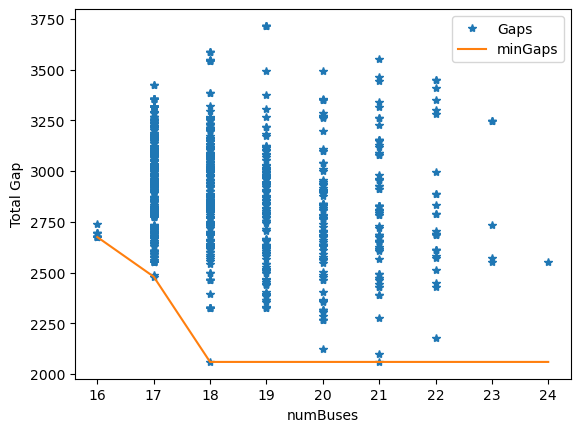

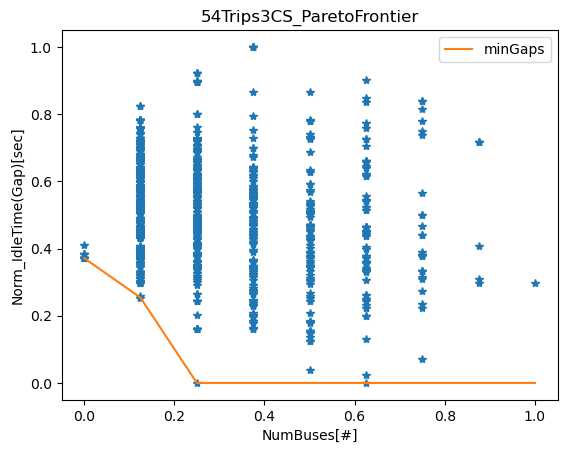

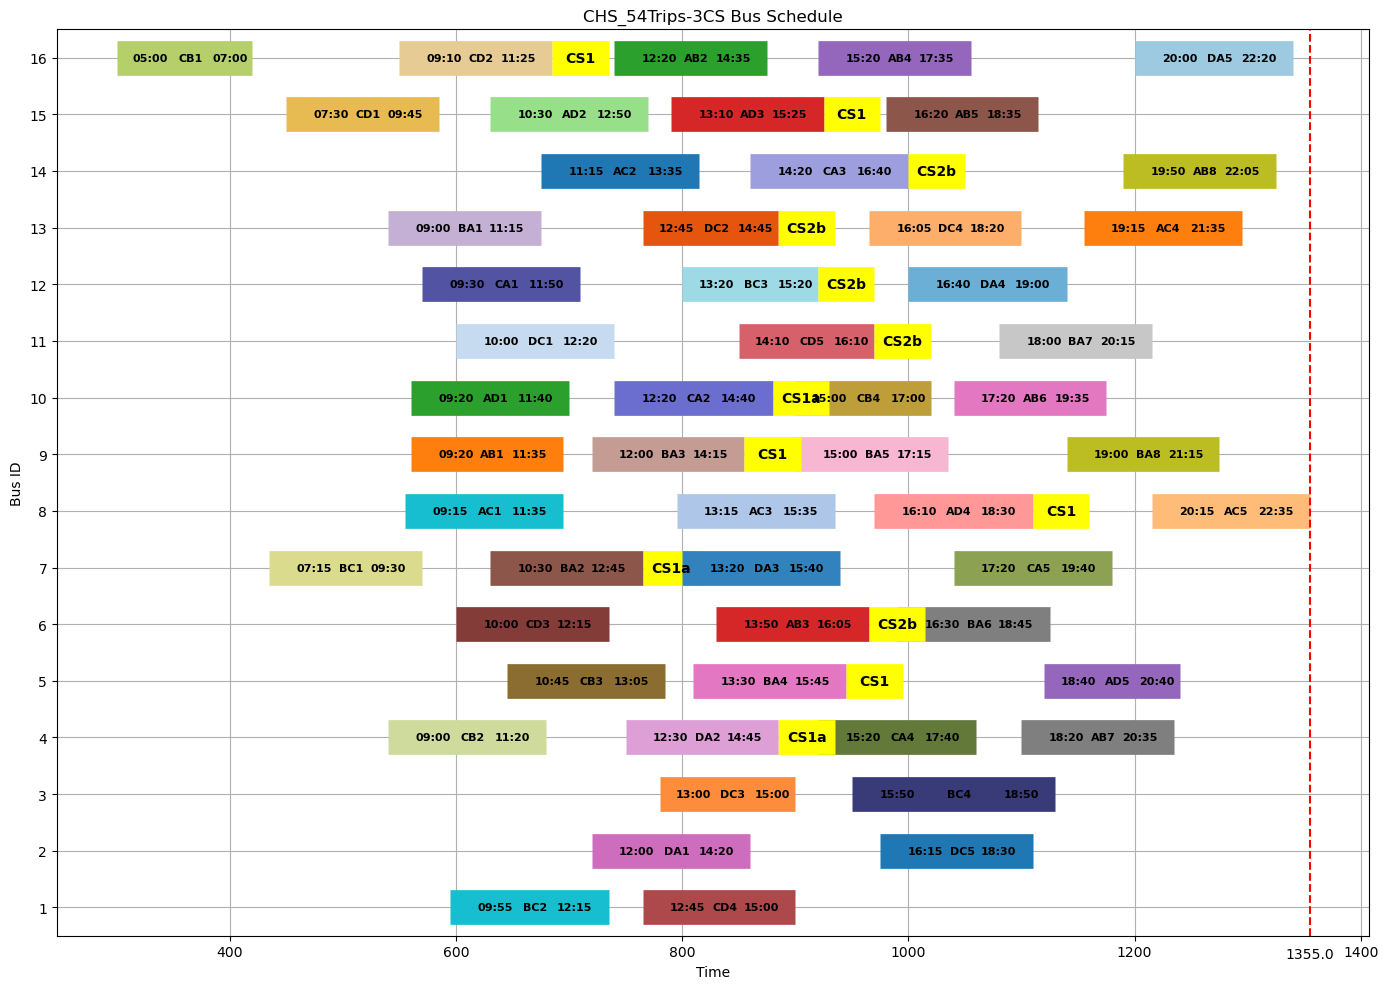

In [21]:
################################################################### 3CS #############################################################################################
## Creating Phi and Delta
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
print(recharge_3cs_arcs)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

###### import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_54_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_54_3)
end_time = time.time()
g_T54CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {g_T54CS3_time} seconds")
print(f"number of buses = {len(schedules_54_3)}")
print(schedules_54_3)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_54_3, cost_54_3, cost_diffs_54_3, temp_54_3, it_54_3, costs_54_3, solutionspaces_54_3, best_54_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T54CS3_time = (end_time - start_time) + g_T54CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T54CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_54_3} with number of buses = {len(new_schedule_54_3)}")

fig1, ax1 = plt.subplots()
ax1.plot(range(it_54_3), costs_54_3, label="Current_Solution Cost")
ax1.plot(range(it_54_3), best_54_3, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
ax1.set_xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
ax1.set_ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
ax1.set_title("54Trips3ChargingStations_CHS-SA")
ax1.legend(loc="upper right")
FiftyTrips_3cs_df = visualizeSolution(solutionspaces_54_3[1:], "54Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_54_3cs = visualizeResult(new_schedule_54_3, all_schs_3cs, "CHS_54Trips-3CS", cs_deadheads)

trips54_df_3cs = newdf_54_3cs.groupby('bus_id', group_keys=False).apply(apply_custom_shift)
trips54_df_3cs['next_dep'] = trips54_df_3cs['next_dep'].fillna(0)
trips54_df_3cs['difference'] = trips54_df_3cs['next_dep'] - trips54_df_3cs['arr_time']
trips54_df_3cs['difference'] = trips54_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
chs_54Trips3cs_IDLE_soln = trips54_df_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

chs_54Trips3cs_IDLE_soln.sort_values(['gapTime'], ascending=False)

In [18]:
cs_ids = ["CS1", "CS2", "CS3"]
def countRecharge(x):
    trips = x.split(",")
    return len(list(filter(lambda x: x in cs_ids, trips)))
chs_10Trips1cs_IDLE_soln['numRecharge'] = chs_10Trips1cs_IDLE_soln.trips.apply(countRecharge)
chs_10Trips3cs_IDLE_soln['numRecharge'] = chs_10Trips3cs_IDLE_soln.trips.apply(countRecharge)

chs_30Trips1cs_IDLE_soln['numRecharge'] = chs_30Trips1cs_IDLE_soln.trips.apply(countRecharge)
chs_30Trips3cs_IDLE_soln['numRecharge'] = chs_30Trips3cs_IDLE_soln.trips.apply(countRecharge)

chs_54Trips1cs_IDLE_soln['numRecharge'] = chs_54Trips1cs_IDLE_soln.trips.apply(countRecharge)
chs_54Trips3cs_IDLE_soln['numRecharge'] = chs_54Trips3cs_IDLE_soln.trips.apply(countRecharge)

test = chs_10Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_10Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T10CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_10Trips1CS"})

test2 = chs_10Trips3cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_10Trips3cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T10CS3_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_10Trips3CS"})

result_10Trips = pd.concat([test, test2], axis=1)
print(result_10Trips)

test = chs_20Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_20Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T20CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_20Trips1CS"})

test2 = chs_20Trips3cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_20Trips3cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T20CS3_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_20Trips3CS"})

result_20Trips = pd.concat([test, test2], axis=1)
print(result_20Trips)

test = chs_30Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_30Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T30CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_30Trips1CS"})

test2 = chs_30Trips3cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_30Trips3cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T30CS3_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_30Trips3CS"})

result_30Trips = pd.concat([test, test2], axis=1)
print(result_30Trips)

test = chs_40Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_40Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T40CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_40Trips1CS"})

test2 = chs_40Trips3cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_40Trips3cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T40CS3_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_40Trips3CS"})

result_40Trips = pd.concat([test, test2], axis=1)
print(result_40Trips)

test = chs_54Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_54Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T54CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_54Trips1CS"})

test2 = chs_54Trips3cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_54Trips3cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T54CS3_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_54Trips3CS"})

result_54Trips = pd.concat([test, test2], axis=1)
print(result_54Trips)

                   CHS_10Trips1CS  CHS_10Trips3CS
numRecharge              0.666667        0.666667
numTrips                 4.000000        4.000000
gapTime                135.000000      135.000000
numBuses                 3.000000        3.000000
time_to_best_soln      732.843384      421.802842
                   CHS_20Trips1CS  CHS_20Trips3CS
numRecharge              0.000000        0.000000
numTrips                 3.571429        3.714286
gapTime                 93.571429      107.857143
numBuses                 7.000000        7.000000
time_to_best_soln      649.734690     1059.221378
                   CHS_30Trips1CS  CHS_30Trips3CS
numRecharge              0.700000        0.600000
numTrips                 3.800000        3.800000
gapTime                137.000000      125.500000
numBuses                10.000000       10.000000
time_to_best_soln     1943.964016      941.330855
                   CHS_40Trips1CS  CHS_40Trips3CS
numRecharge              0.000000        0.000000
